In [61]:
import os
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

from my_help_functions.plot import plot_loss, plot_metric

# Cats vs. Dogs

## Готовим датасеты

In [62]:
original_dir = pathlib.Path(
    "/Users/kirillrakov/python_projects/keras/dogs-vs-cats/train/"
)
new_base_dir = pathlib.Path(
    "/Users/kirillrakov/python_projects/keras/dogs-vs-cats/cats-vs-dogs-small/"
)


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        directory = new_base_dir / subset_name / category
        os.makedirs(directory)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=directory / fname)


try:
    make_subset(subset_name="train", start_index=0, end_index=1000)
    make_subset(subset_name="validation", start_index=1000, end_index=1500)
    make_subset(subset_name="test", start_index=1500, end_index=2500)
except FileExistsError:
    pass

## Модель с нуля

### Конструируем модель

In [63]:
inputs = keras.Input(shape=(180, 180, 3))
# Приводим данные и диапазону 0-1
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [64]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                     

In [65]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

### Предварительная обработка данных

1. Прочитать файлы с изображениями.
2. Декодировать содержимое из формата JPEG в матрицы пикселей RGB.
3. Преобразовать их в тензоры с вещественными числами.
4. Привести к единому размеру (в нашем случае 180 × 180).
5. Организовать в пакеты (мы будем использовать пакеты по 32 изображения в каждом).

#### Чтение файлов с помощью image_dataset_from_directory

In [66]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train", image_size=(180, 180), batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", image_size=(180, 180), batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test", image_size=(180, 180), batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Found 2000 files belonging to 2 classes.


In [67]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### Обучение модели с сохранением лучшей

In [68]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss",
    )
]

history = model.fit(
    train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.7762 - accuracy: 0.5075INFO:tensorflow:Assets written to: models/convnet_from_scratch.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch.x/assets


63/63 [==============================] - 5s 51ms/step - loss: 0.7762 - accuracy: 0.5075 - val_loss: 0.6903 - val_accuracy: 0.5860
Epoch 2/30
62/63 [============================>.] - ETA: 0s - loss: 0.6969 - accuracy: 0.5549INFO:tensorflow:Assets written to: models/convnet_from_scratch.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch.x/assets


63/63 [==============================] - 2s 36ms/step - loss: 0.6969 - accuracy: 0.5540 - val_loss: 0.6884 - val_accuracy: 0.5450
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.5835INFO:tensorflow:Assets written to: models/convnet_from_scratch.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch.x/assets


63/63 [==============================] - 2s 33ms/step - loss: 0.6917 - accuracy: 0.5835 - val_loss: 0.6568 - val_accuracy: 0.6120
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 0.6403 - accuracy: 0.6580INFO:tensorflow:Assets written to: models/convnet_from_scratch.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch.x/assets


63/63 [==============================] - 2s 33ms/step - loss: 0.6403 - accuracy: 0.6580 - val_loss: 0.6147 - val_accuracy: 0.6640
Epoch 5/30
61/63 [============================>.] - ETA: 0s - loss: 0.5918 - accuracy: 0.6931INFO:tensorflow:Assets written to: models/convnet_from_scratch.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch.x/assets


63/63 [==============================] - 2s 38ms/step - loss: 0.5933 - accuracy: 0.6910 - val_loss: 0.5999 - val_accuracy: 0.6720
Epoch 6/30
63/63 [==============================] - 2s 31ms/step - loss: 0.5664 - accuracy: 0.7080 - val_loss: 0.8140 - val_accuracy: 0.5950
Epoch 7/30
63/63 [==============================] - 2s 29ms/step - loss: 0.5256 - accuracy: 0.7415 - val_loss: 0.6416 - val_accuracy: 0.7010
Epoch 8/30
63/63 [==============================] - 2s 30ms/step - loss: 0.5133 - accuracy: 0.7510 - val_loss: 0.6462 - val_accuracy: 0.6990
Epoch 9/30
63/63 [==============================] - 2s 28ms/step - loss: 0.4620 - accuracy: 0.7815 - val_loss: 0.7052 - val_accuracy: 0.6920
Epoch 10/30
63/63 [==============================] - 2s 29ms/step - loss: 0.4122 - accuracy: 0.8125 - val_loss: 0.7240 - val_accuracy: 0.7040
Epoch 11/30
63/63 [==============================] - 2s 29ms/step - loss: 0.3816 - accuracy: 0.8345 - val_loss: 1.1879 - val_accuracy: 0.6490
Epoch 12/30
63/63 [===

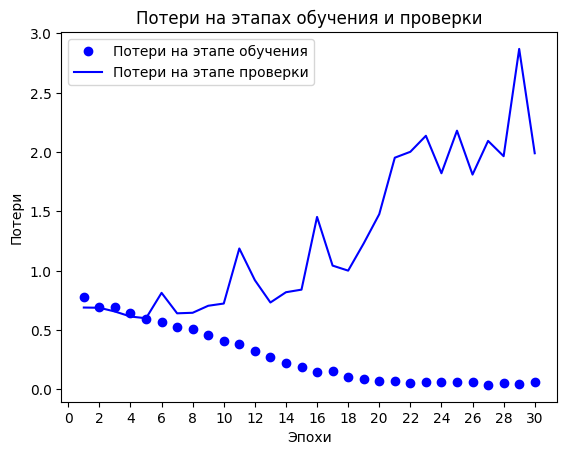

In [69]:
plot_loss(history)

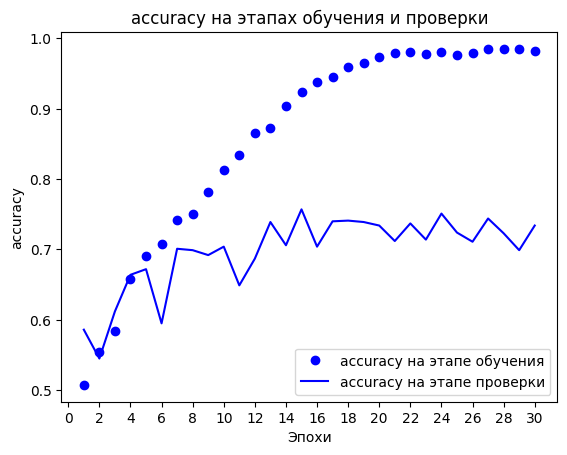

In [70]:
plot_metric(history, "accuracy", "accuracy")

Загрузим лучшую модель и проверим на контрольных данных. 

In [71]:
test_model = keras.models.load_model("models/convnet_from_scratch.x")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 12ms/step - loss: 2.0061 - accuracy: 0.7330
Test accuracy: 0.733


### Обогащение данных

In [72]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2024-04-23 12:19:23.575645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:23.729474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:23.810540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:23.850684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:23.892552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:23.933287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

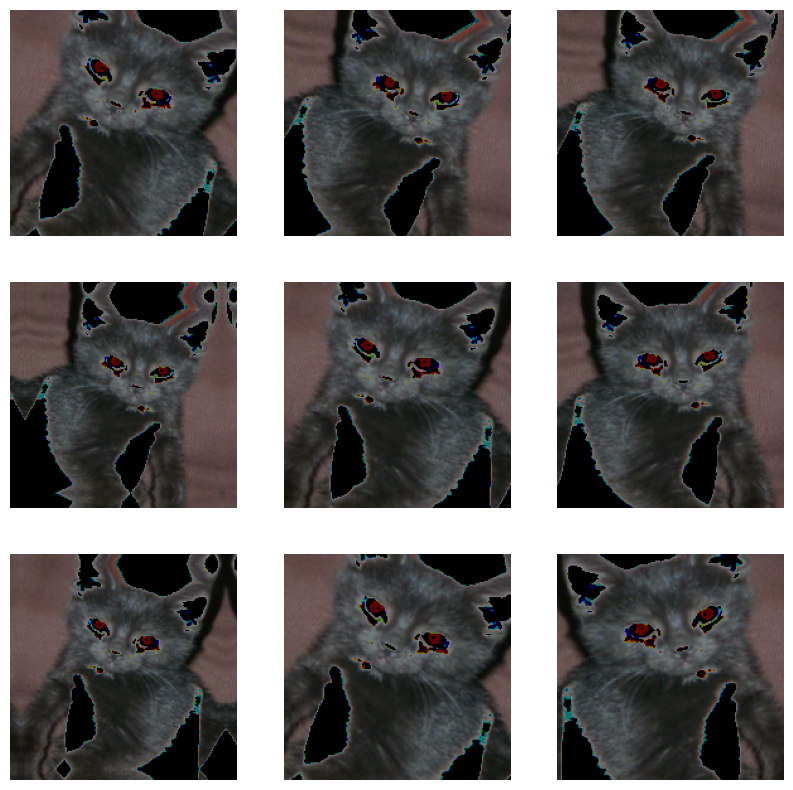

In [73]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("int8"))
        plt.axis("off")

### Новая модель на обогащенных данных

In [74]:
inputs = keras.Input(shape=(180, 180, 3))
# Обогащаем
x = data_augmentation(inputs)
# Приводим данные и диапазону 0-1
x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
# Слой прореживания перед финальным слоем
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [75]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [76]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch_with_augmentation.x",
        save_best_only=True,
        monitor="val_loss",
    )
]

history = model.fit(
    train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks
)

Epoch 1/100


2024-04-23 12:19:25.074699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 3s - loss: 0.7603 - accuracy: 0.4766

2024-04-23 12:19:25.977601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.042369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.100366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.151036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 2s - loss: 0.7240 - accuracy: 0.4861

2024-04-23 12:19:26.200155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.266822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.314348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.356583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.7121 - accuracy: 0.5048

2024-04-23 12:19:26.401401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.446712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.491422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.534105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.579863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.7080 - accuracy: 0.5000

2024-04-23 12:19:26.625492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.671961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.713908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.755675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.798662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.7045 - accuracy: 0.5000

2024-04-23 12:19:26.842998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.883265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.925176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:26.969524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.012814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.7042 - accuracy: 0.4919

2024-04-23 12:19:27.053966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.101313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.141362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.183451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.225053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.7025 - accuracy: 0.4981

2024-04-23 12:19:27.269587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.312609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.355338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.396832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.439345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.7016 - accuracy: 0.4924

2024-04-23 12:19:27.482377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.524574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.563640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.604993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.647470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.7099 - accuracy: 0.4978

2024-04-23 12:19:27.690070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.729490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.770473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.812436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.853254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 0s - loss: 0.7077 - accuracy: 0.5038

2024-04-23 12:19:27.893281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.933972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:27.974536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.015462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.053774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.7076 - accuracy: 0.5024

2024-04-23 12:19:28.095163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.137681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.179200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.219361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.259400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.7063 - accuracy: 0.5048

2024-04-23 12:19:28.299485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.338801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.376513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.417339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.458743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.498290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

61/63 [============================>.] - ETA: 0s - loss: 0.7059 - accuracy: 0.5031

2024-04-23 12:19:28.536719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.576616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:28.618278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.5065INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 6s 70ms/step - loss: 0.7055 - accuracy: 0.5065 - val_loss: 0.6909 - val_accuracy: 0.5020
Epoch 2/100
 2/63 [..............................] - ETA: 3s - loss: 0.6974 - accuracy: 0.4688

2024-04-23 12:19:30.321251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:30.412357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:30.465670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:30.510201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.6941 - accuracy: 0.5134

2024-04-23 12:19:30.555502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:30.595514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:30.654583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:30.694630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:30.735747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.6912 - accuracy: 0.5457

2024-04-23 12:19:30.776500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:30.816605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:30.857714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:30.897635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:30.939658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.6908 - accuracy: 0.5478

2024-04-23 12:19:30.979454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.022489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.061512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.106048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.145396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.6895 - accuracy: 0.5432

2024-04-23 12:19:31.191086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.230718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.272972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.313236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.6911 - accuracy: 0.5394

2024-04-23 12:19:31.354489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.6915 - accuracy: 0.5301

2024-04-23 12:19:31.397655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.436606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.477590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.518626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.561259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.6936 - accuracy: 0.5192

2024-04-23 12:19:31.607880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.646636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.689036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.727873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.6934 - accuracy: 0.5199

2024-04-23 12:19:31.770569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.6940 - accuracy: 0.5245

2024-04-23 12:19:31.810585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.853346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.892728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:31.933680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1s - loss: 0.6937 - accuracy: 0.5264

2024-04-23 12:19:31.974033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.6934 - accuracy: 0.5252

2024-04-23 12:19:32.015207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.056286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.099276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.139499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.6932 - accuracy: 0.5269

2024-04-23 12:19:32.181577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.6932 - accuracy: 0.5312

2024-04-23 12:19:32.223217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.265724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.306759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.348744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 0s - loss: 0.6930 - accuracy: 0.5306

2024-04-23 12:19:32.388216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.6932 - accuracy: 0.5263

2024-04-23 12:19:32.429457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.468712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.509997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.551411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6934 - accuracy: 0.5218

2024-04-23 12:19:32.593227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6944 - accuracy: 0.5258

2024-04-23 12:19:32.633096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.672828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.710935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.749500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.789653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6944 - accuracy: 0.5260

2024-04-23 12:19:32.828044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5250

2024-04-23 12:19:32.866982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.907469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:32.945833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 4s 55ms/step - loss: 0.6941 - accuracy: 0.5250 - val_loss: 0.6807 - val_accuracy: 0.5820
Epoch 3/100
 3/63 [>.............................] - ETA: 2s - loss: 0.6800 - accuracy: 0.6042

2024-04-23 12:19:33.837224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:33.929644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:33.969039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.011048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.7062 - accuracy: 0.5714

2024-04-23 12:19:34.053256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.095670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.148547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.190738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.231197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.7039 - accuracy: 0.5553

2024-04-23 12:19:34.275961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.317399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.358520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.398323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.441608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.6994 - accuracy: 0.5790

2024-04-23 12:19:34.484708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.523648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.565669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.606968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.649054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.6971 - accuracy: 0.5666

2024-04-23 12:19:34.689484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.733473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.776721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.817438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.861819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 1s - loss: 0.6895 - accuracy: 0.5808

2024-04-23 12:19:34.904335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.943984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:34.986483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.027605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.066801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.6887 - accuracy: 0.5701

2024-04-23 12:19:35.108893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.149168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.192793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.232190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.275162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.6907 - accuracy: 0.5676

2024-04-23 12:19:35.319907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.361131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.404792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.446801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.486950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.6904 - accuracy: 0.5610

2024-04-23 12:19:35.528018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.569233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.609957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.650602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.692135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 0s - loss: 0.6892 - accuracy: 0.5695

2024-04-23 12:19:35.733208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.773800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.813471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.857083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.897855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6869 - accuracy: 0.5719

2024-04-23 12:19:35.940100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:35.982219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.025482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.065646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.108217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6866 - accuracy: 0.5794

2024-04-23 12:19:36.147554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.186908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.225149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.267685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.309224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.347555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5825

2024-04-23 12:19:36.386806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.428546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.468841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 46ms/step - loss: 0.6842 - accuracy: 0.5825 - val_loss: 0.7207 - val_accuracy: 0.5430
Epoch 4/100
 3/63 [>.............................] - ETA: 2s - loss: 0.6632 - accuracy: 0.6667

2024-04-23 12:19:36.800932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.887777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.931283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:36.972143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.6375 - accuracy: 0.6607

2024-04-23 12:19:37.013367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.057231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.097972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.144920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.184005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.6450 - accuracy: 0.6346

2024-04-23 12:19:37.227475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.268987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.310680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.353766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.396310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.6807 - accuracy: 0.6048

2024-04-23 12:19:37.437574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.479569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.521259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.561908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.602673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.6728 - accuracy: 0.6114

2024-04-23 12:19:37.646829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.688321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.731104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.771493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.813653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 1s - loss: 0.6718 - accuracy: 0.6153

2024-04-23 12:19:37.854664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.896829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.936117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:37.975896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.015494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.6703 - accuracy: 0.6155

2024-04-23 12:19:38.057876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.104280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.144353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.184567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.227313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.6682 - accuracy: 0.6182

2024-04-23 12:19:38.267940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.310100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.351244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.393532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.435952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.6964 - accuracy: 0.6170

2024-04-23 12:19:38.480030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.521428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.562177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.605100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.647557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.6886 - accuracy: 0.6223

2024-04-23 12:19:38.691525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.733667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.781094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.821803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.863435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6814 - accuracy: 0.6262

2024-04-23 12:19:38.906115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.947270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:38.989819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:39.032255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:39.072119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6755 - accuracy: 0.6319

2024-04-23 12:19:39.113551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:39.153044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:39.191951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:39.231398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:39.269366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:39.308495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.6305

2024-04-23 12:19:39.347614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:39.387558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:39.428176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 4s 55ms/step - loss: 0.6740 - accuracy: 0.6305 - val_loss: 0.6004 - val_accuracy: 0.6610
Epoch 5/100
 3/63 [>.............................] - ETA: 2s - loss: 0.6112 - accuracy: 0.6146

2024-04-23 12:19:40.326961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:40.422852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:40.464531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:40.506651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.6156 - accuracy: 0.6384

2024-04-23 12:19:40.547468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:40.590635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:40.648838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:40.693221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:40.733289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.6475 - accuracy: 0.6514

2024-04-23 12:19:40.773932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:40.815194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:40.857049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:40.898521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:40.937873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 1s - loss: 0.6501 - accuracy: 0.6579

2024-04-23 12:19:40.980621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.021174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.062094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.100945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.143554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.6474 - accuracy: 0.6522

2024-04-23 12:19:41.184377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.223412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.264170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.306613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.347589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.6462 - accuracy: 0.6539

2024-04-23 12:19:41.388380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.429566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.471350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.512076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.557659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.6429 - accuracy: 0.6534

2024-04-23 12:19:41.596462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.637952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.679143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.720020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.762776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.6400 - accuracy: 0.6554

2024-04-23 12:19:41.802537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.844885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.884515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.927195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:41.966330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.6383 - accuracy: 0.6504

2024-04-23 12:19:42.010187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.050510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.092212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.136246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.177044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.6370 - accuracy: 0.6516

2024-04-23 12:19:42.218116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.260724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.303423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.344103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.383877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6345 - accuracy: 0.6539

2024-04-23 12:19:42.425945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.465701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.508108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.548205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.588388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6395 - accuracy: 0.6525

2024-04-23 12:19:42.627206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.667479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.708757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.751699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.789418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.6495

2024-04-23 12:19:42.828909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.867470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.911031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:42.950994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 46ms/step - loss: 0.6401 - accuracy: 0.6495 - val_loss: 0.6389 - val_accuracy: 0.6140
Epoch 6/100
 3/63 [>.............................] - ETA: 2s - loss: 0.6369 - accuracy: 0.6146

2024-04-23 12:19:43.275258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.373717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.418034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.458372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.6271 - accuracy: 0.6741

2024-04-23 12:19:43.498795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.540435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.581164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.623518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.665977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.5838 - accuracy: 0.7019

2024-04-23 12:19:43.707837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.750173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.792378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.833741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.874878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.5989 - accuracy: 0.6893

2024-04-23 12:19:43.918188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:43.960081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.006062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.048663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.091082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.6129 - accuracy: 0.6739

2024-04-23 12:19:44.133859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.176152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.219552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.261259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.303213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.6140 - accuracy: 0.6725

2024-04-23 12:19:44.346970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.388519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.429554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.471170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.512230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.6088 - accuracy: 0.6761

2024-04-23 12:19:44.553266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.594225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.635135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.678369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.719905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.6047 - accuracy: 0.6799

2024-04-23 12:19:44.761498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.804261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.845675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.885580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:44.927667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.6108 - accuracy: 0.6737

2024-04-23 12:19:44.968874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.013530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.055423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.094377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.138306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.6084 - accuracy: 0.6762

2024-04-23 12:19:45.181179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.222213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.264463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.306579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.346361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6085 - accuracy: 0.6781

2024-04-23 12:19:45.386996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.427645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.470998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.510537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.552923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6105 - accuracy: 0.6743

2024-04-23 12:19:45.591184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.632731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.674404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.713413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.751712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.790669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - ETA: 0s - loss: 0.6122 - accuracy: 0.6755

2024-04-23 12:19:45.829863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.869603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:45.910066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 46ms/step - loss: 0.6122 - accuracy: 0.6755 - val_loss: 0.7047 - val_accuracy: 0.5970
Epoch 7/100
 3/63 [>.............................] - ETA: 2s - loss: 0.5647 - accuracy: 0.7500

2024-04-23 12:19:46.232697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.315969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.356905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.400099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.6282 - accuracy: 0.6830

2024-04-23 12:19:46.439894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.482156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.546066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.590197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.630707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.6212 - accuracy: 0.6923

2024-04-23 12:19:46.673098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.713852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.753712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.797773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.840573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.6150 - accuracy: 0.6949

2024-04-23 12:19:46.882116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.925228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:46.965712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.006647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.048011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.6137 - accuracy: 0.6929

2024-04-23 12:19:47.090129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.130565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.170586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.212457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.254835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 1s - loss: 0.6126 - accuracy: 0.6853

2024-04-23 12:19:47.296299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.340655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.379664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.419042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.460462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.6133 - accuracy: 0.6866

2024-04-23 12:19:47.501284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.539985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.582860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.622339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.664489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1s - loss: 0.6127 - accuracy: 0.6827

2024-04-23 12:19:47.706445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.746959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.786063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.829623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.871697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.6077 - accuracy: 0.6853

2024-04-23 12:19:47.910717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.952003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:47.995248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.035249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.074768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 0s - loss: 0.6010 - accuracy: 0.6875

2024-04-23 12:19:48.115279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.157580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.198593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.238874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.278082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5993 - accuracy: 0.6899

2024-04-23 12:19:48.319524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.359753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.402731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.444075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.483617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6032 - accuracy: 0.6864

2024-04-23 12:19:48.521591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.560051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.599196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.640130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.682538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.6860

2024-04-23 12:19:48.726179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.764076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.802737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:48.843518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 46ms/step - loss: 0.6034 - accuracy: 0.6860 - val_loss: 0.6324 - val_accuracy: 0.6300
Epoch 8/100
 3/63 [>.............................] - ETA: 2s - loss: 0.5623 - accuracy: 0.7396

2024-04-23 12:19:49.152129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.240894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.283269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.322904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.5770 - accuracy: 0.7321

2024-04-23 12:19:49.365120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.407086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.447791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.490982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.530203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.5946 - accuracy: 0.6899

2024-04-23 12:19:49.572848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.615159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.658569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.700477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.742231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.5974 - accuracy: 0.6930

2024-04-23 12:19:49.781326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.823917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.866362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.908680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:49.948398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.5966 - accuracy: 0.6834

2024-04-23 12:19:49.988325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.030377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.071975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.111911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.152768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.5946 - accuracy: 0.6898

2024-04-23 12:19:50.194199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.238260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.279428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.320812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.360945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.5889 - accuracy: 0.6960

2024-04-23 12:19:50.403274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.445400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.486451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.528091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.569212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.5906 - accuracy: 0.6909

2024-04-23 12:19:50.610969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.652301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.691789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.735703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.777944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.5900 - accuracy: 0.6875

2024-04-23 12:19:50.816377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.860742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.901724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.943314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:50.985126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.5988 - accuracy: 0.6822

2024-04-23 12:19:51.023919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.067187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.107285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.150178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.192070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6010 - accuracy: 0.6810

2024-04-23 12:19:51.233163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.275019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.316055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.356088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.397054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5968 - accuracy: 0.6827

2024-04-23 12:19:51.436042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.473971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.513563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.553433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.591967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.636246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.6845

2024-04-23 12:19:51.675424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.715120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:51.755238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 74ms/step - loss: 0.5940 - accuracy: 0.6845 - val_loss: 0.5930 - val_accuracy: 0.6810
Epoch 9/100


2024-04-23 12:19:53.909645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 12s - loss: 0.4499 - accuracy: 0.8438

2024-04-23 12:19:54.062711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.108368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 2s - loss: 0.6370 - accuracy: 0.6797

2024-04-23 12:19:54.157473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.206909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.250009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 2s - loss: 0.6066 - accuracy: 0.7083

2024-04-23 12:19:54.292365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.332565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 2s - loss: 0.6007 - accuracy: 0.7118

2024-04-23 12:19:54.386443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.429442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.472006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.5889 - accuracy: 0.7292

2024-04-23 12:19:54.516246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.566388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 2s - loss: 0.5852 - accuracy: 0.7299

2024-04-23 12:19:54.608952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.651965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.694250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2s - loss: 0.5913 - accuracy: 0.7090

2024-04-23 12:19:54.738385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.779125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 1s - loss: 0.5903 - accuracy: 0.7016

2024-04-23 12:19:54.821337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.865238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.907926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.5922 - accuracy: 0.7031

2024-04-23 12:19:54.950838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:54.993803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 1s - loss: 0.6091 - accuracy: 0.6914

2024-04-23 12:19:55.037385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.079042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.121821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.6140 - accuracy: 0.6803

2024-04-23 12:19:55.165002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.206919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 1s - loss: 0.6112 - accuracy: 0.6823

2024-04-23 12:19:55.249640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.293179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.334396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.6091 - accuracy: 0.6846

2024-04-23 12:19:55.378417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.419190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 1s - loss: 0.6076 - accuracy: 0.6829

2024-04-23 12:19:55.462980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.507460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.548447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.6019 - accuracy: 0.6849

2024-04-23 12:19:55.590607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.630748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.6015 - accuracy: 0.6766

2024-04-23 12:19:55.674248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.717192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.760898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.5964 - accuracy: 0.6815

2024-04-23 12:19:55.803488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.843426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 0s - loss: 0.5959 - accuracy: 0.6811

2024-04-23 12:19:55.887769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.932290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:55.974377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.5968 - accuracy: 0.6787

2024-04-23 12:19:56.017227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:56.059075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.5992 - accuracy: 0.6819

2024-04-23 12:19:56.100634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:56.142352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:56.186582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.5994 - accuracy: 0.6809

2024-04-23 12:19:56.225674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:56.269289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.5978 - accuracy: 0.6834

2024-04-23 12:19:56.309499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:56.350197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:56.389934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.5968 - accuracy: 0.6864

2024-04-23 12:19:56.432117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:56.472803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5997 - accuracy: 0.6849

2024-04-23 12:19:56.513924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:56.553050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:56.594413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5985 - accuracy: 0.6855

2024-04-23 12:19:56.633919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:56.674527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 4s 57ms/step - loss: 0.5972 - accuracy: 0.6870 - val_loss: 0.5524 - val_accuracy: 0.7150
Epoch 10/100
 3/63 [>.............................] - ETA: 2s - loss: 0.5446 - accuracy: 0.7396

2024-04-23 12:19:57.572679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:57.672553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:57.712907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:57.757425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.5413 - accuracy: 0.7277

2024-04-23 12:19:57.799836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:57.842679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:57.885201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:57.930433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:57.973209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.5921 - accuracy: 0.7131

2024-04-23 12:19:58.018407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.067169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.111343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.157795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.6016 - accuracy: 0.7043

2024-04-23 12:19:58.198143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.5897 - accuracy: 0.7077

2024-04-23 12:19:58.240161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.283041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.324484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.367187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.406809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.5851 - accuracy: 0.6979

2024-04-23 12:19:58.448586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.491416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.532565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.573525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.5908 - accuracy: 0.7011

2024-04-23 12:19:58.618001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.5915 - accuracy: 0.6968

2024-04-23 12:19:58.659968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.700637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.742340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.782785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 1s - loss: 0.5880 - accuracy: 0.7004

2024-04-23 12:19:58.822788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.5860 - accuracy: 0.7006

2024-04-23 12:19:58.865415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.908625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.951031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:58.991623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.5919 - accuracy: 0.6970

2024-04-23 12:19:59.035868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.5912 - accuracy: 0.6959

2024-04-23 12:19:59.077719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.119641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.162203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.205358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.247701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.5870 - accuracy: 0.6959

2024-04-23 12:19:59.289562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.333407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.375464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.417110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.5838 - accuracy: 0.6984

2024-04-23 12:19:59.459005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.5871 - accuracy: 0.7001

2024-04-23 12:19:59.499041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.542906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.585063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.627004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.668766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.5873 - accuracy: 0.6991

2024-04-23 12:19:59.709919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.750576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.795139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.837094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5931 - accuracy: 0.6952

2024-04-23 12:19:59.878128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5857 - accuracy: 0.7018

2024-04-23 12:19:59.917668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:19:59.961043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:00.001695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:00.042077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5857 - accuracy: 0.7002

2024-04-23 12:20:00.080946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5838 - accuracy: 0.7013

2024-04-23 12:20:00.121715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:00.162075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:00.211538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:00.249650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5818 - accuracy: 0.7025INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 4s 56ms/step - loss: 0.5818 - accuracy: 0.7025 - val_loss: 0.5329 - val_accuracy: 0.7320
Epoch 11/100
 3/63 [>.............................] - ETA: 2s - loss: 0.5441 - accuracy: 0.7708

2024-04-23 12:20:01.127798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.224501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.266782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.309868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.5838 - accuracy: 0.7098

2024-04-23 12:20:01.356772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.398389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.441526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.483362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.526841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.5838 - accuracy: 0.7131

2024-04-23 12:20:01.571800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.612853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.657843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.699980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.5869 - accuracy: 0.7091

2024-04-23 12:20:01.740824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.5814 - accuracy: 0.7077

2024-04-23 12:20:01.783311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.827525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.868426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.911448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:01.955535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.5816 - accuracy: 0.7068

2024-04-23 12:20:01.997551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.041340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.083395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.125034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.5786 - accuracy: 0.7065

2024-04-23 12:20:02.167747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.5785 - accuracy: 0.7072

2024-04-23 12:20:02.207130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.253576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.295901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.341664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.382427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.5689 - accuracy: 0.7147

2024-04-23 12:20:02.425866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.467745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.510819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.551160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.5642 - accuracy: 0.7169

2024-04-23 12:20:02.591890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.5614 - accuracy: 0.7188

2024-04-23 12:20:02.635054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.677120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.718316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.759373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.800225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.5663 - accuracy: 0.7165

2024-04-23 12:20:02.844622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.886724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.929753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:02.968831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.5610 - accuracy: 0.7209

2024-04-23 12:20:03.011564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.5637 - accuracy: 0.7161

2024-04-23 12:20:03.055104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.097815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.140732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.183996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.225387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.5678 - accuracy: 0.7108

2024-04-23 12:20:03.268832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.309774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.355288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.396910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5624 - accuracy: 0.7164

2024-04-23 12:20:03.439037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5554 - accuracy: 0.7220

2024-04-23 12:20:03.479867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.519612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.559350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.599773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.639348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5601 - accuracy: 0.7152

2024-04-23 12:20:03.681834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.741138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.786271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:03.826174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.5592 - accuracy: 0.7165 - val_loss: 0.5495 - val_accuracy: 0.7160
Epoch 12/100
 3/63 [>.............................] - ETA: 2s - loss: 0.6544 - accuracy: 0.7188

2024-04-23 12:20:04.147310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.236850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.280234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.320103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.6161 - accuracy: 0.7054

2024-04-23 12:20:04.361083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.406725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.448086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.490588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.533426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.5827 - accuracy: 0.6971

2024-04-23 12:20:04.573863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.618918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.666137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.707701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.751312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.5865 - accuracy: 0.6967

2024-04-23 12:20:04.794003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.836467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.876804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.920794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:04.964348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.5710 - accuracy: 0.7038

2024-04-23 12:20:05.008181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.049632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.092973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.135660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.176867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.5635 - accuracy: 0.7141

2024-04-23 12:20:05.218011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.261173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.302496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.343180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.385701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.5604 - accuracy: 0.7102

2024-04-23 12:20:05.427034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.468814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.512615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.552866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.595427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.5630 - accuracy: 0.7027

2024-04-23 12:20:05.635356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.679787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.720714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.763762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.803727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.5619 - accuracy: 0.7006

2024-04-23 12:20:05.847932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.888859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.932360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:05.973950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.014122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.5650 - accuracy: 0.7021

2024-04-23 12:20:06.056234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.100240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.142890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.185727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.226584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5613 - accuracy: 0.7081

2024-04-23 12:20:06.268073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.310664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.352334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.393051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.435075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5675 - accuracy: 0.7039

2024-04-23 12:20:06.476809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.518837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.560551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.603572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.643443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.7130

2024-04-23 12:20:06.687144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.726007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.766983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:06.807206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.5591 - accuracy: 0.7130 - val_loss: 0.5376 - val_accuracy: 0.7410
Epoch 13/100
 3/63 [>.............................] - ETA: 2s - loss: 0.5105 - accuracy: 0.7396

2024-04-23 12:20:07.126978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.222697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.265010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.308646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.5362 - accuracy: 0.7366

2024-04-23 12:20:07.350124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.394124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.435898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.486132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.526354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.5278 - accuracy: 0.7428

2024-04-23 12:20:07.569385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.611436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.655280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.697969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.739829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.5368 - accuracy: 0.7408

2024-04-23 12:20:07.781820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.823107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.865391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.907659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:07.949330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.5253 - accuracy: 0.7446

2024-04-23 12:20:07.989554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.032312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.074589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.118503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.161435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.5292 - accuracy: 0.7407

2024-04-23 12:20:08.202707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.246460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.286786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.328701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.369912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.5334 - accuracy: 0.7292

2024-04-23 12:20:08.411455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.451203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.493428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.535255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.578084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.5333 - accuracy: 0.7272

2024-04-23 12:20:08.622050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.665483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.707747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.750243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.790779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.5281 - accuracy: 0.7326

2024-04-23 12:20:08.836885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.879566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.921552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:08.962946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.004186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.5301 - accuracy: 0.7314

2024-04-23 12:20:09.045567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.090626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.133180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.177873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.220512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5270 - accuracy: 0.7317

2024-04-23 12:20:09.263177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.302793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.345760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.387258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.431950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5211 - accuracy: 0.7373

2024-04-23 12:20:09.470682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.511252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.551235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.591373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.629527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.7335

2024-04-23 12:20:09.674296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.717889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.757597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:09.797009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 4s 56ms/step - loss: 0.5259 - accuracy: 0.7335 - val_loss: 0.4935 - val_accuracy: 0.7520
Epoch 14/100
 2/63 [..............................] - ETA: 3s - loss: 0.4694 - accuracy: 0.7656

2024-04-23 12:20:10.681947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:10.787542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:10.831285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:10.873717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 2s - loss: 0.5467 - accuracy: 0.7240

2024-04-23 12:20:10.918012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:10.959694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.003441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.045971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 2s - loss: 0.5530 - accuracy: 0.7109

2024-04-23 12:20:11.089344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.5362 - accuracy: 0.7135

2024-04-23 12:20:11.132171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.174849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.217131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.258846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.299834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2s - loss: 0.5264 - accuracy: 0.7168

2024-04-23 12:20:11.342083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.384373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.425504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.468614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 1s - loss: 0.5297 - accuracy: 0.7205

2024-04-23 12:20:11.512115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.5257 - accuracy: 0.7259

2024-04-23 12:20:11.553580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.596150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.637615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.681398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.722644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.5265 - accuracy: 0.7284

2024-04-23 12:20:11.766068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.806987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.851618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:11.894593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 1s - loss: 0.5196 - accuracy: 0.7333

2024-04-23 12:20:11.936270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.5165 - accuracy: 0.7354

2024-04-23 12:20:11.978108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.021169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.063777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.107932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.148432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.5257 - accuracy: 0.7309

2024-04-23 12:20:12.191639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.233396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.275847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.317340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.5303 - accuracy: 0.7278

2024-04-23 12:20:12.360422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.5290 - accuracy: 0.7284

2024-04-23 12:20:12.401978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.445443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.485934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.528367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.570345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.5263 - accuracy: 0.7310

2024-04-23 12:20:12.613024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.656632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.700668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.742479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.5179 - accuracy: 0.7370

2024-04-23 12:20:12.783854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.5114 - accuracy: 0.7416

2024-04-23 12:20:12.827406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.870648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.911461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.956175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:12.996255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.5159 - accuracy: 0.7403

2024-04-23 12:20:13.037410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.076980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.116470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.155265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.197914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.235869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

62/63 [============================>.] - ETA: 0s - loss: 0.5117 - accuracy: 0.7450

2024-04-23 12:20:13.276046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.315573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.356258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.5117 - accuracy: 0.7445 - val_loss: 1.2164 - val_accuracy: 0.6220
Epoch 15/100
 3/63 [>.............................] - ETA: 2s - loss: 0.6842 - accuracy: 0.7188

2024-04-23 12:20:13.667887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.753650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.799170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.841182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.6490 - accuracy: 0.7054

2024-04-23 12:20:13.882684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.924662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:13.966228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.008673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.050774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.6031 - accuracy: 0.7163

2024-04-23 12:20:14.094871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.136488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.179292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.223007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.264439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.5862 - accuracy: 0.7335

2024-04-23 12:20:14.306680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.348323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.392210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.433639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.475851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.5631 - accuracy: 0.7310

2024-04-23 12:20:14.516474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.583640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.635736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.676852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.5623 - accuracy: 0.7292

2024-04-23 12:20:14.720148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.763757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.805192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.847083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.889538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.5423 - accuracy: 0.7389

2024-04-23 12:20:14.933536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:14.986918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.031722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.076016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.119877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.5420 - accuracy: 0.7390

2024-04-23 12:20:15.162071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.206658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.249365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.290873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.334159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.5324 - accuracy: 0.7439

2024-04-23 12:20:15.377095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.417943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.461024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.501435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.542407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.5377 - accuracy: 0.7440

2024-04-23 12:20:15.584226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.626606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.669282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.711684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.756017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.5355 - accuracy: 0.7451

2024-04-23 12:20:15.798719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.840081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.882366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.925497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:15.971332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5273 - accuracy: 0.7522

2024-04-23 12:20:16.015944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:16.059668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:16.104748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:16.144029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:16.186027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5242 - accuracy: 0.7540

2024-04-23 12:20:16.235234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:16.275939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:16.315464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:16.357077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:16.398840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 4s 57ms/step - loss: 0.5242 - accuracy: 0.7540 - val_loss: 0.4774 - val_accuracy: 0.7830
Epoch 16/100
 3/63 [>.............................] - ETA: 2s - loss: 0.4867 - accuracy: 0.8021

2024-04-23 12:20:17.301473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:17.393060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:17.434672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:17.478540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.5169 - accuracy: 0.7679

2024-04-23 12:20:17.522494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:17.565670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:17.607056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:17.650059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:17.692026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.5079 - accuracy: 0.7841

2024-04-23 12:20:17.734512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:17.776534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:17.819531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:17.861003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.5119 - accuracy: 0.7837

2024-04-23 12:20:17.905032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.5064 - accuracy: 0.7849

2024-04-23 12:20:17.946449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:17.990330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.032997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.076187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.118925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.4996 - accuracy: 0.7768

2024-04-23 12:20:18.162481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.201924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.242709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.285409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.5067 - accuracy: 0.7663

2024-04-23 12:20:18.327472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.4967 - accuracy: 0.7731

2024-04-23 12:20:18.369407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.410843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.454482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.495824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.538189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.4973 - accuracy: 0.7702

2024-04-23 12:20:18.580185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.622434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.666457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.706034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.4977 - accuracy: 0.7689

2024-04-23 12:20:18.749308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.4938 - accuracy: 0.7703

2024-04-23 12:20:18.791455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.834780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.876512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.917344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:18.959307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.5005 - accuracy: 0.7652

2024-04-23 12:20:19.003290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.044943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.085761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.128512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.4969 - accuracy: 0.7660

2024-04-23 12:20:19.171717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.4994 - accuracy: 0.7606

2024-04-23 12:20:19.213047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.256705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.299395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.342414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.383252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.4957 - accuracy: 0.7647

2024-04-23 12:20:19.423792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.467403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.513427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.556498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4952 - accuracy: 0.7653

2024-04-23 12:20:19.597485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4982 - accuracy: 0.7654

2024-04-23 12:20:19.636486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.675908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.715414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.756498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.795694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.7650

2024-04-23 12:20:19.838101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.875705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.916742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:19.954876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 46ms/step - loss: 0.4974 - accuracy: 0.7650 - val_loss: 0.5134 - val_accuracy: 0.7600
Epoch 17/100
 3/63 [>.............................] - ETA: 2s - loss: 0.5299 - accuracy: 0.8021

2024-04-23 12:20:20.268639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.354823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.401532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.445696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.5369 - accuracy: 0.7634

2024-04-23 12:20:20.489338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.529889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.573695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.616694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.657946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.5011 - accuracy: 0.7716

2024-04-23 12:20:20.700000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.743541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.789499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.832752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.874253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.5246 - accuracy: 0.7665

2024-04-23 12:20:20.917192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:20.962319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.006688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.053655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.099717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.5098 - accuracy: 0.7704

2024-04-23 12:20:21.143851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.187452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.231326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.273592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.316119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.5000 - accuracy: 0.7766

2024-04-23 12:20:21.360977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.403194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.445941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.487296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.527689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.5024 - accuracy: 0.7718

2024-04-23 12:20:21.569285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.612295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.658624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.701362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.743804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.5144 - accuracy: 0.7652

2024-04-23 12:20:21.787870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.830741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.871747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.913960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:21.956536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.5108 - accuracy: 0.7594

2024-04-23 12:20:21.999374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.042906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.087663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.127163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.167728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.5109 - accuracy: 0.7600

2024-04-23 12:20:22.209068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.251341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.294260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.338446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.379959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5079 - accuracy: 0.7630

2024-04-23 12:20:22.423678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.466013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.506813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.548997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.590692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5074 - accuracy: 0.7611

2024-04-23 12:20:22.630039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.670907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.711147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.752034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.790380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5035 - accuracy: 0.7641

2024-04-23 12:20:22.830956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.871551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.914553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:22.969316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.5034 - accuracy: 0.7635 - val_loss: 0.8188 - val_accuracy: 0.6950
Epoch 18/100
 3/63 [>.............................] - ETA: 2s - loss: 0.6535 - accuracy: 0.6667

2024-04-23 12:20:23.294553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.391583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.436918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.478511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.5347 - accuracy: 0.7366

2024-04-23 12:20:23.523149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.564736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.607708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.650156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.693144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.5176 - accuracy: 0.7452

2024-04-23 12:20:23.736126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.777093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.819572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.859666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.904142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.5050 - accuracy: 0.7500

2024-04-23 12:20:23.944350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:23.986379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.028697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.070944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.112595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.5022 - accuracy: 0.7554

2024-04-23 12:20:24.155514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.198284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.240874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.283774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.327537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.5109 - accuracy: 0.7523

2024-04-23 12:20:24.371173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.416506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.458771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.500300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.541300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.5028 - accuracy: 0.7614

2024-04-23 12:20:24.583243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.623612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.666466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.709333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.753408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.4946 - accuracy: 0.7652

2024-04-23 12:20:24.795278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.838385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.879428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.922493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:24.964351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.4979 - accuracy: 0.7660

2024-04-23 12:20:25.011338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.056125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.099353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.142520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.184315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.5002 - accuracy: 0.7653

2024-04-23 12:20:25.228980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.269074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.313656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.357212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.398841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4896 - accuracy: 0.7724

2024-04-23 12:20:25.444125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.492266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.534658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.576151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.625579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4866 - accuracy: 0.7736

2024-04-23 12:20:25.666052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.707921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.749862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.790394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.831744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.7750

2024-04-23 12:20:25.872185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.913196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.954907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:25.994850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.4856 - accuracy: 0.7750 - val_loss: 0.5460 - val_accuracy: 0.7430
Epoch 19/100
 3/63 [>.............................] - ETA: 2s - loss: 0.5409 - accuracy: 0.7708

2024-04-23 12:20:26.323802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:26.419710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:26.461595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:26.505450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.5241 - accuracy: 0.7723

2024-04-23 12:20:26.547357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:26.588765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:26.630886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:26.673525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:26.715198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.4725 - accuracy: 0.8005

2024-04-23 12:20:26.759053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:26.800765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:26.843145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:26.887106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:26.929343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.4764 - accuracy: 0.7886

2024-04-23 12:20:26.972421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.013535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.055559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.097765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.140757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.4799 - accuracy: 0.7745

2024-04-23 12:20:27.183138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.226655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.268956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.311795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.353231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.4924 - accuracy: 0.7639

2024-04-23 12:20:27.395111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.440825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.484822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.525984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.566295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.4814 - accuracy: 0.7746

2024-04-23 12:20:27.610007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.651569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.692715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.733314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.776515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.4775 - accuracy: 0.7728

2024-04-23 12:20:27.817042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.859072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.900924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.943625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:27.982699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.4840 - accuracy: 0.7696

2024-04-23 12:20:28.022741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.063983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.107881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.149238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.190458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.4879 - accuracy: 0.7693

2024-04-23 12:20:28.230456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.274899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.315636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.358726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.398893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4775 - accuracy: 0.7759

2024-04-23 12:20:28.442472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.482637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.526272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.567011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.607369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4698 - accuracy: 0.7780

2024-04-23 12:20:28.646432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.686405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.727465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.769370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.811341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.7735

2024-04-23 12:20:28.850917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.889984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.929625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:28.971230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 46ms/step - loss: 0.4735 - accuracy: 0.7735 - val_loss: 0.4943 - val_accuracy: 0.7640
Epoch 20/100
 3/63 [>.............................] - ETA: 2s - loss: 0.4264 - accuracy: 0.7917

2024-04-23 12:20:29.284522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.372513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.415596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.459885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.4722 - accuracy: 0.7589

2024-04-23 12:20:29.502092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.546698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.590860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.633816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.676110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.4552 - accuracy: 0.7668

2024-04-23 12:20:29.719189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.761328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.810279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.851796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.893900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.4400 - accuracy: 0.7776

2024-04-23 12:20:29.938926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:29.980502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.023226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.066077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.108117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.4464 - accuracy: 0.7758

2024-04-23 12:20:30.151331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.193440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.237613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.282961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.325527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.4463 - accuracy: 0.7778

2024-04-23 12:20:30.369346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.412843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.454621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.494722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.540497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.4489 - accuracy: 0.7765

2024-04-23 12:20:30.584255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.624571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.667827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.709001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.750123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.4485 - accuracy: 0.7787

2024-04-23 12:20:30.792195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.834860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.876231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.918674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:30.961362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.4482 - accuracy: 0.7791

2024-04-23 12:20:31.005630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.047779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.090567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.132942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.175477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.4499 - accuracy: 0.7832

2024-04-23 12:20:31.217566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.261686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.306215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.348737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.391844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4548 - accuracy: 0.7812

2024-04-23 12:20:31.435516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.481525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.524399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.569305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.610817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4475 - accuracy: 0.7860

2024-04-23 12:20:31.650718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.690370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.729909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.769988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.808814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.849415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.7860

2024-04-23 12:20:31.905200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.952739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:31.991431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.4487 - accuracy: 0.7860 - val_loss: 0.6544 - val_accuracy: 0.7180
Epoch 21/100
 3/63 [>.............................] - ETA: 2s - loss: 0.6518 - accuracy: 0.7083

2024-04-23 12:20:32.320121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:32.411119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:32.454644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:32.498000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.5991 - accuracy: 0.7054

2024-04-23 12:20:32.542759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:32.587889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:32.628881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:32.671416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:32.713893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.5190 - accuracy: 0.7620

2024-04-23 12:20:32.758749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:32.798975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:32.841546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:32.883984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:32.924952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.4901 - accuracy: 0.7794

2024-04-23 12:20:32.965497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.009403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.050802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.092814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.134322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.4970 - accuracy: 0.7704

2024-04-23 12:20:33.176580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.219339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.262571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.302872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.346611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.4825 - accuracy: 0.7720

2024-04-23 12:20:33.387605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.431292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.475743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.518591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.561048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.4767 - accuracy: 0.7718

2024-04-23 12:20:33.602094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.642164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.686286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.727548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.771735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.4701 - accuracy: 0.7779

2024-04-23 12:20:33.811729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.854866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.897644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.939896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:33.981930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.4722 - accuracy: 0.7740

2024-04-23 12:20:34.023208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.064912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.108541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.148964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.191378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.4738 - accuracy: 0.7753

2024-04-23 12:20:34.233115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.275104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.317264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.359062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.403664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4764 - accuracy: 0.7759

2024-04-23 12:20:34.444326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.488156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.532173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.572839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.614308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4768 - accuracy: 0.7769

2024-04-23 12:20:34.654299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.693741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.733549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.773303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.816437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.7800

2024-04-23 12:20:34.860998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.899900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.939439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:34.979251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 4s 60ms/step - loss: 0.4701 - accuracy: 0.7800 - val_loss: 0.4645 - val_accuracy: 0.7840
Epoch 22/100
 1/63 [..............................] - ETA: 8s - loss: 0.4514 - accuracy: 0.7188

2024-04-23 12:20:36.145771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:36.259273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 2s - loss: 0.4746 - accuracy: 0.7604

2024-04-23 12:20:36.307479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 2s - loss: 0.4402 - accuracy: 0.7875

2024-04-23 12:20:36.357290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:36.397035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:36.442178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:36.485676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.4706 - accuracy: 0.7768

2024-04-23 12:20:36.527381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 2s - loss: 0.4758 - accuracy: 0.7875

2024-04-23 12:20:36.580198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:36.625253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:36.666943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:36.708673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.4790 - accuracy: 0.7943

2024-04-23 12:20:36.749241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2s - loss: 0.4555 - accuracy: 0.8105

2024-04-23 12:20:36.789526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:36.832650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:36.874570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:36.917814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:36.959905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 1s - loss: 0.4532 - accuracy: 0.7969

2024-04-23 12:20:37.001588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.043523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.089131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.133100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.4569 - accuracy: 0.7940

2024-04-23 12:20:37.173053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.4504 - accuracy: 0.7909

2024-04-23 12:20:37.216616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.258002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.300768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.342081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.383126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 1s - loss: 0.4465 - accuracy: 0.7906

2024-04-23 12:20:37.425423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.466095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.509168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.551966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.4365 - accuracy: 0.7949

2024-04-23 12:20:37.592658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.4278 - accuracy: 0.8030

2024-04-23 12:20:37.636604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.678836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.722648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.765411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.807940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 0s - loss: 0.4367 - accuracy: 0.8016

2024-04-23 12:20:37.848635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.892407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.935037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:37.976692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.4446 - accuracy: 0.7991

2024-04-23 12:20:38.018844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.4405 - accuracy: 0.8003

2024-04-23 12:20:38.061941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.107214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.149345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.192473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.233992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.4376 - accuracy: 0.8012

2024-04-23 12:20:38.274645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.317886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.362209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.403713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4382 - accuracy: 0.8011

2024-04-23 12:20:38.443606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4436 - accuracy: 0.7985

2024-04-23 12:20:38.484257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.524083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.563358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.602020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.639985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4410 - accuracy: 0.8017

2024-04-23 12:20:38.682012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4404 - accuracy: 0.8009

2024-04-23 12:20:38.723161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.764849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.806706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:38.849648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.4390 - accuracy: 0.8015 - val_loss: 0.6651 - val_accuracy: 0.7260
Epoch 23/100
 3/63 [>.............................] - ETA: 2s - loss: 0.5140 - accuracy: 0.7396

2024-04-23 12:20:39.165211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.252583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.294124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.336646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.4358 - accuracy: 0.8125

2024-04-23 12:20:39.379357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.421463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.462746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.504908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.547387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.4300 - accuracy: 0.8245

2024-04-23 12:20:39.590684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.632111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.675008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.716675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.759060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.4193 - accuracy: 0.8254

2024-04-23 12:20:39.802186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.844951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.888209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.930395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:39.972685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.4485 - accuracy: 0.7935

2024-04-23 12:20:40.014204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.055747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.100949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.143098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.187479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.4536 - accuracy: 0.7894

2024-04-23 12:20:40.230091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.273519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.317069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.358571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.400432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.4457 - accuracy: 0.7945

2024-04-23 12:20:40.442232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.485256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.530554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.572261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.613109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.4440 - accuracy: 0.7956

2024-04-23 12:20:40.653378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.698236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.743148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.785079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.827948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.4424 - accuracy: 0.7987

2024-04-23 12:20:40.869365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.911881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.954953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:40.997940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.041028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.4509 - accuracy: 0.7939

2024-04-23 12:20:41.082266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.126146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.181400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.235817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.276889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4527 - accuracy: 0.7936

2024-04-23 12:20:41.319532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.361192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.402684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.445873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.488786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4414 - accuracy: 0.7999

2024-04-23 12:20:41.528989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.568938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.611604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.655657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.695960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.8005

2024-04-23 12:20:41.734978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.774586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.816655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:41.857235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 4s 56ms/step - loss: 0.4396 - accuracy: 0.8005 - val_loss: 0.4349 - val_accuracy: 0.7930
Epoch 24/100
 1/63 [..............................] - ETA: 5s - loss: 0.2714 - accuracy: 0.8750

2024-04-23 12:20:42.736205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:42.833864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:42.876415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 2s - loss: 0.4231 - accuracy: 0.8229

2024-04-23 12:20:42.918541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.4434 - accuracy: 0.7679

2024-04-23 12:20:42.962033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.011486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.051530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.094930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.140312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.4446 - accuracy: 0.7727

2024-04-23 12:20:43.184644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.225955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.270613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.312011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.5022 - accuracy: 0.7524

2024-04-23 12:20:43.354442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.5102 - accuracy: 0.7574

2024-04-23 12:20:43.396427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.438133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.482523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.524104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.566827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.4837 - accuracy: 0.7679

2024-04-23 12:20:43.610582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.653072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.695323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.737405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.4810 - accuracy: 0.7745

2024-04-23 12:20:43.779240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.4701 - accuracy: 0.7766

2024-04-23 12:20:43.821812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.864933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.908957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.954151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:43.996911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.4676 - accuracy: 0.7833

2024-04-23 12:20:44.037729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.082704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.125048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.166300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.4648 - accuracy: 0.7850

2024-04-23 12:20:44.208479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.4617 - accuracy: 0.7863

2024-04-23 12:20:44.249777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.292221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.334956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.375715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.417735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.4496 - accuracy: 0.7912

2024-04-23 12:20:44.462324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.503646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.547691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.588672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.4515 - accuracy: 0.7871

2024-04-23 12:20:44.630922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.4501 - accuracy: 0.7892

2024-04-23 12:20:44.671239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.716185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.758534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.799175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.841956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.4429 - accuracy: 0.7929

2024-04-23 12:20:44.889720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.930143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:44.973688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:45.014898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4361 - accuracy: 0.7960

2024-04-23 12:20:45.058685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4375 - accuracy: 0.7988

2024-04-23 12:20:45.097692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:45.137873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:45.177541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:45.218317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4366 - accuracy: 0.8003

2024-04-23 12:20:45.259422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8000

2024-04-23 12:20:45.300686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:45.340658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:45.381600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:45.422542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.4412 - accuracy: 0.8000 - val_loss: 0.5720 - val_accuracy: 0.7360
Epoch 25/100
 1/63 [..............................] - ETA: 9s - loss: 0.7048 - accuracy: 0.6562

2024-04-23 12:20:45.761075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:45.924964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 2s - loss: 0.4593 - accuracy: 0.8062

2024-04-23 12:20:45.968714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.014148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.055677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.097462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.139600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.4445 - accuracy: 0.7898

2024-04-23 12:20:46.181972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.225350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.268375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.308581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.352003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 2s - loss: 0.4176 - accuracy: 0.8062

2024-04-23 12:20:46.393688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.438033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.481264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.523594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.571905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.3972 - accuracy: 0.8140

2024-04-23 12:20:46.617997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.658959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.701883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.746002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.791570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 1s - loss: 0.3994 - accuracy: 0.8150

2024-04-23 12:20:46.836055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.877966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.922024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:46.963246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.007036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.4150 - accuracy: 0.8044

2024-04-23 12:20:47.048115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.090714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.134289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.174476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.217752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 1s - loss: 0.4255 - accuracy: 0.7973

2024-04-23 12:20:47.261548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.304569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.346906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.388693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.429908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.4261 - accuracy: 0.8003

2024-04-23 12:20:47.471214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.515619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.558293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.599893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.642170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 0s - loss: 0.4171 - accuracy: 0.8049

2024-04-23 12:20:47.686951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.730512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.773555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.816684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.858005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.4225 - accuracy: 0.8058

2024-04-23 12:20:47.901077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.942011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:47.984672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.027327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.070415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4179 - accuracy: 0.8059

2024-04-23 12:20:48.112815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.154144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.194923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.237180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.275770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4120 - accuracy: 0.8084

2024-04-23 12:20:48.315719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.354965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.394890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.434712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.478645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4154 - accuracy: 0.8065

2024-04-23 12:20:48.517861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.4154 - accuracy: 0.8065 - val_loss: 0.4966 - val_accuracy: 0.7840
Epoch 26/100
 3/63 [>.............................] - ETA: 2s - loss: 0.4005 - accuracy: 0.8438

2024-04-23 12:20:48.829375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.916415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:48.958553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.002121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.4853 - accuracy: 0.7857

2024-04-23 12:20:49.045274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.088012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.131154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.173123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.215663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.4430 - accuracy: 0.8053

2024-04-23 12:20:49.258674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.299988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.341178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.383592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.425518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.4392 - accuracy: 0.8107

2024-04-23 12:20:49.465526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.510554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.551373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.594860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.636732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.4339 - accuracy: 0.8043

2024-04-23 12:20:49.680170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.722179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.764281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.806139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.848766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.4245 - accuracy: 0.8102

2024-04-23 12:20:49.891160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.933895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:49.977664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.019352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.059937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.4232 - accuracy: 0.8087

2024-04-23 12:20:50.099609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.145158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.188567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.228606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.274340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.4167 - accuracy: 0.8159

2024-04-23 12:20:50.316063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.359361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.400786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.443575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.484337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.4168 - accuracy: 0.8154

2024-04-23 12:20:50.527588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.569863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.613464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.679298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.724797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.4171 - accuracy: 0.8152

2024-04-23 12:20:50.767415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.809963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.850736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.891830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:50.933260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4152 - accuracy: 0.8154

2024-04-23 12:20:50.979472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.020324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.064296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.106652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.146888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4037 - accuracy: 0.8236

2024-04-23 12:20:51.189672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.231137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.270301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.310957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.351800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.8220

2024-04-23 12:20:51.394029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.433871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.473205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.513236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.4061 - accuracy: 0.8220 - val_loss: 0.4495 - val_accuracy: 0.7900
Epoch 27/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3990 - accuracy: 0.8333

2024-04-23 12:20:51.823724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.909742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.953565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:51.996087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3324 - accuracy: 0.8705

2024-04-23 12:20:52.037872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.080397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.124124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.166889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.211485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3940 - accuracy: 0.8269

2024-04-23 12:20:52.253724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.294704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.337707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.379949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.422414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3812 - accuracy: 0.8309

2024-04-23 12:20:52.463334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.507050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.548994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.590389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.630969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3785 - accuracy: 0.8274

2024-04-23 12:20:52.674695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.717914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.760095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.802982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.849221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3789 - accuracy: 0.8252

2024-04-23 12:20:52.890487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.932221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:52.975661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.018233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.059836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.3753 - accuracy: 0.8324

2024-04-23 12:20:53.101497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.145657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.187929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.229952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.272462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3736 - accuracy: 0.8336

2024-04-23 12:20:53.314683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.359166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.402566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.446349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.488681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.3869 - accuracy: 0.8270

2024-04-23 12:20:53.532741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.574278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.617315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.662196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.703722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3834 - accuracy: 0.8291

2024-04-23 12:20:53.746394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.795719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.858834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.905384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:53.947300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3856 - accuracy: 0.8243

2024-04-23 12:20:53.989596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.031544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.074710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.114899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.154702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3825 - accuracy: 0.8273

2024-04-23 12:20:54.196719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.236622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.276588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.317167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.358609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8285

2024-04-23 12:20:54.399039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.442078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.481861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.521652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.3796 - accuracy: 0.8285 - val_loss: 0.7013 - val_accuracy: 0.7440
Epoch 28/100
 3/63 [>.............................] - ETA: 2s - loss: 0.8331 - accuracy: 0.7396

2024-04-23 12:20:54.831428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.918419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:54.960730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.003737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.6062 - accuracy: 0.7857

2024-04-23 12:20:55.046389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.087702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.130925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.173924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.214977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.4987 - accuracy: 0.8077

2024-04-23 12:20:55.257175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.298527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.341446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.380351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.425364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.4813 - accuracy: 0.8051

2024-04-23 12:20:55.464589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.509190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.550747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.594068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.638066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.4696 - accuracy: 0.8043

2024-04-23 12:20:55.680527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.721219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.764532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.805593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.848595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.4617 - accuracy: 0.8090

2024-04-23 12:20:55.890581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.933750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:55.975223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.016995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.058095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.4404 - accuracy: 0.8201

2024-04-23 12:20:56.101492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.143184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.187324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.228693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.270986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.4448 - accuracy: 0.8167

2024-04-23 12:20:56.310267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.354628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.395140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.436998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.478388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.4298 - accuracy: 0.8227

2024-04-23 12:20:56.519388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.561346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.603626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.645077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.688926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.4305 - accuracy: 0.8198

2024-04-23 12:20:56.729686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.772971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.830899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.881986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:56.922804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4247 - accuracy: 0.8190

2024-04-23 12:20:56.966390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:57.008826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:57.051439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:57.093806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:57.135335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4239 - accuracy: 0.8194

2024-04-23 12:20:57.175291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:57.215158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:57.254173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:57.293498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:57.331042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:57.370524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.8200

2024-04-23 12:20:57.409490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:57.452463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:57.493754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 4s 56ms/step - loss: 0.4211 - accuracy: 0.8200 - val_loss: 0.4219 - val_accuracy: 0.8190
Epoch 29/100
 1/63 [..............................] - ETA: 5s - loss: 0.4472 - accuracy: 0.7812

2024-04-23 12:20:58.379158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:58.473878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:58.520288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 2s - loss: 0.4010 - accuracy: 0.8021

2024-04-23 12:20:58.562515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3686 - accuracy: 0.8393

2024-04-23 12:20:58.605105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:58.652492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:58.696835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:58.740298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:58.782540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.3544 - accuracy: 0.8466

2024-04-23 12:20:58.833454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:58.873889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:58.917038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:58.959215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3859 - accuracy: 0.8365

2024-04-23 12:20:59.002085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.3845 - accuracy: 0.8382

2024-04-23 12:20:59.044420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.089577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.131439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.175151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.216299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.3953 - accuracy: 0.8274

2024-04-23 12:20:59.261603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.302945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.345992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.386657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3917 - accuracy: 0.8288

2024-04-23 12:20:59.430408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.3942 - accuracy: 0.8245

2024-04-23 12:20:59.472623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.539326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.589361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.629307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 1s - loss: 0.4005 - accuracy: 0.8181

2024-04-23 12:20:59.673622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.3999 - accuracy: 0.8252

2024-04-23 12:20:59.714323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.757148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.799758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.842735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.886603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.3993 - accuracy: 0.8281

2024-04-23 12:20:59.927670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:20:59.971358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.014051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.055072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.3994 - accuracy: 0.8281

2024-04-23 12:21:00.099015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.3960 - accuracy: 0.8281

2024-04-23 12:21:00.139466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.184126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.223113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.266349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.307745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.3855 - accuracy: 0.8329

2024-04-23 12:21:00.354059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.394073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.437955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.480050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.3982 - accuracy: 0.8294

2024-04-23 12:21:00.522591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3965 - accuracy: 0.8329

2024-04-23 12:21:00.564207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.607508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.650458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.695019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.734482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3844 - accuracy: 0.8373

2024-04-23 12:21:00.774160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.814605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.854435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.893835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:00.935084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3870 - accuracy: 0.8367

2024-04-23 12:21:00.974998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.015685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.058721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.098058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.3862 - accuracy: 0.8375 - val_loss: 0.5462 - val_accuracy: 0.7930
Epoch 30/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3286 - accuracy: 0.8646

2024-04-23 12:21:01.414403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.508075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.552386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.596847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3870 - accuracy: 0.8348

2024-04-23 12:21:01.638212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.681486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.723905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.767077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.810382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.3856 - accuracy: 0.8385

2024-04-23 12:21:01.853907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.918391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:01.966752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.009254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.051861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 2s - loss: 0.3688 - accuracy: 0.8438

2024-04-23 12:21:02.095675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.138566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.179695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.222763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.267925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.3590 - accuracy: 0.8466

2024-04-23 12:21:02.309832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.351778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.394569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.436648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.478297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 1s - loss: 0.3589 - accuracy: 0.8493

2024-04-23 12:21:02.521572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.565474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.608591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.651026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.694230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.3647 - accuracy: 0.8457

2024-04-23 12:21:02.736204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.781013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.823392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.865321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.907549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.3731 - accuracy: 0.8396

2024-04-23 12:21:02.950328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:02.993862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.036129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.077287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.121197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.3713 - accuracy: 0.8393

2024-04-23 12:21:03.161901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.205052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.247788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.290533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.331309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.3699 - accuracy: 0.8405

2024-04-23 12:21:03.374678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.415969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.458822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.499862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.542329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3700 - accuracy: 0.8395

2024-04-23 12:21:03.583327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.626440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.674464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.715985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.758305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3614 - accuracy: 0.8421

2024-04-23 12:21:03.800197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.840957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.881888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.921941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:03.962445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3536 - accuracy: 0.8473

2024-04-23 12:21:04.004508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.046086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.087632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.129114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.3525 - accuracy: 0.8480 - val_loss: 0.5026 - val_accuracy: 0.8250
Epoch 31/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2986 - accuracy: 0.8854

2024-04-23 12:21:04.455160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.546481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.592168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.634204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3833 - accuracy: 0.8482

2024-04-23 12:21:04.675219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.718165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.759693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.802576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.843478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3944 - accuracy: 0.8317

2024-04-23 12:21:04.884193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.926610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:04.971410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.014971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.057035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3894 - accuracy: 0.8290

2024-04-23 12:21:05.102148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.143989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.189753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.234491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.274630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3911 - accuracy: 0.8288

2024-04-23 12:21:05.320087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.364058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.407193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.448140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.491657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3858 - accuracy: 0.8310

2024-04-23 12:21:05.533298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.578671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.620991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.668400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.708870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.3653 - accuracy: 0.8390

2024-04-23 12:21:05.752239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.795233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.837957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.878033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:05.922823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3711 - accuracy: 0.8328

2024-04-23 12:21:05.963787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.008287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.049875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.093817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.133709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.3637 - accuracy: 0.8350

2024-04-23 12:21:06.182636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.224434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.265808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.306910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.347966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3688 - accuracy: 0.8324

2024-04-23 12:21:06.388160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.432071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.474503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.517768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.559299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3708 - accuracy: 0.8296

2024-04-23 12:21:06.600215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.661334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.712435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.751644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.794069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3588 - accuracy: 0.8374

2024-04-23 12:21:06.833294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.873266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.911878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.951505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:06.990757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.031541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.8390

2024-04-23 12:21:07.074186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.113926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.152851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.3553 - accuracy: 0.8390 - val_loss: 0.4457 - val_accuracy: 0.8160
Epoch 32/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2907 - accuracy: 0.8646

2024-04-23 12:21:07.467451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.556846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.597677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.641262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3367 - accuracy: 0.8571

2024-04-23 12:21:07.681854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.725370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.767016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.809497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.852440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3799 - accuracy: 0.8558

2024-04-23 12:21:07.894656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.937300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:07.981533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.023406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.067142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3666 - accuracy: 0.8621

2024-04-23 12:21:08.108562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.150772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.191355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.236982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.280298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3759 - accuracy: 0.8505

2024-04-23 12:21:08.325180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.367671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.410032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.452481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.493798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3770 - accuracy: 0.8484

2024-04-23 12:21:08.536976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.581923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.624353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.668055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.708344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.3770 - accuracy: 0.8409

2024-04-23 12:21:08.750270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.792584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.834646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.876627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:08.917367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3676 - accuracy: 0.8446

2024-04-23 12:21:08.959104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.001602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.042986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.085922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.127266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.3670 - accuracy: 0.8423

2024-04-23 12:21:09.169105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.210822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.253698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.295450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.337058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3630 - accuracy: 0.8457

2024-04-23 12:21:09.381413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.423747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.486864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.535037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.575602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3590 - accuracy: 0.8485

2024-04-23 12:21:09.617573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.659177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.700174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.742683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.783716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3637 - accuracy: 0.8465

2024-04-23 12:21:09.824744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.869083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.908914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.949702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:09.990344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3522 - accuracy: 0.8525

2024-04-23 12:21:10.029225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.068282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.107892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.147129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.3522 - accuracy: 0.8525 - val_loss: 0.5926 - val_accuracy: 0.8010
Epoch 33/100
 3/63 [>.............................] - ETA: 2s - loss: 0.4604 - accuracy: 0.7917

2024-04-23 12:21:10.462179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.550268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.590019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.633710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3464 - accuracy: 0.8482

2024-04-23 12:21:10.679078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.720065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.766014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.806609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.848007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3741 - accuracy: 0.8365

2024-04-23 12:21:10.891941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.933912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:10.973753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.016304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.058205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3810 - accuracy: 0.8456

2024-04-23 12:21:11.100178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.142077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.186071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.228393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.270463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3752 - accuracy: 0.8451

2024-04-23 12:21:11.311842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.354946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.397726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.438544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.479737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3759 - accuracy: 0.8438

2024-04-23 12:21:11.520933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.565108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.607669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.649458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.691592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.3777 - accuracy: 0.8419

2024-04-23 12:21:11.734985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.779281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.818676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.860551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.903872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3717 - accuracy: 0.8404

2024-04-23 12:21:11.945870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:11.988263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.029837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.071317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.112930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.3784 - accuracy: 0.8379

2024-04-23 12:21:12.155366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.219544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.266286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.307863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.350675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3730 - accuracy: 0.8398

2024-04-23 12:21:12.392899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.433885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.476599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.519539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.559983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3659 - accuracy: 0.8449

2024-04-23 12:21:12.603226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.645506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.688512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.729580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.770445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3623 - accuracy: 0.8443

2024-04-23 12:21:12.811395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.854440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.894165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.934265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:12.974185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.8475

2024-04-23 12:21:13.015872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.059021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.100907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.139142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.3554 - accuracy: 0.8475 - val_loss: 0.4613 - val_accuracy: 0.8270
Epoch 34/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2734 - accuracy: 0.8646

2024-04-23 12:21:13.460239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.551079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.595888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.638121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3389 - accuracy: 0.8304

2024-04-23 12:21:13.679383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.724369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.766486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.809289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.851441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3520 - accuracy: 0.8293

2024-04-23 12:21:13.894479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.936981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:13.978714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.021865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.064890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3762 - accuracy: 0.8143

2024-04-23 12:21:14.106215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.148847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.190830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.237309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.278584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3798 - accuracy: 0.8166

2024-04-23 12:21:14.320164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.363170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.405356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.447487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.490464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3797 - accuracy: 0.8137

2024-04-23 12:21:14.532291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.576092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.618240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.660973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.701116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.3689 - accuracy: 0.8229

2024-04-23 12:21:14.743862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.785392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.829290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.870423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.913013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3707 - accuracy: 0.8252

2024-04-23 12:21:14.955203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:14.998688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.044026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.086657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.128200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.3656 - accuracy: 0.8292

2024-04-23 12:21:15.173615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.215183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.256761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.297602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.339071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3698 - accuracy: 0.8305

2024-04-23 12:21:15.381196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.426286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.467503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.509199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.551033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3657 - accuracy: 0.8331

2024-04-23 12:21:15.592310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.633901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.676220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.717336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.758739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3566 - accuracy: 0.8363

2024-04-23 12:21:15.799415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.839354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.878912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.919017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:15.957268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.8360

2024-04-23 12:21:16.001750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.043237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.087431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.125521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 46ms/step - loss: 0.3586 - accuracy: 0.8360 - val_loss: 0.5240 - val_accuracy: 0.7990
Epoch 35/100
 3/63 [>.............................] - ETA: 2s - loss: 0.4034 - accuracy: 0.8125

2024-04-23 12:21:16.431994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.519816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.561942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.605015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3508 - accuracy: 0.8393

2024-04-23 12:21:16.645521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.689185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.730983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.774407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.814728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3476 - accuracy: 0.8293

2024-04-23 12:21:16.857723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.899035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.942086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:16.982046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.027173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3408 - accuracy: 0.8346

2024-04-23 12:21:17.069492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.112088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.154698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.195788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.241086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3438 - accuracy: 0.8383

2024-04-23 12:21:17.280733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.323511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.366566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.408119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.452067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3394 - accuracy: 0.8461

2024-04-23 12:21:17.494596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.536516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.578522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.620517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.662545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.3411 - accuracy: 0.8485

2024-04-23 12:21:17.702579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.744989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.788332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.829248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.869983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.3299 - accuracy: 0.8544

2024-04-23 12:21:17.911236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.955267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:17.997297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.037831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.099027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.3306 - accuracy: 0.8554

2024-04-23 12:21:18.149755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.191415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.231162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.274018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.314788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3275 - accuracy: 0.8557

2024-04-23 12:21:18.357368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.402246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.442970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.486129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.526965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3346 - accuracy: 0.8538

2024-04-23 12:21:18.568548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.608905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.651139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.694456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.735542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3315 - accuracy: 0.8517

2024-04-23 12:21:18.775821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.819077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.860070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.898449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:18.937491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8530

2024-04-23 12:21:18.978417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.020630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.063473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.101638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.3292 - accuracy: 0.8530 - val_loss: 0.6329 - val_accuracy: 0.8120
Epoch 36/100
 3/63 [>.............................] - ETA: 2s - loss: 0.4934 - accuracy: 0.8229

2024-04-23 12:21:19.422613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.511326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.551720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.594271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3995 - accuracy: 0.8393

2024-04-23 12:21:19.635768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.679292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.721283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.762504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.803856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3424 - accuracy: 0.8582

2024-04-23 12:21:19.846337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.887015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.928307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:19.969255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.011988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3530 - accuracy: 0.8511

2024-04-23 12:21:20.053978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.096867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.137639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.180501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.220980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3536 - accuracy: 0.8465

2024-04-23 12:21:20.263449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.307114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.351092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.392402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.435753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3548 - accuracy: 0.8438

2024-04-23 12:21:20.478315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.520260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.574692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.631732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.672739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.3444 - accuracy: 0.8504

2024-04-23 12:21:20.716162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.759611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.802663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.844903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.886735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3357 - accuracy: 0.8556

2024-04-23 12:21:20.927864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:20.971487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.013084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.058152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.099327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.3438 - accuracy: 0.8539

2024-04-23 12:21:21.140736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.183643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.228659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.272758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.315828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3395 - accuracy: 0.8544

2024-04-23 12:21:21.359307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.400308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.445249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.487708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.528877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3316 - accuracy: 0.8585

2024-04-23 12:21:21.571365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.613008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.657694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.698672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.740699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3302 - accuracy: 0.8602

2024-04-23 12:21:21.780079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.822271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.865275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.906252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:21.949922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.8530

2024-04-23 12:21:21.989744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.031647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.073070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.111193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.3394 - accuracy: 0.8530 - val_loss: 0.4394 - val_accuracy: 0.8240
Epoch 37/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3666 - accuracy: 0.8438

2024-04-23 12:21:22.423222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.509777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.550576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.594818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3376 - accuracy: 0.8527

2024-04-23 12:21:22.636097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.679181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.723999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.768136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.810448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.3083 - accuracy: 0.8698

2024-04-23 12:21:22.854594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.919116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:22.966046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.007892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.051127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 1s - loss: 0.3115 - accuracy: 0.8715

2024-04-23 12:21:23.093110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.137944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.177826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.219045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.262359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.3430 - accuracy: 0.8551

2024-04-23 12:21:23.307636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.353449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.394210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.436030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.478608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 1s - loss: 0.3363 - accuracy: 0.8583

2024-04-23 12:21:23.521651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.564804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.605088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.649940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.690627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.3302 - accuracy: 0.8613

2024-04-23 12:21:23.732082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.775795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.823062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.865125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.908759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.3224 - accuracy: 0.8660

2024-04-23 12:21:23.952232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:23.995922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.038544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.079126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.121048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.3268 - accuracy: 0.8624

2024-04-23 12:21:24.160581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.204111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.248220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.292937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.334187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.3190 - accuracy: 0.8678

2024-04-23 12:21:24.376367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.417263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.461242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.500839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.543642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3232 - accuracy: 0.8678

2024-04-23 12:21:24.588392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.632972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.674957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.717131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.757106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3184 - accuracy: 0.8707

2024-04-23 12:21:24.800869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.840202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.879948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.918113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:24.961739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3178 - accuracy: 0.8705

2024-04-23 12:21:25.003273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:25.043374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:25.083788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:25.123500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.3162 - accuracy: 0.8710 - val_loss: 0.4608 - val_accuracy: 0.8290
Epoch 38/100
 1/63 [..............................] - ETA: 8s - loss: 0.3238 - accuracy: 0.8750

2024-04-23 12:21:25.439225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:25.586954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:25.627094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3588 - accuracy: 0.8393

2024-04-23 12:21:25.668377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:25.709901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:25.753516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:25.794904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:25.839102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.3412 - accuracy: 0.8665

2024-04-23 12:21:25.880888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:25.924693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:25.967693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.009720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.051276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3732 - accuracy: 0.8585

2024-04-23 12:21:26.094042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.137176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.179239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.222134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.265761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.3556 - accuracy: 0.8646

2024-04-23 12:21:26.307885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.351893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.396296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.438982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.480698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3465 - accuracy: 0.8681

2024-04-23 12:21:26.525151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.568509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.609999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.650561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.693568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.3323 - accuracy: 0.8720

2024-04-23 12:21:26.736963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.780428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.823934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.865952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.907910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3456 - accuracy: 0.8657

2024-04-23 12:21:26.949181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:26.992360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.035453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.077256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.120433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.3401 - accuracy: 0.8681

2024-04-23 12:21:27.161958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.204442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.246384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.287983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.328588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3418 - accuracy: 0.8644

2024-04-23 12:21:27.372234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.416978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.457592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.502752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.546186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3346 - accuracy: 0.8666

2024-04-23 12:21:27.587855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.650823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.700580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.740531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.782720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3281 - accuracy: 0.8680

2024-04-23 12:21:27.823198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.865047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.907477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.948382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:27.987204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3235 - accuracy: 0.8695

2024-04-23 12:21:28.027231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.067648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.108141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.147327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.186875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.3243 - accuracy: 0.8690 - val_loss: 0.4418 - val_accuracy: 0.8290
Epoch 39/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3288 - accuracy: 0.9062

2024-04-23 12:21:28.515020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.601342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.643112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.686468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3267 - accuracy: 0.8616

2024-04-23 12:21:28.728454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.769595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.809925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.854532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.896897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3566 - accuracy: 0.8510

2024-04-23 12:21:28.937404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:28.978678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.020147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.060739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.104586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3260 - accuracy: 0.8676

2024-04-23 12:21:29.143443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.186900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.232082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.272727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.312581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3245 - accuracy: 0.8723

2024-04-23 12:21:29.355648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.399129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.441668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.481748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.527425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3237 - accuracy: 0.8738

2024-04-23 12:21:29.567634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.612086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.652811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.695726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.737097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.3077 - accuracy: 0.8769

2024-04-23 12:21:29.777322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.819147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.861549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.903686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:29.945352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3159 - accuracy: 0.8742

2024-04-23 12:21:29.988248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.031783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.087847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.139546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.180213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.3229 - accuracy: 0.8663

2024-04-23 12:21:30.223399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.266064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.307513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.351303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.393193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3205 - accuracy: 0.8657

2024-04-23 12:21:30.435770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.479037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.522870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.565343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.607043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3270 - accuracy: 0.8614

2024-04-23 12:21:30.652395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.694062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.738738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.779534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.820070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3281 - accuracy: 0.8602

2024-04-23 12:21:30.860438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.901020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.943723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:30.983841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.023206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8605

2024-04-23 12:21:31.064976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.107379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.149339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.190673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.3256 - accuracy: 0.8605 - val_loss: 0.4943 - val_accuracy: 0.8250
Epoch 40/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2646 - accuracy: 0.8854

2024-04-23 12:21:31.503871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.591774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.635047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.676826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8973

2024-04-23 12:21:31.718462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.762044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.803898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.845870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.885583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3067 - accuracy: 0.8822

2024-04-23 12:21:31.929047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:31.971150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.013857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.056758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.098468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2864 - accuracy: 0.8934

2024-04-23 12:21:32.144664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.188557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.230953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.274706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.314657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2794 - accuracy: 0.8927

2024-04-23 12:21:32.359000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.401125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.443492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.487299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.529585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 1s - loss: 0.2670 - accuracy: 0.8973

2024-04-23 12:21:32.571983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.633825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.684281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.725009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.767923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2833 - accuracy: 0.8906

2024-04-23 12:21:32.810118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.851945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.893932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.935291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:32.976924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2881 - accuracy: 0.8873

2024-04-23 12:21:33.020035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.062889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.103705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.146462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.189530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2847 - accuracy: 0.8884

2024-04-23 12:21:33.228706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.269080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.312105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.356095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.398692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.2853 - accuracy: 0.8887

2024-04-23 12:21:33.439104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.482437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.526348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.570458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.612044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2784 - accuracy: 0.8912

2024-04-23 12:21:33.653992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.695796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.739651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.780927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.821796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2757 - accuracy: 0.8917

2024-04-23 12:21:33.861449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.902616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.943958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:33.985622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.024905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2752 - accuracy: 0.8926

2024-04-23 12:21:34.063838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.104086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.142383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.185487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.2771 - accuracy: 0.8910 - val_loss: 0.8848 - val_accuracy: 0.7100
Epoch 41/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3564 - accuracy: 0.8542

2024-04-23 12:21:34.500975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.587474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.630107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.672378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8795

2024-04-23 12:21:34.715004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.758196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.799616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.842297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.884020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3154 - accuracy: 0.8774

2024-04-23 12:21:34.926054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:34.991651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.037944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.078782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.122544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8695

2024-04-23 12:21:35.165153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.206935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.248603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.290868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.333614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3026 - accuracy: 0.8723

2024-04-23 12:21:35.375662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.417643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.460426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.502913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.545886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3041 - accuracy: 0.8715

2024-04-23 12:21:35.589195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.633535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.673974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.717415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.757998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2883 - accuracy: 0.8797

2024-04-23 12:21:35.800373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.843110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.886221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.925437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:35.968323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3023 - accuracy: 0.8725

2024-04-23 12:21:36.009245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.052569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.095488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.136737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.178616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.3044 - accuracy: 0.8728

2024-04-23 12:21:36.220648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.262064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.304130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.345446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.389636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3138 - accuracy: 0.8664

2024-04-23 12:21:36.431071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.473929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.516603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.557884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.598303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3164 - accuracy: 0.8662

2024-04-23 12:21:36.637718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.681286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.721420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.762248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.805234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3105 - accuracy: 0.8681

2024-04-23 12:21:36.844165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.886018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.925120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:36.964950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.004003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.043322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.8690

2024-04-23 12:21:37.086243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.125636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.174623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.3106 - accuracy: 0.8690 - val_loss: 0.6099 - val_accuracy: 0.7740
Epoch 42/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3998 - accuracy: 0.8229

2024-04-23 12:21:37.503596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.605980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.649247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.691373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3002 - accuracy: 0.8750

2024-04-23 12:21:37.733297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.775736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.817826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.859011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.899874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3193 - accuracy: 0.8654

2024-04-23 12:21:37.939339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:37.981284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.022376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.065051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.106805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3133 - accuracy: 0.8658

2024-04-23 12:21:38.149248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.191894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.235001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.277076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.321293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3193 - accuracy: 0.8696

2024-04-23 12:21:38.362502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.405549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.448328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.489835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.532885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3307 - accuracy: 0.8681

2024-04-23 12:21:38.574034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.620188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.662667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.706953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.748445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.3291 - accuracy: 0.8674

2024-04-23 12:21:38.791112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.833083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.876825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.917997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:38.960928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3224 - accuracy: 0.8682

2024-04-23 12:21:39.002104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.046734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.089297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.132486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.173041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.3172 - accuracy: 0.8706

2024-04-23 12:21:39.216807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.258451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.301176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.343682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.384950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3197 - accuracy: 0.8710

2024-04-23 12:21:39.427676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.472294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.528098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.582650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.623277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3128 - accuracy: 0.8732

2024-04-23 12:21:39.666198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.708971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.749814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.792584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.834613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3064 - accuracy: 0.8755

2024-04-23 12:21:39.873368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.916790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:39.958170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.001786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.044302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2996 - accuracy: 0.8780

2024-04-23 12:21:40.086393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.125662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.164667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.202882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.2996 - accuracy: 0.8780 - val_loss: 0.5819 - val_accuracy: 0.7890
Epoch 43/100
 3/63 [>.............................] - ETA: 2s - loss: 0.4712 - accuracy: 0.7917

2024-04-23 12:21:40.520702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.608790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.652783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.694926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3975 - accuracy: 0.8259

2024-04-23 12:21:40.738186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.779233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.821886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.865457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.905524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3012 - accuracy: 0.8750

2024-04-23 12:21:40.950465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:40.990572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.035009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.075898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.119926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3454 - accuracy: 0.8603

2024-04-23 12:21:41.161205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.203935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.248603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.290942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.332468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3428 - accuracy: 0.8628

2024-04-23 12:21:41.378047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.420702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.464433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.507009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.549831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3327 - accuracy: 0.8634

2024-04-23 12:21:41.592441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.636190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.677634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.721162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.760520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.3149 - accuracy: 0.8665

2024-04-23 12:21:41.804812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.846897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.889550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:41.954538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.001093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3113 - accuracy: 0.8657

2024-04-23 12:21:42.042913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.085550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.128217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.170647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.211391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.3087 - accuracy: 0.8699

2024-04-23 12:21:42.252474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.294003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.336768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.379971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.423695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.3042 - accuracy: 0.8703

2024-04-23 12:21:42.467353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.511129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.555369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.595721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.640404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3060 - accuracy: 0.8709

2024-04-23 12:21:42.682455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.725084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.766409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.807950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.847796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3024 - accuracy: 0.8692

2024-04-23 12:21:42.886866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.928009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:42.968393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.009471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.048015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.8730

2024-04-23 12:21:43.089392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.129174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.169407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.210529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.2968 - accuracy: 0.8730 - val_loss: 0.4846 - val_accuracy: 0.8080
Epoch 44/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3465 - accuracy: 0.8542

2024-04-23 12:21:43.525397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.613494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.653998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.695754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3046 - accuracy: 0.8705

2024-04-23 12:21:43.737443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.781389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.823535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.865583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:43.907207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3055 - accuracy: 0.8630

2024-04-23 12:21:43.949897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.016203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.066218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.107073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.150458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.3157 - accuracy: 0.8658

2024-04-23 12:21:44.191053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.232946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.275319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.319336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.361277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3057 - accuracy: 0.8750

2024-04-23 12:21:44.402024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.444171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.487061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.528984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.571145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.3286 - accuracy: 0.8669

2024-04-23 12:21:44.614863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.656490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.700131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.741269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.783040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.3132 - accuracy: 0.8750

2024-04-23 12:21:44.823810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.867733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.910011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.950403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:44.992698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3098 - accuracy: 0.8750

2024-04-23 12:21:45.033805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.077143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.119866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.161125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.201611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.2994 - accuracy: 0.8772

2024-04-23 12:21:45.245982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.285906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.330276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.369350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.412340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2948 - accuracy: 0.8810

2024-04-23 12:21:45.454694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.495079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.537661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.580730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.621190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2848 - accuracy: 0.8833

2024-04-23 12:21:45.663823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.704843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.748227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.790769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.836320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2860 - accuracy: 0.8843

2024-04-23 12:21:45.875922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.919086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.960601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:45.999789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:46.039241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8845

2024-04-23 12:21:46.082069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:46.124289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:46.167217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:46.206263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.2886 - accuracy: 0.8845 - val_loss: 0.4591 - val_accuracy: 0.8300
Epoch 45/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3007 - accuracy: 0.8229

2024-04-23 12:21:46.580959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:46.672239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:46.718050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:46.762373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3413 - accuracy: 0.8393

2024-04-23 12:21:46.806548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:46.848433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:46.892567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:46.936995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:46.978590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3358 - accuracy: 0.8486

2024-04-23 12:21:47.022442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.065693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.108648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.151043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.194170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.3248 - accuracy: 0.8548

2024-04-23 12:21:47.238153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.281328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.323681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.366982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.408346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3226 - accuracy: 0.8573

2024-04-23 12:21:47.452169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.494680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.537774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.579418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.622704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2995 - accuracy: 0.8692

2024-04-23 12:21:47.663747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.709338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.750553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.794112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.835670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2995 - accuracy: 0.8712

2024-04-23 12:21:47.876941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.922500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:47.967200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.008790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.050644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2986 - accuracy: 0.8691

2024-04-23 12:21:48.091913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.138453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.183363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.227696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.270744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.2924 - accuracy: 0.8692

2024-04-23 12:21:48.312022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.358430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.400694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.442089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.484536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.3076 - accuracy: 0.8613

2024-04-23 12:21:48.526251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.592683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.637675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.678234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.719682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2997 - accuracy: 0.8672

2024-04-23 12:21:48.762073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.804713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.847613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.890387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:48.928524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2967 - accuracy: 0.8718

2024-04-23 12:21:48.972602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.014201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.058460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.099553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.141923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2880 - accuracy: 0.8755

2024-04-23 12:21:49.183431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.224282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.265176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.304810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.2881 - accuracy: 0.8755 - val_loss: 0.5186 - val_accuracy: 0.8130
Epoch 46/100
 3/63 [>.............................] - ETA: 2s - loss: 0.4183 - accuracy: 0.8229

2024-04-23 12:21:49.617952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.704581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.748345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.789239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3531 - accuracy: 0.8438

2024-04-23 12:21:49.832231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.873810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.915583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.958100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:49.999804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.3500 - accuracy: 0.8486

2024-04-23 12:21:50.041367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.083086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.124795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.164898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.206311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.3454 - accuracy: 0.8529

2024-04-23 12:21:50.247860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.289802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.331824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.372948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.416402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3166 - accuracy: 0.8641

2024-04-23 12:21:50.459180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.501674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.542737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.584791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.627569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 1s - loss: 0.2967 - accuracy: 0.8717

2024-04-23 12:21:50.669663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.735199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.779630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.822004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.866111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2912 - accuracy: 0.8779

2024-04-23 12:21:50.908452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.949425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:50.993189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.034398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.076975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2881 - accuracy: 0.8775

2024-04-23 12:21:51.119547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.161791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.205054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.248020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.291491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2873 - accuracy: 0.8787

2024-04-23 12:21:51.333610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.377425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.419440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.461630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.504131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.2877 - accuracy: 0.8770

2024-04-23 12:21:51.546149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.589215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.632007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.673647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.714390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2903 - accuracy: 0.8774

2024-04-23 12:21:51.755465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.798694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.841121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.884447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:51.924222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2865 - accuracy: 0.8788

2024-04-23 12:21:51.964058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.003465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.044255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.086288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.129241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2833 - accuracy: 0.8785

2024-04-23 12:21:52.168380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.209783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.251658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.291371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.2822 - accuracy: 0.8790 - val_loss: 0.6195 - val_accuracy: 0.8180
Epoch 47/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1900 - accuracy: 0.9062

2024-04-23 12:21:52.594462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.681454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.721699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.764393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2670 - accuracy: 0.8929

2024-04-23 12:21:52.806192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.849453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.916500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:52.963949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.006542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8654

2024-04-23 12:21:53.051943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.094702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.140362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.184897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.227002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.3034 - accuracy: 0.8695

2024-04-23 12:21:53.272615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.320109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.365575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.410854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.455062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.3029 - accuracy: 0.8696

2024-04-23 12:21:53.500843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.543310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.587597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.633199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.683889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2953 - accuracy: 0.8727

2024-04-23 12:21:53.725864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.770303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.813164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.856758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.898258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2962 - accuracy: 0.8759

2024-04-23 12:21:53.943299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:53.986228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.026801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.067569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.112785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3027 - accuracy: 0.8742

2024-04-23 12:21:54.154186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.198977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.241383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.287297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.331061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.2900 - accuracy: 0.8794

2024-04-23 12:21:54.376225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.418896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.462154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.503733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.545659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2817 - accuracy: 0.8836

2024-04-23 12:21:54.587735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.631041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.673994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.716466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.756037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2771 - accuracy: 0.8874

2024-04-23 12:21:54.797946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.862451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.908460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.951707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:54.992593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2743 - accuracy: 0.8893

2024-04-23 12:21:55.032562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.073886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.113405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.152067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.191893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.231706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.8925

2024-04-23 12:21:55.275296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.317596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.359990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.2683 - accuracy: 0.8925 - val_loss: 0.5306 - val_accuracy: 0.8270
Epoch 48/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3048 - accuracy: 0.8750

2024-04-23 12:21:55.679004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.770746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.812234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.857350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2977 - accuracy: 0.8616

2024-04-23 12:21:55.900724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.942824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:55.984812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.027471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.069986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2645 - accuracy: 0.8822

2024-04-23 12:21:56.112147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.155120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.197478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.240721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.282760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2679 - accuracy: 0.8805

2024-04-23 12:21:56.323652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.366042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.409715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.451424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.493944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2828 - accuracy: 0.8832

2024-04-23 12:21:56.537026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.580035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.620897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.666184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.712985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.2760 - accuracy: 0.8846

2024-04-23 12:21:56.759724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.831479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.887158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:56.930236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2724 - accuracy: 0.8877

2024-04-23 12:21:56.976284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.019939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.064550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.110056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.156074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.2663 - accuracy: 0.8872

2024-04-23 12:21:57.202610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.245636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.289485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.336130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.380046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2622 - accuracy: 0.8862

2024-04-23 12:21:57.426427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.471843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.517765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.561848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.609072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.2632 - accuracy: 0.8879

2024-04-23 12:21:57.655141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.699254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.745585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.789739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.833839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2568 - accuracy: 0.8900

2024-04-23 12:21:57.876741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.929390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:57.978691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:58.023490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:58.069793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2617 - accuracy: 0.8884

2024-04-23 12:21:58.111082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:58.152507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:58.194231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:58.240274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:58.283380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2666 - accuracy: 0.8856

2024-04-23 12:21:58.324970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:58.366521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:58.407394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:58.448152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:58.490047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: models/convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 4s 59ms/step - loss: 0.2651 - accuracy: 0.8865 - val_loss: 0.3942 - val_accuracy: 0.8510
Epoch 49/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2436 - accuracy: 0.9062

2024-04-23 12:21:59.454543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:59.550640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:59.596202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:59.638574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 2s - loss: 0.2957 - accuracy: 0.8698

2024-04-23 12:21:59.681162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:59.728324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:59.780570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:59.826782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 2s - loss: 0.2996 - accuracy: 0.8750

2024-04-23 12:21:59.870772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.2948 - accuracy: 0.8854

2024-04-23 12:21:59.916147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:21:59.960215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.017069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.080075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2s - loss: 0.3326 - accuracy: 0.8789

2024-04-23 12:22:00.125747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.171596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.217568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.263996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.309124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 2s - loss: 0.3066 - accuracy: 0.8891

2024-04-23 12:22:00.355222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.398621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.443191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.484575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.3072 - accuracy: 0.8878

2024-04-23 12:22:00.531324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.2849 - accuracy: 0.8954

2024-04-23 12:22:00.579343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.625266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.672485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.719451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2867 - accuracy: 0.8947

2024-04-23 12:22:00.768573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2893 - accuracy: 0.8891

2024-04-23 12:22:00.813277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.860730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.905563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.952827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:00.998696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 1s - loss: 0.2732 - accuracy: 0.8955

2024-04-23 12:22:01.043795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.085124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.128476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.170783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2665 - accuracy: 0.8986

2024-04-23 12:22:01.215264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2609 - accuracy: 0.9002

2024-04-23 12:22:01.283256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.331380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.373751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.415990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.462452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 0s - loss: 0.2626 - accuracy: 0.8993

2024-04-23 12:22:01.507711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.551959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.596187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.641526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2642 - accuracy: 0.8989

2024-04-23 12:22:01.687984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2753 - accuracy: 0.8950

2024-04-23 12:22:01.734492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.785181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.838620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:01.881275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2724 - accuracy: 0.8966

2024-04-23 12:22:01.928704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2736 - accuracy: 0.8972

2024-04-23 12:22:01.975577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:02.021874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:02.074807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:02.116711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2714 - accuracy: 0.8980

2024-04-23 12:22:02.158259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.8991

2024-04-23 12:22:02.200396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:02.242381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:02.283586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:02.325583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2657 - accuracy: 0.8997

2024-04-23 12:22:02.388020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 52ms/step - loss: 0.2643 - accuracy: 0.9000 - val_loss: 0.4418 - val_accuracy: 0.8530
Epoch 50/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2444 - accuracy: 0.8958

2024-04-23 12:22:02.785617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:02.891972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:02.938025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:02.983853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2729 - accuracy: 0.8884

2024-04-23 12:22:03.029935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.075880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.119016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.162982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.206959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2556 - accuracy: 0.8990

2024-04-23 12:22:03.250873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.293614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.337077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.381989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.425823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2634 - accuracy: 0.8952

2024-04-23 12:22:03.468659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.513886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.558205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.599865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.649225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2724 - accuracy: 0.8872

2024-04-23 12:22:03.694281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.739730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.784024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.824230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.870358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2629 - accuracy: 0.8912

2024-04-23 12:22:03.917241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:03.965206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.009124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.056418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.101000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2620 - accuracy: 0.8857

2024-04-23 12:22:04.171518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.231732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.280620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.321720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.370572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2581 - accuracy: 0.8898

2024-04-23 12:22:04.417298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.468023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.511604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.561594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.604920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2531 - accuracy: 0.8951

2024-04-23 12:22:04.652514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.698540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.747269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.789821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.835364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.2580 - accuracy: 0.8926

2024-04-23 12:22:04.883773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.929102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:04.976843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.022149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.067799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2706 - accuracy: 0.8882

2024-04-23 12:22:05.112848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.156138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.200229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.242381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.283305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2718 - accuracy: 0.8879

2024-04-23 12:22:05.325113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.364286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.405241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.445103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.485704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.523557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

62/63 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.8911

2024-04-23 12:22:05.564889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.604529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:05.642866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 49ms/step - loss: 0.2652 - accuracy: 0.8900 - val_loss: 0.5195 - val_accuracy: 0.8170
Epoch 51/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2439 - accuracy: 0.8646

2024-04-23 12:22:05.956515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.044330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.086352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.129122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2516 - accuracy: 0.8705

2024-04-23 12:22:06.170206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.212590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.255227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.297354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.338498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.2242 - accuracy: 0.8920

2024-04-23 12:22:06.383142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.439832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.511726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.559156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.1970 - accuracy: 0.9118

2024-04-23 12:22:06.609914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.655057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.700985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.746192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.793313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.2301 - accuracy: 0.9003

2024-04-23 12:22:06.839100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.883451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.928106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:06.972970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.018940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2453 - accuracy: 0.8970

2024-04-23 12:22:07.072582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.118777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.164191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.207412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.251970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2482 - accuracy: 0.8942

2024-04-23 12:22:07.297803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.342201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.386435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.430814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.472093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2429 - accuracy: 0.8970

2024-04-23 12:22:07.520614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.567123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.610635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.655225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.702276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2510 - accuracy: 0.8979

2024-04-23 12:22:07.745608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.789299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.835114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:07.910416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.2450 - accuracy: 0.9022

2024-04-23 12:22:07.960150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.005712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.051414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.095410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.139908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2423 - accuracy: 0.9013

2024-04-23 12:22:08.188023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.232649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.279217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.324002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.366682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2488 - accuracy: 0.8996

2024-04-23 12:22:08.412913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.456980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.499213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.540474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.582298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2409 - accuracy: 0.9031

2024-04-23 12:22:08.623173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.665396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.706315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.748583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:08.789388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2402 - accuracy: 0.9042

2024-04-23 12:22:08.831146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.2388 - accuracy: 0.9045 - val_loss: 0.6696 - val_accuracy: 0.8050
Epoch 52/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2437 - accuracy: 0.8958

2024-04-23 12:22:09.176330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.267463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.312023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.354446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2611 - accuracy: 0.8973

2024-04-23 12:22:09.399035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.446160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.495732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.564577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.3004 - accuracy: 0.8807

2024-04-23 12:22:09.617768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.667916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.712288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.761335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.806115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2969 - accuracy: 0.8860

2024-04-23 12:22:09.853407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.899577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.945196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:09.991374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.035526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.2821 - accuracy: 0.8914

2024-04-23 12:22:10.081111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.126819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.171962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.216985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.264409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2666 - accuracy: 0.8935

2024-04-23 12:22:10.311720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.356466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.401967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.444007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.490066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2523 - accuracy: 0.9002

2024-04-23 12:22:10.538177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.586196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.652303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.716342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 1s - loss: 0.2818 - accuracy: 0.8920

2024-04-23 12:22:10.763469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.808083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.854072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.900342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:10.947288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2645 - accuracy: 0.8963

2024-04-23 12:22:10.993830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.037968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.083303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.129080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.171911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 0s - loss: 0.2508 - accuracy: 0.9007

2024-04-23 12:22:11.217498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.261883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.308706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.352544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.394622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2607 - accuracy: 0.8989

2024-04-23 12:22:11.437642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.482952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.526698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.569441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.612595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2502 - accuracy: 0.9011

2024-04-23 12:22:11.654666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.697039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.738848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.782434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.825282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2444 - accuracy: 0.9037

2024-04-23 12:22:11.868558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.911882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.954703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:11.996353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:12.037340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.9025

2024-04-23 12:22:12.077874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.2471 - accuracy: 0.9025 - val_loss: 0.7681 - val_accuracy: 0.7960
Epoch 53/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3076 - accuracy: 0.9062

2024-04-23 12:22:12.425096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:12.523676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:12.572086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:12.619678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 3s - loss: 0.2248 - accuracy: 0.9167

2024-04-23 12:22:12.678754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:12.752544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:12.800378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:12.844793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.2379 - accuracy: 0.9036

2024-04-23 12:22:12.890965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:12.935481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:12.979927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.022313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.068792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2s - loss: 0.2389 - accuracy: 0.9023

2024-04-23 12:22:13.113248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.156311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.202015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.243550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.284352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.2937 - accuracy: 0.8849

2024-04-23 12:22:13.326986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.371821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.415239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.458583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.508115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.2855 - accuracy: 0.8870

2024-04-23 12:22:13.555903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.603656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.653555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.703736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.748868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2653 - accuracy: 0.8955

2024-04-23 12:22:13.792267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.840675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.887155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.932702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:13.978664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.2644 - accuracy: 0.8941

2024-04-23 12:22:14.023393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.069341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.113650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.160685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.202817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2592 - accuracy: 0.8958

2024-04-23 12:22:14.247546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.303800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.363693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.404900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.2646 - accuracy: 0.8947

2024-04-23 12:22:14.448512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.497433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.542733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.589553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.636094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2591 - accuracy: 0.8969

2024-04-23 12:22:14.679058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.727380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.775082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.821387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.867638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2548 - accuracy: 0.8990

2024-04-23 12:22:14.913806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:14.961515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:15.006759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:15.050741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:15.095756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2502 - accuracy: 0.9005

2024-04-23 12:22:15.137358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:15.181802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:15.225059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:15.266027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:15.306435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.9002

2024-04-23 12:22:15.349714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 52ms/step - loss: 0.2545 - accuracy: 0.9005 - val_loss: 0.5452 - val_accuracy: 0.8140
Epoch 54/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2432 - accuracy: 0.9062

2024-04-23 12:22:15.758011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:15.857879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:15.901778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:15.947671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1803 - accuracy: 0.9330

2024-04-23 12:22:15.992751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.037247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.082721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.129692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.175829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2022 - accuracy: 0.9255

2024-04-23 12:22:16.219872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.265421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.311287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.352085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.396218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2080 - accuracy: 0.9173

2024-04-23 12:22:16.439303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.484255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.528836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.572341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.614218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2197 - accuracy: 0.9144

2024-04-23 12:22:16.658505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.703391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.747155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.789058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.835157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2382 - accuracy: 0.9074

2024-04-23 12:22:16.882028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.925872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:16.971741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.014408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.061742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2324 - accuracy: 0.9102

2024-04-23 12:22:17.126584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.186364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.225672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.270450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.313683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2365 - accuracy: 0.9104

2024-04-23 12:22:17.364045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.411504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.455846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.499563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.544549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2366 - accuracy: 0.9100

2024-04-23 12:22:17.590721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.639089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.685366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.729934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.773521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.2345 - accuracy: 0.9082

2024-04-23 12:22:17.818347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.861680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.905928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.951229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:17.998804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2320 - accuracy: 0.9093

2024-04-23 12:22:18.044026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:18.087649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:18.135731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:18.182951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:18.228741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2289 - accuracy: 0.9122

2024-04-23 12:22:18.274189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:18.317666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:18.360599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:18.406060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:18.452539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9120

2024-04-23 12:22:18.497013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:18.571569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:18.619089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:18.663755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.2288 - accuracy: 0.9120 - val_loss: 0.5535 - val_accuracy: 0.8280
Epoch 55/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3938 - accuracy: 0.8229

2024-04-23 12:22:19.024628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.122461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.165958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.208389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2611 - accuracy: 0.8705

2024-04-23 12:22:19.252895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.295416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.337773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.381023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.424938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2807 - accuracy: 0.8846

2024-04-23 12:22:19.465893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.512169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.553054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.597859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.641542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2837 - accuracy: 0.8824

2024-04-23 12:22:19.684131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.725758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.769622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.812685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.852934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2535 - accuracy: 0.8981

2024-04-23 12:22:19.895724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.940735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:19.982265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.022451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.067721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2558 - accuracy: 0.9005

2024-04-23 12:22:20.109851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.151199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.193333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.236258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.276993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2639 - accuracy: 0.9014

2024-04-23 12:22:20.319566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.364335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.458222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.505953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.2531 - accuracy: 0.9062

2024-04-23 12:22:20.551588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.596805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.644397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.689299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.732189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2399 - accuracy: 0.9092

2024-04-23 12:22:20.777943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.823459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.868769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.913379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:20.958251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.2299 - accuracy: 0.9124

2024-04-23 12:22:20.999524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.046189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.088268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.133463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.178322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2443 - accuracy: 0.9075

2024-04-23 12:22:21.223468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.268537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.311441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.355028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.399570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2360 - accuracy: 0.9118

2024-04-23 12:22:21.441294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.481732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.523761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.565282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.607728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2367 - accuracy: 0.9104

2024-04-23 12:22:21.651776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.710124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.773198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:21.817849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2380 - accuracy: 0.9103

2024-04-23 12:22:21.861269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 50ms/step - loss: 0.2378 - accuracy: 0.9100 - val_loss: 0.4186 - val_accuracy: 0.8460
Epoch 56/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1217 - accuracy: 0.9479

2024-04-23 12:22:22.206658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.299198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.341811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.386028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1932 - accuracy: 0.9241

2024-04-23 12:22:22.428756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.470941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.513073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.555499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.596484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2079 - accuracy: 0.9279

2024-04-23 12:22:22.636967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.679632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.720983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.762509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.803287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2056 - accuracy: 0.9210

2024-04-23 12:22:22.843847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.888561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.930467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:22.971481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.013278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2160 - accuracy: 0.9171

2024-04-23 12:22:23.054982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.097553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.141150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.182237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.225975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2115 - accuracy: 0.9201

2024-04-23 12:22:23.267768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.312052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.353347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.396761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.438468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2314 - accuracy: 0.9157

2024-04-23 12:22:23.481132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.525300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.567568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.610387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.652474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2308 - accuracy: 0.9128

2024-04-23 12:22:23.694963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.762910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.809363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.851931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.893270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2248 - accuracy: 0.9152

2024-04-23 12:22:23.938024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:23.981303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.024035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.065853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.107730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.2226 - accuracy: 0.9147

2024-04-23 12:22:24.151919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.194795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.237614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.281574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.323703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2261 - accuracy: 0.9153

2024-04-23 12:22:24.366323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.411005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.454327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.495081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.535630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2168 - accuracy: 0.9203

2024-04-23 12:22:24.577777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.616623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.656059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.696299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.738782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9209

2024-04-23 12:22:24.779920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.821324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.860912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:24.901452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.2292 - accuracy: 0.9195 - val_loss: 0.5511 - val_accuracy: 0.7870
Epoch 57/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2933 - accuracy: 0.8750

2024-04-23 12:22:25.213053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.301374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.344530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.387657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2451 - accuracy: 0.8884

2024-04-23 12:22:25.431013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.474586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.517951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.559462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.600665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2291 - accuracy: 0.8942

2024-04-23 12:22:25.643351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.684599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.733065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.774449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.816417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2514 - accuracy: 0.8860

2024-04-23 12:22:25.859036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.904197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.945912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:25.988007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.031361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2207 - accuracy: 0.9022

2024-04-23 12:22:26.073957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.116937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.159458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.202448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.245877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2315 - accuracy: 0.8981

2024-04-23 12:22:26.289443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.331336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.374161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.416420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.456807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2154 - accuracy: 0.9091

2024-04-23 12:22:26.498714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.544864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.586666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.628841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.671650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2078 - accuracy: 0.9122

2024-04-23 12:22:26.711052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.756589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.800029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.841704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.884478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2026 - accuracy: 0.9144

2024-04-23 12:22:26.926550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:26.992031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.040445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.082750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.124086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.2067 - accuracy: 0.9128

2024-04-23 12:22:27.166905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.213003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.254364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.299610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.345278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2127 - accuracy: 0.9099

2024-04-23 12:22:27.390758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.436347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.480200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.523396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.563148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2104 - accuracy: 0.9116

2024-04-23 12:22:27.603310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.643572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.684299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.724050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.765301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9068

2024-04-23 12:22:27.803911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.845607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.886485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:27.927743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.2261 - accuracy: 0.9070 - val_loss: 0.4458 - val_accuracy: 0.8440
Epoch 58/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2595 - accuracy: 0.8958

2024-04-23 12:22:28.244253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.335129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.379418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.424293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2374 - accuracy: 0.9018

2024-04-23 12:22:28.472607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.516216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.559532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.610515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.655578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2385 - accuracy: 0.9062

2024-04-23 12:22:28.700153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.742050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.786487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.827463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.870069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2395 - accuracy: 0.9044

2024-04-23 12:22:28.913218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:28.958558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.000980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.045931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.089198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2139 - accuracy: 0.9130

2024-04-23 12:22:29.139155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.183252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.228781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.271622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.315219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2714 - accuracy: 0.8947

2024-04-23 12:22:29.359504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.401260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.443988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.485717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.525925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2539 - accuracy: 0.9006

2024-04-23 12:22:29.567017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.611949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.655321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.696772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.742444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2539 - accuracy: 0.8970

2024-04-23 12:22:29.789080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.854527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.924415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:29.973800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.2623 - accuracy: 0.8918

2024-04-23 12:22:30.017246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.060384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.105749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.150177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.193602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2562 - accuracy: 0.8936

2024-04-23 12:22:30.235975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.281265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.325424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.367539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.414579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2522 - accuracy: 0.8952

2024-04-23 12:22:30.458835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.509199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.553723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.595199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.636655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2407 - accuracy: 0.9008

2024-04-23 12:22:30.678185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.717588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.758987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.804008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.850251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2400 - accuracy: 0.9001

2024-04-23 12:22:30.896278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:30.946339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:31.029708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:31.094164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9005

2024-04-23 12:22:31.136804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.2408 - accuracy: 0.9005 - val_loss: 0.5658 - val_accuracy: 0.8230
Epoch 59/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2615 - accuracy: 0.9271

2024-04-23 12:22:31.481234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:31.586383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:31.634491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2597 - accuracy: 0.9018

2024-04-23 12:22:31.682180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:31.728048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:31.772015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:31.816997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:31.861241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.2604 - accuracy: 0.9062

2024-04-23 12:22:31.904352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:31.952343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:31.997408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.041658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.085707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2548 - accuracy: 0.8971

2024-04-23 12:22:32.128918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.174408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.219003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.260417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.304082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.2404 - accuracy: 0.8988

2024-04-23 12:22:32.346871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.390662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.437561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.481733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.524432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2582 - accuracy: 0.8924

2024-04-23 12:22:32.568099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.613376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.656830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.698973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.741882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2556 - accuracy: 0.8931

2024-04-23 12:22:32.784457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.828166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.869099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.914255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:32.956881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2521 - accuracy: 0.8961

2024-04-23 12:22:32.999274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.042170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.083447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.126672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.170745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.2451 - accuracy: 0.8979

2024-04-23 12:22:33.213202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.263486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.317168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.366543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 0s - loss: 0.2456 - accuracy: 0.8986

2024-04-23 12:22:33.417021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.469489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.513737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.560916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.604340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2374 - accuracy: 0.9026

2024-04-23 12:22:33.663087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.725073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.771640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.816601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.862069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2368 - accuracy: 0.9028

2024-04-23 12:22:33.905013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.947998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:33.993276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:34.035601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:34.076139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2250 - accuracy: 0.9078

2024-04-23 12:22:34.117434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:34.164264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:34.206556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:34.250662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:34.296375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.9095

2024-04-23 12:22:34.338050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 50ms/step - loss: 0.2213 - accuracy: 0.9095 - val_loss: 0.6667 - val_accuracy: 0.8380
Epoch 60/100
 3/63 [>.............................] - ETA: 2s - loss: 0.0879 - accuracy: 0.9583

2024-04-23 12:22:34.664914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:34.766724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:34.811478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:34.854268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2243 - accuracy: 0.9196

2024-04-23 12:22:34.897928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:34.945223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:34.992571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.037548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.080711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.2192 - accuracy: 0.9119

2024-04-23 12:22:35.124546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.198191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.247527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.291008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2473 - accuracy: 0.9026

2024-04-23 12:22:35.334655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.383586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.430991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.476639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.522562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.2461 - accuracy: 0.9003

2024-04-23 12:22:35.568539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.616644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.664037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.708999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.753189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2735 - accuracy: 0.8831

2024-04-23 12:22:35.800605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.846364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.892664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.941363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:35.987698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2673 - accuracy: 0.8831

2024-04-23 12:22:36.032130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.074487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.124180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.170930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.216987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2558 - accuracy: 0.8877

2024-04-23 12:22:36.264566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.309608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.352907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.400806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.448383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2463 - accuracy: 0.8895

2024-04-23 12:22:36.494214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.539292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.583644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.627469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.670258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2506 - accuracy: 0.8876

2024-04-23 12:22:36.716302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.763219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.809989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.857330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.903482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2469 - accuracy: 0.8897

2024-04-23 12:22:36.947912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:36.994484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:37.040610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:37.086125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:37.128476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2400 - accuracy: 0.8934

2024-04-23 12:22:37.173632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:37.216271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:37.269647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:37.336621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2396 - accuracy: 0.8958

2024-04-23 12:22:37.381304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:37.424377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:37.467773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:37.511244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:37.553979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2428 - accuracy: 0.8947

2024-04-23 12:22:37.596885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.2424 - accuracy: 0.8950 - val_loss: 0.5312 - val_accuracy: 0.8380
Epoch 61/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1811 - accuracy: 0.9375

2024-04-23 12:22:37.945148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.052827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.099544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 2s - loss: 0.2337 - accuracy: 0.9010

2024-04-23 12:22:38.148723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.200760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.248334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.293440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.340717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.2544 - accuracy: 0.8958

2024-04-23 12:22:38.386556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.428831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.475747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.520053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.566041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2s - loss: 0.2483 - accuracy: 0.9043

2024-04-23 12:22:38.612018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.671227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.742454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.787700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 2s - loss: 0.2458 - accuracy: 0.9031

2024-04-23 12:22:38.830602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.878460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.923710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:38.967092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.007585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.2405 - accuracy: 0.9111

2024-04-23 12:22:39.053487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.100428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.146177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.189870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.237540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 1s - loss: 0.2248 - accuracy: 0.9156

2024-04-23 12:22:39.280897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.325640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.369927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.415366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.461304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.2317 - accuracy: 0.9132

2024-04-23 12:22:39.505684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.547634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.592352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.636103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.680392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2280 - accuracy: 0.9156

2024-04-23 12:22:39.724839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.771433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.815965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.858643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:39.900756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.2341 - accuracy: 0.9144

2024-04-23 12:22:39.955056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.026181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.075225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.118053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2314 - accuracy: 0.9137

2024-04-23 12:22:40.161417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.205485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.249042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.293430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.340401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.2313 - accuracy: 0.9144

2024-04-23 12:22:40.388554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.435852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.480117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.521786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.561804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2243 - accuracy: 0.9161

2024-04-23 12:22:40.603961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.645713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.688241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.728854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.770456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9163

2024-04-23 12:22:40.809327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:40.850897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.2248 - accuracy: 0.9160 - val_loss: 0.5037 - val_accuracy: 0.8390
Epoch 62/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1157 - accuracy: 0.9583

2024-04-23 12:22:41.190646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.281051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.325055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.367579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1951 - accuracy: 0.9152

2024-04-23 12:22:41.412179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.455383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.498463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.541135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.582743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2075 - accuracy: 0.9111

2024-04-23 12:22:41.626393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.668813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.711539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.752387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.795819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2032 - accuracy: 0.9154

2024-04-23 12:22:41.836710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.883298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.925239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:41.966901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.009228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2092 - accuracy: 0.9144

2024-04-23 12:22:42.048844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.094981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.136877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.181657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.226287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2125 - accuracy: 0.9097

2024-04-23 12:22:42.274920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.323353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.395230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.462290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2057 - accuracy: 0.9121

2024-04-23 12:22:42.509842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.554834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.600873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.645586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.694008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.2063 - accuracy: 0.9149

2024-04-23 12:22:42.740106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.787183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.832935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.878795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:42.923993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2099 - accuracy: 0.9100

2024-04-23 12:22:42.970551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.016232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.064327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.107916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.152367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.2051 - accuracy: 0.9124

2024-04-23 12:22:43.196063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.240802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.287898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.332832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.379148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.1987 - accuracy: 0.9156

2024-04-23 12:22:43.425073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.498046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.552740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.598125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2138 - accuracy: 0.9102

2024-04-23 12:22:43.642197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.685145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.726321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.766158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.807391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2145 - accuracy: 0.9078

2024-04-23 12:22:43.846484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.887499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.927748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:43.969125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:44.008753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:44.047466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - 3s 50ms/step - loss: 0.2153 - accuracy: 0.9080 - val_loss: 0.5169 - val_accuracy: 0.8430
Epoch 63/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2995 - accuracy: 0.8958

2024-04-23 12:22:44.388221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:44.484228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:44.528488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:44.572519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2342 - accuracy: 0.8973

2024-04-23 12:22:44.618192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:44.666020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:44.712125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:44.758707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:44.803684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.2075 - accuracy: 0.9036

2024-04-23 12:22:44.848636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:44.895249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:44.955428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.018218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2s - loss: 0.2192 - accuracy: 0.9023

2024-04-23 12:22:45.063308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.113317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.159172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.207807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.254642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.2128 - accuracy: 0.9048

2024-04-23 12:22:45.301354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.347404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.390908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.433968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.478363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.2066 - accuracy: 0.9099

2024-04-23 12:22:45.520382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.565911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.615696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.663123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.708690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2256 - accuracy: 0.9014

2024-04-23 12:22:45.752739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.798024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.842352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.886822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:45.930123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2185 - accuracy: 0.9079

2024-04-23 12:22:45.972035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.030484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.088662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.128268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.169748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2133 - accuracy: 0.9123

2024-04-23 12:22:46.212885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.257538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.301872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.345767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.390737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2101 - accuracy: 0.9136

2024-04-23 12:22:46.435844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.483990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.530807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.575873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.621675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2105 - accuracy: 0.9136

2024-04-23 12:22:46.668980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.712519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.757309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.802673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.848208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2105 - accuracy: 0.9128

2024-04-23 12:22:46.890071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.931076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:46.974553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:47.015282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:47.057571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9103

2024-04-23 12:22:47.098496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:47.171245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:47.217199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:47.259767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9120

2024-04-23 12:22:47.303035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.2101 - accuracy: 0.9120 - val_loss: 0.5174 - val_accuracy: 0.8400
Epoch 64/100
 2/63 [..............................] - ETA: 3s - loss: 0.2824 - accuracy: 0.8906

2024-04-23 12:22:47.661712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:47.769322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:47.821069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 2s - loss: 0.1803 - accuracy: 0.9219

2024-04-23 12:22:47.868411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:47.916476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:47.962781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.011363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.053467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.2232 - accuracy: 0.8958

2024-04-23 12:22:48.098158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.140350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.183066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.226358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.271232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2081 - accuracy: 0.8989

2024-04-23 12:22:48.315538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.360263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.403702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.462945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.516578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.2091 - accuracy: 0.9077

2024-04-23 12:22:48.561806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.606702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.648666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.692089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.734318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2135 - accuracy: 0.9062

2024-04-23 12:22:48.781485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.825008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.867114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.909669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:48.950827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2212 - accuracy: 0.9022

2024-04-23 12:22:48.993841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.039439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.083311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.127814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.169728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2050 - accuracy: 0.9105

2024-04-23 12:22:49.212700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.256542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.301539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.343197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.388360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.2027 - accuracy: 0.9108

2024-04-23 12:22:49.431003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.475029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.518985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.561173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.602637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.2061 - accuracy: 0.9110

2024-04-23 12:22:49.648296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.692062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.746905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.807435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2132 - accuracy: 0.9112

2024-04-23 12:22:49.857920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.901191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.943243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:49.985429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:50.028254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2109 - accuracy: 0.9131

2024-04-23 12:22:50.071068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:50.117798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:50.161413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:50.206396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:50.249362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2142 - accuracy: 0.9134

2024-04-23 12:22:50.292321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:50.335165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:50.379160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:50.420176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:50.463429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9145

2024-04-23 12:22:50.504812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 50ms/step - loss: 0.2127 - accuracy: 0.9145 - val_loss: 0.5669 - val_accuracy: 0.8410
Epoch 65/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3385 - accuracy: 0.9062

2024-04-23 12:22:50.898702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.000934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.048167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.091520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3084 - accuracy: 0.9107

2024-04-23 12:22:51.137049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.180428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.224189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.267921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.316726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.2496 - accuracy: 0.9193

2024-04-23 12:22:51.363836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.412663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.457993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.503698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.547670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 2s - loss: 0.2570 - accuracy: 0.9080

2024-04-23 12:22:51.595188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.639910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.687748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.730623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.778480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.2634 - accuracy: 0.8963

2024-04-23 12:22:51.823767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.867763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.931689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:51.993762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.2495 - accuracy: 0.9002

2024-04-23 12:22:52.039440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.092003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.139218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.186464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.232463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2250 - accuracy: 0.9111

2024-04-23 12:22:52.279825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.325557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.370792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.413899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.458861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.2187 - accuracy: 0.9115

2024-04-23 12:22:52.507153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.553681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.596692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.642197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.687513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2117 - accuracy: 0.9159

2024-04-23 12:22:52.735002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.777775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.826789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.868981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:52.915844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2123 - accuracy: 0.9162

2024-04-23 12:22:52.962128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.004462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.049371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.094837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2185 - accuracy: 0.9156

2024-04-23 12:22:53.163845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.216658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.258826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.304257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.347741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2208 - accuracy: 0.9135

2024-04-23 12:22:53.394471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.438522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.479728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.521001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.564030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2118 - accuracy: 0.9177

2024-04-23 12:22:53.606407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.651719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.693470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.737171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:53.779868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9178

2024-04-23 12:22:53.820640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.2083 - accuracy: 0.9175 - val_loss: 0.5968 - val_accuracy: 0.8410
Epoch 66/100
 2/63 [..............................] - ETA: 3s - loss: 0.2001 - accuracy: 0.9219

2024-04-23 12:22:54.159061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.275197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.330493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2502 - accuracy: 0.9062

2024-04-23 12:22:54.375987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.425573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.477268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.523494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.570180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.2479 - accuracy: 0.9091

2024-04-23 12:22:54.614935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.658075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.704366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.749915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.794045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2260 - accuracy: 0.9173

2024-04-23 12:22:54.844491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.889948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.935053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:54.978881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.023460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.3020 - accuracy: 0.9018

2024-04-23 12:22:55.068538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.114962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.163621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.209315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.254985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2842 - accuracy: 0.9062

2024-04-23 12:22:55.301489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.344967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.389694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.432970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.478749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2713 - accuracy: 0.9083

2024-04-23 12:22:55.521494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.577151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.650844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.698057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 1s - loss: 0.2685 - accuracy: 0.9036

2024-04-23 12:22:55.742216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.788460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.835041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.877446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:55.918309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2527 - accuracy: 0.9062

2024-04-23 12:22:55.962761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.005088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.048218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.089576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.134499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 0s - loss: 0.2506 - accuracy: 0.9069

2024-04-23 12:22:56.178344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.224146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.270705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.313059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.354588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2449 - accuracy: 0.9087

2024-04-23 12:22:56.400659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.443470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.487035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.529198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.573969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2347 - accuracy: 0.9141

2024-04-23 12:22:56.615289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.658074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.697287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.753443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.812846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2312 - accuracy: 0.9151

2024-04-23 12:22:56.852556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.893917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.936964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:56.982266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.025201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2288 - accuracy: 0.9168

2024-04-23 12:22:57.067274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 50ms/step - loss: 0.2281 - accuracy: 0.9170 - val_loss: 0.6450 - val_accuracy: 0.8270
Epoch 67/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2533 - accuracy: 0.9062

2024-04-23 12:22:57.383752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.477826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.521887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.568033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2473 - accuracy: 0.9107

2024-04-23 12:22:57.612244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.655090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.697055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.740232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.780523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2468 - accuracy: 0.9087

2024-04-23 12:22:57.822631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.864091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.906059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.947123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:57.990299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2368 - accuracy: 0.9118

2024-04-23 12:22:58.033719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.080317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.127953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.176531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.223179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.2501 - accuracy: 0.9176

2024-04-23 12:22:58.268738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.313887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.362626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.411539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.459416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2470 - accuracy: 0.9155

2024-04-23 12:22:58.505273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.550421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.598329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.647363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.696030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2580 - accuracy: 0.9133

2024-04-23 12:22:58.745736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.805421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.874526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:58.925291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2544 - accuracy: 0.9130

2024-04-23 12:22:58.980225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.025825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.075107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.126369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.180070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2391 - accuracy: 0.9177

2024-04-23 12:22:59.228049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.271307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.316396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.362053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.406902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2379 - accuracy: 0.9162

2024-04-23 12:22:59.453224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.500245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.547503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.596812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.645300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2358 - accuracy: 0.9148

2024-04-23 12:22:59.692265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.739682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.813061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.866421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2301 - accuracy: 0.9165

2024-04-23 12:22:59.919936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:22:59.962086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.003100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.043249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.083975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9175

2024-04-23 12:23:00.125077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.166116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.207143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.247003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.288775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9175

2024-04-23 12:23:00.327582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.2284 - accuracy: 0.9175 - val_loss: 0.5412 - val_accuracy: 0.8470
Epoch 68/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1985 - accuracy: 0.9167

2024-04-23 12:23:00.662180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.753881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.796297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.838022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2104 - accuracy: 0.9152

2024-04-23 12:23:00.880912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.922941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:00.966482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.009479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.052113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.2487 - accuracy: 0.8892

2024-04-23 12:23:01.106181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.188550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.232811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.274270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2021 - accuracy: 0.9099

2024-04-23 12:23:01.317852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.361697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.407076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.453084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.497091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.2288 - accuracy: 0.9033

2024-04-23 12:23:01.541600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.586856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.629239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.670123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.711155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2338 - accuracy: 0.9039

2024-04-23 12:23:01.754426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.796539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.840122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.881200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:01.924275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2154 - accuracy: 0.9113

2024-04-23 12:23:01.965973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.011173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.054693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.098541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.141891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2232 - accuracy: 0.9105

2024-04-23 12:23:02.184474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.227720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.274098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.313934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.357422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.2143 - accuracy: 0.9131

2024-04-23 12:23:02.397737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.441710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.486062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.542701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 0s - loss: 0.2079 - accuracy: 0.9174

2024-04-23 12:23:02.611035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.656126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.697684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.742091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.786213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2162 - accuracy: 0.9179

2024-04-23 12:23:02.828906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.870546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.912307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.952972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:02.998972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2061 - accuracy: 0.9210

2024-04-23 12:23:03.038286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:03.082055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:03.125883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:03.167101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:03.205841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9247

2024-04-23 12:23:03.246375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:03.286654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:03.326835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:03.368304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:03.410580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9250

2024-04-23 12:23:03.452527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 49ms/step - loss: 0.2014 - accuracy: 0.9250 - val_loss: 0.5997 - val_accuracy: 0.8480
Epoch 69/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2522 - accuracy: 0.8958

2024-04-23 12:23:03.786258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:03.877090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:03.919781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:03.963369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2144 - accuracy: 0.9196

2024-04-23 12:23:04.009676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.054840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.098603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.142479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.186587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1945 - accuracy: 0.9255

2024-04-23 12:23:04.230766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.273789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.317350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.363852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.407433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2084 - accuracy: 0.9154

2024-04-23 12:23:04.449340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.489292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.536223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.581320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.626888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2018 - accuracy: 0.9185

2024-04-23 12:23:04.676264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.718089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.761364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.801786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.843895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2009 - accuracy: 0.9190

2024-04-23 12:23:04.893392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:04.978469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.021065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.068744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2084 - accuracy: 0.9133

2024-04-23 12:23:05.112502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.157769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.200463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.243733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.286259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2088 - accuracy: 0.9139

2024-04-23 12:23:05.331713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.374711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.418791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.461603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.505774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.2041 - accuracy: 0.9169

2024-04-23 12:23:05.548171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.592758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.636300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.680634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.725213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.2033 - accuracy: 0.9178

2024-04-23 12:23:05.771433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.836934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.893168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:05.945577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.1981 - accuracy: 0.9187

2024-04-23 12:23:05.988130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.033587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.080223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.126045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.170531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1930 - accuracy: 0.9230

2024-04-23 12:23:06.217063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.263611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.308836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.352561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.396459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1970 - accuracy: 0.9208

2024-04-23 12:23:06.440004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.485870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.528665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.571874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:06.615416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9224

2024-04-23 12:23:06.660285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.1924 - accuracy: 0.9230 - val_loss: 0.7155 - val_accuracy: 0.8190
Epoch 70/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2686 - accuracy: 0.8958

2024-04-23 12:23:07.063358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.169777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.213643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.259973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3210 - accuracy: 0.8929

2024-04-23 12:23:07.304604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.349123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.393428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.437702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.480248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2443 - accuracy: 0.9183

2024-04-23 12:23:07.525069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.573280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.617884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.658808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.703145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2139 - accuracy: 0.9265

2024-04-23 12:23:07.745769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.790132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.833638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.877247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:07.919461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.1777 - accuracy: 0.9375

2024-04-23 12:23:07.963064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.006124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.049519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.096380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.141957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.1871 - accuracy: 0.9363

2024-04-23 12:23:08.190175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.239620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.301397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.367771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.1918 - accuracy: 0.9315

2024-04-23 12:23:08.417458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.467042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.510155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.558289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.601190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1988 - accuracy: 0.9265

2024-04-23 12:23:08.648255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.691985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.737088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.780439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.823491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2019 - accuracy: 0.9230

2024-04-23 12:23:08.866168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.912293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:08.959351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.002742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.049080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.2019 - accuracy: 0.9260

2024-04-23 12:23:09.096369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.160996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.223285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.266909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.1926 - accuracy: 0.9287

2024-04-23 12:23:09.311323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.362810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.406740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.453794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.496478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1921 - accuracy: 0.9286

2024-04-23 12:23:09.542624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.587380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.629992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.671492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.713722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1913 - accuracy: 0.9281

2024-04-23 12:23:09.754735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.799352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.846123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.891720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:09.932016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9274

2024-04-23 12:23:09.972184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.1901 - accuracy: 0.9265 - val_loss: 0.7011 - val_accuracy: 0.8280
Epoch 71/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2644 - accuracy: 0.8750

2024-04-23 12:23:10.344597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:10.438314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:10.481826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:10.524611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2865 - accuracy: 0.8705

2024-04-23 12:23:10.567061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:10.610668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:10.653212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:10.694816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:10.736479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2611 - accuracy: 0.8918

2024-04-23 12:23:10.778670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:10.822119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:10.865039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:10.905843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:10.950612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2583 - accuracy: 0.9026

2024-04-23 12:23:10.992929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.037812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.077620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.120272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.161220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2287 - accuracy: 0.9158

2024-04-23 12:23:11.204147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.245920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.288904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.331916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.374341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2115 - accuracy: 0.9236

2024-04-23 12:23:11.415309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.459884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.503766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.544170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.585923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2468 - accuracy: 0.9199

2024-04-23 12:23:11.640901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.708676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.751328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.794387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.836810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2372 - accuracy: 0.9202

2024-04-23 12:23:11.879323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.924486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:11.968318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.008978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.051797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2293 - accuracy: 0.9234

2024-04-23 12:23:12.092266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.137316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.181371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.226316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.266722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.2236 - accuracy: 0.9251

2024-04-23 12:23:12.309516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.353783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.398036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.440067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.483597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2177 - accuracy: 0.9267

2024-04-23 12:23:12.522787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.565664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.608744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.652597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.695281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2105 - accuracy: 0.9289

2024-04-23 12:23:12.736358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.777644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.818845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.858451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.900475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2103 - accuracy: 0.9264

2024-04-23 12:23:12.940322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:12.981102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.031436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.089234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.2097 - accuracy: 0.9265 - val_loss: 0.5996 - val_accuracy: 0.8380
Epoch 72/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3943 - accuracy: 0.8646

2024-04-23 12:23:13.422230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.516113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.560011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.605189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2565 - accuracy: 0.8929

2024-04-23 12:23:13.649111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.692019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.737874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.782378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.824837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2632 - accuracy: 0.8870

2024-04-23 12:23:13.864914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.910027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.951751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:13.997332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.040842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2512 - accuracy: 0.8952

2024-04-23 12:23:14.085228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.129030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.173662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.218752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.262780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2369 - accuracy: 0.9062

2024-04-23 12:23:14.305457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.348399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.391747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.432016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.475887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 1s - loss: 0.2309 - accuracy: 0.9085

2024-04-23 12:23:14.521777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.565457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.608392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.651694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.717981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2373 - accuracy: 0.9025

2024-04-23 12:23:14.767348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.819537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.869265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.914882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:14.968196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2336 - accuracy: 0.9038

2024-04-23 12:23:15.018842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.061420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.106531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.149564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.193541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2259 - accuracy: 0.9055

2024-04-23 12:23:15.237416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.284024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.331283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.377677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.420988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.2200 - accuracy: 0.9108

2024-04-23 12:23:15.464546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.507972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.553765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.596701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.645806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2189 - accuracy: 0.9099

2024-04-23 12:23:15.692229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.735197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.782132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.824209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.866750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2128 - accuracy: 0.9118

2024-04-23 12:23:15.909557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:15.970305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.031875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.073741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2074 - accuracy: 0.9158

2024-04-23 12:23:16.114678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.156335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.198339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.240011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.280722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 50ms/step - loss: 0.2058 - accuracy: 0.9165 - val_loss: 0.5810 - val_accuracy: 0.8390
Epoch 73/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2040 - accuracy: 0.9479

2024-04-23 12:23:16.618296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.707756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.751063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.794877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2836 - accuracy: 0.9018

2024-04-23 12:23:16.837463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.881075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.923686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:16.964450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.006882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2390 - accuracy: 0.9183

2024-04-23 12:23:17.051379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.094494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.137065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.179685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.224489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2115 - accuracy: 0.9246

2024-04-23 12:23:17.273129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.319548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.362633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.406040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.449145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2103 - accuracy: 0.9266

2024-04-23 12:23:17.492262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.537115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.581105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.622954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.665865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2027 - accuracy: 0.9282

2024-04-23 12:23:17.710216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.756439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.796940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.860213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2167 - accuracy: 0.9274

2024-04-23 12:23:17.925755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:17.970157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.010756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.053823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.097072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2092 - accuracy: 0.9299

2024-04-23 12:23:18.137786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.181810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.224632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.270136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.313091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.2021 - accuracy: 0.9306

2024-04-23 12:23:18.358909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.403689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.445266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.490407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.532168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2010 - accuracy: 0.9289

2024-04-23 12:23:18.575607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.620633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.661098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.704085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.747147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.1963 - accuracy: 0.9295

2024-04-23 12:23:18.788050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.834545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.878734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.920523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:18.963150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1871 - accuracy: 0.9331

2024-04-23 12:23:19.005606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:19.055957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:19.112944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:19.156204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:19.201143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1960 - accuracy: 0.9283

2024-04-23 12:23:19.242204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:19.287230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:19.330627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:19.372820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:19.412344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 49ms/step - loss: 0.1950 - accuracy: 0.9285 - val_loss: 0.6758 - val_accuracy: 0.8270
Epoch 74/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1784 - accuracy: 0.9583

2024-04-23 12:23:19.761457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:19.866416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:19.911580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:19.958506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2347 - accuracy: 0.9375

2024-04-23 12:23:20.005221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.052603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.097210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.142177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.186231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.2041 - accuracy: 0.9375

2024-04-23 12:23:20.232483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.284492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.329094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.373077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.414556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 2s - loss: 0.1985 - accuracy: 0.9306

2024-04-23 12:23:20.462219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.506374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.551147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.596400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.645774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.2058 - accuracy: 0.9247

2024-04-23 12:23:20.697460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.763915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.826975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.877128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.2009 - accuracy: 0.9243

2024-04-23 12:23:20.922141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:20.968490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.015735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.060518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.103318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.1928 - accuracy: 0.9268

2024-04-23 12:23:21.149596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.192832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.239294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.284304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.330063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.1845 - accuracy: 0.9288

2024-04-23 12:23:21.378502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.424763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.469437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.515783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.561545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.1893 - accuracy: 0.9291

2024-04-23 12:23:21.609448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.653197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.720948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.776655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 0s - loss: 0.1825 - accuracy: 0.9299

2024-04-23 12:23:21.819855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.864113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.910677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:21.954599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.000797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.1950 - accuracy: 0.9252

2024-04-23 12:23:22.045053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.088648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.136265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.179872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.225481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2076 - accuracy: 0.9250

2024-04-23 12:23:22.270449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.313612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.355483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.397314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.438529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2160 - accuracy: 0.9242

2024-04-23 12:23:22.480646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.523030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.564144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.605874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:22.647238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9250

2024-04-23 12:23:22.688101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 52ms/step - loss: 0.2132 - accuracy: 0.9250 - val_loss: 0.5735 - val_accuracy: 0.8460
Epoch 75/100
 2/63 [..............................] - ETA: 3s - loss: 0.1583 - accuracy: 0.9062

2024-04-23 12:23:23.079513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.185469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.238293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1561 - accuracy: 0.9420

2024-04-23 12:23:23.283334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.330923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.381284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.431216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.478750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.1170 - accuracy: 0.9574

2024-04-23 12:23:23.526691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.576178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.640397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.695390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2s - loss: 0.1253 - accuracy: 0.9531

2024-04-23 12:23:23.748620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.795702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.842291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.886323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:23.934547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 2s - loss: 0.1389 - accuracy: 0.9547

2024-04-23 12:23:23.979334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.027575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.072073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.116140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.159637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.1601 - accuracy: 0.9459

2024-04-23 12:23:24.204675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.251143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.295784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.342228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.388108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 1s - loss: 0.1672 - accuracy: 0.9427

2024-04-23 12:23:24.435172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.480189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.524920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.568833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.612028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.1681 - accuracy: 0.9401

2024-04-23 12:23:24.656229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.711639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.769922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.813639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.854809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1761 - accuracy: 0.9328

2024-04-23 12:23:24.897593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.938704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:24.982809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.026209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.072225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.1668 - accuracy: 0.9368

2024-04-23 12:23:25.117672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.163123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.209324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.255766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.303514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.1681 - accuracy: 0.9350

2024-04-23 12:23:25.352166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.400161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.449749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.499902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.547851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1683 - accuracy: 0.9352

2024-04-23 12:23:25.594960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.640463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.685379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.727801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.769742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1792 - accuracy: 0.9324

2024-04-23 12:23:25.812818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.884833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.931768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:25.972414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9330

2024-04-23 12:23:26.017244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:26.057832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 52ms/step - loss: 0.1770 - accuracy: 0.9330 - val_loss: 0.6372 - val_accuracy: 0.8450
Epoch 76/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1479 - accuracy: 0.9375

2024-04-23 12:23:26.397388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:26.491650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:26.535401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:26.579770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2141 - accuracy: 0.9286

2024-04-23 12:23:26.624626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:26.667005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:26.710319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:26.754581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:26.796220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1813 - accuracy: 0.9399

2024-04-23 12:23:26.836195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:26.879223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:26.925805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:26.966262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.009365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.1912 - accuracy: 0.9338

2024-04-23 12:23:27.049922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.093588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.134970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.180628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.223774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2079 - accuracy: 0.9321

2024-04-23 12:23:27.282090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.349620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.396330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.437715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.481185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2053 - accuracy: 0.9340

2024-04-23 12:23:27.524678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.565448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.610278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.653103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.694736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.1922 - accuracy: 0.9375

2024-04-23 12:23:27.736994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.782820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.826644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.869406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:27.913617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1867 - accuracy: 0.9400

2024-04-23 12:23:27.959365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.003891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.045693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.089895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.132861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.1917 - accuracy: 0.9360

2024-04-23 12:23:28.179533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.225755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.268647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.314640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.360465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.1901 - accuracy: 0.9368

2024-04-23 12:23:28.408431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.485662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.538552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.588185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1876 - accuracy: 0.9381

2024-04-23 12:23:28.637191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.686178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.739531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.786444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1856 - accuracy: 0.9386

2024-04-23 12:23:28.843818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.887260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.929399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:28.976367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:29.021300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1951 - accuracy: 0.9365

2024-04-23 12:23:29.066901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:29.109107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:29.165514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:29.222007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1994 - accuracy: 0.9345

2024-04-23 12:23:29.267666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:29.310438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.1989 - accuracy: 0.9345 - val_loss: 0.6244 - val_accuracy: 0.8240
Epoch 77/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1369 - accuracy: 0.9479

2024-04-23 12:23:29.633128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:29.729557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:29.772470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:29.816247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1190 - accuracy: 0.9554

2024-04-23 12:23:29.859517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:29.902656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:29.948410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:29.991276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.037837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.0964 - accuracy: 0.9659

2024-04-23 12:23:30.086431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.140741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.257624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 2s - loss: 0.0928 - accuracy: 0.9688

2024-04-23 12:23:30.309794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.357109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.402324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.445385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.493005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 2s - loss: 0.1557 - accuracy: 0.9435

2024-04-23 12:23:30.540929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.588185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.632681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.675266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.718666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 1s - loss: 0.1769 - accuracy: 0.9375

2024-04-23 12:23:30.760892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.805038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.853541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.899489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:30.940053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.1778 - accuracy: 0.9345

2024-04-23 12:23:30.988200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.030990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.074145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.118008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.161557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 1s - loss: 0.1823 - accuracy: 0.9312

2024-04-23 12:23:31.205605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.251512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.316287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.379230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1784 - accuracy: 0.9297

2024-04-23 12:23:31.432319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.481574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.526415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.576797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.620703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 0s - loss: 0.1833 - accuracy: 0.9276

2024-04-23 12:23:31.666679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.712222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.758176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.803366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.848576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.1732 - accuracy: 0.9319

2024-04-23 12:23:31.896307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.942908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:31.989310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:32.033794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:32.079508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.1735 - accuracy: 0.9329

2024-04-23 12:23:32.125574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:32.168649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:32.213837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:32.259360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:32.302961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1840 - accuracy: 0.9312

2024-04-23 12:23:32.346901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:32.391980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:32.435550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:32.479688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:32.523226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1942 - accuracy: 0.9279

2024-04-23 12:23:32.578106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:32.637360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 53ms/step - loss: 0.1940 - accuracy: 0.9280 - val_loss: 0.6138 - val_accuracy: 0.8340
Epoch 78/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3223 - accuracy: 0.8854

2024-04-23 12:23:32.998767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.102503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.147370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.191636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2098 - accuracy: 0.9286

2024-04-23 12:23:33.238560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.283976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.330973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.375512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.422210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.2235 - accuracy: 0.9219

2024-04-23 12:23:33.473221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.521900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.566687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.613544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.659462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2030 - accuracy: 0.9283

2024-04-23 12:23:33.706499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.751441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.796099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.872769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.1886 - accuracy: 0.9304

2024-04-23 12:23:33.924767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:33.970701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.016167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.060464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.103995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.2171 - accuracy: 0.9195

2024-04-23 12:23:34.150278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.196206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.243437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.289708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.334390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2263 - accuracy: 0.9180

2024-04-23 12:23:34.384052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.429913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.478295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.522844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.566581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.2217 - accuracy: 0.9193

2024-04-23 12:23:34.612085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.656412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.701363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.755325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2164 - accuracy: 0.9211

2024-04-23 12:23:34.827175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.873096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.915334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:34.958484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.001971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.2045 - accuracy: 0.9253

2024-04-23 12:23:35.045406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.090479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.135011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.179631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.225365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2079 - accuracy: 0.9256

2024-04-23 12:23:35.270678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.317206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.360452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.405901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.449885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2116 - accuracy: 0.9241

2024-04-23 12:23:35.498437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.540721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.582534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.621121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.662487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9273

2024-04-23 12:23:35.703324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.744437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.787859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.827544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:35.884592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9259

2024-04-23 12:23:35.931010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 51ms/step - loss: 0.2040 - accuracy: 0.9265 - val_loss: 0.5202 - val_accuracy: 0.8480
Epoch 79/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1864 - accuracy: 0.9167

2024-04-23 12:23:36.242692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.330517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.371540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.414074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1766 - accuracy: 0.9196

2024-04-23 12:23:36.455817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.498516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.541527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.583361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.624194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1924 - accuracy: 0.9327

2024-04-23 12:23:36.665569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.709776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.753121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.794676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.837206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2094 - accuracy: 0.9283

2024-04-23 12:23:36.879451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.923700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:36.965548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.008448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.049380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.1827 - accuracy: 0.9375

2024-04-23 12:23:37.093922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.158155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.207162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.249140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.291943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.1735 - accuracy: 0.9387

2024-04-23 12:23:37.332212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.375126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.417944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.461225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.506797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.1887 - accuracy: 0.9299

2024-04-23 12:23:37.548851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.590117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.630886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.675027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.718208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1864 - accuracy: 0.9333

2024-04-23 12:23:37.761485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.805429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.849561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.894074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:37.936748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.1906 - accuracy: 0.9310

2024-04-23 12:23:37.980475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.025388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.071174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.113382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.154816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.1961 - accuracy: 0.9310

2024-04-23 12:23:38.200305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.245862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.288172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.345771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1966 - accuracy: 0.9303

2024-04-23 12:23:38.404688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.447315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.490260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.534800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.576941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2032 - accuracy: 0.9308

2024-04-23 12:23:38.616246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.659099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.699957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.742865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.784060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1999 - accuracy: 0.9320

2024-04-23 12:23:38.825150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.865121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.906671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.946925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:38.987935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.1986 - accuracy: 0.9325 - val_loss: 0.5761 - val_accuracy: 0.8560
Epoch 80/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1372 - accuracy: 0.9583

2024-04-23 12:23:39.305884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:39.398452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:39.442961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:39.484353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1892 - accuracy: 0.9286

2024-04-23 12:23:39.528048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:39.570517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:39.612697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:39.654122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:39.693801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1913 - accuracy: 0.9327

2024-04-23 12:23:39.736200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:39.800680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:39.849054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:39.891312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:39.934781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.1862 - accuracy: 0.9320

2024-04-23 12:23:39.978883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.022105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.066932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.109045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.148377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.1983 - accuracy: 0.9280

2024-04-23 12:23:40.194923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.238551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.280745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.319895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.361171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.1941 - accuracy: 0.9294

2024-04-23 12:23:40.402510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.445635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.488954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.529946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.572154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2039 - accuracy: 0.9242

2024-04-23 12:23:40.613906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.656411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.698109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.741256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.785048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2009 - accuracy: 0.9240

2024-04-23 12:23:40.827523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.872275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.914823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.956260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:40.997856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.1997 - accuracy: 0.9215

2024-04-23 12:23:41.038973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.084901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.125813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.168374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.211369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.1895 - accuracy: 0.9245

2024-04-23 12:23:41.253932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.316990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.368062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.410937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.451980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1967 - accuracy: 0.9225

2024-04-23 12:23:41.497088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.537501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.580996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.624581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.666126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1893 - accuracy: 0.9251

2024-04-23 12:23:41.708217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.748383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.790103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.832814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.872469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1869 - accuracy: 0.9259

2024-04-23 12:23:41.912481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.955424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:41.996162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.035002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.1871 - accuracy: 0.9260 - val_loss: 0.5829 - val_accuracy: 0.8360
Epoch 81/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1987 - accuracy: 0.8958

2024-04-23 12:23:42.365942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.455946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.495990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.539227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1622 - accuracy: 0.9286

2024-04-23 12:23:42.579788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.622843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.676197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.733897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.776329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1803 - accuracy: 0.9159

2024-04-23 12:23:42.819378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.859721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.903581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.947013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:42.989368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.1936 - accuracy: 0.9099

2024-04-23 12:23:43.031585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.075820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.118563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.159882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.202401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.1755 - accuracy: 0.9198

2024-04-23 12:23:43.245511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.289471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.334776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.375842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.420316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.1629 - accuracy: 0.9259

2024-04-23 12:23:43.462370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.506420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.548888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.590256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.632253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.1979 - accuracy: 0.9186

2024-04-23 12:23:43.673864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.718138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.759875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.801848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.844654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1982 - accuracy: 0.9189

2024-04-23 12:23:43.885148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.928820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:43.980275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.042652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.084199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.1951 - accuracy: 0.9193

2024-04-23 12:23:44.125950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.169647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.210127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.252209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.298786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.1866 - accuracy: 0.9229

2024-04-23 12:23:44.340081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.383191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.427535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.470520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.512023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.1825 - accuracy: 0.9245

2024-04-23 12:23:44.553646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.595693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.638971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.680297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.721858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1738 - accuracy: 0.9285

2024-04-23 12:23:44.761513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.801871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.842212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.880983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.920534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:44.961958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9305

2024-04-23 12:23:45.000192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.040514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.079157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.1728 - accuracy: 0.9305 - val_loss: 0.8808 - val_accuracy: 0.8230
Epoch 82/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3038 - accuracy: 0.8854

2024-04-23 12:23:45.396444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.489513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.530946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.573098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 2s - loss: 0.3142 - accuracy: 0.8854

2024-04-23 12:23:45.616042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.657165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.699691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.739770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.778712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2924 - accuracy: 0.8894

2024-04-23 12:23:45.820093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.861914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.902262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.943746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:45.986295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 1s - loss: 0.2678 - accuracy: 0.9028

2024-04-23 12:23:46.028685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.093569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.146122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.189790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.2607 - accuracy: 0.9091

2024-04-23 12:23:46.230114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.273303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.315576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.356389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.400389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.2520 - accuracy: 0.9123

2024-04-23 12:23:46.441822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.483981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.529427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.570969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.613764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2312 - accuracy: 0.9180

2024-04-23 12:23:46.656756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.700462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.742405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.786482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.830373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.2272 - accuracy: 0.9184

2024-04-23 12:23:46.873233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.916661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:46.958530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.000861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.042938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.2188 - accuracy: 0.9219

2024-04-23 12:23:47.086615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.130662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.174090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.215834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.258075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.2124 - accuracy: 0.9239

2024-04-23 12:23:47.299444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.346499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.393803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.437653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.483809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1953 - accuracy: 0.9285

2024-04-23 12:23:47.529710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.573717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.617560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.661701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.708093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1961 - accuracy: 0.9308

2024-04-23 12:23:47.750088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.791177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.831323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.872126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:47.913576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1918 - accuracy: 0.9340

2024-04-23 12:23:47.955822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.007514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.062432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.102068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.146914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.1920 - accuracy: 0.9335 - val_loss: 0.6990 - val_accuracy: 0.8210
Epoch 83/100
 3/63 [>.............................] - ETA: 2s - loss: 0.5290 - accuracy: 0.8438

2024-04-23 12:23:48.468440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.557674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.601035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.643372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.3263 - accuracy: 0.8839

2024-04-23 12:23:48.685459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.727971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.772696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.814142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.856567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2424 - accuracy: 0.9159

2024-04-23 12:23:48.898801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.943057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:48.986355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.029098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.072769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2200 - accuracy: 0.9265

2024-04-23 12:23:49.115930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.158124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.201097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.242363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.284961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2106 - accuracy: 0.9239

2024-04-23 12:23:49.325144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.371511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.412521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.477904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.525203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.1886 - accuracy: 0.9317

2024-04-23 12:23:49.568237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.610447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.655118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.694000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.735172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2088 - accuracy: 0.9223

2024-04-23 12:23:49.776049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.819368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.861659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.902243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:49.945173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2035 - accuracy: 0.9231

2024-04-23 12:23:49.987301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.029342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.073450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.115764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.156984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.1879 - accuracy: 0.9288

2024-04-23 12:23:50.199065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.244197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.284948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.327410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.370220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.1794 - accuracy: 0.9323

2024-04-23 12:23:50.412509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.460088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.500356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.544536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1915 - accuracy: 0.9273

2024-04-23 12:23:50.614096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.659812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.701680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.745322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.787631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1971 - accuracy: 0.9241

2024-04-23 12:23:50.829147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.871222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.912480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.952426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:50.995507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.9264

2024-04-23 12:23:51.034925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:51.075655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:51.115177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:51.157102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:51.199035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.1996 - accuracy: 0.9270 - val_loss: 0.6883 - val_accuracy: 0.8600
Epoch 84/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1756 - accuracy: 0.9375

2024-04-23 12:23:51.523522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:51.619364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:51.663973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:51.707651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2682 - accuracy: 0.8929

2024-04-23 12:23:51.748555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:51.792699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:51.857978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:51.907576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:51.949385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2442 - accuracy: 0.9038

2024-04-23 12:23:51.990759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.035810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.080187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.121483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.165243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2248 - accuracy: 0.9154

2024-04-23 12:23:52.206419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.251210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.295060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.336999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.377624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2176 - accuracy: 0.9212

2024-04-23 12:23:52.421920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.466429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.507797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.549284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.590854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2030 - accuracy: 0.9236

2024-04-23 12:23:52.633745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.677147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.720097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.759543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.800565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.1828 - accuracy: 0.9318

2024-04-23 12:23:52.842624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.885817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.929102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:52.978652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.037086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1747 - accuracy: 0.9341

2024-04-23 12:23:53.081637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.124092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.170710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.214033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.257032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.1827 - accuracy: 0.9324

2024-04-23 12:23:53.302815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.346101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.388058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.429249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.473912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.1753 - accuracy: 0.9348

2024-04-23 12:23:53.516781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.561083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.605155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.647662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.689879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.1680 - accuracy: 0.9375

2024-04-23 12:23:53.732810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.775195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.818083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.859701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.901512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1674 - accuracy: 0.9375

2024-04-23 12:23:53.941893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:53.985527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.042833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.107822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9375

2024-04-23 12:23:54.149047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.188971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.229689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.269744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.309540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.1685 - accuracy: 0.9375 - val_loss: 0.4571 - val_accuracy: 0.8650
Epoch 85/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2964 - accuracy: 0.9062

2024-04-23 12:23:54.623468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.715754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.758905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.800924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2378 - accuracy: 0.9062

2024-04-23 12:23:54.843391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.884456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.927510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:54.968780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.008032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1957 - accuracy: 0.9303

2024-04-23 12:23:55.050655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.092001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.135224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.176341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.223016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2216 - accuracy: 0.9191

2024-04-23 12:23:55.264194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.310755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.369673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.428655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.2246 - accuracy: 0.9137

2024-04-23 12:23:55.470680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.513398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.556289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.597799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.638730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.1923 - accuracy: 0.9282

2024-04-23 12:23:55.680186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.726123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.767347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.809490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.851304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2003 - accuracy: 0.9284

2024-04-23 12:23:55.891304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.934234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:55.978676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.020497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.062935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1895 - accuracy: 0.9316

2024-04-23 12:23:56.103083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.147348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.189041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.232736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.273003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.2050 - accuracy: 0.9261

2024-04-23 12:23:56.314757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.357684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.400064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.442827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.484779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2023 - accuracy: 0.9302

2024-04-23 12:23:56.526287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.591506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.636887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.679032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.721017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2023 - accuracy: 0.9295

2024-04-23 12:23:56.760746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.804480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.847073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.891242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:56.931896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2420 - accuracy: 0.9189

2024-04-23 12:23:56.972742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.015307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.057835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.095958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.139908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9210

2024-04-23 12:23:57.178948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.220596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.260438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.299247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.341800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.2342 - accuracy: 0.9210 - val_loss: 0.4376 - val_accuracy: 0.8650
Epoch 86/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3276 - accuracy: 0.8958

2024-04-23 12:23:57.645531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.735164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.777627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.818998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1909 - accuracy: 0.9330

2024-04-23 12:23:57.860123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.903350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:57.961557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.018609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.059568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1780 - accuracy: 0.9375

2024-04-23 12:23:58.102806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.146285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.188000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.228027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.269608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.1677 - accuracy: 0.9375

2024-04-23 12:23:58.310550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.352734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.395569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.436963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.478826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2048 - accuracy: 0.9307

2024-04-23 12:23:58.518794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.561008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.605433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.643974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.686744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2012 - accuracy: 0.9294

2024-04-23 12:23:58.729053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.770130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.812346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.854348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.895350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2000 - accuracy: 0.9299

2024-04-23 12:23:58.936205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:58.982161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.027917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.068167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.109689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.1938 - accuracy: 0.9309

2024-04-23 12:23:59.150881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.220165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.266048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.308382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.349404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.1942 - accuracy: 0.9301

2024-04-23 12:23:59.392199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.434567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.475898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.518743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.560520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.2170 - accuracy: 0.9238

2024-04-23 12:23:59.603694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.646490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.692222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.735663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.779066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2111 - accuracy: 0.9255

2024-04-23 12:23:59.824660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.870479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.913806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.958909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:23:59.998405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1998 - accuracy: 0.9300

2024-04-23 12:24:00.038461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:00.079998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:00.120590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:00.162190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:00.204370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1962 - accuracy: 0.9315

2024-04-23 12:24:00.244372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:00.286395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:00.336512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:00.389069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 49ms/step - loss: 0.1948 - accuracy: 0.9320 - val_loss: 0.5945 - val_accuracy: 0.8650
Epoch 87/100
 1/63 [..............................] - ETA: 9s - loss: 0.1881 - accuracy: 0.9375

2024-04-23 12:24:00.793315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:00.941665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:00.988068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2475 - accuracy: 0.8973

2024-04-23 12:24:01.031258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.075101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.119513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.161010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.204433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.2558 - accuracy: 0.8977

2024-04-23 12:24:01.246179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.291741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.332181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.376556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.415815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2312 - accuracy: 0.9118

2024-04-23 12:24:01.461215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.507166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.549266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.591938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.635222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.2205 - accuracy: 0.9122

2024-04-23 12:24:01.677459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.724322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.769031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.814868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.858463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 1s - loss: 0.2279 - accuracy: 0.9112

2024-04-23 12:24:01.906491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:01.973236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.027681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.071619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2280 - accuracy: 0.9163

2024-04-23 12:24:02.115968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.160487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.208574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.254200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.297267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 1s - loss: 0.2278 - accuracy: 0.9170

2024-04-23 12:24:02.341808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.390475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.432467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.475528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.516248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.2152 - accuracy: 0.9192

2024-04-23 12:24:02.562225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.604562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.646326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.686590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.731430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 0s - loss: 0.2041 - accuracy: 0.9250

2024-04-23 12:24:02.772258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.816398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.859696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.901071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:02.942336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.1937 - accuracy: 0.9289

2024-04-23 12:24:02.986528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.029143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.069871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.137591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.186761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1982 - accuracy: 0.9287

2024-04-23 12:24:03.230060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.272753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.313537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.353595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.392296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1941 - accuracy: 0.9298

2024-04-23 12:24:03.435115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.476203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.515979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.555520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:03.597301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9295

2024-04-23 12:24:03.637124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 49ms/step - loss: 0.1934 - accuracy: 0.9295 - val_loss: 0.9491 - val_accuracy: 0.8270
Epoch 88/100
 3/63 [>.............................] - ETA: 2s - loss: 0.0845 - accuracy: 0.9688

2024-04-23 12:24:03.959947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.048759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.090954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.132912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 2s - loss: 0.1931 - accuracy: 0.9219

2024-04-23 12:24:04.175318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.246087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.292389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.334769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.2160 - accuracy: 0.9219

2024-04-23 12:24:04.379618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.424157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.468239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.514316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.555558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2s - loss: 0.2061 - accuracy: 0.9219

2024-04-23 12:24:04.599707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.642454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.688228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.731318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.773017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.2077 - accuracy: 0.9261

2024-04-23 12:24:04.816520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.859762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.904289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.946037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:04.988674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1s - loss: 0.1908 - accuracy: 0.9339

2024-04-23 12:24:05.030485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.075438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.117516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.160791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.201150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2120 - accuracy: 0.9297

2024-04-23 12:24:05.244232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.316449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.361772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.404861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.2219 - accuracy: 0.9288

2024-04-23 12:24:05.450179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.494464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.537114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.581335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.625885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2091 - accuracy: 0.9328

2024-04-23 12:24:05.667964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.715322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.758367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.801616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.844220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.1977 - accuracy: 0.9327

2024-04-23 12:24:05.890058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.933319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:05.978344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.020468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.064023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2042 - accuracy: 0.9312

2024-04-23 12:24:06.105365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.149450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.191615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.235101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.275834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1992 - accuracy: 0.9318

2024-04-23 12:24:06.319441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.381516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.424717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.463921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.503660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1984 - accuracy: 0.9344

2024-04-23 12:24:06.543446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.584743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.625066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.666945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:06.706488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9335

2024-04-23 12:24:06.745096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 49ms/step - loss: 0.1984 - accuracy: 0.9335 - val_loss: 1.3789 - val_accuracy: 0.7900
Epoch 89/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1450 - accuracy: 0.9479

2024-04-23 12:24:07.063011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.153417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.196770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.239489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1775 - accuracy: 0.9286

2024-04-23 12:24:07.282403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.324704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.365473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.405658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.446303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1851 - accuracy: 0.9255

2024-04-23 12:24:07.489432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.545166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.601691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.643023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.687387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2210 - accuracy: 0.9118

2024-04-23 12:24:07.728548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.771996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.812917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.855617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.897329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2031 - accuracy: 0.9212

2024-04-23 12:24:07.940877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:07.984960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.027624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.068676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.111162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2040 - accuracy: 0.9225

2024-04-23 12:24:08.151974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.196620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.240571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.282053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.323648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2029 - accuracy: 0.9205

2024-04-23 12:24:08.366118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.408113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.451632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.493387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.534279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1945 - accuracy: 0.9231

2024-04-23 12:24:08.576047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.620360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.660077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.702569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.745248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.1872 - accuracy: 0.9259

2024-04-23 12:24:08.785547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.849205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.901793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:08.943188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.1852 - accuracy: 0.9242

2024-04-23 12:24:08.986716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.028744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.069280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.110288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.153250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.1834 - accuracy: 0.9259

2024-04-23 12:24:09.192186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.236257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.279318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.323130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.363789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1865 - accuracy: 0.9216

2024-04-23 12:24:09.404096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.445527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.486429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.525741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.566220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.604280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

63/63 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9235

2024-04-23 12:24:09.645372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.686522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.730452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:09.770597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.1841 - accuracy: 0.9235 - val_loss: 1.2172 - val_accuracy: 0.7840
Epoch 90/100
 1/63 [..............................] - ETA: 8s - loss: 0.4821 - accuracy: 0.8438

2024-04-23 12:24:10.090051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.235801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.283402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1655 - accuracy: 0.9241

2024-04-23 12:24:10.327785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.371521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.416101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.459100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.500409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 2s - loss: 0.1201 - accuracy: 0.9517

2024-04-23 12:24:10.542464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.586469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.628161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.671649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.711086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.1493 - accuracy: 0.9430

2024-04-23 12:24:10.753109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.797443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.838926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.882147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:10.925835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.1727 - accuracy: 0.9405

2024-04-23 12:24:10.966248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.009868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.053489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.094272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.134829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.1942 - accuracy: 0.9340

2024-04-23 12:24:11.179817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.220250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.263911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.306214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.349725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.1957 - accuracy: 0.9326

2024-04-23 12:24:11.389678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.456879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.505412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.547661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.589300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.1864 - accuracy: 0.9366

2024-04-23 12:24:11.630504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.672146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.716197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.755534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.796695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.1977 - accuracy: 0.9353

2024-04-23 12:24:11.839434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.885953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.927606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:11.971222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.012536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.1969 - accuracy: 0.9334

2024-04-23 12:24:12.056212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.100645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.142164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.184048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.226604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1924 - accuracy: 0.9327

2024-04-23 12:24:12.268557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.310341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.352817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.395560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.437606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1946 - accuracy: 0.9319

2024-04-23 12:24:12.477596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.520868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.561400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.601147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.641930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1906 - accuracy: 0.9335

2024-04-23 12:24:12.683583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.737643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.791188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.830913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:12.874048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.1896 - accuracy: 0.9340 - val_loss: 0.6394 - val_accuracy: 0.8550
Epoch 91/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1718 - accuracy: 0.9271

2024-04-23 12:24:13.193506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.284983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.326702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.370943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1686 - accuracy: 0.9286

2024-04-23 12:24:13.414137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.456945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.498709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.540799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.580063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1440 - accuracy: 0.9423

2024-04-23 12:24:13.622898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.666523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.706892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.750816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.793403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.1593 - accuracy: 0.9393

2024-04-23 12:24:13.838038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.881087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.923752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:13.965318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.007428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.1596 - accuracy: 0.9361

2024-04-23 12:24:14.048378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.092778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.137317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.177488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.218301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 1s - loss: 0.1803 - accuracy: 0.9308

2024-04-23 12:24:14.260806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.329976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.379653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.419600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.2149 - accuracy: 0.9238

2024-04-23 12:24:14.461628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.506512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.549110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.592260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.634707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.1979 - accuracy: 0.9288

2024-04-23 12:24:14.677105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.718977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.760656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.803759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.844119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.1886 - accuracy: 0.9308

2024-04-23 12:24:14.884513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.927241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:14.969291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.011238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.053401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.1913 - accuracy: 0.9327

2024-04-23 12:24:15.095403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.140077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.181070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.224703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.266155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2069 - accuracy: 0.9261

2024-04-23 12:24:15.308164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.375968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.423673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.466325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.506060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2006 - accuracy: 0.9286

2024-04-23 12:24:15.547707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.593285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.633810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.672510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.712537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2013 - accuracy: 0.9294

2024-04-23 12:24:15.756515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.794625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.838124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.876666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:15.917434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.2027 - accuracy: 0.9285 - val_loss: 0.7017 - val_accuracy: 0.8060
Epoch 92/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2193 - accuracy: 0.9062

2024-04-23 12:24:16.231837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.320626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.363811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.407797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1436 - accuracy: 0.9464

2024-04-23 12:24:16.452253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.494588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.536690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.578063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.619394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1958 - accuracy: 0.9183

2024-04-23 12:24:16.662478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.703855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.747529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.788236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.833193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2401 - accuracy: 0.9044

2024-04-23 12:24:16.874863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.918827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:16.961275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.002767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.043784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2001 - accuracy: 0.9226

2024-04-23 12:24:17.086532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.132973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.174356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.214004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.258193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2028 - accuracy: 0.9225

2024-04-23 12:24:17.301636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.345884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.390135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.432055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.472834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2030 - accuracy: 0.9242

2024-04-23 12:24:17.518768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.586586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.635818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.677152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1997 - accuracy: 0.9257

2024-04-23 12:24:17.720852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.764178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.807846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.850710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.892738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.1883 - accuracy: 0.9299

2024-04-23 12:24:17.934964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:17.978796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.019494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.061866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.101271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.1928 - accuracy: 0.9255

2024-04-23 12:24:18.144959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.187266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.227851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.270536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.314081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2046 - accuracy: 0.9228

2024-04-23 12:24:18.354423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.398887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.444245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.486541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.526949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1933 - accuracy: 0.9276

2024-04-23 12:24:18.567745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.608299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.647006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.688252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.730554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1838 - accuracy: 0.9315

2024-04-23 12:24:18.772568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.823300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.878935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.919602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:18.960117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.1852 - accuracy: 0.9310 - val_loss: 0.9346 - val_accuracy: 0.8090
Epoch 93/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2173 - accuracy: 0.8958

2024-04-23 12:24:19.272371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.364142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.404741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.448090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1624 - accuracy: 0.9196

2024-04-23 12:24:19.486461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.531772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.573233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.614357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.660544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1395 - accuracy: 0.9399

2024-04-23 12:24:19.703318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.742530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.784373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.827242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.867751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.1972 - accuracy: 0.9357

2024-04-23 12:24:19.908970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.952005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:19.994878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.037790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.078405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.1976 - accuracy: 0.9321

2024-04-23 12:24:20.118699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.161482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.202324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.245099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.288217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.1845 - accuracy: 0.9352

2024-04-23 12:24:20.330415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.375801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.416958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.460092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.499747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.1707 - accuracy: 0.9413

2024-04-23 12:24:20.543757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.587224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.630219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.670172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.710912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1743 - accuracy: 0.9409

2024-04-23 12:24:20.754190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.798436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.842441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.885637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:20.927491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.1789 - accuracy: 0.9375

2024-04-23 12:24:20.969297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.013771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.055016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.096155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.137135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.1756 - accuracy: 0.9395

2024-04-23 12:24:21.179390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.222037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.264249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.308370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.348107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.1829 - accuracy: 0.9387

2024-04-23 12:24:21.389502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.432178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.473024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.515346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.555637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1894 - accuracy: 0.9342

2024-04-23 12:24:21.594321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.635710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.684892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.740689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.779707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1974 - accuracy: 0.9320

2024-04-23 12:24:21.820077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.860021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.900250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:21.938205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.1974 - accuracy: 0.9320 - val_loss: 0.5153 - val_accuracy: 0.8430
Epoch 94/100
 3/63 [>.............................] - ETA: 2s - loss: 0.3243 - accuracy: 0.8854

2024-04-23 12:24:22.253506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.341907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.384471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.426226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2101 - accuracy: 0.9196

2024-04-23 12:24:22.468640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.513137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.555892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.597722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.638450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1883 - accuracy: 0.9255

2024-04-23 12:24:22.681934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.724966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.767200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.808790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.849516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2022 - accuracy: 0.9191

2024-04-23 12:24:22.892087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.938419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:22.979493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.024587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.065802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.1936 - accuracy: 0.9239

2024-04-23 12:24:23.109576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.152906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.195452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.237555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.279339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.1949 - accuracy: 0.9236

2024-04-23 12:24:23.323353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.368098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.412266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.455005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.497752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.1996 - accuracy: 0.9233

2024-04-23 12:24:23.541504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.582831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.626235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.667906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.715376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1949 - accuracy: 0.9240

2024-04-23 12:24:23.754691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.799579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.841456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.881673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:23.923048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.1844 - accuracy: 0.9273

2024-04-23 12:24:23.965386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.008008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.049821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.091215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.132265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.1859 - accuracy: 0.9297

2024-04-23 12:24:24.175302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.219315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.260962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.304739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.365958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.1890 - accuracy: 0.9298

2024-04-23 12:24:24.414903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.455379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.498666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.539646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.580872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2059 - accuracy: 0.9285

2024-04-23 12:24:24.620636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.660087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.705073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.744432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.783240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9255

2024-04-23 12:24:24.823714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.864210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.903541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:24.941301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.2120 - accuracy: 0.9255 - val_loss: 0.4905 - val_accuracy: 0.8360
Epoch 95/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1276 - accuracy: 0.9583

2024-04-23 12:24:25.255596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.346785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.387684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.429717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1328 - accuracy: 0.9464

2024-04-23 12:24:25.469583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.515818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.558137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.598442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.641388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1135 - accuracy: 0.9495

2024-04-23 12:24:25.685167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.726966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.768408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.808949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.852026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.1261 - accuracy: 0.9467

2024-04-23 12:24:25.892628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.935736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:25.978192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.020217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.060657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.1429 - accuracy: 0.9416

2024-04-23 12:24:26.103195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.147551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.188253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.226671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.268391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.1389 - accuracy: 0.9456

2024-04-23 12:24:26.309944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.352686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.395986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.438224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.480219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.1418 - accuracy: 0.9460

2024-04-23 12:24:26.522710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.565640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.608252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.653633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.697624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1580 - accuracy: 0.9400

2024-04-23 12:24:26.740002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.781583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.827406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.870295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.910633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 0s - loss: 0.1644 - accuracy: 0.9375

2024-04-23 12:24:26.952694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:26.996075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.036720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.079476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.121329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 0s - loss: 0.1654 - accuracy: 0.9349

2024-04-23 12:24:27.162733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.224921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.277848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.321588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.363276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1687 - accuracy: 0.9339

2024-04-23 12:24:27.403282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.447650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.491358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.532287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.572066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1706 - accuracy: 0.9348

2024-04-23 12:24:27.612330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.652338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.691650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.729887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.770929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.810069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

62/63 [============================>.] - ETA: 0s - loss: 0.1685 - accuracy: 0.9360

2024-04-23 12:24:27.852556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.891639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:27.930922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 47ms/step - loss: 0.1709 - accuracy: 0.9360 - val_loss: 1.0423 - val_accuracy: 0.7940
Epoch 96/100
 3/63 [>.............................] - ETA: 2s - loss: 0.2327 - accuracy: 0.9062

2024-04-23 12:24:28.242984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.333009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.375808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.420373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 2s - loss: 0.1497 - accuracy: 0.9375

2024-04-23 12:24:28.463182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.529729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.576199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.618500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.659522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.1682 - accuracy: 0.9427

2024-04-23 12:24:28.702824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.746991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.787116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.829898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.875866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 2s - loss: 0.1860 - accuracy: 0.9358

2024-04-23 12:24:28.917440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:28.962121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.006766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.047557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.090576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.2025 - accuracy: 0.9276

2024-04-23 12:24:29.130625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.175243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.217078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.259339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.307820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 1s - loss: 0.1941 - accuracy: 0.9319

2024-04-23 12:24:29.351399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.412024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.470617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.512534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1s - loss: 0.1943 - accuracy: 0.9336

2024-04-23 12:24:29.559319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.599684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.643197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.687524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.729123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1s - loss: 0.1829 - accuracy: 0.9375

2024-04-23 12:24:29.771696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.814872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.855750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.899024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:29.941023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.1693 - accuracy: 0.9405

2024-04-23 12:24:29.982358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.026289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.067924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.111018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.154965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.1898 - accuracy: 0.9361

2024-04-23 12:24:30.197688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.241567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.286468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.327930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.370130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1870 - accuracy: 0.9381

2024-04-23 12:24:30.412993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.480257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.526510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.568113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.608792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1875 - accuracy: 0.9386

2024-04-23 12:24:30.649921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.689842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.735560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.785954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.823664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1866 - accuracy: 0.9385

2024-04-23 12:24:30.863264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.905082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.946092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:30.986101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.026461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 49ms/step - loss: 0.1852 - accuracy: 0.9390 - val_loss: 0.7716 - val_accuracy: 0.8370
Epoch 97/100
 3/63 [>.............................] - ETA: 2s - loss: 0.0981 - accuracy: 0.9583

2024-04-23 12:24:31.340332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.429420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.471503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.515191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2075 - accuracy: 0.9330

2024-04-23 12:24:31.555729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.600410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.642962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.686817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.730530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1800 - accuracy: 0.9447

2024-04-23 12:24:31.772751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.837702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.885621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.927195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:31.971746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.1882 - accuracy: 0.9357

2024-04-23 12:24:32.015553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.058014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.105394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.149855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.192808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.2019 - accuracy: 0.9307

2024-04-23 12:24:32.234184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.279650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.320686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.365789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.409541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2228 - accuracy: 0.9259

2024-04-23 12:24:32.450506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.496572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.538415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.581567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.622287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.2095 - accuracy: 0.9328

2024-04-23 12:24:32.664003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.707166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.749472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.791283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.834189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.1979 - accuracy: 0.9359

2024-04-23 12:24:32.874035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.934707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:32.991249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.035305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 0s - loss: 0.1893 - accuracy: 0.9375

2024-04-23 12:24:33.076254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.119026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.162310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.204732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.246892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 0s - loss: 0.1986 - accuracy: 0.9334

2024-04-23 12:24:33.288699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.333282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.374821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.417433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.459156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2216 - accuracy: 0.9315

2024-04-23 12:24:33.502433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.548756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.589703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.631958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.674553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2186 - accuracy: 0.9319

2024-04-23 12:24:33.716656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.758005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.801409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.841014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.885523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2142 - accuracy: 0.9330

2024-04-23 12:24:33.925397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:33.983013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.033829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.073162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.111868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.2132 - accuracy: 0.9330 - val_loss: 0.5855 - val_accuracy: 0.8810
Epoch 98/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1810 - accuracy: 0.9375

2024-04-23 12:24:34.424895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.519115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.564314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.607498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.2251 - accuracy: 0.9241

2024-04-23 12:24:34.651254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.692987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.736673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.778543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.820361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.2356 - accuracy: 0.9303

2024-04-23 12:24:34.861094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.905344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.947680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:34.989040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.029286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1s - loss: 0.2181 - accuracy: 0.9338

2024-04-23 12:24:35.071866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.116079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.158417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.199676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.240231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1s - loss: 0.2448 - accuracy: 0.9286

2024-04-23 12:24:35.287181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.363899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.409531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.451764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.2500 - accuracy: 0.9213

2024-04-23 12:24:35.492842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.537760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.579772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.621996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.663438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.2336 - accuracy: 0.9244

2024-04-23 12:24:35.705397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.747828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.790654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.832968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.875026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2392 - accuracy: 0.9231

2024-04-23 12:24:35.918526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:35.962153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.002778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.046559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.088315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.2223 - accuracy: 0.9284

2024-04-23 12:24:36.129767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.175863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.217900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.260347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.301596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2129 - accuracy: 0.9309

2024-04-23 12:24:36.341856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.388043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.429365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.470600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.516231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2214 - accuracy: 0.9261

2024-04-23 12:24:36.557086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.623013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.674086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.715764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.757456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2400 - accuracy: 0.9224

2024-04-23 12:24:36.798017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.837618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.877986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.918711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:36.959394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2376 - accuracy: 0.9229

2024-04-23 12:24:37.000760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.040518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.080259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.121872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.162637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.2363 - accuracy: 0.9230 - val_loss: 0.5722 - val_accuracy: 0.8410
Epoch 99/100
 3/63 [>.............................] - ETA: 2s - loss: 0.1010 - accuracy: 0.9792

2024-04-23 12:24:37.475521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.567043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.607695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.650227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 2s - loss: 0.0752 - accuracy: 0.9805

2024-04-23 12:24:37.692680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.761708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.807545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.849203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.891533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2s - loss: 0.1509 - accuracy: 0.9583

2024-04-23 12:24:37.933401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:37.976503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.020478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.065302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.106968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 2s - loss: 0.1923 - accuracy: 0.9427

2024-04-23 12:24:38.150443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.192539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.235952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.278660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.322766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1s - loss: 0.2140 - accuracy: 0.9375

2024-04-23 12:24:38.371318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.415447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.459313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.500439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.543260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 1s - loss: 0.1977 - accuracy: 0.9375

2024-04-23 12:24:38.588625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.632181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.673824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.714045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.756750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1s - loss: 0.1817 - accuracy: 0.9435

2024-04-23 12:24:38.799626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.865429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.920065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:38.963101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1914 - accuracy: 0.9400

2024-04-23 12:24:39.005419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.050702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.093899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.137359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.180108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.1902 - accuracy: 0.9390

2024-04-23 12:24:39.221410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.266385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.308968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.352223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.393894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.1947 - accuracy: 0.9368

2024-04-23 12:24:39.436632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.479331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.521366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.562878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.603832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.1890 - accuracy: 0.9387

2024-04-23 12:24:39.645118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.691897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.733822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.773688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.815333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2116 - accuracy: 0.9364

2024-04-23 12:24:39.855915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.896865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.937351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:39.998391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.041401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2031 - accuracy: 0.9390

2024-04-23 12:24:40.082307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.122430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.162459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.202503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.245128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 48ms/step - loss: 0.2041 - accuracy: 0.9380 - val_loss: 0.7053 - val_accuracy: 0.8610
Epoch 100/100
 3/63 [>.............................] - ETA: 2s - loss: 0.0865 - accuracy: 0.9479

2024-04-23 12:24:40.559283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.653578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.696351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.739700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2s - loss: 0.1517 - accuracy: 0.9464

2024-04-23 12:24:40.780093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.822706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.864825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.905281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:40.947648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2s - loss: 0.1890 - accuracy: 0.9327

2024-04-23 12:24:40.992273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.047929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.101588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.143488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.185552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.1720 - accuracy: 0.9357

2024-04-23 12:24:41.229818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.271846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.315557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.358854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.402491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1s - loss: 0.1967 - accuracy: 0.9293

2024-04-23 12:24:41.443365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.488669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.530923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.572147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.615935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1s - loss: 0.1949 - accuracy: 0.9306

2024-04-23 12:24:41.657483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.703416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.746481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.788442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.831251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1s - loss: 0.1951 - accuracy: 0.9309

2024-04-23 12:24:41.874295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.917428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:41.961792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.003453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.046050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1954 - accuracy: 0.9307

2024-04-23 12:24:42.087470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.132544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.192432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.248718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 0s - loss: 0.1959 - accuracy: 0.9291

2024-04-23 12:24:42.290499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.334600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.378647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.422944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.464730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 0s - loss: 0.2120 - accuracy: 0.9255

2024-04-23 12:24:42.508644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.551209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.591871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.634465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.679258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2241 - accuracy: 0.9222

2024-04-23 12:24:42.720266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.767646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.809888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.851258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.893728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2212 - accuracy: 0.9232

2024-04-23 12:24:42.934159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:42.976763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:43.016536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:43.054506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:43.094443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9252

2024-04-23 12:24:43.134985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:43.178766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:43.247861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:24:43.298396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9245

2024-04-23 12:24:43.338468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 3s 49ms/step - loss: 0.2212 - accuracy: 0.9245 - val_loss: 0.6127 - val_accuracy: 0.8360


In [77]:
test_model = keras.models.load_model("models/convnet_from_scratch_with_augmentation.x")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 12ms/step - loss: 0.5845 - accuracy: 0.8410
Test accuracy: 0.841


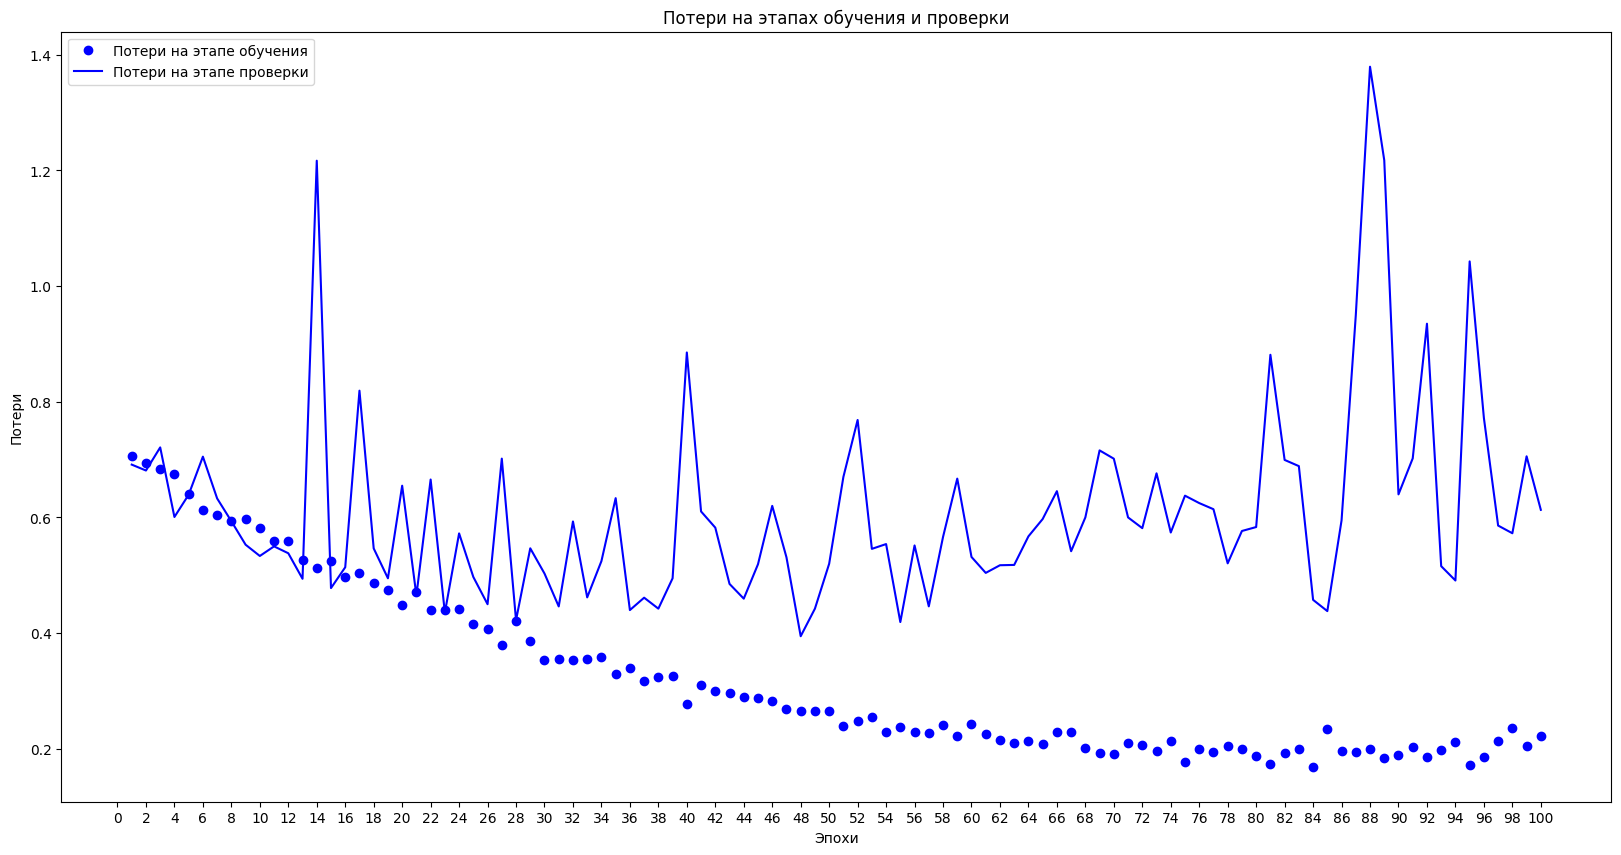

In [78]:
plt.figure(figsize=(20, 10))
plot_loss(history)

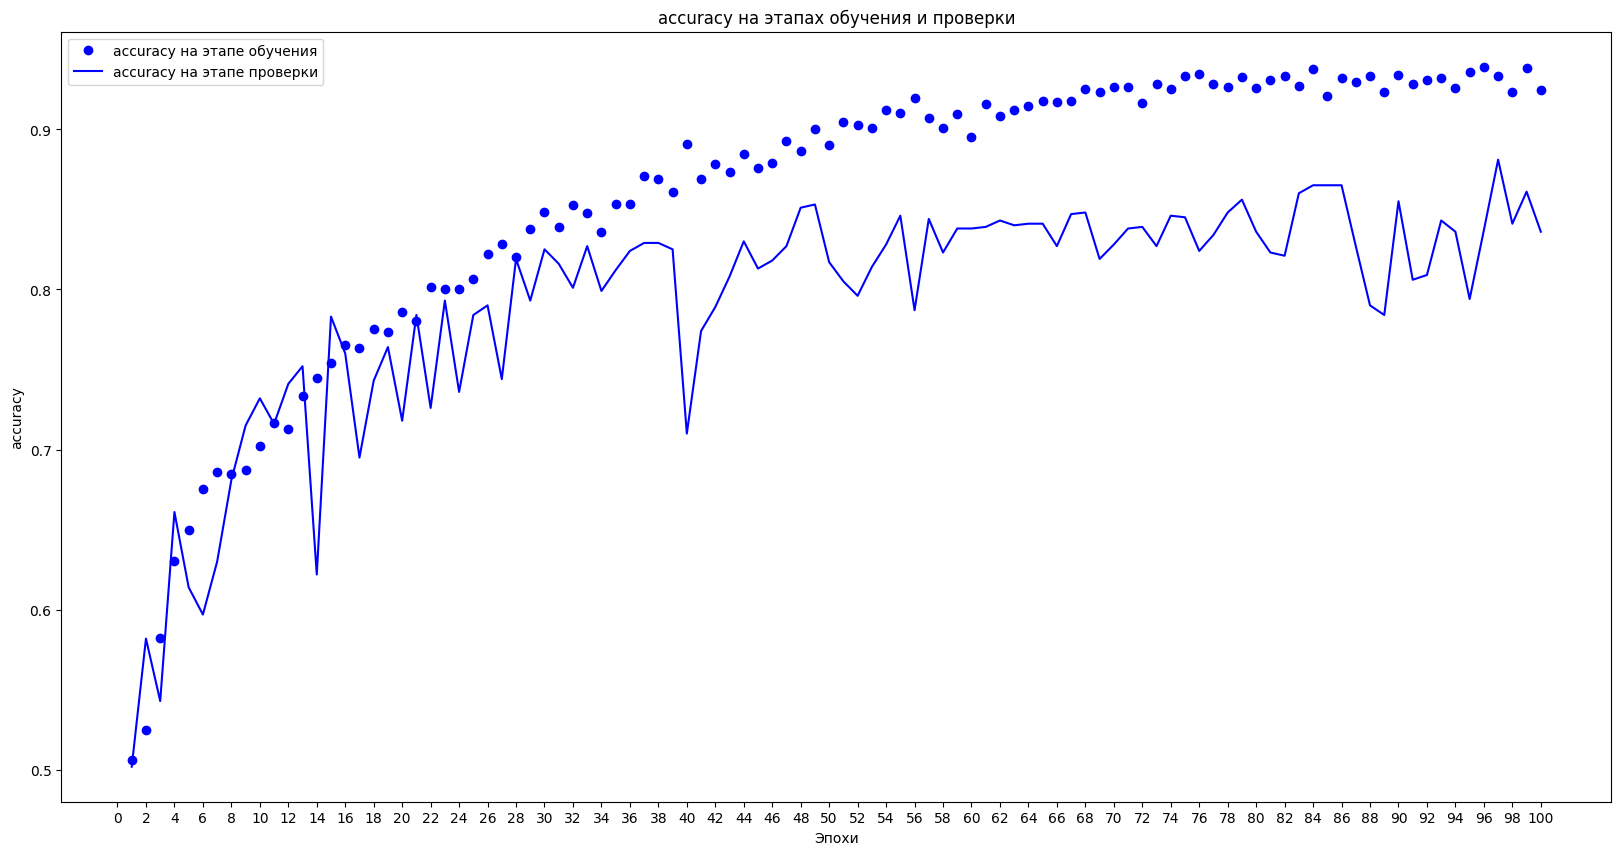

In [79]:
plt.figure(figsize=(20, 10))
plot_metric(history, "accuracy", "accuracy")

## Предварительно обученная модель

### Выделение признаков

In [80]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(180, 180, 3)
)

In [81]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Быстрое выделение признаков без обогащения данных

In [82]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [83]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 13ms/step


In [84]:
train_features.shape

(2000, 5, 5, 512)

In [85]:
inputs = layers.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/features_exctraction.x",
        save_best_only=True,
        monitor="val_loss",
    )
]

history = model.fit(
    train_features,
    train_labels,
    epochs=50,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
)

Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 21.3935 - accuracy: 0.9140INFO:tensorflow:Assets written to: models/features_exctraction.x/assets


INFO:tensorflow:Assets written to: models/features_exctraction.x/assets


63/63 [==============================] - 2s 18ms/step - loss: 21.3935 - accuracy: 0.9140 - val_loss: 4.3037 - val_accuracy: 0.9660
Epoch 2/50
63/63 [==============================] - 0s 8ms/step - loss: 3.0854 - accuracy: 0.9775 - val_loss: 10.6013 - val_accuracy: 0.9480
Epoch 3/50
63/63 [==============================] - 0s 7ms/step - loss: 3.1581 - accuracy: 0.9790 - val_loss: 5.4745 - val_accuracy: 0.9660
Epoch 4/50
56/63 [=========================>....] - ETA: 0s - loss: 1.4045 - accuracy: 0.9883INFO:tensorflow:Assets written to: models/features_exctraction.x/assets


INFO:tensorflow:Assets written to: models/features_exctraction.x/assets


63/63 [==============================] - 1s 10ms/step - loss: 1.4077 - accuracy: 0.9870 - val_loss: 2.3481 - val_accuracy: 0.9820
Epoch 5/50
63/63 [==============================] - 0s 7ms/step - loss: 1.4679 - accuracy: 0.9925 - val_loss: 3.6971 - val_accuracy: 0.9790
Epoch 6/50
63/63 [==============================] - 0s 7ms/step - loss: 0.9494 - accuracy: 0.9910 - val_loss: 2.7546 - val_accuracy: 0.9810
Epoch 7/50
63/63 [==============================] - 0s 7ms/step - loss: 0.4719 - accuracy: 0.9940 - val_loss: 2.7767 - val_accuracy: 0.9810
Epoch 8/50
63/63 [==============================] - 0s 7ms/step - loss: 0.3226 - accuracy: 0.9970 - val_loss: 5.2395 - val_accuracy: 0.9700
Epoch 9/50
63/63 [==============================] - 0s 7ms/step - loss: 0.2134 - accuracy: 0.9970 - val_loss: 5.2964 - val_accuracy: 0.9760
Epoch 10/50
63/63 [==============================] - 0s 7ms/step - loss: 0.1713 - accuracy: 0.9980 - val_loss: 5.1084 - val_accuracy: 0.9760
Epoch 11/50
63/63 [==========

In [86]:
test_model = keras.models.load_model("models/features_exctraction.x")
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 4ms/step - loss: 5.4799 - accuracy: 0.9730
Test accuracy: 0.973


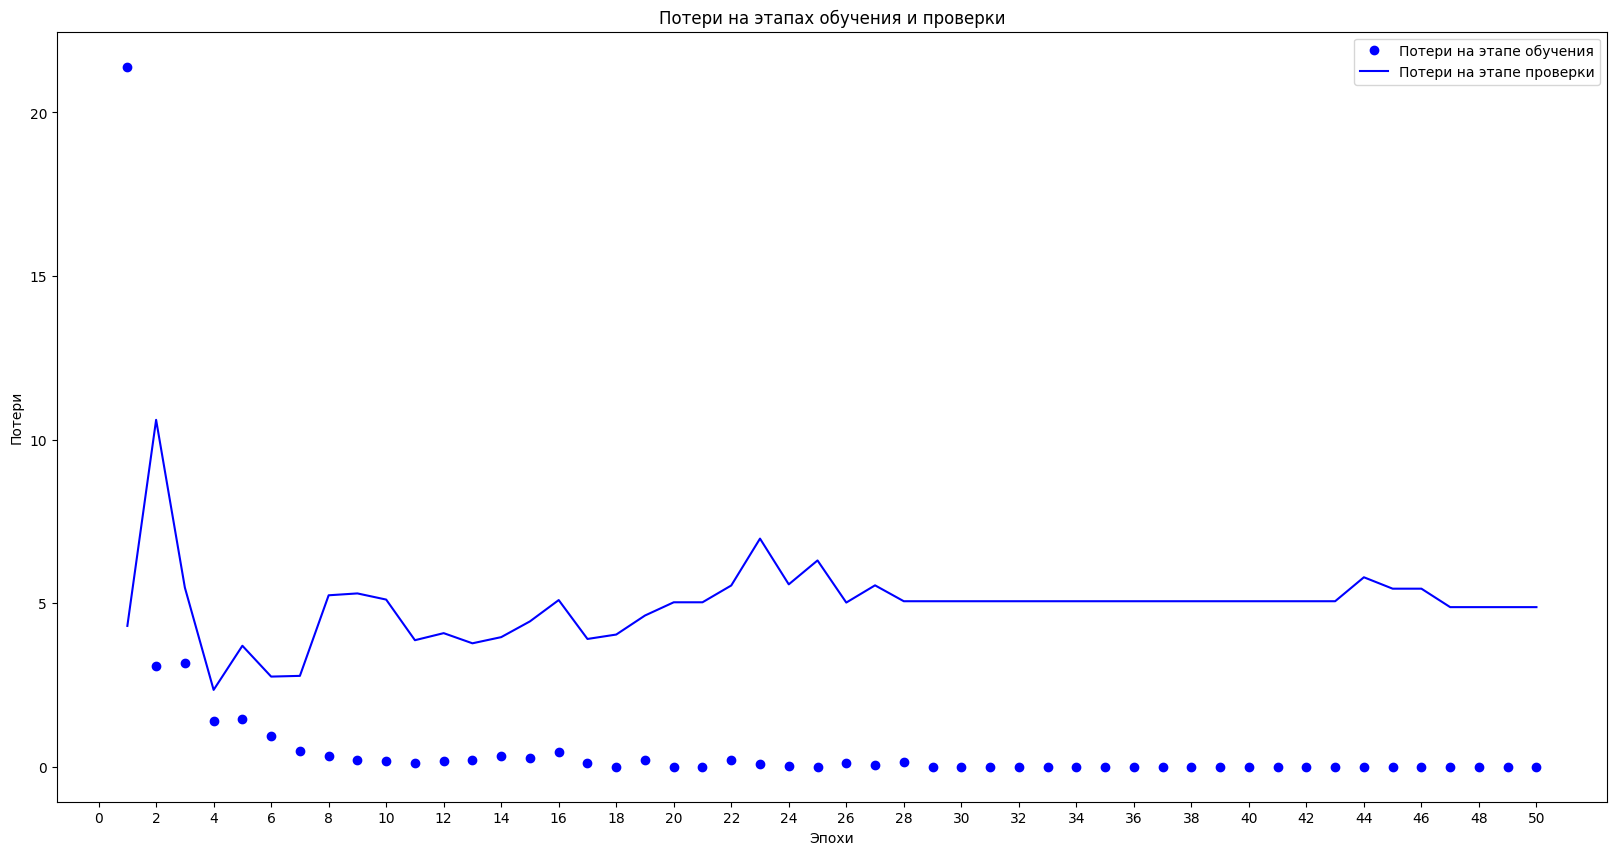

In [87]:
plt.figure(figsize=(20, 10))
plot_loss(history)

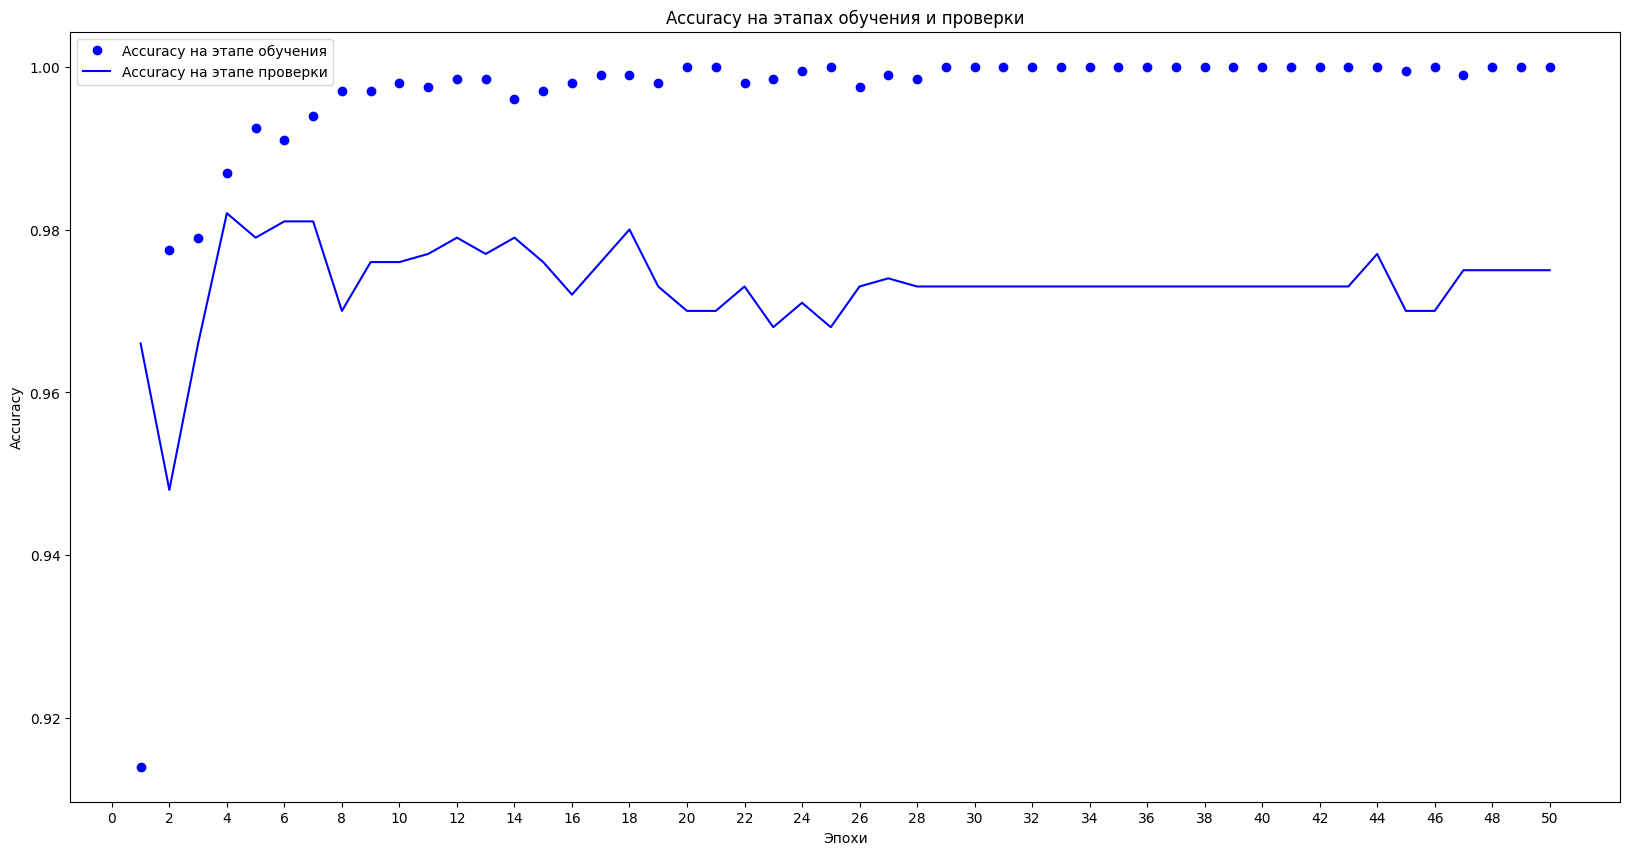

In [88]:
plt.figure(figsize=(20, 10))
plot_metric(history, "accuracy", "Accuracy")

#### Выделение признаков с обогащением данных

##### Заморозка предобученного ядра сети

In [89]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)

In [90]:
conv_base.trainable = True
print("Веса до заморозки:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("Веса после заморозки:", len(conv_base.trainable_weights))

Веса до заморозки: 26
Веса после заморозки: 0


##### Создание модели
1. Этап обогащения данных.
2. Замороженную сверточную основу.
3. Полносвязный классификатор.

In [91]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


def preprocess_input(imgs):
    # custom vgg16 preprocessing input, can be saved on Apple Silicon
    return tf.reverse(imgs, axis=[-1]) - tf.constant(
        [103.939, 116.779, 123.68], dtype=tf.float32
    )


inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.layers.Lambda(lambda x: keras.applications.vgg16.preprocess_input(x))(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [92]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_7 (Flatten)         (None, 12800)             0         
                                                                 
 dense_11 (Dense)            (None, 256)               3277056   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0   

In [93]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/feature_extraction_with_data_augmentation.x",
        save_best_only=True,
        monitor="val_loss",
    )
]

history = model.fit(
    train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callbacks
)

Epoch 1/50


2024-04-23 12:25:27.990650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 11s - loss: 153.7969 - accuracy: 0.5000

2024-04-23 12:25:28.810419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:28.967667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 135.4546 - accuracy: 0.6062

2024-04-23 12:25:29.043763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:29.123959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:29.207868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 90.3743 - accuracy: 0.7188

2024-04-23 12:25:29.290787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:29.388324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:29.466642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 4s - loss: 67.5513 - accuracy: 0.7727

2024-04-23 12:25:29.549620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:29.627570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:29.704167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 56.5809 - accuracy: 0.7902

2024-04-23 12:25:29.783438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:29.859203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:29.935297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 50.4339 - accuracy: 0.8107

2024-04-23 12:25:30.013454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:30.093358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:30.169532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 45.5516 - accuracy: 0.8219

2024-04-23 12:25:30.245121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:30.321737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:30.396971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 40.6070 - accuracy: 0.8397

2024-04-23 12:25:30.474038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:30.550883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:30.627555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 36.4326 - accuracy: 0.8510

2024-04-23 12:25:30.705452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:30.781160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:30.856986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 33.3835 - accuracy: 0.8599

2024-04-23 12:25:30.934448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:31.012271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:31.089128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 31.2209 - accuracy: 0.8662

2024-04-23 12:25:31.168132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:31.246076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:31.321785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 28.9977 - accuracy: 0.8714

2024-04-23 12:25:31.400273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:31.477804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:31.552841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 27.9381 - accuracy: 0.8734

2024-04-23 12:25:31.627042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:31.702910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:31.777990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 26.6981 - accuracy: 0.8765

2024-04-23 12:25:31.855697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:31.933480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:32.016723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 25.6986 - accuracy: 0.8814

2024-04-23 12:25:32.096801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:32.176986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:32.257832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 25.1793 - accuracy: 0.8810

2024-04-23 12:25:32.338590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:32.416306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:32.493927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 24.3081 - accuracy: 0.8838

2024-04-23 12:25:32.569974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:32.645651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:32.720865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 23.6224 - accuracy: 0.8862

2024-04-23 12:25:32.796201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:32.871538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:32.945953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 22.9643 - accuracy: 0.8884

2024-04-23 12:25:33.018127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:33.093148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:33.167908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 22.0377 - accuracy: 0.8909

2024-04-23 12:25:33.242767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:33.317738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:33.394636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 21.5853 - accuracy: 0.8926

2024-04-23 12:25:33.467041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:33.542217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:33.615823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 21.5592 - accuracy: 0.8930INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 10s 134ms/step - loss: 21.5592 - accuracy: 0.8930 - val_loss: 5.1787 - val_accuracy: 0.9710
Epoch 2/50
 1/63 [..............................] - ETA: 9s - loss: 1.0205 - accuracy: 0.9688

2024-04-23 12:25:37.084223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:37.233917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 3.7751 - accuracy: 0.9453

2024-04-23 12:25:37.308675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:37.382920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:37.455756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 6.9014 - accuracy: 0.9464

2024-04-23 12:25:37.530341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:37.605730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:37.679374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 3s - loss: 6.1886 - accuracy: 0.9500

2024-04-23 12:25:37.753408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:37.827484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:37.901525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 5.7972 - accuracy: 0.9519

2024-04-23 12:25:37.977856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:38.054822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:38.128656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 6.9264 - accuracy: 0.9512

2024-04-23 12:25:38.205952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:38.279430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:38.356875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 7.8331 - accuracy: 0.9408

2024-04-23 12:25:38.433452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:38.507541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:38.585315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 7.5223 - accuracy: 0.9446

2024-04-23 12:25:38.661455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:38.734841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:38.810154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 7.3177 - accuracy: 0.9450

2024-04-23 12:25:38.884595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:38.958997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:39.034819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 7.8030 - accuracy: 0.9397

2024-04-23 12:25:39.107883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:39.182897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:39.257265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 7.6933 - accuracy: 0.9415

2024-04-23 12:25:39.331287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:39.406583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:39.481585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 7.7508 - accuracy: 0.9412

2024-04-23 12:25:39.556606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:39.632343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:39.707820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 7.4358 - accuracy: 0.9443

2024-04-23 12:25:39.781425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:39.858311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:39.937193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 7.5569 - accuracy: 0.9430

2024-04-23 12:25:40.010072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:40.083978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:40.158521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 8.5848 - accuracy: 0.9397

2024-04-23 12:25:40.232612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:40.307687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:40.381326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 8.2760 - accuracy: 0.9409

2024-04-23 12:25:40.459802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:40.531818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:40.608184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 8.1362 - accuracy: 0.9426

2024-04-23 12:25:40.683511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:40.759764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:40.842887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 7.8357 - accuracy: 0.9435

2024-04-23 12:25:40.918178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:40.992310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:41.066758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 7.8305 - accuracy: 0.9426

2024-04-23 12:25:41.140105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:41.216762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:41.292030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 8.2518 - accuracy: 0.9407

2024-04-23 12:25:41.373998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:41.446419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:41.518348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 8.6126 - accuracy: 0.9380

2024-04-23 12:25:41.590692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:41.665448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:41.740175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 8.7808 - accuracy: 0.9375

2024-04-23 12:25:41.814830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 8s 125ms/step - loss: 8.7106 - accuracy: 0.9380 - val_loss: 4.5662 - val_accuracy: 0.9720
Epoch 3/50
 1/63 [..............................] - ETA: 10s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:25:45.005716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:45.141880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 4s - loss: 3.5713 - accuracy: 0.9792    

2024-04-23 12:25:45.222021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:45.297339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 7.1143 - accuracy: 0.9766

2024-04-23 12:25:45.372214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 5.4174 - accuracy: 0.9792

2024-04-23 12:25:45.447192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:45.521531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 6.3979 - accuracy: 0.9688

2024-04-23 12:25:45.594925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 8.1380 - accuracy: 0.9514

2024-04-23 12:25:45.669558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:45.743113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 3s - loss: 7.3242 - accuracy: 0.9563

2024-04-23 12:25:45.817017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 3s - loss: 7.2688 - accuracy: 0.9557

2024-04-23 12:25:45.890766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:45.966101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 7.1216 - accuracy: 0.9567

2024-04-23 12:25:46.041399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 3s - loss: 6.9386 - accuracy: 0.9563

2024-04-23 12:25:46.116791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:46.190404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 6.6094 - accuracy: 0.9570

2024-04-23 12:25:46.264815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 5.9893 - accuracy: 0.9583

2024-04-23 12:25:46.338491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:46.413779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 5.8698 - accuracy: 0.9556

2024-04-23 12:25:46.488251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 5.3108 - accuracy: 0.9598

2024-04-23 12:25:46.561753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:46.637121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 5.3434 - accuracy: 0.9574

2024-04-23 12:25:46.711460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 2s - loss: 5.7780 - accuracy: 0.9557

2024-04-23 12:25:46.784405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:46.859280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 5.9688 - accuracy: 0.9563

2024-04-23 12:25:46.933730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 2s - loss: 6.0548 - accuracy: 0.9560

2024-04-23 12:25:47.008189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:47.083137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 5.8825 - accuracy: 0.9565

2024-04-23 12:25:47.156222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 5.8368 - accuracy: 0.9573

2024-04-23 12:25:47.229862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:47.304489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 5.8815 - accuracy: 0.9567

2024-04-23 12:25:47.379036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 6.1037 - accuracy: 0.9555

2024-04-23 12:25:47.453909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:47.529095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 6.0112 - accuracy: 0.9559

2024-04-23 12:25:47.605042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 6.5048 - accuracy: 0.9523

2024-04-23 12:25:47.681828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:47.755092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 6.4140 - accuracy: 0.9527

2024-04-23 12:25:47.829542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1s - loss: 6.1778 - accuracy: 0.9535

2024-04-23 12:25:47.903907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:47.980553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 6.0234 - accuracy: 0.9547

2024-04-23 12:25:48.055275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 6.0534 - accuracy: 0.9554

2024-04-23 12:25:48.131216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:48.205570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 6.0885 - accuracy: 0.9549

2024-04-23 12:25:48.281050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 6.1658 - accuracy: 0.9549

2024-04-23 12:25:48.357087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:48.432924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 6.0317 - accuracy: 0.9558

2024-04-23 12:25:48.508946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 6.2142 - accuracy: 0.9538

2024-04-23 12:25:48.584885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:48.659915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 6.1207 - accuracy: 0.9541

2024-04-23 12:25:48.735350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 6.3144 - accuracy: 0.9534

2024-04-23 12:25:48.808338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:48.883295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 6.7759 - accuracy: 0.9513

2024-04-23 12:25:48.958761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 6.7490 - accuracy: 0.9502

2024-04-23 12:25:49.033790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:49.110100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 6.6470 - accuracy: 0.9500

2024-04-23 12:25:49.184800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 6.9234 - accuracy: 0.9485

2024-04-23 12:25:49.260041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:49.334436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 7.0093 - accuracy: 0.9477

2024-04-23 12:25:49.409324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 6.9311 - accuracy: 0.9479

2024-04-23 12:25:49.483855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:49.557957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 6.8175 - accuracy: 0.9488

2024-04-23 12:25:49.630569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 6.7619 - accuracy: 0.9495

2024-04-23 12:25:49.703036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 7s 117ms/step - loss: 6.7619 - accuracy: 0.9495 - val_loss: 3.5826 - val_accuracy: 0.9760
Epoch 4/50
 1/63 [..............................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:25:52.417815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:52.557455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 1.3987 - accuracy: 0.9766

2024-04-23 12:25:52.631307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:52.705331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:52.779259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 4.5454 - accuracy: 0.9688

2024-04-23 12:25:52.853678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:52.928131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:53.003039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 3s - loss: 6.8160 - accuracy: 0.9563

2024-04-23 12:25:53.078910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:53.152513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:53.229551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 6.8928 - accuracy: 0.9567

2024-04-23 12:25:53.303090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:53.377052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:53.450452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 5.8092 - accuracy: 0.9609

2024-04-23 12:25:53.525582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:53.598205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:53.671950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 5.3854 - accuracy: 0.9622

2024-04-23 12:25:53.746630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:53.825875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:53.900288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 4.9374 - accuracy: 0.9645

2024-04-23 12:25:53.974830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:54.049013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:54.126646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 4.8605 - accuracy: 0.9638

2024-04-23 12:25:54.200975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:54.274815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:54.348401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 5.1987 - accuracy: 0.9643

2024-04-23 12:25:54.422301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:54.495932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:54.570474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 4.9781 - accuracy: 0.9637

2024-04-23 12:25:54.647413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:54.720659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:54.794955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 6.4129 - accuracy: 0.9614

2024-04-23 12:25:54.869949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:54.942201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:55.017019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 5.9776 - accuracy: 0.9637

2024-04-23 12:25:55.090990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:55.167233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:55.246992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 5.8987 - accuracy: 0.9641

2024-04-23 12:25:55.328162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:55.404437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:55.481616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 5.6601 - accuracy: 0.9651

2024-04-23 12:25:55.556259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:55.636446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:55.710609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 5.4585 - accuracy: 0.9660

2024-04-23 12:25:55.785053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:55.863351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:55.938922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 5.4844 - accuracy: 0.9656

2024-04-23 12:25:56.014153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:56.088526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:56.161948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 5.3599 - accuracy: 0.9663

2024-04-23 12:25:56.234635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:56.309955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:56.383187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 5.1682 - accuracy: 0.9670

2024-04-23 12:25:56.457942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:56.533961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:56.608954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 5.1779 - accuracy: 0.9671

2024-04-23 12:25:56.684606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:56.760187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:56.834953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 4.9428 - accuracy: 0.9672

2024-04-23 12:25:56.907306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:56.983506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:57.057547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 4.9163 - accuracy: 0.9667

2024-04-23 12:25:57.128297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 7s 117ms/step - loss: 4.8770 - accuracy: 0.9670 - val_loss: 3.2116 - val_accuracy: 0.9760
Epoch 5/50
 1/63 [..............................] - ETA: 8s - loss: 3.7962 - accuracy: 0.9375

2024-04-23 12:25:59.830077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:25:59.970792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 4.1657 - accuracy: 0.9375

2024-04-23 12:26:00.044874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:00.120427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:00.196876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 2.7374 - accuracy: 0.9554

2024-04-23 12:26:00.271276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:00.350056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:00.425242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 2.2904 - accuracy: 0.9625

2024-04-23 12:26:00.499707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:00.575561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:00.650334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 2.5383 - accuracy: 0.9663

2024-04-23 12:26:00.723128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:00.798932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:00.873092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 2.9100 - accuracy: 0.9668

2024-04-23 12:26:00.948026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:01.025223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:01.100226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 2.4869 - accuracy: 0.9688

2024-04-23 12:26:01.176416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:01.255894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:01.329873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 2.2791 - accuracy: 0.9716

2024-04-23 12:26:01.404882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:01.480486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:01.554912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 2.5011 - accuracy: 0.9725

2024-04-23 12:26:01.628688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:01.702514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:01.779079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 2.3652 - accuracy: 0.9721

2024-04-23 12:26:01.855881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:01.928064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:02.003175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 2.2660 - accuracy: 0.9718

2024-04-23 12:26:02.079067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:02.153241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:02.227494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 2.2499 - accuracy: 0.9697

2024-04-23 12:26:02.304469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:02.379477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:02.452949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 2.4434 - accuracy: 0.9696

2024-04-23 12:26:02.526501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:02.600205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:02.675283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 2.6679 - accuracy: 0.9695

2024-04-23 12:26:02.751522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:02.826648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:02.903573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 2.5360 - accuracy: 0.9695

2024-04-23 12:26:02.978412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:03.054696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:03.129617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 3.0008 - accuracy: 0.9667

2024-04-23 12:26:03.206270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:03.282706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:03.356380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 2.9173 - accuracy: 0.9668

2024-04-23 12:26:03.432533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:03.510930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:03.586762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 2.7560 - accuracy: 0.9675

2024-04-23 12:26:03.660449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:03.733637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:03.807453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 2.7162 - accuracy: 0.9682

2024-04-23 12:26:03.880952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:03.952572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:04.025315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 2.8825 - accuracy: 0.9677

2024-04-23 12:26:04.096772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:04.168730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:04.241421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 3.2122 - accuracy: 0.9652

2024-04-23 12:26:04.314637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:04.388315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:04.461107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 3.3571 - accuracy: 0.9642

2024-04-23 12:26:04.535059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 8s 121ms/step - loss: 3.3393 - accuracy: 0.9640 - val_loss: 2.7231 - val_accuracy: 0.9750
Epoch 6/50
 1/63 [..............................] - ETA: 9s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:26:07.507484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:07.629390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 4s - loss: 0.3072 - accuracy: 0.9844    

2024-04-23 12:26:07.703861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.8096 - accuracy: 0.9844

2024-04-23 12:26:07.781323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:07.858041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.7616 - accuracy: 0.9812

2024-04-23 12:26:07.937073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5440 - accuracy: 0.9866

2024-04-23 12:26:08.013576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:08.089530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.4760 - accuracy: 0.9883

2024-04-23 12:26:08.165278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 4.2520 - accuracy: 0.9719

2024-04-23 12:26:08.240282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:08.316923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 4.1907 - accuracy: 0.9716

2024-04-23 12:26:08.391311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 3.7925 - accuracy: 0.9736

2024-04-23 12:26:08.466220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:08.541849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 3.8811 - accuracy: 0.9710

2024-04-23 12:26:08.617674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 3.3960 - accuracy: 0.9746

2024-04-23 12:26:08.695012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:08.770765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 3.6215 - accuracy: 0.9724

2024-04-23 12:26:08.844231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 3.6152 - accuracy: 0.9704

2024-04-23 12:26:08.917947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:08.994581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 3.6849 - accuracy: 0.9703

2024-04-23 12:26:09.069768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 3.6591 - accuracy: 0.9688

2024-04-23 12:26:09.144947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:09.220887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 3.6491 - accuracy: 0.9688

2024-04-23 12:26:09.296290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 3.6325 - accuracy: 0.9688

2024-04-23 12:26:09.371675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:09.446605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 3.8162 - accuracy: 0.9688

2024-04-23 12:26:09.521996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 3.8736 - accuracy: 0.9676

2024-04-23 12:26:09.596641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:09.671651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 3.7401 - accuracy: 0.9688

2024-04-23 12:26:09.747493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 3.8542 - accuracy: 0.9667

2024-04-23 12:26:09.823729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:09.898907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 4.0469 - accuracy: 0.9658

2024-04-23 12:26:09.977138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 3.8413 - accuracy: 0.9660

2024-04-23 12:26:10.052226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:10.126171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 3.7394 - accuracy: 0.9661

2024-04-23 12:26:10.203990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 3.6436 - accuracy: 0.9671

2024-04-23 12:26:10.279341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:10.354464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 3.5477 - accuracy: 0.9679

2024-04-23 12:26:10.429746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 3.5127 - accuracy: 0.9672

2024-04-23 12:26:10.505269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:10.580575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 3.5291 - accuracy: 0.9657

2024-04-23 12:26:10.657792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 3.5255 - accuracy: 0.9651

2024-04-23 12:26:10.732354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:10.807054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 3.6420 - accuracy: 0.9645

2024-04-23 12:26:10.882336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 3.4836 - accuracy: 0.9660

2024-04-23 12:26:10.958247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:11.035171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 3.4824 - accuracy: 0.9661

2024-04-23 12:26:11.110457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 3.4688 - accuracy: 0.9649

2024-04-23 12:26:11.185629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:11.260328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 3.3995 - accuracy: 0.9656

2024-04-23 12:26:11.334895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 3.2687 - accuracy: 0.9669

2024-04-23 12:26:11.410339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:11.484286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 3.2896 - accuracy: 0.9670

2024-04-23 12:26:11.559359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 3.2487 - accuracy: 0.9676

2024-04-23 12:26:11.633548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:11.707471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 3.1906 - accuracy: 0.9682

2024-04-23 12:26:11.780433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 3.1037 - accuracy: 0.9688

2024-04-23 12:26:11.854092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:11.928716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 3.1458 - accuracy: 0.9677

2024-04-23 12:26:12.001593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 3.0591 - accuracy: 0.9682

2024-04-23 12:26:12.077770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:12.153284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 3.0509 - accuracy: 0.9682

2024-04-23 12:26:12.225922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 7s 118ms/step - loss: 3.0265 - accuracy: 0.9685 - val_loss: 2.1661 - val_accuracy: 0.9790
Epoch 7/50
 1/63 [..............................] - ETA: 7s - loss: 5.2864 - accuracy: 0.9688

2024-04-23 12:26:14.930005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:15.057253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 2.4375 - accuracy: 0.9688

2024-04-23 12:26:15.133832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:15.208559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:15.284414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 1.9182 - accuracy: 0.9777

2024-04-23 12:26:15.359840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:15.436647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:15.512942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 3.5021 - accuracy: 0.9781

2024-04-23 12:26:15.588902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:15.665218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:15.738890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 2.9353 - accuracy: 0.9784

2024-04-23 12:26:15.814061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:15.891168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:15.966182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 2.8220 - accuracy: 0.9727

2024-04-23 12:26:16.042274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:16.118281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:16.192715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 2.5892 - accuracy: 0.9720

2024-04-23 12:26:16.268041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:16.345674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:16.420361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 2.7637 - accuracy: 0.9702

2024-04-23 12:26:16.496596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:16.571925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:16.647091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 2.5185 - accuracy: 0.9725

2024-04-23 12:26:16.722394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:16.799368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:16.872861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 2.4471 - accuracy: 0.9732

2024-04-23 12:26:16.947352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:17.023266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:17.099049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 2.4085 - accuracy: 0.9728

2024-04-23 12:26:17.175691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:17.255482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:17.330183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 2.6280 - accuracy: 0.9697

2024-04-23 12:26:17.408898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:17.486931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:17.563449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 2.7904 - accuracy: 0.9679

2024-04-23 12:26:17.638127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:17.714337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:17.790036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 2.7062 - accuracy: 0.9672

2024-04-23 12:26:17.868953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:17.945049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:18.021013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 2.5426 - accuracy: 0.9688

2024-04-23 12:26:18.096985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:18.171966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:18.247091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 2.4427 - accuracy: 0.9694

2024-04-23 12:26:18.323918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:18.400816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:18.478437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 2.4385 - accuracy: 0.9694

2024-04-23 12:26:18.553804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:18.628674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:18.702752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 2.3266 - accuracy: 0.9694

2024-04-23 12:26:18.776943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:18.853073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:18.929275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 2.2353 - accuracy: 0.9705

2024-04-23 12:26:19.004364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:19.076570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:19.150411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 2.2879 - accuracy: 0.9709

2024-04-23 12:26:19.224916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:19.298969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:19.373308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 2.2047 - accuracy: 0.9713

2024-04-23 12:26:19.446557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:19.522233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:19.596104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 2.2304 - accuracy: 0.9708

2024-04-23 12:26:19.670503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 2.2125 - accuracy: 0.9710 - val_loss: 2.3428 - val_accuracy: 0.9770
Epoch 8/50
 2/63 [..............................] - ETA: 4s - loss: 2.8296 - accuracy: 0.9688

2024-04-23 12:26:21.457695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:21.580208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:21.657448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 4.4329 - accuracy: 0.9438

2024-04-23 12:26:21.735449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:21.811171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:21.887464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 3.5918 - accuracy: 0.9492

2024-04-23 12:26:21.962585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:22.040493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:22.118504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 4s - loss: 3.1455 - accuracy: 0.9517

2024-04-23 12:26:22.194473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:22.271984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:22.349972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 2.8517 - accuracy: 0.9576

2024-04-23 12:26:22.430658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:22.515639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:22.591734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 2.7151 - accuracy: 0.9596

2024-04-23 12:26:22.670020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:22.748365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:22.823695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 2.7231 - accuracy: 0.9609

2024-04-23 12:26:22.900767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:22.976127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:23.052946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 2.5544 - accuracy: 0.9620

2024-04-23 12:26:23.126521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:23.203229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:23.279178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 2.3837 - accuracy: 0.9639

2024-04-23 12:26:23.355328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:23.430889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:23.506358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 2.4197 - accuracy: 0.9634

2024-04-23 12:26:23.581437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:23.656247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:23.732691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 2.1929 - accuracy: 0.9668

2024-04-23 12:26:23.807809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:23.882704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:23.957835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 2.5375 - accuracy: 0.9652

2024-04-23 12:26:24.032744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:24.108997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:24.186081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 2.3371 - accuracy: 0.9679

2024-04-23 12:26:24.262868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:24.337120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:24.411686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 2.1668 - accuracy: 0.9695

2024-04-23 12:26:24.486306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:24.562566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:24.638422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 2.1671 - accuracy: 0.9702

2024-04-23 12:26:24.715465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:24.790239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:24.865108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 2.4739 - accuracy: 0.9674

2024-04-23 12:26:24.940289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:25.017503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:25.092616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 2.3289 - accuracy: 0.9688

2024-04-23 12:26:25.170210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:25.245390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:25.321730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 2.4633 - accuracy: 0.9676

2024-04-23 12:26:25.397385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:25.472365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:25.547521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 2.3883 - accuracy: 0.9682

2024-04-23 12:26:25.623375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:25.695293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:25.767779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 2.3403 - accuracy: 0.9693

2024-04-23 12:26:25.841260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:25.914297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:25.986709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 2.2556 - accuracy: 0.9700

2024-04-23 12:26:26.061086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:26.135701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:26.209236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 8s 122ms/step - loss: 2.2556 - accuracy: 0.9700 - val_loss: 1.9926 - val_accuracy: 0.9780
Epoch 9/50
 1/63 [..............................] - ETA: 8s - loss: 2.5731 - accuracy: 0.9688

2024-04-23 12:26:29.139470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:29.281370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 2.0741 - accuracy: 0.9844

2024-04-23 12:26:29.360727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:29.440032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:29.516893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 1.7492 - accuracy: 0.9688

2024-04-23 12:26:29.591300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:29.669261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:29.744392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 1.5385 - accuracy: 0.9719

2024-04-23 12:26:29.820217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:29.901192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:29.976715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 1.3682 - accuracy: 0.9760

2024-04-23 12:26:30.050893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:30.129732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:30.204551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 2.2796 - accuracy: 0.9688

2024-04-23 12:26:30.280660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:30.357595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:30.432938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 1.9197 - accuracy: 0.9737

2024-04-23 12:26:30.507698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:30.583504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:30.658562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 1.6579 - accuracy: 0.9773

2024-04-23 12:26:30.733368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:30.809680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:30.884099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 1.6031 - accuracy: 0.9787

2024-04-23 12:26:30.959488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:31.036459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:31.112215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 1.6479 - accuracy: 0.9766

2024-04-23 12:26:31.191046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:31.269241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:31.343253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 1.5012 - accuracy: 0.9778

2024-04-23 12:26:31.417547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:31.491764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:31.568716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 1.6751 - accuracy: 0.9752

2024-04-23 12:26:31.649808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:31.728974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:31.808846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 2.2791 - accuracy: 0.9721

2024-04-23 12:26:31.884909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:31.962684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:32.039712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 2.1519 - accuracy: 0.9719

2024-04-23 12:26:32.119104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:32.197440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:32.275444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 2.1653 - accuracy: 0.9717

2024-04-23 12:26:32.353981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:32.429901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:32.505630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 2.3314 - accuracy: 0.9708

2024-04-23 12:26:32.582983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:32.661739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:32.739365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 2.2654 - accuracy: 0.9707

2024-04-23 12:26:32.814621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:32.893217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:32.972539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 2.3016 - accuracy: 0.9700

2024-04-23 12:26:33.047692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:33.124296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:33.199129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 2.2481 - accuracy: 0.9693

2024-04-23 12:26:33.273905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:33.347173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:33.420234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 2.1994 - accuracy: 0.9704

2024-04-23 12:26:33.497304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:33.569662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:33.643012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 2.1435 - accuracy: 0.9698

2024-04-23 12:26:33.717833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:33.790442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:33.863487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 2.1090 - accuracy: 0.9703

2024-04-23 12:26:33.937486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 8s 119ms/step - loss: 2.0921 - accuracy: 0.9705 - val_loss: 1.8748 - val_accuracy: 0.9820
Epoch 10/50
 1/63 [..............................] - ETA: 7s - loss: 5.0405 - accuracy: 0.9688

2024-04-23 12:26:36.655288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:36.792865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 1.3381 - accuracy: 0.9844

2024-04-23 12:26:36.867368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:36.942864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:37.020045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 1.0909 - accuracy: 0.9866

2024-04-23 12:26:37.096082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:37.171978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:37.246430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.7656 - accuracy: 0.9906

2024-04-23 12:26:37.322167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:37.402997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:37.479470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.7756 - accuracy: 0.9880

2024-04-23 12:26:37.553894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:37.629065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:37.704206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.6313 - accuracy: 0.9902

2024-04-23 12:26:37.781079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:37.858312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:37.931698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5416 - accuracy: 0.9901

2024-04-23 12:26:38.007686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:38.084246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:38.159419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.6516 - accuracy: 0.9886

2024-04-23 12:26:38.236916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:38.317144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:38.393343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.6441 - accuracy: 0.9875

2024-04-23 12:26:38.473119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:38.549045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:38.625580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.7386 - accuracy: 0.9844

2024-04-23 12:26:38.700932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:38.777612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:38.853588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.6842 - accuracy: 0.9849

2024-04-23 12:26:38.928619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:39.005780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:39.082000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.8576 - accuracy: 0.9835

2024-04-23 12:26:39.159050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:39.236140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:39.314862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.7881 - accuracy: 0.9848

2024-04-23 12:26:39.398035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:39.474764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:39.551151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.7573 - accuracy: 0.9844

2024-04-23 12:26:39.626502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:39.703753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:39.780199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.7145 - accuracy: 0.9847

2024-04-23 12:26:39.854488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:39.931388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:40.006084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.9758 - accuracy: 0.9823

2024-04-23 12:26:40.086064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:40.163713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:40.239513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.9400 - accuracy: 0.9815

2024-04-23 12:26:40.316561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:40.392901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:40.467675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 1.0664 - accuracy: 0.9808

2024-04-23 12:26:40.543611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:40.618067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:40.692589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 1.0839 - accuracy: 0.9807

2024-04-23 12:26:40.767549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:40.843458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:40.915319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 1.2048 - accuracy: 0.9784

2024-04-23 12:26:40.988319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:41.064064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:41.138467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.2876 - accuracy: 0.9775

2024-04-23 12:26:41.212192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:41.285404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:41.360386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 1.2668 - accuracy: 0.9778

2024-04-23 12:26:41.433717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 7s 118ms/step - loss: 1.2567 - accuracy: 0.9780 - val_loss: 1.7529 - val_accuracy: 0.9770
Epoch 11/50
 1/63 [..............................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:26:44.115696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:44.250517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 1.4547 - accuracy: 0.9766

2024-04-23 12:26:44.327632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:44.402300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:44.476749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 1.5902 - accuracy: 0.9732

2024-04-23 12:26:44.554581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:44.629989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:44.704354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 3s - loss: 1.1132 - accuracy: 0.9812

2024-04-23 12:26:44.779683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:44.853667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:44.929436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 1.6418 - accuracy: 0.9736

2024-04-23 12:26:45.006394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:45.081994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:45.156677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 2.6015 - accuracy: 0.9688

2024-04-23 12:26:45.233264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:45.307455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:45.382298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 2.1924 - accuracy: 0.9720

2024-04-23 12:26:45.456924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:45.532356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:45.606606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 2.1098 - accuracy: 0.9730

2024-04-23 12:26:45.682480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:45.757607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:45.834841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 2.1123 - accuracy: 0.9725

2024-04-23 12:26:45.909799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:45.983674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:46.058000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 1.9533 - accuracy: 0.9732

2024-04-23 12:26:46.133508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:46.209905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:46.285498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 1.7855 - accuracy: 0.9738

2024-04-23 12:26:46.358242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:46.433276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:46.509171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 1.7323 - accuracy: 0.9724

2024-04-23 12:26:46.583849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:46.659646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:46.733692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 1.6818 - accuracy: 0.9721

2024-04-23 12:26:46.809356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:46.886530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:46.960708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 1.7167 - accuracy: 0.9719

2024-04-23 12:26:47.035801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:47.112909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:47.187609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 1.7010 - accuracy: 0.9709

2024-04-23 12:26:47.262514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:47.337412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:47.411424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 1.6356 - accuracy: 0.9721

2024-04-23 12:26:47.485515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:47.561233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:47.636462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 1.6347 - accuracy: 0.9719

2024-04-23 12:26:47.712667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:47.786024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:47.861060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 1.5453 - accuracy: 0.9730

2024-04-23 12:26:47.936265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:48.013578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:48.086213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 1.4848 - accuracy: 0.9739

2024-04-23 12:26:48.161439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:48.234889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:48.306305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 1.5772 - accuracy: 0.9731

2024-04-23 12:26:48.384463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:48.457828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:48.530032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.6471 - accuracy: 0.9723

2024-04-23 12:26:48.603018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:48.675743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:48.748120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 1.6205 - accuracy: 0.9728

2024-04-23 12:26:48.822566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 7s 117ms/step - loss: 1.6076 - accuracy: 0.9730 - val_loss: 1.1761 - val_accuracy: 0.9820
Epoch 12/50
 1/63 [..............................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:26:51.511613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:51.655948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 1.3974 - accuracy: 0.9688

2024-04-23 12:26:51.730818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:51.807463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:51.884659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 1.3998 - accuracy: 0.9643

2024-04-23 12:26:51.960590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:52.038805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:52.115742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.9799 - accuracy: 0.9750

2024-04-23 12:26:52.188978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:52.268317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:52.343764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 1.9957 - accuracy: 0.9663

2024-04-23 12:26:52.419018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:52.495040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:52.571127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 1.6425 - accuracy: 0.9707

2024-04-23 12:26:52.645738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:52.723601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:52.800872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 1.7977 - accuracy: 0.9671

2024-04-23 12:26:52.875479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:52.950605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:53.026230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 1.5703 - accuracy: 0.9702

2024-04-23 12:26:53.100856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:53.176963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:53.250888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 1.4583 - accuracy: 0.9700

2024-04-23 12:26:53.326272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:53.401158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:53.475800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 1.4076 - accuracy: 0.9710

2024-04-23 12:26:53.550277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:53.627086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:53.702715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 1.3088 - accuracy: 0.9728

2024-04-23 12:26:53.778836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:53.853996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:53.930686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 1.2046 - accuracy: 0.9743

2024-04-23 12:26:54.006126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:54.081791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:54.158609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 1.1163 - accuracy: 0.9755

2024-04-23 12:26:54.234410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:54.309705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:54.384637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 1.0412 - accuracy: 0.9766

2024-04-23 12:26:54.459928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:54.537692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:54.610610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.9838 - accuracy: 0.9775

2024-04-23 12:26:54.689762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:54.765083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:54.839821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.9197 - accuracy: 0.9789

2024-04-23 12:26:54.914951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:54.991878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:55.067840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.8634 - accuracy: 0.9802

2024-04-23 12:26:55.142854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:55.221176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:55.295539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.9275 - accuracy: 0.9796

2024-04-23 12:26:55.371364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:55.446414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:55.525023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 1.0190 - accuracy: 0.9795

2024-04-23 12:26:55.598087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:55.671421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:55.746360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.9909 - accuracy: 0.9795

2024-04-23 12:26:55.820288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:55.891814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:55.968929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.0205 - accuracy: 0.9795

2024-04-23 12:26:56.043586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:56.116675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:56.189477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 1.0421 - accuracy: 0.9793

2024-04-23 12:26:56.261955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 1.0642 - accuracy: 0.9790 - val_loss: 1.9279 - val_accuracy: 0.9720
Epoch 13/50
 1/63 [..............................] - ETA: 8s - loss: 2.0107 - accuracy: 0.9688

2024-04-23 12:26:58.033112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:58.168379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 2.9324 - accuracy: 0.9688

2024-04-23 12:26:58.243378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:58.318354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:58.394847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 2.6833 - accuracy: 0.9732

2024-04-23 12:26:58.470181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:58.547067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:58.621113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 2.1303 - accuracy: 0.9781

2024-04-23 12:26:58.695697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:58.771374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:58.847884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 1.7212 - accuracy: 0.9808

2024-04-23 12:26:58.924671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:58.999098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:59.075727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 1.5881 - accuracy: 0.9805

2024-04-23 12:26:59.152635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:59.228939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:59.305354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 1.7391 - accuracy: 0.9786

2024-04-23 12:26:59.383647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:59.458014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:59.532567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 1.5741 - accuracy: 0.9787

2024-04-23 12:26:59.610262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:59.683436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:59.760051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 1.4878 - accuracy: 0.9775

2024-04-23 12:26:59.835655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:59.909402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:26:59.983615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 1.5145 - accuracy: 0.9766

2024-04-23 12:27:00.058852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:00.133340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:00.208958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 1.4710 - accuracy: 0.9758

2024-04-23 12:27:00.283319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:00.358561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:00.433366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 1.3504 - accuracy: 0.9770

2024-04-23 12:27:00.508436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:00.584443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:00.660731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 1.3086 - accuracy: 0.9780

2024-04-23 12:27:00.737187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:00.813536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:00.887808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 1.2142 - accuracy: 0.9789

2024-04-23 12:27:00.962212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:01.037330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:01.114402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 1.2023 - accuracy: 0.9797

2024-04-23 12:27:01.189564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:01.264852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:01.340320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 1.1852 - accuracy: 0.9796

2024-04-23 12:27:01.414978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:01.491750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:01.570001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 1.1224 - accuracy: 0.9802

2024-04-23 12:27:01.643560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:01.717305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:01.793213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 1.1300 - accuracy: 0.9808

2024-04-23 12:27:01.867978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:01.942974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:02.019454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 1.1136 - accuracy: 0.9807

2024-04-23 12:27:02.096306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:02.170550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:02.242759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 1.1205 - accuracy: 0.9806

2024-04-23 12:27:02.318528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:02.393065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:02.467095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.0654 - accuracy: 0.9816

2024-04-23 12:27:02.539937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:02.616477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:02.692712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.0757 - accuracy: 0.9815

2024-04-23 12:27:02.771784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 1.0757 - accuracy: 0.9815 - val_loss: 1.4873 - val_accuracy: 0.9780
Epoch 14/50
 2/63 [..............................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:27:04.567412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:04.686164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:04.759409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 1.1225 - accuracy: 0.9688  

2024-04-23 12:27:04.834831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:04.909372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:04.985044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 1.0398 - accuracy: 0.9766

2024-04-23 12:27:05.060029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:05.134919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:05.209795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.7562 - accuracy: 0.9830

2024-04-23 12:27:05.284484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:05.359431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:05.433993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.6811 - accuracy: 0.9844

2024-04-23 12:27:05.509639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:05.583915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:05.657410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.7077 - accuracy: 0.9835

2024-04-23 12:27:05.731560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:05.805917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:05.880002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.7104 - accuracy: 0.9828

2024-04-23 12:27:05.954160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:06.029978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:06.103634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 2s - loss: 0.7902 - accuracy: 0.9810

2024-04-23 12:27:06.178865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:06.255265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:06.329085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.8544 - accuracy: 0.9784

2024-04-23 12:27:06.404936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:06.480868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:06.555430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.8236 - accuracy: 0.9784

2024-04-23 12:27:06.629320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:06.704548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:06.779254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.8408 - accuracy: 0.9785

2024-04-23 12:27:06.855124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:06.930118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:07.010841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 1.0913 - accuracy: 0.9750

2024-04-23 12:27:07.084386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:07.160637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:07.234244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 1.0141 - accuracy: 0.9762

2024-04-23 12:27:07.310738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:07.386475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:07.462005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 1.0169 - accuracy: 0.9771

2024-04-23 12:27:07.536693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:07.612573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:07.686192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.9884 - accuracy: 0.9780

2024-04-23 12:27:07.760618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:07.833894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:07.907789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 1.0090 - accuracy: 0.9787

2024-04-23 12:27:07.982836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:08.058459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:08.132763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.9610 - accuracy: 0.9794

2024-04-23 12:27:08.206746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:08.281015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:08.354671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.9066 - accuracy: 0.9805

2024-04-23 12:27:08.429533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:08.504576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:08.579616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.9449 - accuracy: 0.9799

2024-04-23 12:27:08.652649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:08.726327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:08.800381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 1.0222 - accuracy: 0.9783

2024-04-23 12:27:08.872412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:08.948127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:09.022735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 1.0408 - accuracy: 0.9773

2024-04-23 12:27:09.094297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:09.167980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:09.241557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 102ms/step - loss: 1.0325 - accuracy: 0.9775 - val_loss: 1.9093 - val_accuracy: 0.9720
Epoch 15/50
 2/63 [..............................] - ETA: 4s - loss: 0.1616 - accuracy: 0.9844

2024-04-23 12:27:11.040526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:11.166295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.4414 - accuracy: 0.9844

2024-04-23 12:27:11.243662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:11.320729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:11.395933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4773 - accuracy: 0.9866

2024-04-23 12:27:11.472087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:11.549917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:11.628917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.9437 - accuracy: 0.9781

2024-04-23 12:27:11.704055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:11.780245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:11.857214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.8635 - accuracy: 0.9736

2024-04-23 12:27:11.933293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:12.011124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:12.083636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.8470 - accuracy: 0.9766

2024-04-23 12:27:12.158498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:12.234581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:12.309447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.7594 - accuracy: 0.9786

2024-04-23 12:27:12.384415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:12.458917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:12.533420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.6558 - accuracy: 0.9815

2024-04-23 12:27:12.607956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:12.682685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:12.756269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.6975 - accuracy: 0.9800

2024-04-23 12:27:12.832264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:12.910667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:12.986920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.6228 - accuracy: 0.9821

2024-04-23 12:27:13.063626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:13.147939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:13.227381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5844 - accuracy: 0.9829

2024-04-23 12:27:13.320852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:13.400694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:13.478571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.7257 - accuracy: 0.9807

2024-04-23 12:27:13.554663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:13.633397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:13.711560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.8423 - accuracy: 0.9789

2024-04-23 12:27:13.793871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:13.872048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:13.948063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.8344 - accuracy: 0.9797

2024-04-23 12:27:14.024919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:14.098519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:14.174249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.7762 - accuracy: 0.9811

2024-04-23 12:27:14.252136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:14.327349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:14.401636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.7935 - accuracy: 0.9803

2024-04-23 12:27:14.476921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:14.554474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:14.629481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.7458 - accuracy: 0.9809

2024-04-23 12:27:14.704274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:14.780627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:14.854992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.8239 - accuracy: 0.9796

2024-04-23 12:27:14.932911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:15.010137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:15.085301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.9170 - accuracy: 0.9795

2024-04-23 12:27:15.159975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:15.232286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:15.303446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 1.0065 - accuracy: 0.9774

2024-04-23 12:27:15.375650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:15.461795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:15.536308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.9724 - accuracy: 0.9775

2024-04-23 12:27:15.611334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:15.684531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:15.758378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.9567 - accuracy: 0.9778

2024-04-23 12:27:15.832431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 8s 124ms/step - loss: 0.9491 - accuracy: 0.9780 - val_loss: 1.0668 - val_accuracy: 0.9820
Epoch 16/50
 1/63 [..............................] - ETA: 9s - loss: 3.7336 - accuracy: 0.9375

2024-04-23 12:27:18.894815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:19.030379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 1.3749 - accuracy: 0.9609

2024-04-23 12:27:19.105263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:19.181563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:19.258006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 1.3771 - accuracy: 0.9598

2024-04-23 12:27:19.335376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:19.409595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:19.484264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 1.7268 - accuracy: 0.9563

2024-04-23 12:27:19.559545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:19.636838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:19.710165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 1.3823 - accuracy: 0.9615

2024-04-23 12:27:19.785854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:19.862615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:19.939169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 1.1934 - accuracy: 0.9629

2024-04-23 12:27:20.014045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:20.090666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:20.166226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 1.0049 - accuracy: 0.9688

2024-04-23 12:27:20.242380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:20.319916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:20.396588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 1.1621 - accuracy: 0.9688

2024-04-23 12:27:20.473017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:20.548904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:20.624791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 1.0289 - accuracy: 0.9712

2024-04-23 12:27:20.700233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:20.777874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:20.852637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.9821 - accuracy: 0.9710

2024-04-23 12:27:20.929553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:21.004557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:21.078661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.9431 - accuracy: 0.9718

2024-04-23 12:27:21.154389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:21.230081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:21.309013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.9239 - accuracy: 0.9724

2024-04-23 12:27:21.387267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:21.463119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:21.541569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.8491 - accuracy: 0.9747

2024-04-23 12:27:21.617920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:21.694084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:21.771596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.8564 - accuracy: 0.9742

2024-04-23 12:27:21.848998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:21.926224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:22.002401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.8509 - accuracy: 0.9731

2024-04-23 12:27:22.078705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:22.155854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:22.232565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.8499 - accuracy: 0.9735

2024-04-23 12:27:22.309902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:22.386189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:22.462165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.7979 - accuracy: 0.9751

2024-04-23 12:27:22.538201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:22.616210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:22.691490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.8010 - accuracy: 0.9754

2024-04-23 12:27:22.766539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:22.841827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:22.915970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.7573 - accuracy: 0.9767

2024-04-23 12:27:22.990339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:23.063813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:23.138945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.7182 - accuracy: 0.9779

2024-04-23 12:27:23.213616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:23.287912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:23.361637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.8255 - accuracy: 0.9769

2024-04-23 12:27:23.436844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:23.509221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:23.580833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.8122 - accuracy: 0.9773

2024-04-23 12:27:23.658476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 104ms/step - loss: 0.8057 - accuracy: 0.9775 - val_loss: 1.2498 - val_accuracy: 0.9770
Epoch 17/50
 2/63 [..............................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:27:25.463171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:25.582739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:25.658356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.3985 - accuracy: 0.9875    

2024-04-23 12:27:25.734055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:25.809933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:25.886250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.2491 - accuracy: 0.9922

2024-04-23 12:27:25.962763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:26.041163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:26.116784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.1812 - accuracy: 0.9943

2024-04-23 12:27:26.192482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:26.268664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:26.349835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.3020 - accuracy: 0.9888

2024-04-23 12:27:26.425782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:26.502777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:26.577777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.5750 - accuracy: 0.9835

2024-04-23 12:27:26.653881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:26.728890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:26.806441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.6501 - accuracy: 0.9828

2024-04-23 12:27:26.881933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:26.956935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:27.033194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.5654 - accuracy: 0.9851

2024-04-23 12:27:27.108629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:27.184473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:27.259739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.5528 - accuracy: 0.9832

2024-04-23 12:27:27.337002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:27.411189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:27.488507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.6179 - accuracy: 0.9817

2024-04-23 12:27:27.566289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:27.641621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:27.715561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.6491 - accuracy: 0.9814

2024-04-23 12:27:27.792749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:27.869336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:27.942918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.5934 - accuracy: 0.9830

2024-04-23 12:27:28.018537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:28.095755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:28.172013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.6046 - accuracy: 0.9819

2024-04-23 12:27:28.246217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:28.325648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:28.399603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.5853 - accuracy: 0.9817

2024-04-23 12:27:28.474507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:28.552377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:28.626757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.6350 - accuracy: 0.9815

2024-04-23 12:27:28.701195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:28.777810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:28.854057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.8171 - accuracy: 0.9801

2024-04-23 12:27:28.930430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:29.006087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:29.081433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.7738 - accuracy: 0.9806

2024-04-23 12:27:29.155047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:29.232177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:29.309693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.7659 - accuracy: 0.9800

2024-04-23 12:27:29.387077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:29.464846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:29.539599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.7954 - accuracy: 0.9777

2024-04-23 12:27:29.613875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:29.688083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:29.761667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.7549 - accuracy: 0.9788

2024-04-23 12:27:29.836394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:29.911556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:29.986097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.7543 - accuracy: 0.9793

2024-04-23 12:27:30.060985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:30.133959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:30.208843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 104ms/step - loss: 0.7497 - accuracy: 0.9790 - val_loss: 1.3085 - val_accuracy: 0.9790
Epoch 18/50
 1/63 [..............................] - ETA: 8s - loss: 0.1342 - accuracy: 0.9688

2024-04-23 12:27:32.015776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:32.152666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3807 - accuracy: 0.9766

2024-04-23 12:27:32.227520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:32.304248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:32.380508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3134 - accuracy: 0.9821

2024-04-23 12:27:32.461226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:32.535168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:32.613029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3315 - accuracy: 0.9844

2024-04-23 12:27:32.688837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:32.767237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:32.842573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.8855 - accuracy: 0.9760

2024-04-23 12:27:32.917342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:32.993632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:33.068708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 1.1048 - accuracy: 0.9746

2024-04-23 12:27:33.144673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:33.224570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:33.301800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.9420 - accuracy: 0.9770

2024-04-23 12:27:33.377250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:33.455126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:33.530124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.8143 - accuracy: 0.9801

2024-04-23 12:27:33.606809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:33.680513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:33.755563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.9392 - accuracy: 0.9775

2024-04-23 12:27:33.831116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:33.909220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:33.986781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.8594 - accuracy: 0.9788

2024-04-23 12:27:34.061865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:34.137945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:34.213285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.8736 - accuracy: 0.9788

2024-04-23 12:27:34.287632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:34.363837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:34.439593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.8271 - accuracy: 0.9789

2024-04-23 12:27:34.515258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:34.593327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:34.670921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.8357 - accuracy: 0.9789

2024-04-23 12:27:34.745321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:34.823986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:34.900635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.7747 - accuracy: 0.9797

2024-04-23 12:27:34.973895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:35.050957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:35.128563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.8100 - accuracy: 0.9775

2024-04-23 12:27:35.204610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:35.280974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:35.357089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.8186 - accuracy: 0.9776

2024-04-23 12:27:35.433578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:35.509134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:35.584288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.8020 - accuracy: 0.9783

2024-04-23 12:27:35.659201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:35.735271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:35.811990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.7978 - accuracy: 0.9784

2024-04-23 12:27:35.889521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:35.966318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:36.048565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.7640 - accuracy: 0.9790

2024-04-23 12:27:36.124756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:36.200504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:36.272861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.7714 - accuracy: 0.9779

2024-04-23 12:27:36.346726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:36.419299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:36.493383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.7836 - accuracy: 0.9785

2024-04-23 12:27:36.566829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:36.641476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:36.713460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.7709 - accuracy: 0.9788

2024-04-23 12:27:36.785710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 7s 119ms/step - loss: 0.7648 - accuracy: 0.9790 - val_loss: 1.0632 - val_accuracy: 0.9790
Epoch 19/50
 1/63 [..............................] - ETA: 8s - loss: 0.7752 - accuracy: 0.9688

2024-04-23 12:27:39.508655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:39.647194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.2689 - accuracy: 0.9844

2024-04-23 12:27:39.722282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:39.799072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:39.874602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.7619 - accuracy: 0.9777

2024-04-23 12:27:39.948970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:40.026462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:40.101013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6603 - accuracy: 0.9812

2024-04-23 12:27:40.176429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:40.254260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:40.329848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.6522 - accuracy: 0.9808

2024-04-23 12:27:40.403860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:40.478995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:40.554627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.7568 - accuracy: 0.9805

2024-04-23 12:27:40.629352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:40.707772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:40.784494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.9720 - accuracy: 0.9786

2024-04-23 12:27:40.859016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:40.937670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:41.013393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.8668 - accuracy: 0.9801

2024-04-23 12:27:41.088987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:41.164331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:41.238694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.7628 - accuracy: 0.9825

2024-04-23 12:27:41.315060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:41.390707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:41.466297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.6810 - accuracy: 0.9844

2024-04-23 12:27:41.541828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:41.618535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:41.693735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 1.0228 - accuracy: 0.9798

2024-04-23 12:27:41.772057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:41.849140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:41.926109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 1.0297 - accuracy: 0.9789

2024-04-23 12:27:42.000690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:42.076331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:42.150358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 1.0118 - accuracy: 0.9789

2024-04-23 12:27:42.225827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:42.301222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:42.375559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.9438 - accuracy: 0.9797

2024-04-23 12:27:42.450553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:42.526207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:42.602723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.9214 - accuracy: 0.9797

2024-04-23 12:27:42.678566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:42.756606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:42.829758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.9087 - accuracy: 0.9789

2024-04-23 12:27:42.905257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:42.980201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:43.055384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.8742 - accuracy: 0.9796

2024-04-23 12:27:43.130689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:43.205464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:43.280936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.8535 - accuracy: 0.9790

2024-04-23 12:27:43.356704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:43.434039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:43.509408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.8552 - accuracy: 0.9795

2024-04-23 12:27:43.585871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:43.661900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:43.735037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.8302 - accuracy: 0.9801

2024-04-23 12:27:43.816441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:43.894915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:43.968071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.7894 - accuracy: 0.9810

2024-04-23 12:27:44.040954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:44.116508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:44.188752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.7767 - accuracy: 0.9814

2024-04-23 12:27:44.260951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 7s 118ms/step - loss: 0.7704 - accuracy: 0.9815 - val_loss: 0.9475 - val_accuracy: 0.9770
Epoch 20/50
 1/63 [..............................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:27:46.989157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:47.135251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.4647 - accuracy: 0.9688

2024-04-23 12:27:47.210446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:47.287332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:47.362795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 1.0577 - accuracy: 0.9643

2024-04-23 12:27:47.439357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:47.514711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:47.591497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.7404 - accuracy: 0.9750

2024-04-23 12:27:47.667389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:47.743465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:47.820389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.7804 - accuracy: 0.9760

2024-04-23 12:27:47.896597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:47.972182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:48.048223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.6341 - accuracy: 0.9805

2024-04-23 12:27:48.123904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:48.203518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:48.280079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.6669 - accuracy: 0.9786

2024-04-23 12:27:48.354695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:48.429290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:48.505464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.6039 - accuracy: 0.9801

2024-04-23 12:27:48.581584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:48.658457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:48.738327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.6952 - accuracy: 0.9787

2024-04-23 12:27:48.826393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:48.921936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:49.008980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.6732 - accuracy: 0.9777

2024-04-23 12:27:49.087029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:49.165477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:49.242254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.6416 - accuracy: 0.9768

2024-04-23 12:27:49.318617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:49.394938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:49.472298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.6648 - accuracy: 0.9779

2024-04-23 12:27:49.547952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:49.625628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:49.703526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.7052 - accuracy: 0.9789

2024-04-23 12:27:49.782535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:49.857150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:49.934757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.6523 - accuracy: 0.9805

2024-04-23 12:27:50.011042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:50.087566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:50.163100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.6934 - accuracy: 0.9789

2024-04-23 12:27:50.240662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:50.317138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:50.391678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.6697 - accuracy: 0.9789

2024-04-23 12:27:50.469574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:50.546203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:50.621873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6518 - accuracy: 0.9796

2024-04-23 12:27:50.697929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:50.774414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:50.850537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.6346 - accuracy: 0.9802

2024-04-23 12:27:50.926824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:51.002100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:51.075970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6513 - accuracy: 0.9801

2024-04-23 12:27:51.152314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:51.227017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:51.298917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.6364 - accuracy: 0.9801

2024-04-23 12:27:51.373107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:51.446390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:51.519802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6194 - accuracy: 0.9795

2024-04-23 12:27:51.595212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:51.667495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:51.740715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.6112 - accuracy: 0.9793

2024-04-23 12:27:51.817570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 105ms/step - loss: 0.6063 - accuracy: 0.9795 - val_loss: 0.9825 - val_accuracy: 0.9770
Epoch 21/50
 2/63 [..............................] - ETA: 4s - loss: 0.1026 - accuracy: 0.9844

2024-04-23 12:27:53.626681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:53.747028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:53.823280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.3193 - accuracy: 0.9875

2024-04-23 12:27:53.899928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:53.976817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:54.053038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.2379 - accuracy: 0.9883

2024-04-23 12:27:54.129018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:54.205187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:54.280721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.2851 - accuracy: 0.9886

2024-04-23 12:27:54.356533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:54.432958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:54.508015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.3255 - accuracy: 0.9866

2024-04-23 12:27:54.583783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:54.659846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:54.735310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.4252 - accuracy: 0.9835

2024-04-23 12:27:54.809333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:54.886322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:54.961797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.4244 - accuracy: 0.9828

2024-04-23 12:27:55.037077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:55.112945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:55.191805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.5174 - accuracy: 0.9810

2024-04-23 12:27:55.271312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:55.354204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:55.432583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.6316 - accuracy: 0.9784

2024-04-23 12:27:55.522251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:55.608337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:55.685870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.5663 - accuracy: 0.9806

2024-04-23 12:27:55.761099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:55.839300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:55.916023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.5567 - accuracy: 0.9805

2024-04-23 12:27:55.990326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:56.066900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:56.141572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.6096 - accuracy: 0.9795

2024-04-23 12:27:56.217938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:56.296545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:56.372445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.5868 - accuracy: 0.9794

2024-04-23 12:27:56.448776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:56.526947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:56.602443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.5938 - accuracy: 0.9787

2024-04-23 12:27:56.677211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:56.754406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:56.832509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.5538 - accuracy: 0.9801

2024-04-23 12:27:56.908096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:56.985842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:57.060579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5676 - accuracy: 0.9794

2024-04-23 12:27:57.136101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:57.212328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:57.287167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.5419 - accuracy: 0.9800

2024-04-23 12:27:57.362079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:57.459065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:57.535030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5459 - accuracy: 0.9805

2024-04-23 12:27:57.614106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:57.689783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:57.766139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.5167 - accuracy: 0.9816

2024-04-23 12:27:57.840387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:57.914934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:57.988252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5358 - accuracy: 0.9804

2024-04-23 12:27:58.062846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:58.136488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:58.211112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5167 - accuracy: 0.9808

2024-04-23 12:27:58.286412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:58.358940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:27:58.432789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 8s 124ms/step - loss: 0.5126 - accuracy: 0.9810 - val_loss: 0.8146 - val_accuracy: 0.9800
Epoch 22/50
 1/63 [..............................] - ETA: 9s - loss: 0.0930 - accuracy: 0.9688

2024-04-23 12:28:01.440104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:01.564482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 4s - loss: 0.0466 - accuracy: 0.9844

2024-04-23 12:28:01.640008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.0348 - accuracy: 0.9844

2024-04-23 12:28:01.717873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:01.793190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.0278 - accuracy: 0.9875

2024-04-23 12:28:01.870665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.0199 - accuracy: 0.9911

2024-04-23 12:28:01.947399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:02.023202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.0174 - accuracy: 0.9922

2024-04-23 12:28:02.099438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1419 - accuracy: 0.9906

2024-04-23 12:28:02.176094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:02.251489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.2941 - accuracy: 0.9886

2024-04-23 12:28:02.328908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.2778 - accuracy: 0.9880

2024-04-23 12:28:02.405961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:02.481258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.2579 - accuracy: 0.9888

2024-04-23 12:28:02.557012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.2651 - accuracy: 0.9883

2024-04-23 12:28:02.634828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:02.713238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.2678 - accuracy: 0.9871

2024-04-23 12:28:02.800881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.2413 - accuracy: 0.9868

2024-04-23 12:28:02.891512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:02.969463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.2293 - accuracy: 0.9875

2024-04-23 12:28:03.044992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2084 - accuracy: 0.9886

2024-04-23 12:28:03.121019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:03.195613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.1994 - accuracy: 0.9891

2024-04-23 12:28:03.270365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.2353 - accuracy: 0.9887

2024-04-23 12:28:03.346937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:03.425049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.2350 - accuracy: 0.9880

2024-04-23 12:28:03.501150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2182 - accuracy: 0.9888

2024-04-23 12:28:03.576468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:03.653608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.2107 - accuracy: 0.9892

2024-04-23 12:28:03.729776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.1976 - accuracy: 0.9899

2024-04-23 12:28:03.807350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:03.882765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.2038 - accuracy: 0.9893

2024-04-23 12:28:03.960670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2124 - accuracy: 0.9890

2024-04-23 12:28:04.036535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:04.114125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.2064 - accuracy: 0.9893

2024-04-23 12:28:04.188364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1952 - accuracy: 0.9899

2024-04-23 12:28:04.269874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:04.355632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.1901 - accuracy: 0.9901

2024-04-23 12:28:04.438730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1871 - accuracy: 0.9898

2024-04-23 12:28:04.520613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:04.597669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2031 - accuracy: 0.9893

2024-04-23 12:28:04.674645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1936 - accuracy: 0.9898

2024-04-23 12:28:04.754195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:04.833747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.1899 - accuracy: 0.9893

2024-04-23 12:28:04.910115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2450 - accuracy: 0.9864

2024-04-23 12:28:04.986809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:05.063012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2397 - accuracy: 0.9867

2024-04-23 12:28:05.140556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2777 - accuracy: 0.9860

2024-04-23 12:28:05.216805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:05.293794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2882 - accuracy: 0.9850

2024-04-23 12:28:05.368732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2949 - accuracy: 0.9844

2024-04-23 12:28:05.443702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:05.520178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3247 - accuracy: 0.9841

2024-04-23 12:28:05.595618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3383 - accuracy: 0.9835

2024-04-23 12:28:05.672524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:05.749354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3322 - accuracy: 0.9838

2024-04-23 12:28:05.822206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3279 - accuracy: 0.9838

2024-04-23 12:28:05.895712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:05.967753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3317 - accuracy: 0.9836

2024-04-23 12:28:06.040941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3209 - accuracy: 0.9841

2024-04-23 12:28:06.115310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:06.187912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3179 - accuracy: 0.9839

2024-04-23 12:28:06.261503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 105ms/step - loss: 0.3214 - accuracy: 0.9835 - val_loss: 0.9801 - val_accuracy: 0.9780
Epoch 23/50
 2/63 [..............................] - ETA: 4s - loss: 1.6661 - accuracy: 0.9688

2024-04-23 12:28:08.067913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:08.191796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:08.266549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 1.0303 - accuracy: 0.9812

2024-04-23 12:28:08.343314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:08.417896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:08.493157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.9080 - accuracy: 0.9766

2024-04-23 12:28:08.569785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:08.645802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:08.721377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.6947 - accuracy: 0.9801

2024-04-23 12:28:08.797944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:08.874555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:08.951467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.6494 - accuracy: 0.9799

2024-04-23 12:28:09.027618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:09.101813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:09.176644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.5348 - accuracy: 0.9835

2024-04-23 12:28:09.252606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:09.329286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:09.403503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.4684 - accuracy: 0.9844

2024-04-23 12:28:09.478290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:09.554971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:09.631687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.5238 - accuracy: 0.9837

2024-04-23 12:28:09.706195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:09.785699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:09.861215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.4633 - accuracy: 0.9856

2024-04-23 12:28:09.937030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:10.012108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:10.087069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.4308 - accuracy: 0.9860

2024-04-23 12:28:10.163339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:10.239928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:10.324837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.3973 - accuracy: 0.9863

2024-04-23 12:28:10.411990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:10.491524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:10.566774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3633 - accuracy: 0.9875

2024-04-23 12:28:10.642576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:10.719939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:10.797015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.3882 - accuracy: 0.9868

2024-04-23 12:28:10.874420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:10.951395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:11.028807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.5162 - accuracy: 0.9840

2024-04-23 12:28:11.106569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:11.181921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:11.259924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.4810 - accuracy: 0.9851

2024-04-23 12:28:11.335560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:11.411858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:11.487456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5132 - accuracy: 0.9840

2024-04-23 12:28:11.562240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:11.636451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:11.711396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.5042 - accuracy: 0.9837

2024-04-23 12:28:11.786739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:11.863445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:11.939604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4946 - accuracy: 0.9829

2024-04-23 12:28:12.016257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:12.090228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:12.163779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4699 - accuracy: 0.9833

2024-04-23 12:28:12.237483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:12.312196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:12.399323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4706 - accuracy: 0.9831

2024-04-23 12:28:12.484555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:12.559281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:12.632548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4923 - accuracy: 0.9819

2024-04-23 12:28:12.705861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:12.781423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:12.854881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 104ms/step - loss: 0.4884 - accuracy: 0.9820 - val_loss: 0.8399 - val_accuracy: 0.9780
Epoch 24/50
 2/63 [..............................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:28:14.638537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:14.766076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 9.8155e-04 - accuracy: 1.0000

2024-04-23 12:28:14.840735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:14.918358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:14.992375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5179 - accuracy: 0.9821

2024-04-23 12:28:15.069967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:15.146056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:15.222567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5600 - accuracy: 0.9781

2024-04-23 12:28:15.297776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:15.374406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:15.450910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.6024 - accuracy: 0.9712

2024-04-23 12:28:15.530660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:15.606803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:15.684132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.5834 - accuracy: 0.9707

2024-04-23 12:28:15.758855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:15.836416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:15.912048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4914 - accuracy: 0.9753

2024-04-23 12:28:15.987831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:16.065887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:16.140982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4527 - accuracy: 0.9773

2024-04-23 12:28:16.217384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:16.314392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:16.407858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.4655 - accuracy: 0.9787

2024-04-23 12:28:16.483903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:16.559803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:16.635646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4165 - accuracy: 0.9799

2024-04-23 12:28:16.711184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:16.789068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:16.866089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3983 - accuracy: 0.9798

2024-04-23 12:28:16.941577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:17.019380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:17.098576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3911 - accuracy: 0.9789

2024-04-23 12:28:17.176654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:17.254252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:17.330131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3732 - accuracy: 0.9789

2024-04-23 12:28:17.405507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:17.482669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:17.559746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3452 - accuracy: 0.9805

2024-04-23 12:28:17.635015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:17.712056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:17.788940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3211 - accuracy: 0.9818

2024-04-23 12:28:17.866651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:17.943197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:18.019577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3002 - accuracy: 0.9830

2024-04-23 12:28:18.094857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:18.171252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:18.247356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2975 - accuracy: 0.9828

2024-04-23 12:28:18.321703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:18.397951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:18.474936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3132 - accuracy: 0.9826

2024-04-23 12:28:18.552090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:18.628884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:18.705854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2961 - accuracy: 0.9835

2024-04-23 12:28:18.791752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:18.878829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:18.950489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3174 - accuracy: 0.9833

2024-04-23 12:28:19.025715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:19.100536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:19.174037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3018 - accuracy: 0.9841

2024-04-23 12:28:19.248680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:19.322766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:19.396167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.9844

2024-04-23 12:28:19.469854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 8s 120ms/step - loss: 0.2945 - accuracy: 0.9845 - val_loss: 0.6821 - val_accuracy: 0.9840
Epoch 25/50
 1/63 [..............................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:28:22.231537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:22.361410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.0095 - accuracy: 0.9922    

2024-04-23 12:28:22.437931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:22.513539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:22.587996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.0094 - accuracy: 0.9955

2024-04-23 12:28:22.666260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:22.742412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:22.818029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.0965 - accuracy: 0.9875

2024-04-23 12:28:22.892836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:22.967119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:23.043781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.4536 - accuracy: 0.9808

2024-04-23 12:28:23.118717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:23.196446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:23.272718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4230 - accuracy: 0.9805

2024-04-23 12:28:23.349961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:23.426276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:23.502061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3844 - accuracy: 0.9819

2024-04-23 12:28:23.577747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:23.653932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:23.728173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3320 - accuracy: 0.9844

2024-04-23 12:28:23.804165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:23.880439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:23.982089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.2921 - accuracy: 0.9862

2024-04-23 12:28:24.058386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:24.135543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:24.213426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2792 - accuracy: 0.9855

2024-04-23 12:28:24.290572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:24.367634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:24.443308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3008 - accuracy: 0.9859

2024-04-23 12:28:24.519115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:24.594523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:24.672654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2743 - accuracy: 0.9871

2024-04-23 12:28:24.746638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:24.824401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:24.900090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2520 - accuracy: 0.9882

2024-04-23 12:28:24.973720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:25.051185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:25.127856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2331 - accuracy: 0.9891

2024-04-23 12:28:25.204160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:25.279064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:25.358090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2844 - accuracy: 0.9891

2024-04-23 12:28:25.435191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:25.511179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:25.597486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2877 - accuracy: 0.9891

2024-04-23 12:28:25.696564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:25.772934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:25.848378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2947 - accuracy: 0.9892

2024-04-23 12:28:25.923607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:25.999892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:26.073534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3153 - accuracy: 0.9874

2024-04-23 12:28:26.148672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:26.224378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:26.298808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2981 - accuracy: 0.9881

2024-04-23 12:28:26.376736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:26.453177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:26.530705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3008 - accuracy: 0.9876

2024-04-23 12:28:26.605785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:26.679095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:26.750832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2882 - accuracy: 0.9872

2024-04-23 12:28:26.825618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:26.900851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:26.974970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2836 - accuracy: 0.9874

2024-04-23 12:28:27.047407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 105ms/step - loss: 0.2813 - accuracy: 0.9875 - val_loss: 0.8856 - val_accuracy: 0.9810
Epoch 26/50
 1/63 [..............................] - ETA: 7s - loss: 0.1260 - accuracy: 0.9688

2024-04-23 12:28:28.865656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:28.996265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.1238 - accuracy: 0.9844

2024-04-23 12:28:29.071747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:29.148872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:29.225697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3185 - accuracy: 0.9866

2024-04-23 12:28:29.302115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:29.378887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:29.455394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.2230 - accuracy: 0.9906

2024-04-23 12:28:29.530972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:29.608122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:29.684654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.3767 - accuracy: 0.9856

2024-04-23 12:28:29.760119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:29.836994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:29.912005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4859 - accuracy: 0.9824

2024-04-23 12:28:29.987963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:30.065723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:30.142834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5297 - accuracy: 0.9836

2024-04-23 12:28:30.218320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:30.293035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:30.367417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5226 - accuracy: 0.9830

2024-04-23 12:28:30.441683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:30.516619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:30.592934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.4755 - accuracy: 0.9825

2024-04-23 12:28:30.669254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:30.744574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:30.819214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4770 - accuracy: 0.9821

2024-04-23 12:28:30.896126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:30.971050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:31.046331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4707 - accuracy: 0.9819

2024-04-23 12:28:31.127234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:31.202436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:31.278459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5612 - accuracy: 0.9807

2024-04-23 12:28:31.353364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:31.431401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:31.506501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.5941 - accuracy: 0.9797

2024-04-23 12:28:31.580564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:31.654692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:31.729756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.6148 - accuracy: 0.9797

2024-04-23 12:28:31.804947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:31.881779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:31.957196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.5927 - accuracy: 0.9804

2024-04-23 12:28:32.032444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:32.110095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:32.185185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5745 - accuracy: 0.9810

2024-04-23 12:28:32.259708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:32.335915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:32.410173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6235 - accuracy: 0.9802

2024-04-23 12:28:32.484703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:32.560285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:32.634788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.5952 - accuracy: 0.9808

2024-04-23 12:28:32.710962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:32.797849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:32.885003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.5895 - accuracy: 0.9807

2024-04-23 12:28:32.962858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:33.036860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:33.111066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.5595 - accuracy: 0.9811

2024-04-23 12:28:33.184828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:33.257714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:33.334221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5827 - accuracy: 0.9805

2024-04-23 12:28:33.408865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:33.484660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:33.556112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5733 - accuracy: 0.9808

2024-04-23 12:28:33.630643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 7s 118ms/step - loss: 0.5731 - accuracy: 0.9805 - val_loss: 0.6092 - val_accuracy: 0.9840
Epoch 27/50
 1/63 [..............................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:28:36.330419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:36.461907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.2373 - accuracy: 0.9844

2024-04-23 12:28:36.535680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:36.611230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:36.685918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.1356 - accuracy: 0.9911

2024-04-23 12:28:36.760776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:36.837490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:36.913785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1532 - accuracy: 0.9906

2024-04-23 12:28:36.988646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:37.064553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:37.141610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.7876 - accuracy: 0.9736

2024-04-23 12:28:37.215979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:37.292941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:37.369170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.6399 - accuracy: 0.9785

2024-04-23 12:28:37.443982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:37.518746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:37.592801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5389 - accuracy: 0.9819

2024-04-23 12:28:37.667936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:37.742732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:37.817560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5103 - accuracy: 0.9830

2024-04-23 12:28:37.893461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:37.970664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:38.049599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.5202 - accuracy: 0.9837

2024-04-23 12:28:38.126979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:38.204352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:38.279491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4644 - accuracy: 0.9855

2024-04-23 12:28:38.358161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:38.438876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:38.522646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4512 - accuracy: 0.9859

2024-04-23 12:28:38.599064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:38.674387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:38.751109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4166 - accuracy: 0.9862

2024-04-23 12:28:38.828798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:38.904806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:38.979740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3986 - accuracy: 0.9856

2024-04-23 12:28:39.057851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:39.132604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:39.208442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3794 - accuracy: 0.9859

2024-04-23 12:28:39.283328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:39.358102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:39.433945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3843 - accuracy: 0.9862

2024-04-23 12:28:39.511144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:39.589046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:39.662792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5048 - accuracy: 0.9851

2024-04-23 12:28:39.739891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:39.815524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:39.891346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4883 - accuracy: 0.9847

2024-04-23 12:28:39.969470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:40.046452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:40.121937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4839 - accuracy: 0.9850

2024-04-23 12:28:40.196217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:40.271844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:40.346021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4855 - accuracy: 0.9847

2024-04-23 12:28:40.422385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:40.495475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:40.568518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4648 - accuracy: 0.9849

2024-04-23 12:28:40.642488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:40.719182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:40.795899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4455 - accuracy: 0.9851

2024-04-23 12:28:40.868993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:40.941320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:41.014220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.9840

2024-04-23 12:28:41.086206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


INFO:tensorflow:Assets written to: models/feature_extraction_with_data_augmentation.x/assets


63/63 [==============================] - 8s 122ms/step - loss: 0.4759 - accuracy: 0.9840 - val_loss: 0.5066 - val_accuracy: 0.9860
Epoch 28/50
 1/63 [..............................] - ETA: 8s - loss: 4.4703e-08 - accuracy: 1.0000

2024-04-23 12:28:44.035794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:44.171181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.6772 - accuracy: 0.9609

2024-04-23 12:28:44.245477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:44.321517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:44.399191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5144 - accuracy: 0.9732

2024-04-23 12:28:44.475469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:44.550907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:44.626727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3601 - accuracy: 0.9812

2024-04-23 12:28:44.701899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:44.780913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:44.854738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.4902 - accuracy: 0.9736

2024-04-23 12:28:44.929470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:45.006438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:45.082876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3983 - accuracy: 0.9785

2024-04-23 12:28:45.158204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:45.234830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:45.310482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4444 - accuracy: 0.9737

2024-04-23 12:28:45.385863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:45.459644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:45.534163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3839 - accuracy: 0.9773

2024-04-23 12:28:45.609371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:45.684612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:45.759472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.3635 - accuracy: 0.9775

2024-04-23 12:28:45.833883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:45.909336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:45.983241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3245 - accuracy: 0.9799

2024-04-23 12:28:46.058277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:46.134083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:46.209347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3115 - accuracy: 0.9808

2024-04-23 12:28:46.286581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:46.362332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:46.436669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3554 - accuracy: 0.9816

2024-04-23 12:28:46.512112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:46.588539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:46.665104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3438 - accuracy: 0.9814

2024-04-23 12:28:46.741848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:46.818076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:46.891497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3247 - accuracy: 0.9820

2024-04-23 12:28:46.967606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:47.041492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:47.116367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3041 - accuracy: 0.9826

2024-04-23 12:28:47.191525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:47.267431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:47.359999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3229 - accuracy: 0.9823

2024-04-23 12:28:47.436559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:47.511650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:47.586359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3053 - accuracy: 0.9828

2024-04-23 12:28:47.660512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:47.736791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:47.815613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3163 - accuracy: 0.9826

2024-04-23 12:28:47.890863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:47.966827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:48.040083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3092 - accuracy: 0.9824

2024-04-23 12:28:48.116548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:48.192380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:48.266300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2932 - accuracy: 0.9833

2024-04-23 12:28:48.341735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:48.414881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:48.491107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.9841

2024-04-23 12:28:48.565846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:48.639652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:48.716573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2743 - accuracy: 0.9844

2024-04-23 12:28:48.790671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 0.2721 - accuracy: 0.9845 - val_loss: 0.6006 - val_accuracy: 0.9820
Epoch 29/50
 2/63 [..............................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:28:50.562415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:50.682962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:50.758463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.1023 - accuracy: 0.9812

2024-04-23 12:28:50.833724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:50.910677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:50.985028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.4317 - accuracy: 0.9766

2024-04-23 12:28:51.061225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:51.136905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:51.211373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.3478 - accuracy: 0.9801

2024-04-23 12:28:51.287383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:51.363596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:51.438773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.4352 - accuracy: 0.9821

2024-04-23 12:28:51.515598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:51.591383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:51.664913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.4571 - accuracy: 0.9798

2024-04-23 12:28:51.741575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:51.817303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:51.891282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.4444 - accuracy: 0.9797

2024-04-23 12:28:51.967504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:52.042194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:52.118022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.3864 - accuracy: 0.9823

2024-04-23 12:28:52.192499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:52.269070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:52.342839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.3535 - accuracy: 0.9832

2024-04-23 12:28:52.417905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:52.494869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:52.570928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.3169 - accuracy: 0.9849

2024-04-23 12:28:52.646837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:52.732211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:52.812736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.2951 - accuracy: 0.9854

2024-04-23 12:28:52.888662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:52.966225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:53.043743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3017 - accuracy: 0.9857

2024-04-23 12:28:53.123411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:53.198858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:53.275397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2942 - accuracy: 0.9860

2024-04-23 12:28:53.349625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:53.425617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:53.499968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2894 - accuracy: 0.9863

2024-04-23 12:28:53.575113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:53.651035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:53.725292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2710 - accuracy: 0.9865

2024-04-23 12:28:53.801504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:53.877466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:53.953474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2916 - accuracy: 0.9867

2024-04-23 12:28:54.032263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:54.108008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:54.182909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.3509 - accuracy: 0.9844

2024-04-23 12:28:54.257616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:54.333392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:54.412980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3393 - accuracy: 0.9847

2024-04-23 12:28:54.488210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:54.563349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:54.640002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3279 - accuracy: 0.9849

2024-04-23 12:28:54.715434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:54.790328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:54.863449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3354 - accuracy: 0.9846

2024-04-23 12:28:54.939088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:55.042519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:55.116872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3319 - accuracy: 0.9849

2024-04-23 12:28:55.191290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:55.268029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:55.339602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 104ms/step - loss: 0.3411 - accuracy: 0.9845 - val_loss: 0.7142 - val_accuracy: 0.9820
Epoch 30/50
 2/63 [..............................] - ETA: 4s - loss: 0.1085 - accuracy: 0.9844    

2024-04-23 12:28:57.112329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:57.233434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:57.308033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.0962 - accuracy: 0.9812

2024-04-23 12:28:57.385521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:57.460247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:57.536887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.2768 - accuracy: 0.9805

2024-04-23 12:28:57.612277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:57.689025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:57.765520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.2788 - accuracy: 0.9773

2024-04-23 12:28:57.841921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:57.917556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:57.992100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.3361 - accuracy: 0.9754

2024-04-23 12:28:58.070382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:58.145062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:58.221559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.3512 - accuracy: 0.9779

2024-04-23 12:28:58.296494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:58.374331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:58.454030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.2985 - accuracy: 0.9812

2024-04-23 12:28:58.531605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:58.608783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:58.687949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.3863 - accuracy: 0.9796

2024-04-23 12:28:58.762990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:58.838929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:58.914170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.3599 - accuracy: 0.9808

2024-04-23 12:28:58.990865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:59.071756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:59.148962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.4175 - accuracy: 0.9817

2024-04-23 12:28:59.225023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:59.301020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:59.377075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.3784 - accuracy: 0.9834

2024-04-23 12:28:59.452046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:59.527240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:59.601421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.4373 - accuracy: 0.9821

2024-04-23 12:28:59.676818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:59.752724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:59.830471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.4028 - accuracy: 0.9836

2024-04-23 12:28:59.905154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:28:59.979736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:00.054608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.3733 - accuracy: 0.9848

2024-04-23 12:29:00.131161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:00.205910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:00.293858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.3664 - accuracy: 0.9844

2024-04-23 12:29:00.371803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:00.447623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:00.521185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3734 - accuracy: 0.9847

2024-04-23 12:29:00.598002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:00.674232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:00.747801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.3919 - accuracy: 0.9837

2024-04-23 12:29:00.824446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:00.898328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:00.973589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4196 - accuracy: 0.9835

2024-04-23 12:29:01.050082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:01.125120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:01.200053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4311 - accuracy: 0.9833

2024-04-23 12:29:01.272199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:01.345355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:01.419090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4868 - accuracy: 0.9831

2024-04-23 12:29:01.494355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:01.566938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:01.641804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4687 - accuracy: 0.9834

2024-04-23 12:29:01.713853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:01.786246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:01.857640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 0.4649 - accuracy: 0.9835 - val_loss: 0.7115 - val_accuracy: 0.9810
Epoch 31/50
 2/63 [..............................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

2024-04-23 12:29:03.620755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:03.751066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.0382 - accuracy: 0.9922

2024-04-23 12:29:03.824486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:03.900514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:03.975635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.2216 - accuracy: 0.9911

2024-04-23 12:29:04.052953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:04.127699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:04.203061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1551 - accuracy: 0.9937

2024-04-23 12:29:04.278112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:04.354579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:04.429242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.1898 - accuracy: 0.9904

2024-04-23 12:29:04.504343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:04.579169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:04.656167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.1542 - accuracy: 0.9922

2024-04-23 12:29:04.729811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:04.804877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:04.880316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1299 - accuracy: 0.9934

2024-04-23 12:29:04.955618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:05.031054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:05.105584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2136 - accuracy: 0.9929

2024-04-23 12:29:05.184195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:05.258448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:05.332700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.2005 - accuracy: 0.9925

2024-04-23 12:29:05.409271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:05.485151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:05.560901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2004 - accuracy: 0.9922

2024-04-23 12:29:05.655315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:05.745283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:05.822386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2763 - accuracy: 0.9899

2024-04-23 12:29:05.897539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:05.973613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:06.050320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2525 - accuracy: 0.9908

2024-04-23 12:29:06.125171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:06.201181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:06.276221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2443 - accuracy: 0.9907

2024-04-23 12:29:06.352376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:06.427311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:06.502489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2735 - accuracy: 0.9898

2024-04-23 12:29:06.578704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:06.655366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:06.730000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2645 - accuracy: 0.9898

2024-04-23 12:29:06.807039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:06.882667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:06.959476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2902 - accuracy: 0.9891

2024-04-23 12:29:07.034054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:07.110656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:07.185919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3252 - accuracy: 0.9885

2024-04-23 12:29:07.262750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:07.341675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:07.416269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3075 - accuracy: 0.9886

2024-04-23 12:29:07.492530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:07.568614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:07.643768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3335 - accuracy: 0.9881

2024-04-23 12:29:07.718096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:07.794563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:07.871979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3243 - accuracy: 0.9876

2024-04-23 12:29:07.947601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:08.023421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:08.096984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3083 - accuracy: 0.9882

2024-04-23 12:29:08.170006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:08.242624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:08.318674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.9884

2024-04-23 12:29:08.391617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 0.3009 - accuracy: 0.9885 - val_loss: 0.7698 - val_accuracy: 0.9770
Epoch 32/50
 2/63 [..............................] - ETA: 4s - loss: 0.0169 - accuracy: 0.9844

2024-04-23 12:29:10.165530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:10.286180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:10.362823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.2012 - accuracy: 0.9812

2024-04-23 12:29:10.438928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:10.513636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:10.588709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.4029 - accuracy: 0.9805

2024-04-23 12:29:10.665359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:10.744511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:10.818198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.3082 - accuracy: 0.9801

2024-04-23 12:29:10.892413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:10.967432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:11.041263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.2782 - accuracy: 0.9821

2024-04-23 12:29:11.117176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:11.193618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:11.266794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.3330 - accuracy: 0.9835

2024-04-23 12:29:11.342025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:11.420571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:11.495338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.2832 - accuracy: 0.9859

2024-04-23 12:29:11.569439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:11.645583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:11.721070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.2466 - accuracy: 0.9878

2024-04-23 12:29:11.800546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:11.875972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:11.950689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.2582 - accuracy: 0.9868

2024-04-23 12:29:12.042355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:12.134209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:12.207885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.2433 - accuracy: 0.9860

2024-04-23 12:29:12.282974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:12.358045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:12.433247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.3106 - accuracy: 0.9834

2024-04-23 12:29:12.512449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:12.590106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:12.666570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.2844 - accuracy: 0.9848

2024-04-23 12:29:12.741625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:12.817099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:12.891745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2621 - accuracy: 0.9860

2024-04-23 12:29:12.967369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:13.044161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:13.122471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2429 - accuracy: 0.9870

2024-04-23 12:29:13.197215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:13.273054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:13.347725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2423 - accuracy: 0.9865

2024-04-23 12:29:13.421690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:13.497594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:13.574089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2590 - accuracy: 0.9854

2024-04-23 12:29:13.647817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:13.724565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:13.798327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2500 - accuracy: 0.9856

2024-04-23 12:29:13.875307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:13.950741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:14.025762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2558 - accuracy: 0.9853

2024-04-23 12:29:14.114525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:14.214552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:14.288000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2484 - accuracy: 0.9849

2024-04-23 12:29:14.363605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:14.437603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:14.510144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2659 - accuracy: 0.9846

2024-04-23 12:29:14.584348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:14.658420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:14.732656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.9839

2024-04-23 12:29:14.806801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:14.881376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:14.956109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 104ms/step - loss: 0.2678 - accuracy: 0.9840 - val_loss: 0.8877 - val_accuracy: 0.9810
Epoch 33/50
 2/63 [..............................] - ETA: 4s - loss: 0.1621 - accuracy: 0.9844    

2024-04-23 12:29:16.757611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:16.879953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:16.954094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.4342 - accuracy: 0.9812

2024-04-23 12:29:17.031404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:17.106939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:17.181834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.5033 - accuracy: 0.9766

2024-04-23 12:29:17.256587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:17.332332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:17.410693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.3696 - accuracy: 0.9801

2024-04-23 12:29:17.485152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:17.562143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:17.636658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.2904 - accuracy: 0.9844

2024-04-23 12:29:17.711744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:17.786388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:17.861151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.3327 - accuracy: 0.9853

2024-04-23 12:29:17.939457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:18.014118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:18.090119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.3024 - accuracy: 0.9859

2024-04-23 12:29:18.164685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:18.240473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:18.312543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.3182 - accuracy: 0.9810

2024-04-23 12:29:18.388253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:18.464785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:18.539922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.3087 - accuracy: 0.9820

2024-04-23 12:29:18.614734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:18.696592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:18.778907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.2768 - accuracy: 0.9838

2024-04-23 12:29:18.853501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:18.929265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:19.004743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.2509 - accuracy: 0.9854

2024-04-23 12:29:19.080023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:19.155034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:19.229838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.2294 - accuracy: 0.9866

2024-04-23 12:29:19.305423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:19.381145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:19.455653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2196 - accuracy: 0.9868

2024-04-23 12:29:19.532156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:19.609237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:19.683119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2399 - accuracy: 0.9863

2024-04-23 12:29:19.758373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:19.836101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:19.911921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2418 - accuracy: 0.9865

2024-04-23 12:29:19.986422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:20.063900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:20.138024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2287 - accuracy: 0.9867

2024-04-23 12:29:20.215076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:20.290185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:20.364840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2552 - accuracy: 0.9850

2024-04-23 12:29:20.440272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:20.515428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:20.590321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2648 - accuracy: 0.9841

2024-04-23 12:29:20.675287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:20.772523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:20.845633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2591 - accuracy: 0.9844

2024-04-23 12:29:20.917293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:20.991900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:21.064618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2492 - accuracy: 0.9846

2024-04-23 12:29:21.141718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:21.214348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:21.290170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2763 - accuracy: 0.9844

2024-04-23 12:29:21.365232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:21.438296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:21.509999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 0.2741 - accuracy: 0.9845 - val_loss: 0.9966 - val_accuracy: 0.9790
Epoch 34/50
 2/63 [..............................] - ETA: 4s - loss: 9.5770e-05 - accuracy: 1.0000

2024-04-23 12:29:23.285414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:23.407308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:23.483068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.0431 - accuracy: 0.9937  

2024-04-23 12:29:23.558899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:23.636760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:23.712322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.0726 - accuracy: 0.9922

2024-04-23 12:29:23.787780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:23.864519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:23.940142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.3811 - accuracy: 0.9716

2024-04-23 12:29:24.016501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:24.091416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:24.165441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.3785 - accuracy: 0.9732

2024-04-23 12:29:24.241184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:24.316331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:24.391738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.3117 - accuracy: 0.9779

2024-04-23 12:29:24.471060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:24.548802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:24.622856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.3058 - accuracy: 0.9797

2024-04-23 12:29:24.698644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:24.773879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:24.848572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.4077 - accuracy: 0.9783

2024-04-23 12:29:24.924626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:24.999851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:25.074483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.4602 - accuracy: 0.9772

2024-04-23 12:29:25.153714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:25.233172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:25.312253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.4126 - accuracy: 0.9795

2024-04-23 12:29:25.388531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:25.466769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:25.541365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.3808 - accuracy: 0.9805

2024-04-23 12:29:25.615106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:25.690607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:25.763164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3744 - accuracy: 0.9804

2024-04-23 12:29:25.838742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:25.913053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:25.988098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.3521 - accuracy: 0.9803

2024-04-23 12:29:26.065102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:26.144167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:26.219348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.3320 - accuracy: 0.9809

2024-04-23 12:29:26.296527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:26.372279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:26.448382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.3102 - accuracy: 0.9815

2024-04-23 12:29:26.523685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:26.599738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:26.673181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3200 - accuracy: 0.9814

2024-04-23 12:29:26.751074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:26.826386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:26.901585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.3125 - accuracy: 0.9812

2024-04-23 12:29:26.978185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:27.051779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:27.126207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3518 - accuracy: 0.9811

2024-04-23 12:29:27.201240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:27.277699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:27.351146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3329 - accuracy: 0.9821

2024-04-23 12:29:27.424963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:27.500260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:27.574084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3691 - accuracy: 0.9815

2024-04-23 12:29:27.651880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:27.747086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:27.820346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3716 - accuracy: 0.9814

2024-04-23 12:29:27.894769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:27.970422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:28.042014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 0.3686 - accuracy: 0.9815 - val_loss: 0.9371 - val_accuracy: 0.9780
Epoch 35/50
 2/63 [..............................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

2024-04-23 12:29:29.820932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:29.941378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:30.016705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.0883 - accuracy: 0.9937

2024-04-23 12:29:30.094335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:30.172125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:30.251217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.2545 - accuracy: 0.9922

2024-04-23 12:29:30.327989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:30.402904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:30.477918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.5630 - accuracy: 0.9858

2024-04-23 12:29:30.552952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:30.628358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:30.704204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.4957 - accuracy: 0.9844

2024-04-23 12:29:30.779846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:30.856490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:30.934249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.4870 - accuracy: 0.9835

2024-04-23 12:29:31.009594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:31.085305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:31.158134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.4140 - accuracy: 0.9859

2024-04-23 12:29:31.233608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:31.308931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:31.383102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.4301 - accuracy: 0.9837

2024-04-23 12:29:31.458579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:31.535515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:31.610185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.3974 - accuracy: 0.9844

2024-04-23 12:29:31.701986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:31.797630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:31.872236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.3826 - accuracy: 0.9849

2024-04-23 12:29:31.947956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:32.024300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:32.099923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.3527 - accuracy: 0.9854

2024-04-23 12:29:32.174991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:32.252198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:32.326029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3348 - accuracy: 0.9857

2024-04-23 12:29:32.401502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:32.477082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:32.551345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.3263 - accuracy: 0.9852

2024-04-23 12:29:32.625189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:32.705061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:32.781222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.3090 - accuracy: 0.9848

2024-04-23 12:29:32.854405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:32.931510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:33.007716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2880 - accuracy: 0.9858

2024-04-23 12:29:33.083692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:33.158902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:33.232885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2767 - accuracy: 0.9854

2024-04-23 12:29:33.309258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:33.385724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:33.458814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.3051 - accuracy: 0.9850

2024-04-23 12:29:33.534153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:33.615136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:33.696302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3156 - accuracy: 0.9841

2024-04-23 12:29:33.771591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:33.849961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:33.923045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3583 - accuracy: 0.9838

2024-04-23 12:29:33.997177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:34.071208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:34.144124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3708 - accuracy: 0.9825

2024-04-23 12:29:34.219850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:34.292414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:34.368056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3596 - accuracy: 0.9829

2024-04-23 12:29:34.442946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:34.517388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:34.592119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 104ms/step - loss: 0.3567 - accuracy: 0.9830 - val_loss: 1.0285 - val_accuracy: 0.9790
Epoch 36/50
 2/63 [..............................] - ETA: 4s - loss: 0.3167 - accuracy: 0.9688    

2024-04-23 12:29:36.369577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:36.493194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:36.568529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 1.2835 - accuracy: 0.9563

2024-04-23 12:29:36.646151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:36.726155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:36.800708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.8129 - accuracy: 0.9688

2024-04-23 12:29:36.875843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:36.951732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:37.025564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.7125 - accuracy: 0.9688

2024-04-23 12:29:37.102315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:37.179692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:37.254468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.8024 - accuracy: 0.9688

2024-04-23 12:29:37.329289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:37.405728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:37.479264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.6608 - accuracy: 0.9743

2024-04-23 12:29:37.557433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:37.633683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:37.708991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.5695 - accuracy: 0.9766

2024-04-23 12:29:37.785193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:37.861023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:37.935790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.5141 - accuracy: 0.9783

2024-04-23 12:29:38.010867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:38.093442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:38.176692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.4579 - accuracy: 0.9796

2024-04-23 12:29:38.251635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:38.325958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:38.402657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.4615 - accuracy: 0.9795

2024-04-23 12:29:38.478018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:38.554527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:38.629707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.4182 - accuracy: 0.9814

2024-04-23 12:29:38.705637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:38.781245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:38.857920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.4783 - accuracy: 0.9795

2024-04-23 12:29:38.932787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:39.007903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:39.083536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.5507 - accuracy: 0.9786

2024-04-23 12:29:39.159488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:39.234998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:39.310924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.5383 - accuracy: 0.9794

2024-04-23 12:29:39.386587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:39.462205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:39.537461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.5507 - accuracy: 0.9794

2024-04-23 12:29:39.615899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:39.691176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:39.767434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5169 - accuracy: 0.9801

2024-04-23 12:29:39.841641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:39.917737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:39.992624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.5054 - accuracy: 0.9800

2024-04-23 12:29:40.069080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:40.144547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:40.219709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4814 - accuracy: 0.9805

2024-04-23 12:29:40.294456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:40.370088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:40.443632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4556 - accuracy: 0.9816

2024-04-23 12:29:40.517339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:40.589769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:40.662102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4325 - accuracy: 0.9825

2024-04-23 12:29:40.737207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:40.812799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:40.891713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4251 - accuracy: 0.9829

2024-04-23 12:29:40.965221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:41.037207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:41.109837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 103ms/step - loss: 0.4217 - accuracy: 0.9830 - val_loss: 1.0582 - val_accuracy: 0.9780
Epoch 37/50
 2/63 [..............................] - ETA: 4s - loss: 0.1668 - accuracy: 0.9844

2024-04-23 12:29:42.872958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:42.996115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:43.070545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.0667 - accuracy: 0.9937

2024-04-23 12:29:43.146026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:43.223315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:43.297732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.1627 - accuracy: 0.9922

2024-04-23 12:29:43.373396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:43.450662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:43.524539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.1183 - accuracy: 0.9943

2024-04-23 12:29:43.601274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:43.675719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:43.750325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.1308 - accuracy: 0.9911

2024-04-23 12:29:43.825982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:43.902166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:43.977936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.2929 - accuracy: 0.9908

2024-04-23 12:29:44.053156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:44.132413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:44.207609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.2729 - accuracy: 0.9906

2024-04-23 12:29:44.283217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:44.358846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:44.432895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.4162 - accuracy: 0.9864

2024-04-23 12:29:44.508140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:44.583480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:44.658185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.3736 - accuracy: 0.9868

2024-04-23 12:29:44.735833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:44.814361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:44.888557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.3380 - accuracy: 0.9871

2024-04-23 12:29:44.965982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:45.041219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:45.115417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.3201 - accuracy: 0.9863

2024-04-23 12:29:45.191264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:45.267868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:45.341712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.2927 - accuracy: 0.9875

2024-04-23 12:29:45.417899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:45.494218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:45.569199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2697 - accuracy: 0.9885

2024-04-23 12:29:45.643353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:45.718211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:45.793118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2620 - accuracy: 0.9886

2024-04-23 12:29:45.869439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:45.946394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:46.020681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2442 - accuracy: 0.9893

2024-04-23 12:29:46.096942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:46.176571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:46.250885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2685 - accuracy: 0.9894

2024-04-23 12:29:46.326096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:46.402987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:46.477040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.3054 - accuracy: 0.9881

2024-04-23 12:29:46.553393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:46.629582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:46.705337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2963 - accuracy: 0.9876

2024-04-23 12:29:46.781728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:46.855385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:46.930349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2948 - accuracy: 0.9877

2024-04-23 12:29:47.007250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:47.082699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:47.162111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3661 - accuracy: 0.9857

2024-04-23 12:29:47.234769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:47.306855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:47.380696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3540 - accuracy: 0.9859

2024-04-23 12:29:47.452897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:47.526886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:47.600010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 103ms/step - loss: 0.3512 - accuracy: 0.9860 - val_loss: 0.7803 - val_accuracy: 0.9800
Epoch 38/50
 2/63 [..............................] - ETA: 4s - loss: 0.1400 - accuracy: 0.9688

2024-04-23 12:29:49.372784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:49.492099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:49.565718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.0560 - accuracy: 0.9875

2024-04-23 12:29:49.642197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:49.718461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:49.791410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.0350 - accuracy: 0.9922

2024-04-23 12:29:49.866789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:49.941960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:50.016894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.0634 - accuracy: 0.9915

2024-04-23 12:29:50.094347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:50.169151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:50.244787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.1779 - accuracy: 0.9888

2024-04-23 12:29:50.321024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:50.396534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:50.471654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.1496 - accuracy: 0.9890

2024-04-23 12:29:50.548552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:50.623695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:50.698328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.1893 - accuracy: 0.9875

2024-04-23 12:29:50.773423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:50.847909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:50.921710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.1937 - accuracy: 0.9878

2024-04-23 12:29:50.996098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:51.074388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:51.154692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.1715 - accuracy: 0.9892

2024-04-23 12:29:51.232829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:51.308603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:51.383560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.1538 - accuracy: 0.9903

2024-04-23 12:29:51.458357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:51.534930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:51.609184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.1589 - accuracy: 0.9902

2024-04-23 12:29:51.685082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:51.760855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:51.835724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.1572 - accuracy: 0.9902

2024-04-23 12:29:51.911464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:51.988265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:52.063298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2294 - accuracy: 0.9885

2024-04-23 12:29:52.139778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:52.216578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:52.291522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2524 - accuracy: 0.9886

2024-04-23 12:29:52.366768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:52.444091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:52.517759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2352 - accuracy: 0.9893

2024-04-23 12:29:52.593789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:52.671198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:52.747617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2362 - accuracy: 0.9887

2024-04-23 12:29:52.835876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:52.932780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:53.007354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2220 - accuracy: 0.9894

2024-04-23 12:29:53.081608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:53.158188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:53.234029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2381 - accuracy: 0.9882

2024-04-23 12:29:53.310514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:53.385703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:53.460196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2254 - accuracy: 0.9888

2024-04-23 12:29:53.537653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:53.613942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:53.687128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3374 - accuracy: 0.9873

2024-04-23 12:29:53.761728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:53.835815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:53.909891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3406 - accuracy: 0.9874

2024-04-23 12:29:53.982359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:54.058401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:54.128088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 0.3379 - accuracy: 0.9875 - val_loss: 0.7194 - val_accuracy: 0.9790
Epoch 39/50
 2/63 [..............................] - ETA: 4s - loss: 0.9149 - accuracy: 0.9531

2024-04-23 12:29:55.905199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:56.025623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:56.100756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.5776 - accuracy: 0.9750

2024-04-23 12:29:56.177879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:56.255219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:56.330264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.3610 - accuracy: 0.9844

2024-04-23 12:29:56.405343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:56.481117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:56.554406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.3429 - accuracy: 0.9858

2024-04-23 12:29:56.630280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:56.707098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:56.781225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.2694 - accuracy: 0.9888

2024-04-23 12:29:56.858910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:56.932926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:57.008521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.2227 - accuracy: 0.9908

2024-04-23 12:29:57.084013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:57.159770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:57.233473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.2292 - accuracy: 0.9859

2024-04-23 12:29:57.308877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:57.386136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:57.460606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.2469 - accuracy: 0.9851

2024-04-23 12:29:57.547412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:57.630014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:57.707708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.2806 - accuracy: 0.9844

2024-04-23 12:29:57.783322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:57.860816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:57.935310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.2627 - accuracy: 0.9849

2024-04-23 12:29:58.008725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:58.085113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:58.161243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.2524 - accuracy: 0.9844

2024-04-23 12:29:58.236305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:58.312454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:58.387126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.2572 - accuracy: 0.9848

2024-04-23 12:29:58.463583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:58.539642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:58.613870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2369 - accuracy: 0.9860

2024-04-23 12:29:58.691108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:58.765247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:58.839448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2196 - accuracy: 0.9870

2024-04-23 12:29:58.914588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:58.991358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:59.067691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2153 - accuracy: 0.9872

2024-04-23 12:29:59.142297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:59.221324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:59.299203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2292 - accuracy: 0.9874

2024-04-23 12:29:59.375419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:59.455702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:59.530496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2155 - accuracy: 0.9881

2024-04-23 12:29:59.609003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:59.684691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:59.758910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2243 - accuracy: 0.9882

2024-04-23 12:29:59.834721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:59.910019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:29:59.986960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2226 - accuracy: 0.9883

2024-04-23 12:30:00.060165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:00.136927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:00.209005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2815 - accuracy: 0.9878

2024-04-23 12:30:00.290520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:00.384824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:00.458686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3223 - accuracy: 0.9869

2024-04-23 12:30:00.533003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:00.606733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:00.678984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 104ms/step - loss: 0.3197 - accuracy: 0.9870 - val_loss: 1.2841 - val_accuracy: 0.9710
Epoch 40/50
 2/63 [..............................] - ETA: 4s - loss: 0.1867 - accuracy: 0.9844

2024-04-23 12:30:02.498490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:02.620136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.1032 - accuracy: 0.9844

2024-04-23 12:30:02.700758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:02.775830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:02.852661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.1970 - accuracy: 0.9821

2024-04-23 12:30:02.930900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:03.009777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:03.084403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3082 - accuracy: 0.9781

2024-04-23 12:30:03.158520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:03.235043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:03.309920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.3168 - accuracy: 0.9808

2024-04-23 12:30:03.383836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:03.459570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:03.534209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3665 - accuracy: 0.9805

2024-04-23 12:30:03.609772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:03.686655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:03.762134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3086 - accuracy: 0.9836

2024-04-23 12:30:03.836819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:03.912395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:03.988601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3389 - accuracy: 0.9815

2024-04-23 12:30:04.082650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:04.176146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:04.250719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.2990 - accuracy: 0.9837

2024-04-23 12:30:04.325033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:04.400415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:04.476365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3063 - accuracy: 0.9833

2024-04-23 12:30:04.550402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:04.625929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:04.699302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2767 - accuracy: 0.9849

2024-04-23 12:30:04.774443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:04.849940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:04.925593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2523 - accuracy: 0.9862

2024-04-23 12:30:05.001518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:05.078032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:05.152865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.3113 - accuracy: 0.9856

2024-04-23 12:30:05.228973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:05.304129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:05.379131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3411 - accuracy: 0.9844

2024-04-23 12:30:05.454354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:05.530329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:05.606133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3270 - accuracy: 0.9847

2024-04-23 12:30:05.680781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:05.759711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:05.840968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3323 - accuracy: 0.9844

2024-04-23 12:30:05.915736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:05.990933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:06.071229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3501 - accuracy: 0.9841

2024-04-23 12:30:06.145010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:06.222189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:06.296026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3427 - accuracy: 0.9838

2024-04-23 12:30:06.371750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:06.449000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:06.522486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3403 - accuracy: 0.9841

2024-04-23 12:30:06.595951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:06.669746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:06.742970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3308 - accuracy: 0.9838

2024-04-23 12:30:06.817128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:06.889379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:06.961722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.9836

2024-04-23 12:30:07.034713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:07.110619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:07.188682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3291 - accuracy: 0.9834

2024-04-23 12:30:07.261661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 104ms/step - loss: 0.3265 - accuracy: 0.9835 - val_loss: 0.6183 - val_accuracy: 0.9870
Epoch 41/50
 2/63 [..............................] - ETA: 4s - loss: 1.8626e-09 - accuracy: 1.0000

2024-04-23 12:30:09.047851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:09.167758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:09.242755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 1.3244 - accuracy: 0.9750  

2024-04-23 12:30:09.319166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:09.396475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:09.472214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.8466 - accuracy: 0.9805

2024-04-23 12:30:09.548855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:09.627412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:09.701709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.7899 - accuracy: 0.9801

2024-04-23 12:30:09.776896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:09.852639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:09.932956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.8133 - accuracy: 0.9799

2024-04-23 12:30:10.007833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:10.084895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:10.158418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.6698 - accuracy: 0.9835

2024-04-23 12:30:10.235095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:10.311781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:10.386519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.5744 - accuracy: 0.9844

2024-04-23 12:30:10.464272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:10.538810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:10.614293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.6810 - accuracy: 0.9823

2024-04-23 12:30:10.702303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:10.803028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:10.877683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.6288 - accuracy: 0.9820

2024-04-23 12:30:10.952540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:11.028991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:11.104718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.5638 - accuracy: 0.9838

2024-04-23 12:30:11.181167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:11.257672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:11.333867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.5691 - accuracy: 0.9834

2024-04-23 12:30:11.408731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:11.483938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:11.560823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.6318 - accuracy: 0.9821

2024-04-23 12:30:11.636294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:11.712264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:11.786929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.5880 - accuracy: 0.9827

2024-04-23 12:30:11.863771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:11.939388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:12.014529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.5507 - accuracy: 0.9832

2024-04-23 12:30:12.091254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:12.166325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:12.242131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.5135 - accuracy: 0.9844

2024-04-23 12:30:12.318520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:12.398234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:12.481206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5316 - accuracy: 0.9840

2024-04-23 12:30:12.556503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:12.635607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:12.710037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.4997 - accuracy: 0.9850

2024-04-23 12:30:12.784193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:12.859918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:12.940367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5013 - accuracy: 0.9853

2024-04-23 12:30:13.016616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:13.093225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:13.168035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4745 - accuracy: 0.9860

2024-04-23 12:30:13.242337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:13.315424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:13.389304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4503 - accuracy: 0.9868

2024-04-23 12:30:13.462768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:13.536395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:13.608366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5154 - accuracy: 0.9864

2024-04-23 12:30:13.682146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:13.756003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:13.828646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 104ms/step - loss: 0.5113 - accuracy: 0.9865 - val_loss: 0.5404 - val_accuracy: 0.9830
Epoch 42/50
 2/63 [..............................] - ETA: 4s - loss: 5.5879e-09 - accuracy: 1.0000

2024-04-23 12:30:15.640816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:15.764092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:15.839430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.1493 - accuracy: 0.9875

2024-04-23 12:30:15.915234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:15.992750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:16.069469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.0936 - accuracy: 0.9922

2024-04-23 12:30:16.143889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:16.220730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:16.296115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.0681 - accuracy: 0.9943

2024-04-23 12:30:16.372241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:16.447848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:16.523638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.0540 - accuracy: 0.9955

2024-04-23 12:30:16.599008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:16.677353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:16.752364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.1326 - accuracy: 0.9908

2024-04-23 12:30:16.827479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:16.904304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:16.979950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.1296 - accuracy: 0.9906

2024-04-23 12:30:17.056679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:17.133628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:17.209345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.1358 - accuracy: 0.9905

2024-04-23 12:30:17.303465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:17.395786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:17.471861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.1201 - accuracy: 0.9916

2024-04-23 12:30:17.547894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:17.623597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:17.697842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.2707 - accuracy: 0.9881

2024-04-23 12:30:17.773046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:17.849451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:17.925274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.3196 - accuracy: 0.9883

2024-04-23 12:30:18.002363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:18.078699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:18.154153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3766 - accuracy: 0.9875

2024-04-23 12:30:18.230704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:18.306438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:18.381691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.3469 - accuracy: 0.9885

2024-04-23 12:30:18.456663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:18.534185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:18.611002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.3215 - accuracy: 0.9893

2024-04-23 12:30:18.690212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:18.767189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:18.845341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.3637 - accuracy: 0.9879

2024-04-23 12:30:18.921133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:18.997717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:19.073725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3405 - accuracy: 0.9887

2024-04-23 12:30:19.149793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:19.227824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:19.308162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3201 - accuracy: 0.9894

2024-04-23 12:30:19.384095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:19.461890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:19.536342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3047 - accuracy: 0.9894

2024-04-23 12:30:19.614294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:19.692012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:19.765449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3005 - accuracy: 0.9883

2024-04-23 12:30:19.840311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:19.914162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:19.986888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2929 - accuracy: 0.9883

2024-04-23 12:30:20.061765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:20.136068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:20.208213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.9889

2024-04-23 12:30:20.281397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:20.355047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:20.427006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 105ms/step - loss: 0.2810 - accuracy: 0.9885 - val_loss: 1.0651 - val_accuracy: 0.9800
Epoch 43/50
 2/63 [..............................] - ETA: 4s - loss: 4.2041e-05 - accuracy: 1.0000

2024-04-23 12:30:22.256775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:22.381887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:22.456095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 7.3227e-05 - accuracy: 1.0000

2024-04-23 12:30:22.535804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:22.615211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:22.690177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.1591 - accuracy: 0.9922

2024-04-23 12:30:22.764586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:22.843155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:22.921761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 4s - loss: 0.3862 - accuracy: 0.9886

2024-04-23 12:30:22.999436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:23.082931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:23.162465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.3910 - accuracy: 0.9888

2024-04-23 12:30:23.239006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:23.313606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:23.391135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.4530 - accuracy: 0.9871

2024-04-23 12:30:23.468218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:23.546462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:23.620679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.3854 - accuracy: 0.9891

2024-04-23 12:30:23.706597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:23.803254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:23.878162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.3352 - accuracy: 0.9905

2024-04-23 12:30:23.954960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:24.031231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:24.106718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.3120 - accuracy: 0.9904

2024-04-23 12:30:24.182702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:24.260204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:24.336567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.2904 - accuracy: 0.9903

2024-04-23 12:30:24.415552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:24.494833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:24.571254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.2632 - accuracy: 0.9912

2024-04-23 12:30:24.647588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:24.725980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:24.801441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.2702 - accuracy: 0.9911

2024-04-23 12:30:24.877714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:24.955799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:25.031162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2543 - accuracy: 0.9910

2024-04-23 12:30:25.106941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:25.186530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:25.261565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2565 - accuracy: 0.9893

2024-04-23 12:30:25.358000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:25.456716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:25.532877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2838 - accuracy: 0.9893

2024-04-23 12:30:25.611952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:25.689361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:25.766877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2657 - accuracy: 0.9900

2024-04-23 12:30:25.842275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:25.920662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:25.996074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2651 - accuracy: 0.9900

2024-04-23 12:30:26.071794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:26.149277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:26.223923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2801 - accuracy: 0.9888

2024-04-23 12:30:26.301078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:26.378473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:26.452491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2968 - accuracy: 0.9872

2024-04-23 12:30:26.526609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:26.599743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:26.671671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2972 - accuracy: 0.9873

2024-04-23 12:30:26.744232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:26.820549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:26.894468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2828 - accuracy: 0.9879

2024-04-23 12:30:26.970748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:27.067564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:27.140340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 106ms/step - loss: 0.2806 - accuracy: 0.9880 - val_loss: 0.7436 - val_accuracy: 0.9800
Epoch 44/50
 2/63 [..............................] - ETA: 4s - loss: 1.9744 - accuracy: 0.9375

2024-04-23 12:30:28.929263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:29.053100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:29.126986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 1.0129 - accuracy: 0.9625

2024-04-23 12:30:29.204322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:29.283813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:29.360414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.6330 - accuracy: 0.9766

2024-04-23 12:30:29.435984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:29.514027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:29.591104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.5733 - accuracy: 0.9773

2024-04-23 12:30:29.668788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:29.743938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:29.820252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.4612 - accuracy: 0.9799

2024-04-23 12:30:29.895210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:29.974121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:30.050096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.4166 - accuracy: 0.9816

2024-04-23 12:30:30.126453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:30.202316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:30.277521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.3541 - accuracy: 0.9844

2024-04-23 12:30:30.353352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:30.433824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:30.517476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.3079 - accuracy: 0.9864

2024-04-23 12:30:30.595555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:30.672668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:30.748006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.4330 - accuracy: 0.9832

2024-04-23 12:30:30.824263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:30.904594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:30.979163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.3882 - accuracy: 0.9849

2024-04-23 12:30:31.055326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:31.131249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:31.209552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.3518 - accuracy: 0.9863

2024-04-23 12:30:31.285916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:31.361881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:31.436729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3565 - accuracy: 0.9857

2024-04-23 12:30:31.513043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:31.590268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:31.665524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.3842 - accuracy: 0.9852

2024-04-23 12:30:31.757835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:31.857565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:31.933918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.3586 - accuracy: 0.9855

2024-04-23 12:30:32.013432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:32.095665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:32.174941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.3342 - accuracy: 0.9865

2024-04-23 12:30:32.254131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:32.333981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:32.411401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3129 - accuracy: 0.9874

2024-04-23 12:30:32.490038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:32.568469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:32.645764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3037 - accuracy: 0.9875

2024-04-23 12:30:32.722335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:32.801792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:32.880323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3033 - accuracy: 0.9876

2024-04-23 12:30:32.956988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:33.036596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:33.112167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2870 - accuracy: 0.9883

2024-04-23 12:30:33.187050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:33.262267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:33.336004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2796 - accuracy: 0.9873

2024-04-23 12:30:33.415596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:33.510815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:33.583994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3458 - accuracy: 0.9859

2024-04-23 12:30:33.656956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:33.731886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:33.805878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 106ms/step - loss: 0.3430 - accuracy: 0.9860 - val_loss: 1.0615 - val_accuracy: 0.9780
Epoch 45/50
 2/63 [..............................] - ETA: 4s - loss: 0.3461 - accuracy: 0.9844

2024-04-23 12:30:35.613335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:35.736422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:35.812167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.2050 - accuracy: 0.9875

2024-04-23 12:30:35.893865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:35.973025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:36.049042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.3126 - accuracy: 0.9766

2024-04-23 12:30:36.126713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:36.202692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:36.278570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 4s - loss: 0.3554 - accuracy: 0.9801

2024-04-23 12:30:36.356714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:36.433111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:36.514163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.2802 - accuracy: 0.9844

2024-04-23 12:30:36.592317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:36.669510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:36.745241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.3401 - accuracy: 0.9816

2024-04-23 12:30:36.822490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:36.899670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:36.975515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.3340 - accuracy: 0.9812

2024-04-23 12:30:37.051064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:37.129897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:37.212614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.2905 - accuracy: 0.9837

2024-04-23 12:30:37.286907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:37.364886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:37.441726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.2570 - accuracy: 0.9856

2024-04-23 12:30:37.516357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:37.597011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:37.671776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.2378 - accuracy: 0.9860

2024-04-23 12:30:37.749217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:37.826656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:37.902221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.2155 - accuracy: 0.9873

2024-04-23 12:30:37.976515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:38.057565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:38.134684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.2135 - accuracy: 0.9875

2024-04-23 12:30:38.211133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:38.289093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:38.364629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2618 - accuracy: 0.9860

2024-04-23 12:30:38.443817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:38.524959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:38.608581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2476 - accuracy: 0.9863

2024-04-23 12:30:38.684584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:38.762278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:38.838328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2320 - accuracy: 0.9865

2024-04-23 12:30:38.914601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:38.991978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:39.069180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2254 - accuracy: 0.9867

2024-04-23 12:30:39.143780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:39.227933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:39.305276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2474 - accuracy: 0.9862

2024-04-23 12:30:39.383234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:39.461829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:39.537350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2644 - accuracy: 0.9864

2024-04-23 12:30:39.615503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:39.693756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:39.767989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3273 - accuracy: 0.9860

2024-04-23 12:30:39.842082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:39.917835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:39.991968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3338 - accuracy: 0.9857

2024-04-23 12:30:40.065138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:40.168955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:40.243318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3177 - accuracy: 0.9864

2024-04-23 12:30:40.318950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:40.394847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:40.468457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 106ms/step - loss: 0.3151 - accuracy: 0.9865 - val_loss: 0.8264 - val_accuracy: 0.9800
Epoch 46/50
 2/63 [..............................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:30:42.319394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:42.444908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:30:42.524237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:42.600854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:42.679540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 7.4619e-05 - accuracy: 1.0000

2024-04-23 12:30:42.757127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:42.837871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:42.916628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1032 - accuracy: 0.9969    

2024-04-23 12:30:43.001267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:43.080089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:43.157089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.0794 - accuracy: 0.9976

2024-04-23 12:30:43.235375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:43.316662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:43.396112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.0888 - accuracy: 0.9961

2024-04-23 12:30:43.472009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:43.546801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:43.622371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.0748 - accuracy: 0.9967

2024-04-23 12:30:43.700012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:43.782029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:43.865307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.0803 - accuracy: 0.9957

2024-04-23 12:30:43.940942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:44.017248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:44.093573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.0847 - accuracy: 0.9950

2024-04-23 12:30:44.172075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:44.248514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:44.324977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.1133 - accuracy: 0.9944

2024-04-23 12:30:44.401283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:44.477607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:44.553714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.1110 - accuracy: 0.9940

2024-04-23 12:30:44.630027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:44.708503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:44.785401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1396 - accuracy: 0.9917

2024-04-23 12:30:44.864604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:44.951731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:45.034455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1624 - accuracy: 0.9899

2024-04-23 12:30:45.110846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:45.188410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:45.264687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1502 - accuracy: 0.9906

2024-04-23 12:30:45.338941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:45.417882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:45.494631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1398 - accuracy: 0.9913

2024-04-23 12:30:45.570529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:45.649219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:45.727866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1306 - accuracy: 0.9918

2024-04-23 12:30:45.806050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:45.884253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:45.961430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1226 - accuracy: 0.9923

2024-04-23 12:30:46.041671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:46.119469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:46.202118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1320 - accuracy: 0.9922

2024-04-23 12:30:46.284120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:46.361699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:46.439862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1464 - accuracy: 0.9920

2024-04-23 12:30:46.514569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:46.590239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:46.665207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1501 - accuracy: 0.9919

2024-04-23 12:30:46.738704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:46.813168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:46.891552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9918

2024-04-23 12:30:46.968481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:47.046041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:47.120054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2155 - accuracy: 0.9910

2024-04-23 12:30:47.195158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.2155 - accuracy: 0.9910 - val_loss: 0.9530 - val_accuracy: 0.9780
Epoch 47/50
 1/63 [..............................] - ETA: 8s - loss: 0.0573 - accuracy: 0.9688

2024-04-23 12:30:49.264349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:49.396036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.5642 - accuracy: 0.9688

2024-04-23 12:30:49.479703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:49.565834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:49.649671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6469 - accuracy: 0.9688

2024-04-23 12:30:49.732278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:49.818761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:49.901745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4528 - accuracy: 0.9781

2024-04-23 12:30:49.986926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:50.070463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:50.150527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3483 - accuracy: 0.9832

2024-04-23 12:30:50.232854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:50.316316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:50.397626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.3035 - accuracy: 0.9844

2024-04-23 12:30:50.498381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:50.595238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:50.676498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.2702 - accuracy: 0.9852

2024-04-23 12:30:50.758362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:50.841186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:50.923959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3158 - accuracy: 0.9815

2024-04-23 12:30:51.005050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:51.083942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:51.162540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2779 - accuracy: 0.9837

2024-04-23 12:30:51.242267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:51.324748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:51.404077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3128 - accuracy: 0.9844

2024-04-23 12:30:51.483509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:51.563402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:51.640434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2825 - accuracy: 0.9859

2024-04-23 12:30:51.716453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:51.793222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:51.870758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2576 - accuracy: 0.9871

2024-04-23 12:30:51.946745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:52.028108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:52.109074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2659 - accuracy: 0.9873

2024-04-23 12:30:52.187465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:52.272134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:52.355476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2565 - accuracy: 0.9875

2024-04-23 12:30:52.434784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:52.515051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:52.597426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2390 - accuracy: 0.9884

2024-04-23 12:30:52.674930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:52.754910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:52.834437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2592 - accuracy: 0.9878

2024-04-23 12:30:52.913611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:52.994073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:53.073066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2538 - accuracy: 0.9879

2024-04-23 12:30:53.154334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:53.232172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:53.308552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2392 - accuracy: 0.9886

2024-04-23 12:30:53.385700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:53.462813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:53.549781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2261 - accuracy: 0.9892

2024-04-23 12:30:53.630516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:53.706381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:53.780563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2333 - accuracy: 0.9892

2024-04-23 12:30:53.856770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:53.935334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:54.009930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.9887

2024-04-23 12:30:54.085967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:54.162581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:54.238921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2651 - accuracy: 0.9889

2024-04-23 12:30:54.313275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 111ms/step - loss: 0.2630 - accuracy: 0.9890 - val_loss: 1.0382 - val_accuracy: 0.9790
Epoch 48/50
 1/63 [..............................] - ETA: 8s - loss: 0.6242 - accuracy: 0.9688

2024-04-23 12:30:56.295176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:56.427479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.5466 - accuracy: 0.9688

2024-04-23 12:30:56.515940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:56.600031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:56.681267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.8936 - accuracy: 0.9688

2024-04-23 12:30:56.764637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:56.847803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:56.929611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6260 - accuracy: 0.9781

2024-04-23 12:30:57.011269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:57.093754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:57.174154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5981 - accuracy: 0.9808

2024-04-23 12:30:57.253585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:57.333958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:57.413351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.5995 - accuracy: 0.9805

2024-04-23 12:30:57.506470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:57.603145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:57.682196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5749 - accuracy: 0.9803

2024-04-23 12:30:57.760214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:57.839926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:57.917377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4965 - accuracy: 0.9830

2024-04-23 12:30:57.996817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:58.075834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:58.153765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4882 - accuracy: 0.9812

2024-04-23 12:30:58.233344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:58.313611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:58.390665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4693 - accuracy: 0.9799

2024-04-23 12:30:58.467490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:58.548535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:58.625870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4549 - accuracy: 0.9808

2024-04-23 12:30:58.713109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:58.816951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:58.893901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4614 - accuracy: 0.9798

2024-04-23 12:30:58.970835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:59.049995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:59.129621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4658 - accuracy: 0.9797

2024-04-23 12:30:59.207831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:59.285350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:59.362061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.4698 - accuracy: 0.9797

2024-04-23 12:30:59.438355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:59.514195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:59.591652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4895 - accuracy: 0.9804

2024-04-23 12:30:59.670280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:59.749442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:59.827777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4575 - accuracy: 0.9817

2024-04-23 12:30:59.905457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:30:59.984969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:00.064573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4873 - accuracy: 0.9815

2024-04-23 12:31:00.141935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:00.223065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:00.302138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4767 - accuracy: 0.9820

2024-04-23 12:31:00.380473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:00.487147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:00.565436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4671 - accuracy: 0.9812

2024-04-23 12:31:00.644161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:00.723330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:00.797065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4430 - accuracy: 0.9822

2024-04-23 12:31:00.871475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:00.946140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:01.020684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4293 - accuracy: 0.9826

2024-04-23 12:31:01.100197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:01.173035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:01.245964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4224 - accuracy: 0.9829

2024-04-23 12:31:01.319944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 111ms/step - loss: 0.4190 - accuracy: 0.9830 - val_loss: 0.7468 - val_accuracy: 0.9810
Epoch 49/50
 1/63 [..............................] - ETA: 8s - loss: 6.5564e-07 - accuracy: 1.0000

2024-04-23 12:31:03.283269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:03.417341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.8991 - accuracy: 0.9844  

2024-04-23 12:31:03.501367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:03.589411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:03.672253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 1.0566 - accuracy: 0.9688

2024-04-23 12:31:03.756989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:03.841922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:03.923997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.7396 - accuracy: 0.9781

2024-04-23 12:31:04.005961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:04.090847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:04.172098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5863 - accuracy: 0.9808

2024-04-23 12:31:04.253617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:04.336047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:04.416907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4765 - accuracy: 0.9844

2024-04-23 12:31:04.497103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:04.579344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:04.676583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4389 - accuracy: 0.9852

2024-04-23 12:31:04.758633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:04.841202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:04.920650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3929 - accuracy: 0.9858

2024-04-23 12:31:05.001425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:05.080471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:05.157550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4390 - accuracy: 0.9850

2024-04-23 12:31:05.236819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:05.316071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:05.395310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3919 - accuracy: 0.9866

2024-04-23 12:31:05.475285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:05.559267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:05.636804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3915 - accuracy: 0.9869

2024-04-23 12:31:05.716399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:05.794369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:05.871809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4378 - accuracy: 0.9853

2024-04-23 12:31:05.966630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:06.061903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:06.142648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4671 - accuracy: 0.9840

2024-04-23 12:31:06.220645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:06.299485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:06.377977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.4321 - accuracy: 0.9852

2024-04-23 12:31:06.456469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:06.532952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:06.610299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4115 - accuracy: 0.9855

2024-04-23 12:31:06.689241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:06.765362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:06.842173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4006 - accuracy: 0.9851

2024-04-23 12:31:06.919086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:06.998332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:07.077859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4576 - accuracy: 0.9828

2024-04-23 12:31:07.152718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:07.259182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:07.338281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4737 - accuracy: 0.9832

2024-04-23 12:31:07.416037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:07.495008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:07.572018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4488 - accuracy: 0.9835

2024-04-23 12:31:07.651451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:07.727518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:07.806358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4260 - accuracy: 0.9838

2024-04-23 12:31:07.881036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:07.956264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:08.030093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4230 - accuracy: 0.9841

2024-04-23 12:31:08.104983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:08.178520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:08.260682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4398 - accuracy: 0.9839

2024-04-23 12:31:08.344150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 111ms/step - loss: 0.4362 - accuracy: 0.9840 - val_loss: 0.6855 - val_accuracy: 0.9830
Epoch 50/50
 1/63 [..............................] - ETA: 7s - loss: 1.8626e-08 - accuracy: 1.0000

2024-04-23 12:31:10.298531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:10.428184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 4.0172e-05 - accuracy: 1.0000

2024-04-23 12:31:10.511896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:10.597696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:10.680924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 5.6402e-04 - accuracy: 1.0000

2024-04-23 12:31:10.763156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:10.844708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:10.927463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4798 - accuracy: 0.9844

2024-04-23 12:31:11.008115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:11.088901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:11.169521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3691 - accuracy: 0.9880

2024-04-23 12:31:11.249039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:11.330349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:11.408410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3807 - accuracy: 0.9863

2024-04-23 12:31:11.487779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:11.570402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:11.657235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3206 - accuracy: 0.9885

2024-04-23 12:31:11.736983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:11.815813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:11.896086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2769 - accuracy: 0.9901

2024-04-23 12:31:11.974769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:12.055021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:12.134745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2438 - accuracy: 0.9912

2024-04-23 12:31:12.215294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:12.295060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:12.373735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2346 - accuracy: 0.9911

2024-04-23 12:31:12.452887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:12.532915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:12.609749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2688 - accuracy: 0.9899

2024-04-23 12:31:12.687780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:12.775574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:12.863059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2994 - accuracy: 0.9890

2024-04-23 12:31:12.941437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:13.021007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:13.098131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3569 - accuracy: 0.9856

2024-04-23 12:31:13.175619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:13.253356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:13.329958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3497 - accuracy: 0.9852

2024-04-23 12:31:13.408080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:13.486036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:13.564207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3253 - accuracy: 0.9862

2024-04-23 12:31:13.640573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:13.718461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:13.796370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3041 - accuracy: 0.9871

2024-04-23 12:31:13.874747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:13.952608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:14.030801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3119 - accuracy: 0.9866

2024-04-23 12:31:14.106985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:14.187865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:14.270949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2939 - accuracy: 0.9874

2024-04-23 12:31:14.358370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:14.451377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:14.542728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3102 - accuracy: 0.9875

2024-04-23 12:31:14.622370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:14.701195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:14.778734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3327 - accuracy: 0.9871

2024-04-23 12:31:14.856826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:14.933439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:15.011209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3316 - accuracy: 0.9872

2024-04-23 12:31:15.087105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:15.164373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:15.238441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3262 - accuracy: 0.9874

2024-04-23 12:31:15.314781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 111ms/step - loss: 0.3236 - accuracy: 0.9875 - val_loss: 0.6613 - val_accuracy: 0.9830


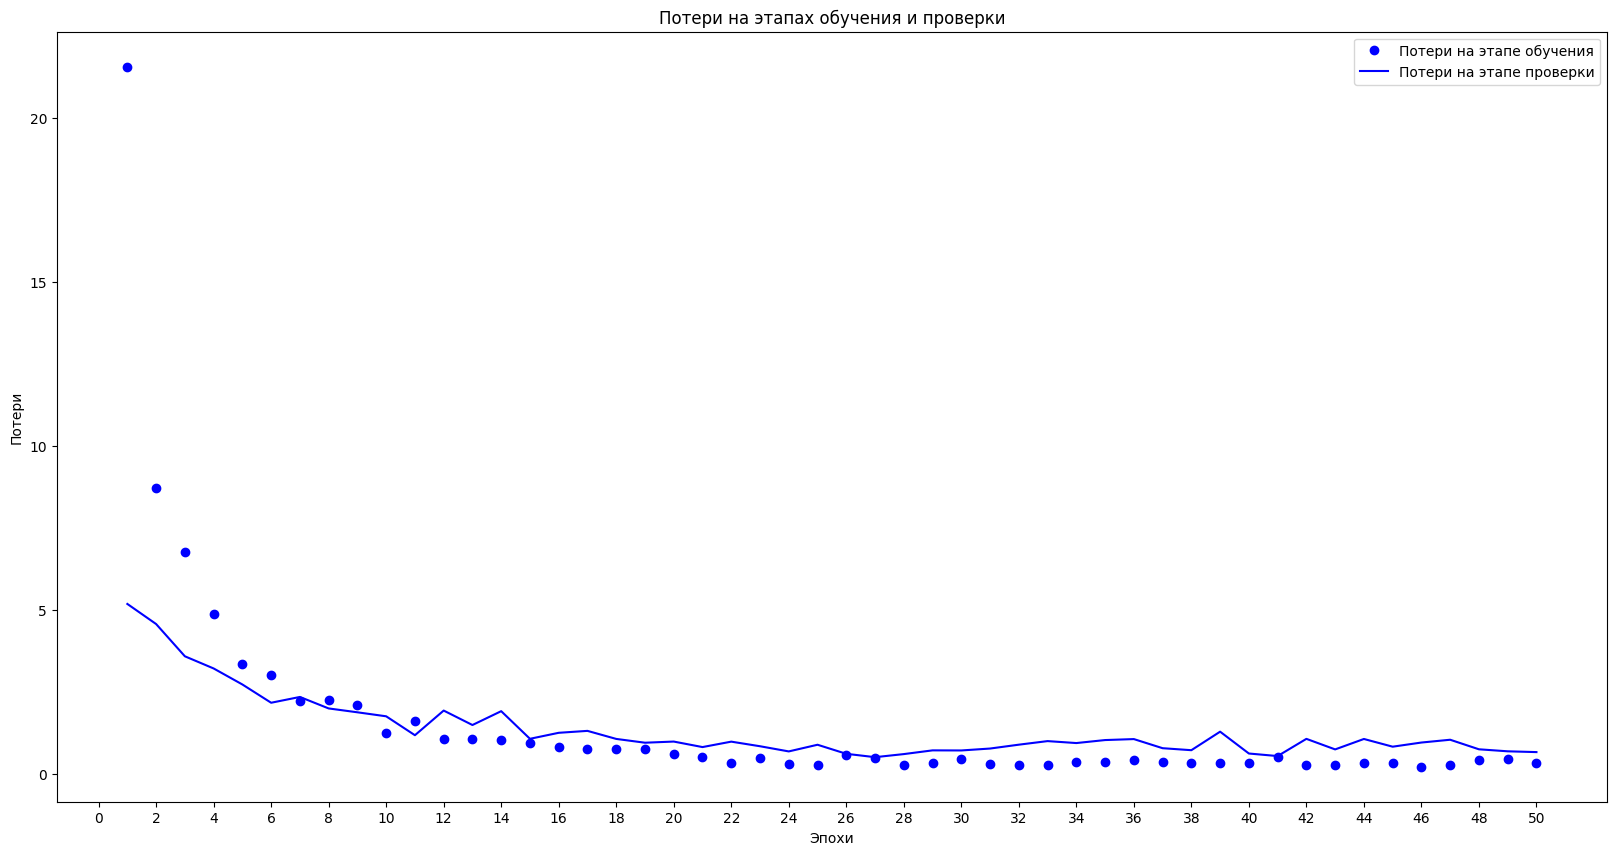

In [94]:
plt.figure(figsize=(20, 10))
plot_loss(history)

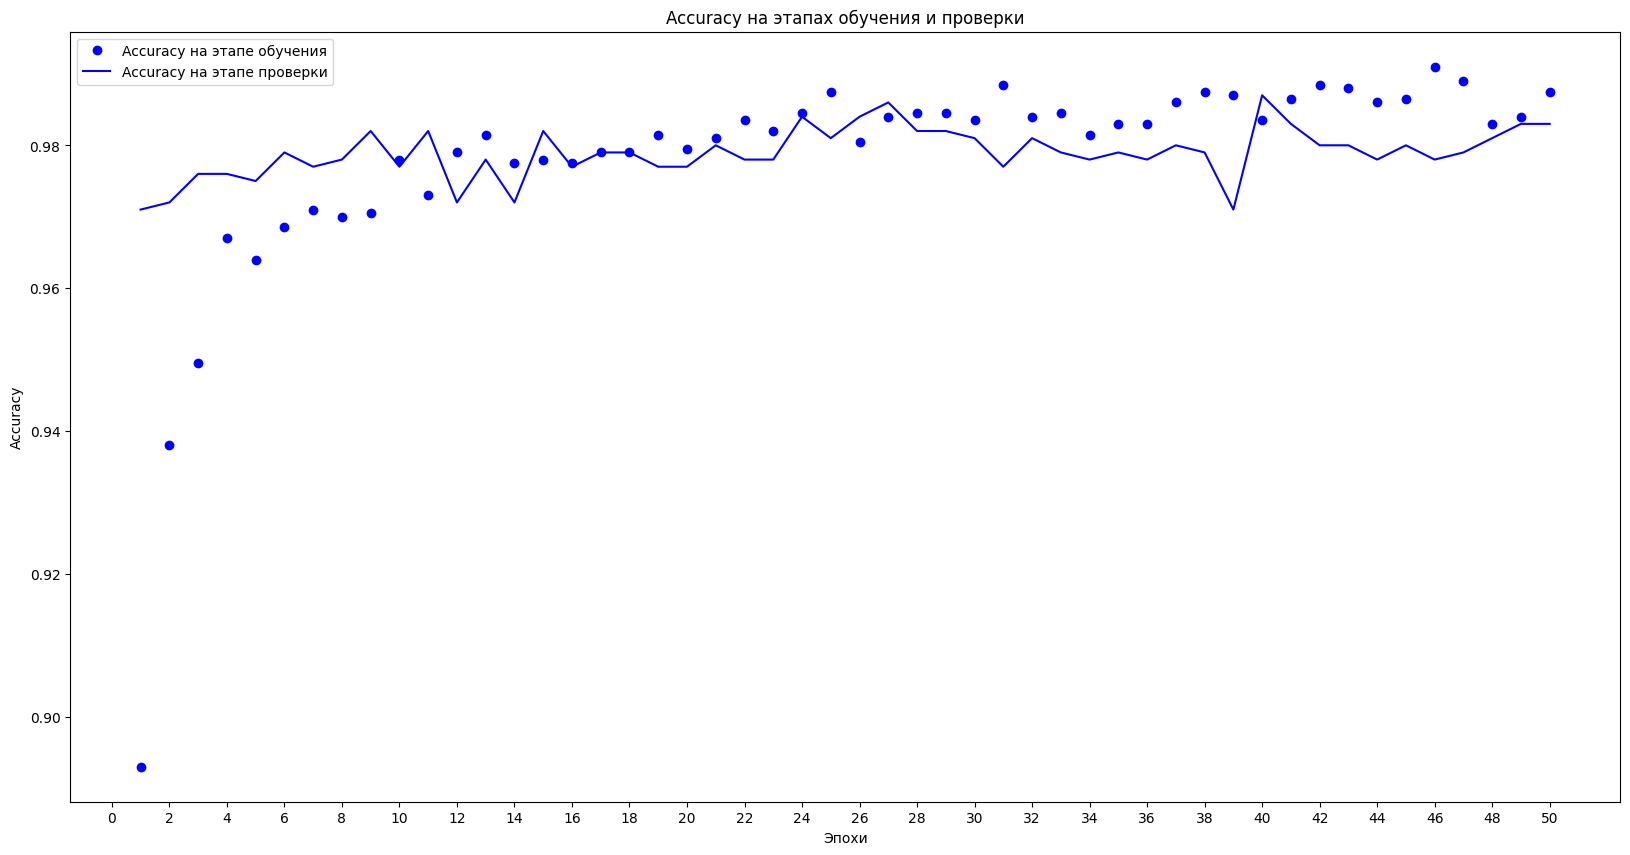

In [95]:
plt.figure(figsize=(20, 10))
plot_metric(history, "accuracy", "Accuracy")

In [96]:
test_model = keras.models.load_model(
    "models/feature_extraction_with_data_augmentation.x", safe_mode=False
)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 61ms/step - loss: 1.0272 - accuracy: 0.9775
Test accuracy: 0.978


### Дообучение

In [97]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"],
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/fine_tuning.x", save_best_only=True, monitor="val_loss"
    )
]
history = model.fit(
    train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks
)

Epoch 1/30


2024-04-23 12:31:22.734658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.5731 - accuracy: 0.9792

2024-04-23 12:31:23.273380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:23.369353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:23.467978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.2865 - accuracy: 0.9896

2024-04-23 12:31:23.550443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:23.631281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:23.710774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.2328 - accuracy: 0.9826

2024-04-23 12:31:23.792177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:23.877590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:23.956056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.1746 - accuracy: 0.9870

2024-04-23 12:31:24.038558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:24.113368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:24.192279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 3s - loss: 0.2227 - accuracy: 0.9854

2024-04-23 12:31:24.269482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:24.349881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:24.428766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.2387 - accuracy: 0.9861

2024-04-23 12:31:24.506097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:24.583106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:24.661491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.2105 - accuracy: 0.9866

2024-04-23 12:31:24.738787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:24.817847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:24.897405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.1842 - accuracy: 0.9883

2024-04-23 12:31:24.976936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:25.054886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:25.134557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 2s - loss: 0.2213 - accuracy: 0.9884

2024-04-23 12:31:25.211346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:25.287342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:25.367846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.2279 - accuracy: 0.9875

2024-04-23 12:31:25.443544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:25.519690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:25.597405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.2072 - accuracy: 0.9886

2024-04-23 12:31:25.675869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:25.762885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:25.839616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2316 - accuracy: 0.9887

2024-04-23 12:31:25.916608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:25.994077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:26.069098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1s - loss: 0.2167 - accuracy: 0.9888

2024-04-23 12:31:26.146505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:26.221424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:26.298049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.2214 - accuracy: 0.9888

2024-04-23 12:31:26.373757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:26.449613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:26.529472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.2151 - accuracy: 0.9889

2024-04-23 12:31:26.606839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:26.684111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:26.761633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2259 - accuracy: 0.9889

2024-04-23 12:31:26.838739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:26.917498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:26.993849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2520 - accuracy: 0.9884

2024-04-23 12:31:27.069445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:27.148240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:27.225036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.2380 - accuracy: 0.9890

2024-04-23 12:31:27.302031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:27.377660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:27.455642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2314 - accuracy: 0.9890

2024-04-23 12:31:27.529142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:27.607200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:27.682155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2341 - accuracy: 0.9891

2024-04-23 12:31:27.756988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:27.831938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:27.906243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2275 - accuracy: 0.9889

2024-04-23 12:31:27.980151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:28.054440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9890INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


63/63 [==============================] - 10s 138ms/step - loss: 0.2256 - accuracy: 0.9890 - val_loss: 0.6640 - val_accuracy: 0.9830
Epoch 2/30
 1/63 [..............................] - ETA: 9s - loss: 0.1391 - accuracy: 0.9688

2024-04-23 12:31:31.851917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:31.978940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.0348 - accuracy: 0.9922

2024-04-23 12:31:32.053622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:32.139120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:32.215327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.1741 - accuracy: 0.9866

2024-04-23 12:31:32.291749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:32.371171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:32.445277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1219 - accuracy: 0.9906

2024-04-23 12:31:32.521669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:32.596366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:32.670591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.0938 - accuracy: 0.9928

2024-04-23 12:31:32.746432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:32.821613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:32.897755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.0762 - accuracy: 0.9941

2024-04-23 12:31:32.974085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:33.048657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:33.124558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.0642 - accuracy: 0.9951

2024-04-23 12:31:33.198933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:33.278244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:33.356478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.0554 - accuracy: 0.9957

2024-04-23 12:31:33.434864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:33.509831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:33.585432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.0986 - accuracy: 0.9937

2024-04-23 12:31:33.664459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:33.742485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:33.817840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.0881 - accuracy: 0.9944

2024-04-23 12:31:33.894558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:33.973178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:34.049986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.0795 - accuracy: 0.9950

2024-04-23 12:31:34.127235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:34.202894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:34.277774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1365 - accuracy: 0.9926

2024-04-23 12:31:34.353602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:34.431829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:34.507546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.1338 - accuracy: 0.9916

2024-04-23 12:31:34.584916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:34.666129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:34.742918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1237 - accuracy: 0.9922

2024-04-23 12:31:34.819317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:34.894331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:34.971259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1529 - accuracy: 0.9906

2024-04-23 12:31:35.046642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:35.122633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:35.198384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1742 - accuracy: 0.9898

2024-04-23 12:31:35.275052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:35.351582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:35.428002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1636 - accuracy: 0.9904

2024-04-23 12:31:35.504691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:35.582254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:35.658636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1606 - accuracy: 0.9904

2024-04-23 12:31:35.737177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:35.814014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:35.889793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1518 - accuracy: 0.9909

2024-04-23 12:31:35.963435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:36.038938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:36.111985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1439 - accuracy: 0.9914

2024-04-23 12:31:36.186631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:36.262042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:36.337297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1369 - accuracy: 0.9918

2024-04-23 12:31:36.411507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:36.487947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:36.561392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1347 - accuracy: 0.9919

2024-04-23 12:31:36.636252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


63/63 [==============================] - 8s 120ms/step - loss: 0.1336 - accuracy: 0.9920 - val_loss: 0.6616 - val_accuracy: 0.9840
Epoch 3/30
 1/63 [..............................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:31:39.419308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:39.556268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.0302 - accuracy: 0.9922    

2024-04-23 12:31:39.633321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:39.710487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:39.786270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.0173 - accuracy: 0.9955

2024-04-23 12:31:39.862072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:39.937267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:40.012994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.0121 - accuracy: 0.9969

2024-04-23 12:31:40.087819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:40.165472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:40.240874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.0502 - accuracy: 0.9952

2024-04-23 12:31:40.318209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:40.397849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:40.473538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.0755 - accuracy: 0.9902

2024-04-23 12:31:40.548281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:40.623780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:40.699429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.0828 - accuracy: 0.9901

2024-04-23 12:31:40.775406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:40.849780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:40.927344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.0760 - accuracy: 0.9901

2024-04-23 12:31:41.003338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:41.079831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:41.154515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.0920 - accuracy: 0.9900

2024-04-23 12:31:41.229444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:41.305049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:41.382326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.0821 - accuracy: 0.9911

2024-04-23 12:31:41.457457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:41.539177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:41.614029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.0742 - accuracy: 0.9919

2024-04-23 12:31:41.689632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:41.765988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:41.842892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.0676 - accuracy: 0.9926

2024-04-23 12:31:41.918037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:41.998474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:42.072999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.0853 - accuracy: 0.9924

2024-04-23 12:31:42.149396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:42.223992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:42.299723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1243 - accuracy: 0.9906

2024-04-23 12:31:42.375270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:42.452663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:42.530619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1211 - accuracy: 0.9906

2024-04-23 12:31:42.613806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:42.692756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:42.773302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1132 - accuracy: 0.9912

2024-04-23 12:31:42.850599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:42.925763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:43.018417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1063 - accuracy: 0.9917

2024-04-23 12:31:43.104963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:43.181196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:43.257364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1001 - accuracy: 0.9922

2024-04-23 12:31:43.334622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:43.411640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:43.487295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1315 - accuracy: 0.9920

2024-04-23 12:31:43.564412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:43.640152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:43.712578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1509 - accuracy: 0.9919

2024-04-23 12:31:43.787425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:43.862342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:43.935406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1440 - accuracy: 0.9918

2024-04-23 12:31:44.010138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:44.083591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:44.158624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9919

2024-04-23 12:31:44.235072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


63/63 [==============================] - 8s 120ms/step - loss: 0.1478 - accuracy: 0.9915 - val_loss: 0.6569 - val_accuracy: 0.9850
Epoch 4/30
 1/63 [..............................] - ETA: 9s - loss: 4.4703e-08 - accuracy: 1.0000

2024-04-23 12:31:46.975270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:47.132361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.0972 - accuracy: 0.9844

2024-04-23 12:31:47.206721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:47.281691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:47.362703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.1059 - accuracy: 0.9821

2024-04-23 12:31:47.439193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:47.516241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:47.597302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1024 - accuracy: 0.9844

2024-04-23 12:31:47.678604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:47.755445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:47.831585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.1168 - accuracy: 0.9856

2024-04-23 12:31:47.908357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:47.985018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:48.061925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.0949 - accuracy: 0.9883

2024-04-23 12:31:48.140418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:48.219690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:48.299370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.0991 - accuracy: 0.9885

2024-04-23 12:31:48.375764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:48.452778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:48.529165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1121 - accuracy: 0.9872

2024-04-23 12:31:48.610206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:48.686177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:48.762186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.1249 - accuracy: 0.9875

2024-04-23 12:31:48.839047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:48.915251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:48.994912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.1436 - accuracy: 0.9855

2024-04-23 12:31:49.071062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:49.145827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:49.229155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.1400 - accuracy: 0.9859

2024-04-23 12:31:49.311761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:49.388627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:49.465454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1276 - accuracy: 0.9871

2024-04-23 12:31:49.544838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:49.625632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:49.704116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1173 - accuracy: 0.9882

2024-04-23 12:31:49.782241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:49.858831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:49.938179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1358 - accuracy: 0.9883

2024-04-23 12:31:50.017135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:50.094354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:50.175729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1264 - accuracy: 0.9891

2024-04-23 12:31:50.253595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:50.328887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:50.410526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1185 - accuracy: 0.9898

2024-04-23 12:31:50.487615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:50.563721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:50.639289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1119 - accuracy: 0.9898

2024-04-23 12:31:50.714797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:50.792711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:50.871039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1215 - accuracy: 0.9898

2024-04-23 12:31:50.946106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:51.024388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:51.100162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1210 - accuracy: 0.9898

2024-04-23 12:31:51.175442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:51.249122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:51.325046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1147 - accuracy: 0.9903

2024-04-23 12:31:51.403687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:51.481634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:51.556564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1097 - accuracy: 0.9903

2024-04-23 12:31:51.632241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:51.708628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:51.784333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.9899

2024-04-23 12:31:51.857710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


63/63 [==============================] - 8s 121ms/step - loss: 0.1111 - accuracy: 0.9900 - val_loss: 0.6556 - val_accuracy: 0.9830
Epoch 5/30
 1/63 [..............................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:31:54.623129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:54.751190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 4.2242e-05 - accuracy: 1.0000

2024-04-23 12:31:54.840221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:54.925253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:55.004152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.1180 - accuracy: 0.9955    

2024-04-23 12:31:55.083562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:55.182901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:55.259065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.0826 - accuracy: 0.9969

2024-04-23 12:31:55.335167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:55.415568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:55.493576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1206 - accuracy: 0.9952

2024-04-23 12:31:55.570477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:55.649500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:55.726638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.0980 - accuracy: 0.9961

2024-04-23 12:31:55.807385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:55.884950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:55.960827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1296 - accuracy: 0.9934

2024-04-23 12:31:56.039691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:56.118238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:56.197017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1269 - accuracy: 0.9915

2024-04-23 12:31:56.273814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:56.352729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:56.430910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.1505 - accuracy: 0.9912

2024-04-23 12:31:56.507420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:56.582870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:56.660953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.1459 - accuracy: 0.9911

2024-04-23 12:31:56.737268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:56.814196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:56.890735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.1949 - accuracy: 0.9909

2024-04-23 12:31:56.967679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:57.045920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:57.123168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1777 - accuracy: 0.9917

2024-04-23 12:31:57.200069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:57.276797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:57.353781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1843 - accuracy: 0.9916

2024-04-23 12:31:57.431797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:57.508542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:57.584549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1704 - accuracy: 0.9922

2024-04-23 12:31:57.659749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:57.734928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:57.812126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2050 - accuracy: 0.9920

2024-04-23 12:31:57.888281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:57.964954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:58.042991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1935 - accuracy: 0.9918

2024-04-23 12:31:58.120502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:58.199562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:58.279476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1816 - accuracy: 0.9923

2024-04-23 12:31:58.357445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:58.437968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:58.515018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1712 - accuracy: 0.9928

2024-04-23 12:31:58.593279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:58.668397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:58.746820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1958 - accuracy: 0.9926

2024-04-23 12:31:58.822274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:58.895625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:58.970795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1918 - accuracy: 0.9925

2024-04-23 12:31:59.044958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:59.121903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:59.197218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1824 - accuracy: 0.9928

2024-04-23 12:31:59.271536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:59.345531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:31:59.424443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9930

2024-04-23 12:31:59.499988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 107ms/step - loss: 0.1780 - accuracy: 0.9930 - val_loss: 0.6561 - val_accuracy: 0.9830
Epoch 6/30
 2/63 [..............................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:32:01.364028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:01.482896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:01.561935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.0269 - accuracy: 0.9937    

2024-04-23 12:32:01.654571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:01.731341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:01.810491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.2026 - accuracy: 0.9883

2024-04-23 12:32:01.890545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:01.969409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:02.045553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 4s - loss: 0.3506 - accuracy: 0.9830

2024-04-23 12:32:02.126872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:02.206914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:02.284104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.2755 - accuracy: 0.9866

2024-04-23 12:32:02.363711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:02.445299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:02.524027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.2427 - accuracy: 0.9871

2024-04-23 12:32:02.602736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:02.680367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:02.757998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.2063 - accuracy: 0.9891

2024-04-23 12:32:02.838296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:02.916918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:02.994653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.1805 - accuracy: 0.9891

2024-04-23 12:32:03.071730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:03.149878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:03.226756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.1597 - accuracy: 0.9904

2024-04-23 12:32:03.305781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:03.386049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:03.462480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.1456 - accuracy: 0.9903

2024-04-23 12:32:03.540667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:03.619286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:03.696112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.1365 - accuracy: 0.9902

2024-04-23 12:32:03.774302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:03.851260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:03.928338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.1459 - accuracy: 0.9893

2024-04-23 12:32:04.005456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:04.084594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:04.162908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.1343 - accuracy: 0.9901

2024-04-23 12:32:04.238960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:04.317600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:04.397720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.1245 - accuracy: 0.9909

2024-04-23 12:32:04.480427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:04.561938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:04.639688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.1286 - accuracy: 0.9908

2024-04-23 12:32:04.718972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:04.801348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:04.877867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.1503 - accuracy: 0.9900

2024-04-23 12:32:04.956877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:05.038844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:05.119764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1931 - accuracy: 0.9887

2024-04-23 12:32:05.200199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:05.280396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:05.361306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.1822 - accuracy: 0.9894

2024-04-23 12:32:05.440083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:05.520329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:05.599112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1724 - accuracy: 0.9900

2024-04-23 12:32:05.677466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:05.754079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:05.832433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1830 - accuracy: 0.9899

2024-04-23 12:32:05.910942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:05.991032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:06.069286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1741 - accuracy: 0.9904

2024-04-23 12:32:06.147134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:06.225009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:06.301516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 111ms/step - loss: 0.1728 - accuracy: 0.9905 - val_loss: 0.6588 - val_accuracy: 0.9820
Epoch 7/30
 1/63 [..............................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:32:08.345413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:08.469605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:32:08.564970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:08.650563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:08.735852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3070 - accuracy: 0.9911

2024-04-23 12:32:08.821681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:08.905023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:08.987186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.2149 - accuracy: 0.9937

2024-04-23 12:32:09.071952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:09.155024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:09.236987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1653 - accuracy: 0.9952

2024-04-23 12:32:09.320742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:09.403870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:09.486033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.2899 - accuracy: 0.9902

2024-04-23 12:32:09.567595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:09.650180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:09.732661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3158 - accuracy: 0.9885

2024-04-23 12:32:09.813561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:09.894157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:09.974543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4218 - accuracy: 0.9886

2024-04-23 12:32:10.055464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:10.135139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:10.213179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3759 - accuracy: 0.9887

2024-04-23 12:32:10.292957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:10.373246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:10.453078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3356 - accuracy: 0.9900

2024-04-23 12:32:10.531787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:10.611978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:10.690397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3039 - accuracy: 0.9899

2024-04-23 12:32:10.768736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:10.848985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:10.926567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2771 - accuracy: 0.9908

2024-04-23 12:32:11.002918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:11.080872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:11.158829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2546 - accuracy: 0.9916

2024-04-23 12:32:11.235725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:11.313713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:11.390614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2495 - accuracy: 0.9914

2024-04-23 12:32:11.471564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:11.547959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:11.625846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2421 - accuracy: 0.9906

2024-04-23 12:32:11.703800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:11.781689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:11.861388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2300 - accuracy: 0.9905

2024-04-23 12:32:11.940391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:12.017400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:12.096726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2388 - accuracy: 0.9904

2024-04-23 12:32:12.174387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:12.251255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:12.328658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2632 - accuracy: 0.9904

2024-04-23 12:32:12.408380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:12.487379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:12.563929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2537 - accuracy: 0.9898

2024-04-23 12:32:12.642094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:12.718636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:12.793623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2406 - accuracy: 0.9903

2024-04-23 12:32:12.868591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:12.942375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:13.016461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2311 - accuracy: 0.9903

2024-04-23 12:32:13.091033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:13.166718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:13.241894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2274 - accuracy: 0.9904

2024-04-23 12:32:13.315583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.2256 - accuracy: 0.9905 - val_loss: 0.6644 - val_accuracy: 0.9820
Epoch 8/30
 1/63 [..............................] - ETA: 7s - loss: 3.7253e-09 - accuracy: 1.0000

2024-04-23 12:32:15.300300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:15.429652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3019 - accuracy: 0.9922  

2024-04-23 12:32:15.515403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:15.600364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:15.683353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4181 - accuracy: 0.9866

2024-04-23 12:32:15.768532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:15.852212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:15.934380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.2935 - accuracy: 0.9906

2024-04-23 12:32:16.016890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:16.100101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:16.183611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.2258 - accuracy: 0.9928

2024-04-23 12:32:16.264641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:16.345336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:16.428227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.1835 - accuracy: 0.9941

2024-04-23 12:32:16.508774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:16.590575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:16.671121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1642 - accuracy: 0.9934

2024-04-23 12:32:16.751141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:16.832675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:16.911646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1765 - accuracy: 0.9929

2024-04-23 12:32:16.994769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:17.074268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:17.155111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.1944 - accuracy: 0.9912

2024-04-23 12:32:17.235991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:17.315121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:17.393346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2007 - accuracy: 0.9911

2024-04-23 12:32:17.477629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:17.555822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:17.633807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2205 - accuracy: 0.9909

2024-04-23 12:32:17.712644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:17.792381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:17.869422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2010 - accuracy: 0.9917

2024-04-23 12:32:17.947810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:18.024747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:18.104692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1954 - accuracy: 0.9916

2024-04-23 12:32:18.182470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:18.261855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:18.339413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1808 - accuracy: 0.9922

2024-04-23 12:32:18.418391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:18.495834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:18.573886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1682 - accuracy: 0.9927

2024-04-23 12:32:18.653205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:18.736260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:18.813030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1887 - accuracy: 0.9912

2024-04-23 12:32:18.891159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:18.967657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:19.043789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1897 - accuracy: 0.9911

2024-04-23 12:32:19.123661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:19.201034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:19.277507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1787 - accuracy: 0.9916

2024-04-23 12:32:19.358140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:19.437421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:19.515575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1690 - accuracy: 0.9920

2024-04-23 12:32:19.591634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:19.666570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:19.741759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1603 - accuracy: 0.9925

2024-04-23 12:32:19.820383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:19.897961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:19.973153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1524 - accuracy: 0.9928

2024-04-23 12:32:20.048534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:20.122862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:20.200807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9930

2024-04-23 12:32:20.273790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.1487 - accuracy: 0.9930 - val_loss: 0.6609 - val_accuracy: 0.9820
Epoch 9/30
 1/63 [..............................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:32:22.278042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:22.409233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6113 - accuracy: 0.9922  

2024-04-23 12:32:22.494316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:22.577943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:22.661696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3493 - accuracy: 0.9955

2024-04-23 12:32:22.746510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:22.829364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:22.913327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.2445 - accuracy: 0.9969

2024-04-23 12:32:22.996037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:23.078623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:23.161135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3161 - accuracy: 0.9928

2024-04-23 12:32:23.244949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:23.327210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:23.409384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3028 - accuracy: 0.9922

2024-04-23 12:32:23.493601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:23.577033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:23.657099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.2550 - accuracy: 0.9934

2024-04-23 12:32:23.737982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:23.818695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:23.898208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2387 - accuracy: 0.9929

2024-04-23 12:32:23.977479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:24.058447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:24.138187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2101 - accuracy: 0.9937

2024-04-23 12:32:24.217410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:24.298788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:24.378888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2050 - accuracy: 0.9933

2024-04-23 12:32:24.458958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:24.537670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:24.619377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.1851 - accuracy: 0.9940

2024-04-23 12:32:24.698724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:24.777910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:24.856802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1688 - accuracy: 0.9945

2024-04-23 12:32:24.934726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:25.015168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:25.093716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1551 - accuracy: 0.9949

2024-04-23 12:32:25.171376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:25.250237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:25.328085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1613 - accuracy: 0.9945

2024-04-23 12:32:25.406992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:25.486209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:25.566271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2008 - accuracy: 0.9942

2024-04-23 12:32:25.644203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:25.720835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:25.799034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1877 - accuracy: 0.9946

2024-04-23 12:32:25.877055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:25.956934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:26.035088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1952 - accuracy: 0.9943

2024-04-23 12:32:26.114309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:26.189635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:26.267028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1839 - accuracy: 0.9946

2024-04-23 12:32:26.342653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:26.420115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:26.500090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1739 - accuracy: 0.9949

2024-04-23 12:32:26.576079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:26.651142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:26.726672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1649 - accuracy: 0.9952

2024-04-23 12:32:26.800697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:26.876577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:26.952766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1570 - accuracy: 0.9954

2024-04-23 12:32:27.029886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:27.106699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:27.182025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.9955

2024-04-23 12:32:27.256690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.1533 - accuracy: 0.9955 - val_loss: 0.6638 - val_accuracy: 0.9820
Epoch 10/30
 1/63 [..............................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:32:29.251261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:29.376709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 8.8375e-05 - accuracy: 1.0000

2024-04-23 12:32:29.460837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:29.545567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:29.629998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 2.0233e-04 - accuracy: 1.0000

2024-04-23 12:32:29.716628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:29.800689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:29.884065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.0825 - accuracy: 0.9969

2024-04-23 12:32:29.975737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:30.057257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:30.139278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.0957 - accuracy: 0.9952

2024-04-23 12:32:30.219564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:30.300992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:30.384718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.1220 - accuracy: 0.9941

2024-04-23 12:32:30.467312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:30.547308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:30.627500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1027 - accuracy: 0.9951

2024-04-23 12:32:30.709524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:30.790040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:30.868914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1314 - accuracy: 0.9943

2024-04-23 12:32:30.947786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:31.027793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:31.108413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.1322 - accuracy: 0.9925

2024-04-23 12:32:31.186419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:31.266707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:31.345823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.1181 - accuracy: 0.9933

2024-04-23 12:32:31.426716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:31.506113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:31.589389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.1397 - accuracy: 0.9929

2024-04-23 12:32:31.668040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:31.745683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:31.824287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1274 - accuracy: 0.9936

2024-04-23 12:32:31.902137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:31.981063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:32.060209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1938 - accuracy: 0.9907

2024-04-23 12:32:32.137963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:32.215820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:32.294902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1793 - accuracy: 0.9914

2024-04-23 12:32:32.375242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:32.452472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:32.531877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1667 - accuracy: 0.9920

2024-04-23 12:32:32.609983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:32.688123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:32.765014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1559 - accuracy: 0.9925

2024-04-23 12:32:32.844177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:32.921625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:32.998494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1716 - accuracy: 0.9917

2024-04-23 12:32:33.077579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:33.155155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:33.233990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1617 - accuracy: 0.9922

2024-04-23 12:32:33.313900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:33.397607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:33.474339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1528 - accuracy: 0.9926

2024-04-23 12:32:33.551102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:33.625377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:33.700100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1560 - accuracy: 0.9925

2024-04-23 12:32:33.774892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:33.849643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:33.923999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1516 - accuracy: 0.9923

2024-04-23 12:32:33.999396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:34.076193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:34.150477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1491 - accuracy: 0.9924

2024-04-23 12:32:34.225027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.1479 - accuracy: 0.9925 - val_loss: 0.6672 - val_accuracy: 0.9820
Epoch 11/30
 1/63 [..............................] - ETA: 7s - loss: 0.3953 - accuracy: 0.9688

2024-04-23 12:32:36.209744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:36.342819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2071 - accuracy: 0.9766

2024-04-23 12:32:36.428696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:36.515578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:36.598247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3017 - accuracy: 0.9777

2024-04-23 12:32:36.681704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:36.763705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:36.849419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3905 - accuracy: 0.9750

2024-04-23 12:32:36.937272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:37.018830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:37.100139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3538 - accuracy: 0.9784

2024-04-23 12:32:37.182838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:37.264851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:37.348291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.2988 - accuracy: 0.9805

2024-04-23 12:32:37.431449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:37.511487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:37.592625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.2923 - accuracy: 0.9819

2024-04-23 12:32:37.674599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:37.756824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:37.836202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2524 - accuracy: 0.9844

2024-04-23 12:32:37.916784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:37.997588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:38.077589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2610 - accuracy: 0.9850

2024-04-23 12:32:38.158427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:38.238665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:38.319402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2330 - accuracy: 0.9866

2024-04-23 12:32:38.398835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:38.477633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:38.554829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2104 - accuracy: 0.9879

2024-04-23 12:32:38.634448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:38.713013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:38.790534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1919 - accuracy: 0.9890

2024-04-23 12:32:38.870517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:38.949345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:39.028568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2366 - accuracy: 0.9882

2024-04-23 12:32:39.107481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:39.186368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:39.265943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2189 - accuracy: 0.9891

2024-04-23 12:32:39.343463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:39.420709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:39.498683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2036 - accuracy: 0.9898

2024-04-23 12:32:39.575696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:39.653857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:39.733466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1976 - accuracy: 0.9898

2024-04-23 12:32:39.811224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:39.890336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:39.969838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2005 - accuracy: 0.9898

2024-04-23 12:32:40.047272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:40.123207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:40.202545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1890 - accuracy: 0.9904

2024-04-23 12:32:40.277813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:40.354310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:40.432678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1787 - accuracy: 0.9909

2024-04-23 12:32:40.508476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:40.582921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:40.657279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1694 - accuracy: 0.9914

2024-04-23 12:32:40.732321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:40.806990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:40.881912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.9908

2024-04-23 12:32:40.956935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:41.035532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:41.112107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9909

2024-04-23 12:32:41.187041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.1662 - accuracy: 0.9910 - val_loss: 0.6616 - val_accuracy: 0.9820
Epoch 12/30
 2/63 [..............................] - ETA: 5s - loss: 0.0716 - accuracy: 0.9844    

2024-04-23 12:32:43.181780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:43.303269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.0358 - accuracy: 0.9922

2024-04-23 12:32:43.387122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:43.470445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:43.563553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.0205 - accuracy: 0.9955

2024-04-23 12:32:43.647462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:43.732254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:43.814254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.0382 - accuracy: 0.9937

2024-04-23 12:32:43.897089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:43.980019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:44.061039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.0294 - accuracy: 0.9952

2024-04-23 12:32:44.143907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:44.225603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:44.308401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.1141 - accuracy: 0.9941

2024-04-23 12:32:44.389551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:44.470267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:44.550087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.0961 - accuracy: 0.9951

2024-04-23 12:32:44.631213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:44.713911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:44.792601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1545 - accuracy: 0.9929

2024-04-23 12:32:44.872982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:44.955044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:45.034983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.1360 - accuracy: 0.9937

2024-04-23 12:32:45.114982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:45.196626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:45.274354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.1214 - accuracy: 0.9944

2024-04-23 12:32:45.354900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:45.435082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:45.513783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.1097 - accuracy: 0.9950

2024-04-23 12:32:45.592295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:45.671285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:45.749956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1002 - accuracy: 0.9954

2024-04-23 12:32:45.829815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:45.908394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:45.986884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.0921 - accuracy: 0.9958

2024-04-23 12:32:46.064858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:46.147279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:46.224408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.0852 - accuracy: 0.9961

2024-04-23 12:32:46.302568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:46.378042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:46.456117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.0793 - accuracy: 0.9964

2024-04-23 12:32:46.534688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:46.610970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:46.687702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.0807 - accuracy: 0.9959

2024-04-23 12:32:46.765410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:46.842587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:46.921891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.0758 - accuracy: 0.9962

2024-04-23 12:32:46.999371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:47.076220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:47.152859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1042 - accuracy: 0.9952

2024-04-23 12:32:47.232820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:47.312666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:47.389047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1067 - accuracy: 0.9949

2024-04-23 12:32:47.466200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:47.541383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:47.615462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1045 - accuracy: 0.9946

2024-04-23 12:32:47.690712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:47.767175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:47.843675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.9949

2024-04-23 12:32:47.919774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:47.994677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:48.073276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1020 - accuracy: 0.9940

2024-04-23 12:32:48.151377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.1011 - accuracy: 0.9940 - val_loss: 0.6570 - val_accuracy: 0.9820
Epoch 13/30
 1/63 [..............................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:32:50.145364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:50.276828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.1695 - accuracy: 0.9922    

2024-04-23 12:32:50.361365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:50.446691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:50.529599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.2096 - accuracy: 0.9911

2024-04-23 12:32:50.613014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:50.698146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:50.782219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1467 - accuracy: 0.9937

2024-04-23 12:32:50.864185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:50.948404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:51.030724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1141 - accuracy: 0.9952

2024-04-23 12:32:51.115214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:51.197995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:51.280325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.1522 - accuracy: 0.9941

2024-04-23 12:32:51.363249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:51.444578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:51.525039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1282 - accuracy: 0.9951

2024-04-23 12:32:51.605840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:51.686632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:51.767823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1107 - accuracy: 0.9957

2024-04-23 12:32:51.847211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:51.928009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:52.007224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.1046 - accuracy: 0.9950

2024-04-23 12:32:52.087588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:52.165986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:52.246029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.0934 - accuracy: 0.9955

2024-04-23 12:32:52.324821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:52.404602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:52.480971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.0844 - accuracy: 0.9960

2024-04-23 12:32:52.559019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:52.636272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:52.716275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.0904 - accuracy: 0.9945

2024-04-23 12:32:52.795769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:52.871901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:52.951960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.0831 - accuracy: 0.9949

2024-04-23 12:32:53.029460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:53.108743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:53.186577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1680 - accuracy: 0.9930

2024-04-23 12:32:53.263777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:53.343345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:53.421556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1563 - accuracy: 0.9935

2024-04-23 12:32:53.500001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:53.579273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:53.655101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1461 - accuracy: 0.9939

2024-04-23 12:32:53.731509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:53.810221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:53.888081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1395 - accuracy: 0.9936

2024-04-23 12:32:53.967307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:54.046734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:54.123704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1315 - accuracy: 0.9940

2024-04-23 12:32:54.202522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:54.278667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:54.355676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1290 - accuracy: 0.9937

2024-04-23 12:32:54.435286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:54.511476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:54.588175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1223 - accuracy: 0.9941

2024-04-23 12:32:54.663802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:54.738195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:54.811621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1163 - accuracy: 0.9944

2024-04-23 12:32:54.891093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:54.967192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:55.043474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1145 - accuracy: 0.9945

2024-04-23 12:32:55.118185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.1136 - accuracy: 0.9945 - val_loss: 0.6574 - val_accuracy: 0.9820
Epoch 14/30
 1/63 [..............................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:32:57.118151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:57.247861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6038 - accuracy: 0.9766

2024-04-23 12:32:57.333158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:57.419944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:57.503152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5049 - accuracy: 0.9821

2024-04-23 12:32:57.587423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:57.670245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:57.754581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4097 - accuracy: 0.9812

2024-04-23 12:32:57.836620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:57.922630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:58.004158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3413 - accuracy: 0.9832

2024-04-23 12:32:58.088633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:58.172453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:58.254164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.2786 - accuracy: 0.9863

2024-04-23 12:32:58.336392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:58.419933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:58.501367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.2374 - accuracy: 0.9868

2024-04-23 12:32:58.582121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:58.666277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:58.748123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2682 - accuracy: 0.9872

2024-04-23 12:32:58.828344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:58.910571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:58.989457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2360 - accuracy: 0.9887

2024-04-23 12:32:59.068495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:59.150444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:59.231008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2107 - accuracy: 0.9900

2024-04-23 12:32:59.310901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:59.391785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:59.470343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2437 - accuracy: 0.9899

2024-04-23 12:32:59.549532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:59.631709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:59.710585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2260 - accuracy: 0.9899

2024-04-23 12:32:59.790456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:59.868930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:32:59.947729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2258 - accuracy: 0.9899

2024-04-23 12:33:00.025755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:00.102916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:00.182153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2404 - accuracy: 0.9898

2024-04-23 12:33:00.259202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:00.336674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:00.415806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2407 - accuracy: 0.9891

2024-04-23 12:33:00.494312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:00.572999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:00.651638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2395 - accuracy: 0.9891

2024-04-23 12:33:00.728534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:00.805940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:00.882308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2248 - accuracy: 0.9898

2024-04-23 12:33:00.965031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:01.046665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:01.121762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2118 - accuracy: 0.9904

2024-04-23 12:33:01.199543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:01.281564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:01.358338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2217 - accuracy: 0.9903

2024-04-23 12:33:01.434927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:01.510581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:01.584756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2314 - accuracy: 0.9898

2024-04-23 12:33:01.662477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:01.738300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:01.813430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2310 - accuracy: 0.9898

2024-04-23 12:33:01.890963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:01.966546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:02.041535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2273 - accuracy: 0.9899

2024-04-23 12:33:02.115976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


63/63 [==============================] - 8s 131ms/step - loss: 0.2254 - accuracy: 0.9900 - val_loss: 0.6534 - val_accuracy: 0.9820
Epoch 15/30
 1/63 [..............................] - ETA: 8s - loss: 1.7621e-04 - accuracy: 1.0000

2024-04-23 12:33:05.340095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:05.478691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.5284 - accuracy: 0.9922

2024-04-23 12:33:05.556100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:05.642490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:05.719437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3546 - accuracy: 0.9911

2024-04-23 12:33:05.797157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:05.877947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:05.955407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.2482 - accuracy: 0.9937

2024-04-23 12:33:06.031073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:06.106163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:06.180639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.1932 - accuracy: 0.9928

2024-04-23 12:33:06.257140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:06.333082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:06.409730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.1570 - accuracy: 0.9941

2024-04-23 12:33:06.486961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:06.564654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:06.640905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1322 - accuracy: 0.9951

2024-04-23 12:33:06.716549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:06.794556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:06.871049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1142 - accuracy: 0.9957

2024-04-23 12:33:06.948164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:07.024966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:07.105588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.1108 - accuracy: 0.9950

2024-04-23 12:33:07.183158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:07.259002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:07.333523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2084 - accuracy: 0.9933

2024-04-23 12:33:07.411511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:07.489649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:07.567924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2123 - accuracy: 0.9929

2024-04-23 12:33:07.643582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:07.719442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:07.798498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1936 - accuracy: 0.9936

2024-04-23 12:33:07.875468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:07.952547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:08.027769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2372 - accuracy: 0.9924

2024-04-23 12:33:08.107533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:08.186564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:08.261707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2194 - accuracy: 0.9930

2024-04-23 12:33:08.339228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:08.417712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:08.494136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2041 - accuracy: 0.9935

2024-04-23 12:33:08.569856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:08.651192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:08.725493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2217 - accuracy: 0.9925

2024-04-23 12:33:08.802306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:08.882116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:08.960224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2081 - accuracy: 0.9930

2024-04-23 12:33:09.039021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:09.115393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:09.193913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1961 - accuracy: 0.9934

2024-04-23 12:33:09.272805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:09.350535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:09.428592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1864 - accuracy: 0.9932

2024-04-23 12:33:09.504038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:09.580435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:09.656881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1803 - accuracy: 0.9930

2024-04-23 12:33:09.731581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:09.805642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:09.881137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1714 - accuracy: 0.9933

2024-04-23 12:33:09.955831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:10.030290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:10.103918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9934

2024-04-23 12:33:10.178479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


63/63 [==============================] - 8s 120ms/step - loss: 0.1673 - accuracy: 0.9935 - val_loss: 0.6528 - val_accuracy: 0.9820
Epoch 16/30
 1/63 [..............................] - ETA: 7s - loss: 0.3832 - accuracy: 0.9688

2024-04-23 12:33:12.933364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:13.057857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 4s - loss: 0.2060 - accuracy: 0.9688

2024-04-23 12:33:13.132148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.1059 - accuracy: 0.9844

2024-04-23 12:33:13.207775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:13.284624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.1554 - accuracy: 0.9812

2024-04-23 12:33:13.362267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.1110 - accuracy: 0.9866

2024-04-23 12:33:13.439307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:13.517838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.0971 - accuracy: 0.9883

2024-04-23 12:33:13.593713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.0850 - accuracy: 0.9875

2024-04-23 12:33:13.670595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:13.747572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 4s - loss: 0.0773 - accuracy: 0.9886

2024-04-23 12:33:13.825176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.0654 - accuracy: 0.9904

2024-04-23 12:33:13.902695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:13.977701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.0608 - accuracy: 0.9911

2024-04-23 12:33:14.054761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.0532 - accuracy: 0.9922

2024-04-23 12:33:14.134036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:14.212210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.0538 - accuracy: 0.9908

2024-04-23 12:33:14.288140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.0482 - accuracy: 0.9918

2024-04-23 12:33:14.367078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:14.443822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.0739 - accuracy: 0.9906

2024-04-23 12:33:14.520074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2110 - accuracy: 0.9901

2024-04-23 12:33:14.597549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:14.672827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.2018 - accuracy: 0.9905

2024-04-23 12:33:14.754633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.2412 - accuracy: 0.9900

2024-04-23 12:33:14.831481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:14.909597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.2319 - accuracy: 0.9904

2024-04-23 12:33:14.985933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2392 - accuracy: 0.9900

2024-04-23 12:33:15.063103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:15.140181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.2345 - accuracy: 0.9881

2024-04-23 12:33:15.217604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2194 - accuracy: 0.9889

2024-04-23 12:33:15.295735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:15.373616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.2125 - accuracy: 0.9893

2024-04-23 12:33:15.450252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2409 - accuracy: 0.9890

2024-04-23 12:33:15.532627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:15.610119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.2341 - accuracy: 0.9893

2024-04-23 12:33:15.685852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2214 - accuracy: 0.9899

2024-04-23 12:33:15.765159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:15.844865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2156 - accuracy: 0.9901

2024-04-23 12:33:15.922176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2048 - accuracy: 0.9906

2024-04-23 12:33:16.002717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:16.082053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.1998 - accuracy: 0.9909

2024-04-23 12:33:16.160487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1924 - accuracy: 0.9906

2024-04-23 12:33:16.237995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:16.313784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.1880 - accuracy: 0.9908

2024-04-23 12:33:16.389133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1891 - accuracy: 0.9905

2024-04-23 12:33:16.468284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:16.545700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.1851 - accuracy: 0.9907

2024-04-23 12:33:16.622829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1961 - accuracy: 0.9904

2024-04-23 12:33:16.700451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:16.777986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1922 - accuracy: 0.9906

2024-04-23 12:33:16.856478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2008 - accuracy: 0.9898

2024-04-23 12:33:16.934437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:17.011115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.1971 - accuracy: 0.9900

2024-04-23 12:33:17.106410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1977 - accuracy: 0.9898

2024-04-23 12:33:17.181572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:17.258907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1941 - accuracy: 0.9900

2024-04-23 12:33:17.332169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2018 - accuracy: 0.9887

2024-04-23 12:33:17.410168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:17.484818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1983 - accuracy: 0.9889

2024-04-23 12:33:17.558621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9887

2024-04-23 12:33:17.634535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:17.709999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1938 - accuracy: 0.9884

2024-04-23 12:33:17.783277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 106ms/step - loss: 0.1923 - accuracy: 0.9885 - val_loss: 0.6579 - val_accuracy: 0.9820
Epoch 17/30
 1/63 [..............................] - ETA: 8s - loss: 0.6702 - accuracy: 0.9688

2024-04-23 12:33:19.624606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:19.757575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.1676 - accuracy: 0.9922

2024-04-23 12:33:19.834704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:19.914104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:19.992608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.0980 - accuracy: 0.9955

2024-04-23 12:33:20.071495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:20.152025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:20.228734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1763 - accuracy: 0.9937

2024-04-23 12:33:20.307198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:20.388156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:20.465551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.2867 - accuracy: 0.9904

2024-04-23 12:33:20.543021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:20.619835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:20.698162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.2329 - accuracy: 0.9922

2024-04-23 12:33:20.774608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:20.853568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:20.931597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1961 - accuracy: 0.9934

2024-04-23 12:33:21.008265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:21.084740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:21.161829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1694 - accuracy: 0.9943

2024-04-23 12:33:21.240239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:21.317042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:21.393370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.1882 - accuracy: 0.9937

2024-04-23 12:33:21.467551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:21.545204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:21.623644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.1950 - accuracy: 0.9933

2024-04-23 12:33:21.700355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:21.775476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:21.851347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.1761 - accuracy: 0.9940

2024-04-23 12:33:21.932029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:22.008837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:22.085696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1606 - accuracy: 0.9945

2024-04-23 12:33:22.160718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:22.238498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:22.315391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1511 - accuracy: 0.9941

2024-04-23 12:33:22.392982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:22.469590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:22.552024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1402 - accuracy: 0.9945

2024-04-23 12:33:22.629461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:22.707915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:22.786408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1919 - accuracy: 0.9935

2024-04-23 12:33:22.863580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:22.940022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:23.022181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1794 - accuracy: 0.9939

2024-04-23 12:33:23.098821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:23.176870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:23.255010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2026 - accuracy: 0.9930

2024-04-23 12:33:23.331710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:23.409527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:23.486451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1909 - accuracy: 0.9934

2024-04-23 12:33:23.564280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:23.641813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:23.718708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1805 - accuracy: 0.9937

2024-04-23 12:33:23.793949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:23.874678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:23.950413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1711 - accuracy: 0.9941

2024-04-23 12:33:24.026598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:24.112787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:24.192302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1653 - accuracy: 0.9939

2024-04-23 12:33:24.270852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:24.347816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:24.427383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1627 - accuracy: 0.9940

2024-04-23 12:33:24.501265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 109ms/step - loss: 0.1614 - accuracy: 0.9940 - val_loss: 0.6533 - val_accuracy: 0.9820
Epoch 18/30
 1/63 [..............................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:33:26.516560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:26.647534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.1962 - accuracy: 0.9922    

2024-04-23 12:33:26.733753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:26.818570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:26.903811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.1121 - accuracy: 0.9955

2024-04-23 12:33:26.988496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:27.074988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:27.160098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1840 - accuracy: 0.9906

2024-04-23 12:33:27.243477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:27.326502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:27.409062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1417 - accuracy: 0.9928

2024-04-23 12:33:27.491950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:27.575144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:27.658213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3359 - accuracy: 0.9922

2024-04-23 12:33:27.739147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:27.821854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:27.904197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3010 - accuracy: 0.9918

2024-04-23 12:33:27.985634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:28.066708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:28.148287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4390 - accuracy: 0.9886

2024-04-23 12:33:28.228750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:28.310122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:28.389886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3863 - accuracy: 0.9900

2024-04-23 12:33:28.469963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:28.549764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:28.630205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3449 - accuracy: 0.9911

2024-04-23 12:33:28.710725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:28.793119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:28.873948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3116 - accuracy: 0.9919

2024-04-23 12:33:28.954205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:29.034820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:29.117102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2841 - accuracy: 0.9926

2024-04-23 12:33:29.197808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:29.281308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:29.361909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2610 - accuracy: 0.9932

2024-04-23 12:33:29.440897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:29.519434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:29.600762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2415 - accuracy: 0.9937

2024-04-23 12:33:29.680743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:29.760737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:29.841136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2248 - accuracy: 0.9942

2024-04-23 12:33:29.919348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:29.998313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:30.075772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2225 - accuracy: 0.9939

2024-04-23 12:33:30.159271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:30.240406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:30.323761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2089 - accuracy: 0.9943

2024-04-23 12:33:30.410125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:30.494775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:30.576043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1972 - accuracy: 0.9946

2024-04-23 12:33:30.659972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:30.742768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:30.821665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2041 - accuracy: 0.9943

2024-04-23 12:33:30.899285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:30.980412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:31.056397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1935 - accuracy: 0.9946

2024-04-23 12:33:31.132516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:31.210651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:31.288571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9944

2024-04-23 12:33:31.364108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:31.439716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:31.516615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1888 - accuracy: 0.9945

2024-04-23 12:33:31.595013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 112ms/step - loss: 0.1872 - accuracy: 0.9945 - val_loss: 0.6566 - val_accuracy: 0.9820
Epoch 19/30
 1/63 [..............................] - ETA: 7s - loss: 0.1820 - accuracy: 0.9688

2024-04-23 12:33:33.596520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:33.720495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.1157 - accuracy: 0.9844

2024-04-23 12:33:33.812319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:33.898942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:33.983258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.2092 - accuracy: 0.9866

2024-04-23 12:33:34.064897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:34.150093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:34.232146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1464 - accuracy: 0.9906

2024-04-23 12:33:34.315579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:34.397105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:34.481693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1126 - accuracy: 0.9928

2024-04-23 12:33:34.564806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:34.647037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:34.726738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.1773 - accuracy: 0.9922

2024-04-23 12:33:34.809041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:34.891253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:34.971319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1813 - accuracy: 0.9918

2024-04-23 12:33:35.050673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:35.131035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:35.211702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1566 - accuracy: 0.9929

2024-04-23 12:33:35.290943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:35.370564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:35.449185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.1579 - accuracy: 0.9912

2024-04-23 12:33:35.529232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:35.608887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:35.686801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.1410 - accuracy: 0.9922

2024-04-23 12:33:35.767985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:35.846982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:35.924495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2099 - accuracy: 0.9899

2024-04-23 12:33:36.004036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:36.083949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:36.162358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2009 - accuracy: 0.9899

2024-04-23 12:33:36.240184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:36.319828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:36.396711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2103 - accuracy: 0.9899

2024-04-23 12:33:36.474455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:36.553866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:36.633057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2383 - accuracy: 0.9883

2024-04-23 12:33:36.712348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:36.793269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:36.869266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2289 - accuracy: 0.9884

2024-04-23 12:33:36.948222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:37.025694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:37.102582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2461 - accuracy: 0.9878

2024-04-23 12:33:37.178456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:37.256052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:37.336584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2369 - accuracy: 0.9872

2024-04-23 12:33:37.413492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:37.491094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:37.567565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2324 - accuracy: 0.9874

2024-04-23 12:33:37.646647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:37.723989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:37.798923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2198 - accuracy: 0.9881

2024-04-23 12:33:37.876312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:37.953474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:38.029329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2116 - accuracy: 0.9876

2024-04-23 12:33:38.104482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:38.180013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:38.254788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2012 - accuracy: 0.9882

2024-04-23 12:33:38.332277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:38.410663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:38.487788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9885

2024-04-23 12:33:38.574491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.1963 - accuracy: 0.9885 - val_loss: 0.6550 - val_accuracy: 0.9820
Epoch 20/30
 1/63 [..............................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:33:40.567270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:40.699123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 4.5635e-08 - accuracy: 1.0000

2024-04-23 12:33:40.787354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:40.871056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:40.959635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 2.6077e-08 - accuracy: 1.0000

2024-04-23 12:33:41.043047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:41.125448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:41.207600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 1.8254e-08 - accuracy: 1.0000

2024-04-23 12:33:41.291982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:41.372278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:41.454559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 3.0089e-08 - accuracy: 1.0000

2024-04-23 12:33:41.535052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:41.617282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:41.697924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.0149 - accuracy: 0.9980

2024-04-23 12:33:41.778999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:41.859668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:41.938013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.0125 - accuracy: 0.9984

2024-04-23 12:33:42.018603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:42.097419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:42.178709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.0108 - accuracy: 0.9986

2024-04-23 12:33:42.258233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:42.336853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:42.416388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.0803 - accuracy: 0.9962

2024-04-23 12:33:42.497737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:42.575318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:42.656712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.0717 - accuracy: 0.9967

2024-04-23 12:33:42.733116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:42.812745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:42.890409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.0764 - accuracy: 0.9960

2024-04-23 12:33:42.971213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:43.050943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:43.130669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.0831 - accuracy: 0.9954

2024-04-23 12:33:43.205883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:43.285571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:43.362745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.0768 - accuracy: 0.9958

2024-04-23 12:33:43.439879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:43.517991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:43.596066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.0710 - accuracy: 0.9961

2024-04-23 12:33:43.673611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:43.750012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:43.829788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.0661 - accuracy: 0.9964

2024-04-23 12:33:43.906046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:43.983996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:44.059984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.0620 - accuracy: 0.9966

2024-04-23 12:33:44.142008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:44.221765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:44.297617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.0582 - accuracy: 0.9968

2024-04-23 12:33:44.375621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:44.452560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:44.528629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.0559 - accuracy: 0.9964

2024-04-23 12:33:44.604758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:44.682821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:44.758384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.0808 - accuracy: 0.9949

2024-04-23 12:33:44.835750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:44.912327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:44.986796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.0767 - accuracy: 0.9952

2024-04-23 12:33:45.061566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:45.135893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:45.209625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1052 - accuracy: 0.9949

2024-04-23 12:33:45.284615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:45.367020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:45.446473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1035 - accuracy: 0.9950

2024-04-23 12:33:45.521460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.1027 - accuracy: 0.9950 - val_loss: 0.6534 - val_accuracy: 0.9820
Epoch 21/30
 1/63 [..............................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:33:47.503724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:47.643656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.1984 - accuracy: 0.9922    

2024-04-23 12:33:47.726998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:47.811090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:47.896087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.1133 - accuracy: 0.9955

2024-04-23 12:33:47.977674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:48.061476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:48.144376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.0793 - accuracy: 0.9969

2024-04-23 12:33:48.225877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:48.309973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:48.389904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.0611 - accuracy: 0.9976

2024-04-23 12:33:48.478941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:48.559212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:48.641830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.0496 - accuracy: 0.9980

2024-04-23 12:33:48.723232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:48.804851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:48.885873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1173 - accuracy: 0.9951

2024-04-23 12:33:48.966306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:49.047892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:49.126479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1659 - accuracy: 0.9943

2024-04-23 12:33:49.207644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:49.286820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:49.368065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2740 - accuracy: 0.9887

2024-04-23 12:33:49.445972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:49.525514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:49.604619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2447 - accuracy: 0.9900

2024-04-23 12:33:49.681232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:49.761146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:49.839216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2210 - accuracy: 0.9909

2024-04-23 12:33:49.916794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:49.996310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:50.072118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2016 - accuracy: 0.9917

2024-04-23 12:33:50.148676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:50.226658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:50.308471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1852 - accuracy: 0.9924

2024-04-23 12:33:50.385513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:50.465108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:50.545198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1846 - accuracy: 0.9922

2024-04-23 12:33:50.619842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:50.698635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:50.778442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1717 - accuracy: 0.9927

2024-04-23 12:33:50.855263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:50.933239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:51.009651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1659 - accuracy: 0.9925

2024-04-23 12:33:51.086796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:51.165802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:51.242648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1649 - accuracy: 0.9917

2024-04-23 12:33:51.319321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:51.396196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:51.472126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1612 - accuracy: 0.9910

2024-04-23 12:33:51.548360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:51.627025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:51.703151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1524 - accuracy: 0.9915

2024-04-23 12:33:51.792433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:51.871224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:51.946997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1872 - accuracy: 0.9898

2024-04-23 12:33:52.021989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:52.099018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:52.172340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1780 - accuracy: 0.9903

2024-04-23 12:33:52.247604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:52.321347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:52.396034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1751 - accuracy: 0.9904

2024-04-23 12:33:52.471271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.1737 - accuracy: 0.9905 - val_loss: 0.6602 - val_accuracy: 0.9820
Epoch 22/30
 1/63 [..............................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:33:54.469023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:54.597344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.4661 - accuracy: 0.9766

2024-04-23 12:33:54.682686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:54.769269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:54.852306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4426 - accuracy: 0.9732

2024-04-23 12:33:54.935681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:55.020962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:55.100877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3105 - accuracy: 0.9812

2024-04-23 12:33:55.184991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:55.271132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:55.353708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.2388 - accuracy: 0.9856

2024-04-23 12:33:55.435386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:55.520484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:55.601238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.1940 - accuracy: 0.9883

2024-04-23 12:33:55.682646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:55.765512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:55.846548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1638 - accuracy: 0.9901

2024-04-23 12:33:55.928655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:56.010701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:56.091748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1415 - accuracy: 0.9915

2024-04-23 12:33:56.175534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:56.258969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:56.340472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.1245 - accuracy: 0.9925

2024-04-23 12:33:56.422026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:56.502091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:56.581873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.1112 - accuracy: 0.9933

2024-04-23 12:33:56.661909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:56.739242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:56.816398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.1196 - accuracy: 0.9909

2024-04-23 12:33:56.895304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:56.974999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:57.052705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1115 - accuracy: 0.9908

2024-04-23 12:33:57.131458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:57.211038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:57.288001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1095 - accuracy: 0.9907

2024-04-23 12:33:57.366447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:57.443606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:57.521483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1012 - accuracy: 0.9914

2024-04-23 12:33:57.599943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:57.678834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:57.757175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.0942 - accuracy: 0.9920

2024-04-23 12:33:57.835123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:57.912059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:57.989856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.0880 - accuracy: 0.9925

2024-04-23 12:33:58.067811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:58.144963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:58.222619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.0827 - accuracy: 0.9930

2024-04-23 12:33:58.301726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:58.378086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:58.454058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.0779 - accuracy: 0.9934

2024-04-23 12:33:58.531083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:58.624651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:58.702764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.0823 - accuracy: 0.9932

2024-04-23 12:33:58.783245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:58.860918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:58.935982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.0860 - accuracy: 0.9930

2024-04-23 12:33:59.011586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:59.086793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:59.161135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9928

2024-04-23 12:33:59.236131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:59.311173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:33:59.385701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1046 - accuracy: 0.9929

2024-04-23 12:33:59.460413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 111ms/step - loss: 0.1114 - accuracy: 0.9925 - val_loss: 0.6590 - val_accuracy: 0.9820
Epoch 23/30
 1/63 [..............................] - ETA: 7s - loss: 1.0759e-04 - accuracy: 1.0000

2024-04-23 12:34:01.452900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:01.586650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 8.0937e-04 - accuracy: 1.0000

2024-04-23 12:34:01.669347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:01.754895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:01.838616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5059 - accuracy: 0.9911    

2024-04-23 12:34:01.924496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:02.007771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:02.091714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5044 - accuracy: 0.9906

2024-04-23 12:34:02.173399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:02.255010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:02.337044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4548 - accuracy: 0.9880

2024-04-23 12:34:02.419352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:02.502935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:02.584054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4355 - accuracy: 0.9863

2024-04-23 12:34:02.665001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:02.748001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:02.827509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4288 - accuracy: 0.9852

2024-04-23 12:34:02.906601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:02.988171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:03.068764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3704 - accuracy: 0.9872

2024-04-23 12:34:03.151673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:03.230688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:03.309973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3315 - accuracy: 0.9875

2024-04-23 12:34:03.388632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:03.468311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:03.546951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3081 - accuracy: 0.9877

2024-04-23 12:34:03.627977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:03.705133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:03.781022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2783 - accuracy: 0.9889

2024-04-23 12:34:03.860678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:03.939730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:04.019490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2829 - accuracy: 0.9890

2024-04-23 12:34:04.098087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:04.176013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:04.255214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2715 - accuracy: 0.9882

2024-04-23 12:34:04.333555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:04.410550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:04.487634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2853 - accuracy: 0.9867

2024-04-23 12:34:04.566438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:04.643397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:04.719717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2654 - accuracy: 0.9876

2024-04-23 12:34:04.799951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:04.879079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:04.956187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2549 - accuracy: 0.9878

2024-04-23 12:34:05.036645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:05.115453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:05.198094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2513 - accuracy: 0.9872

2024-04-23 12:34:05.278356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:05.357021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:05.433875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2825 - accuracy: 0.9868

2024-04-23 12:34:05.510564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:05.605925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:05.682683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2874 - accuracy: 0.9869

2024-04-23 12:34:05.759083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:05.834636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:05.909283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2798 - accuracy: 0.9871

2024-04-23 12:34:05.985561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:06.060133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:06.138708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2660 - accuracy: 0.9877

2024-04-23 12:34:06.214163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:06.291653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:06.367516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.9879

2024-04-23 12:34:06.446957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.2596 - accuracy: 0.9880 - val_loss: 0.6542 - val_accuracy: 0.9820
Epoch 24/30
 1/63 [..............................] - ETA: 7s - loss: 0.3802 - accuracy: 0.9688

2024-04-23 12:34:08.434125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:08.558370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.1611 - accuracy: 0.9844

2024-04-23 12:34:08.651141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:08.735053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:08.819056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.2108 - accuracy: 0.9866

2024-04-23 12:34:08.901629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:08.985834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:09.069149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.2734 - accuracy: 0.9875

2024-04-23 12:34:09.151008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:09.232478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:09.313330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4223 - accuracy: 0.9880

2024-04-23 12:34:09.393901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:09.477191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:09.557281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3594 - accuracy: 0.9883

2024-04-23 12:34:09.639744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:09.722287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:09.801532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3041 - accuracy: 0.9885

2024-04-23 12:34:09.881333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:09.962389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:10.041201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4297 - accuracy: 0.9872

2024-04-23 12:34:10.119293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:10.199946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:10.278551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3796 - accuracy: 0.9875

2024-04-23 12:34:10.356921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:10.437991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:10.518384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3389 - accuracy: 0.9888

2024-04-23 12:34:10.597295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:10.676746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:10.755051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3254 - accuracy: 0.9879

2024-04-23 12:34:10.833259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:10.912441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:10.989895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3570 - accuracy: 0.9871

2024-04-23 12:34:11.068164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:11.145933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:11.224357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3453 - accuracy: 0.9873

2024-04-23 12:34:11.319992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:11.397871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:11.475545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3215 - accuracy: 0.9875

2024-04-23 12:34:11.554350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:11.630766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:11.708963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3195 - accuracy: 0.9869

2024-04-23 12:34:11.787853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:11.864766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:11.942031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2986 - accuracy: 0.9878

2024-04-23 12:34:12.020366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:12.096204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:12.174032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2803 - accuracy: 0.9885

2024-04-23 12:34:12.250637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:12.330329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:12.408945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2642 - accuracy: 0.9892

2024-04-23 12:34:12.484829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:12.565202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:12.642104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2783 - accuracy: 0.9886

2024-04-23 12:34:12.718257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:12.794305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:12.868859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2765 - accuracy: 0.9887

2024-04-23 12:34:12.942754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:13.018836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:13.092911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2629 - accuracy: 0.9892

2024-04-23 12:34:13.172805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:13.250224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:13.324351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2587 - accuracy: 0.9894

2024-04-23 12:34:13.399515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 109ms/step - loss: 0.2566 - accuracy: 0.9895 - val_loss: 0.6553 - val_accuracy: 0.9820
Epoch 25/30
 1/63 [..............................] - ETA: 7s - loss: 0.1995 - accuracy: 0.9688

2024-04-23 12:34:15.350061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:15.471359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2239 - accuracy: 0.9844

2024-04-23 12:34:15.558371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:15.649378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:15.731113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.1279 - accuracy: 0.9911

2024-04-23 12:34:15.814101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:15.895942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:15.977961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.0895 - accuracy: 0.9937

2024-04-23 12:34:16.060221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:16.143431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:16.225199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1857 - accuracy: 0.9928

2024-04-23 12:34:16.305356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:16.386179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:16.465259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.1509 - accuracy: 0.9941

2024-04-23 12:34:16.546521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:16.627089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:16.707759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1384 - accuracy: 0.9934

2024-04-23 12:34:16.791187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:16.874169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:16.954324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1434 - accuracy: 0.9929

2024-04-23 12:34:17.035650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:17.114559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:17.193999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.1429 - accuracy: 0.9912

2024-04-23 12:34:17.273845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:17.354311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:17.432509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.1392 - accuracy: 0.9911

2024-04-23 12:34:17.510827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:17.590158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:17.668337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.1258 - accuracy: 0.9919

2024-04-23 12:34:17.746219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:17.831288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:17.917754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1895 - accuracy: 0.9899

2024-04-23 12:34:17.995841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:18.073691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:18.151253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2235 - accuracy: 0.9899

2024-04-23 12:34:18.229125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:18.305445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:18.383122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2068 - accuracy: 0.9906

2024-04-23 12:34:18.459500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:18.541903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:18.619818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1923 - accuracy: 0.9913

2024-04-23 12:34:18.695259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:18.774220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:18.849789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1990 - accuracy: 0.9905

2024-04-23 12:34:18.928352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:19.006113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:19.081954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2487 - accuracy: 0.9892

2024-04-23 12:34:19.160450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:19.237686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:19.312465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2344 - accuracy: 0.9898

2024-04-23 12:34:19.390757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:19.467102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:19.546688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2216 - accuracy: 0.9903

2024-04-23 12:34:19.621813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:19.696412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:19.772742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2101 - accuracy: 0.9908

2024-04-23 12:34:19.847849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:19.926626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:20.002108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1998 - accuracy: 0.9913

2024-04-23 12:34:20.078073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:20.153774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:20.227802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9909

2024-04-23 12:34:20.303868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


63/63 [==============================] - 8s 125ms/step - loss: 0.1958 - accuracy: 0.9910 - val_loss: 0.6477 - val_accuracy: 0.9820
Epoch 26/30
 1/63 [..............................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:34:23.223169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:23.361580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3951 - accuracy: 0.9922    

2024-04-23 12:34:23.437424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:23.514830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:23.592387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4889 - accuracy: 0.9866

2024-04-23 12:34:23.668605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:23.747548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:23.825479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3422 - accuracy: 0.9906

2024-04-23 12:34:23.901535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:23.978352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:24.054994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.2633 - accuracy: 0.9928

2024-04-23 12:34:24.131835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:24.207002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:24.284488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.2139 - accuracy: 0.9941

2024-04-23 12:34:24.360607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:24.437760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:24.514092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1801 - accuracy: 0.9951

2024-04-23 12:34:24.591480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:24.667263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:24.743342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1802 - accuracy: 0.9943

2024-04-23 12:34:24.819445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:24.897023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:24.976433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.1585 - accuracy: 0.9950

2024-04-23 12:34:25.052704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:25.131277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:25.206974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.1601 - accuracy: 0.9944

2024-04-23 12:34:25.284691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:25.365307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:25.449750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.1446 - accuracy: 0.9950

2024-04-23 12:34:25.525666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:25.602616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:25.680134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1559 - accuracy: 0.9945

2024-04-23 12:34:25.757658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:25.834926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:25.910993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1834 - accuracy: 0.9932

2024-04-23 12:34:25.987523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:26.064609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:26.142930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1697 - accuracy: 0.9937

2024-04-23 12:34:26.218619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:26.296703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:26.374125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2082 - accuracy: 0.9927

2024-04-23 12:34:26.450938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:26.527344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:26.604168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2289 - accuracy: 0.9925

2024-04-23 12:34:26.681579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:26.760218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:26.835763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2149 - accuracy: 0.9930

2024-04-23 12:34:26.913767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:26.992381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:27.067701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2146 - accuracy: 0.9928

2024-04-23 12:34:27.146736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:27.223413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:27.299251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2035 - accuracy: 0.9926

2024-04-23 12:34:27.375326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:27.451046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:27.524808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1929 - accuracy: 0.9930

2024-04-23 12:34:27.605291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:27.703350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:27.778197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1834 - accuracy: 0.9933

2024-04-23 12:34:27.852858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:27.927728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:28.001549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9934

2024-04-23 12:34:28.075723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


63/63 [==============================] - 8s 125ms/step - loss: 0.1790 - accuracy: 0.9935 - val_loss: 0.6447 - val_accuracy: 0.9820
Epoch 27/30
 1/63 [..............................] - ETA: 9s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:34:31.157292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:31.277959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 1.6380e-06 - accuracy: 1.0000

2024-04-23 12:34:31.362161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:31.437354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:31.516327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.0428 - accuracy: 0.9955    

2024-04-23 12:34:31.592768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:31.669349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:31.744459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.0299 - accuracy: 0.9969

2024-04-23 12:34:31.822376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:31.899951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:31.974773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.0230 - accuracy: 0.9976

2024-04-23 12:34:32.053081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:32.130555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:32.207668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.0286 - accuracy: 0.9961

2024-04-23 12:34:32.285752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:32.362989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:32.440168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.0283 - accuracy: 0.9951

2024-04-23 12:34:32.517963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:32.602458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:32.678611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.0897 - accuracy: 0.9901

2024-04-23 12:34:32.758168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:32.835378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:32.913338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.0804 - accuracy: 0.9900

2024-04-23 12:34:32.992051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:33.068825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:33.146723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.0718 - accuracy: 0.9911

2024-04-23 12:34:33.224440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:33.310776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:33.397056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.0648 - accuracy: 0.9919

2024-04-23 12:34:33.470502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:33.548112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:33.624492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.0880 - accuracy: 0.9899

2024-04-23 12:34:33.703187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:33.779519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:33.856844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.0808 - accuracy: 0.9907

2024-04-23 12:34:33.934496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:34.015826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:34.092711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.1168 - accuracy: 0.9906

2024-04-23 12:34:34.170906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:34.250263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:34.330846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1086 - accuracy: 0.9913

2024-04-23 12:34:34.408271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:34.485669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:34.561109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1103 - accuracy: 0.9912

2024-04-23 12:34:34.641114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:34.716811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:34.796570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1046 - accuracy: 0.9911

2024-04-23 12:34:34.874202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:34.955685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:35.034595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.0985 - accuracy: 0.9916

2024-04-23 12:34:35.113887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:35.191573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:35.270258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1215 - accuracy: 0.9909

2024-04-23 12:34:35.345446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:35.423620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:35.499496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1246 - accuracy: 0.9908

2024-04-23 12:34:35.576640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:35.655845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:35.739541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1185 - accuracy: 0.9913

2024-04-23 12:34:35.818394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:35.895464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:35.968817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9909

2024-04-23 12:34:36.045561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 106ms/step - loss: 0.1640 - accuracy: 0.9910 - val_loss: 0.6496 - val_accuracy: 0.9820
Epoch 28/30
 2/63 [..............................] - ETA: 4s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:34:37.856160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:37.971754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:38.055822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 4s - loss: 0.1633 - accuracy: 0.9937  

2024-04-23 12:34:38.131442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:38.212216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:38.289157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.1021 - accuracy: 0.9961

2024-04-23 12:34:38.365635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:38.443372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:38.520239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 4s - loss: 0.0742 - accuracy: 0.9972

2024-04-23 12:34:38.596341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:38.673478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:38.749947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.1099 - accuracy: 0.9955

2024-04-23 12:34:38.827228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:38.906219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:38.982012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.0917 - accuracy: 0.9963

2024-04-23 12:34:39.063082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:39.138955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:39.215139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.1817 - accuracy: 0.9953

2024-04-23 12:34:39.291563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:39.367262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:39.443268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.1631 - accuracy: 0.9946

2024-04-23 12:34:39.521177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:39.599678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:39.675418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.1833 - accuracy: 0.9940

2024-04-23 12:34:39.754800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:39.831097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:39.908291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.1643 - accuracy: 0.9946

2024-04-23 12:34:39.984725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:40.059880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:40.137864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.1955 - accuracy: 0.9941

2024-04-23 12:34:40.214823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:40.293553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:40.368952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.2133 - accuracy: 0.9937

2024-04-23 12:34:40.450343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:40.528706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:40.608333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.1970 - accuracy: 0.9942

2024-04-23 12:34:40.685712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:40.764530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:40.842013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.1826 - accuracy: 0.9947

2024-04-23 12:34:40.922250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:41.002416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:41.078531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.1991 - accuracy: 0.9943

2024-04-23 12:34:41.156272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:41.234707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:41.311524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2044 - accuracy: 0.9940

2024-04-23 12:34:41.387363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:41.465278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:41.540313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1921 - accuracy: 0.9944

2024-04-23 12:34:41.618126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:41.697801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:41.791193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.1927 - accuracy: 0.9935

2024-04-23 12:34:41.868469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:41.946348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:42.020578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1904 - accuracy: 0.9933

2024-04-23 12:34:42.095494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:42.170677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:42.245112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1808 - accuracy: 0.9936

2024-04-23 12:34:42.324738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:42.401408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:42.476810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1735 - accuracy: 0.9934

2024-04-23 12:34:42.550600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:42.625983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:42.699989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 107ms/step - loss: 0.1721 - accuracy: 0.9935 - val_loss: 0.6448 - val_accuracy: 0.9820
Epoch 29/30
 1/63 [..............................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:34:44.625370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:44.768582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.0514 - accuracy: 0.9922    

2024-04-23 12:34:44.850911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:44.933307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:45.014322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.0294 - accuracy: 0.9955

2024-04-23 12:34:45.093263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:45.175757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:45.258032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.0206 - accuracy: 0.9969

2024-04-23 12:34:45.338104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:45.419526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:45.499034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.0159 - accuracy: 0.9976

2024-04-23 12:34:45.577467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:45.658272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:45.738427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.0129 - accuracy: 0.9980

2024-04-23 12:34:45.816799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:45.899428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:45.977470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.0109 - accuracy: 0.9984

2024-04-23 12:34:46.058263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:46.136468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:46.214275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.0182 - accuracy: 0.9972

2024-04-23 12:34:46.294537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:46.374393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:46.451990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.1176 - accuracy: 0.9950

2024-04-23 12:34:46.529572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:46.606762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:46.684690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.1050 - accuracy: 0.9955

2024-04-23 12:34:46.763762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:46.841975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:46.934964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.0949 - accuracy: 0.9960

2024-04-23 12:34:47.012407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:47.091777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:47.169546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.0865 - accuracy: 0.9963

2024-04-23 12:34:47.247993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:47.324142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:47.404195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.0795 - accuracy: 0.9966

2024-04-23 12:34:47.481059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:47.559120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:47.640028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.0779 - accuracy: 0.9961

2024-04-23 12:34:47.718114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:47.798339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:47.874596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.0761 - accuracy: 0.9956

2024-04-23 12:34:47.951726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:48.027964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:48.105290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.0928 - accuracy: 0.9952

2024-04-23 12:34:48.183210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:48.263323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:48.340862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.0948 - accuracy: 0.9943

2024-04-23 12:34:48.417606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:48.497043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:48.578690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1023 - accuracy: 0.9940

2024-04-23 12:34:48.656707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:48.734213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:48.811788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.0967 - accuracy: 0.9943

2024-04-23 12:34:48.887075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:48.962788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:49.037594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1013 - accuracy: 0.9941

2024-04-23 12:34:49.112273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:49.188992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:49.265414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1108 - accuracy: 0.9939

2024-04-23 12:34:49.340246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:49.416953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:49.493592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9940

2024-04-23 12:34:49.569130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 109ms/step - loss: 0.1092 - accuracy: 0.9935 - val_loss: 0.6456 - val_accuracy: 0.9820
Epoch 30/30
 2/63 [..............................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 1.0000

2024-04-23 12:34:51.533703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:51.656643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 1.9118e-06 - accuracy: 1.0000

2024-04-23 12:34:51.745983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:51.829627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:51.912825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 1.4208e-06 - accuracy: 1.0000

2024-04-23 12:34:51.997422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:52.080370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:52.161974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.0670 - accuracy: 0.9969    

2024-04-23 12:34:52.244444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:52.328208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:52.408324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.0535 - accuracy: 0.9976

2024-04-23 12:34:52.490878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:52.572038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:52.654532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.1757 - accuracy: 0.9941

2024-04-23 12:34:52.737136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:52.818620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:52.898286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.2314 - accuracy: 0.9918

2024-04-23 12:34:52.978073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:53.058558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:53.138325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1998 - accuracy: 0.9929

2024-04-23 12:34:53.219934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:53.298953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:53.380962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.1992 - accuracy: 0.9925

2024-04-23 12:34:53.460670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:53.539527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:53.617996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2182 - accuracy: 0.9900

2024-04-23 12:34:53.698447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:53.792608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:53.874331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2648 - accuracy: 0.9889

2024-04-23 12:34:53.951334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:54.029890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:54.107727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2414 - accuracy: 0.9899

2024-04-23 12:34:54.185577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:54.263189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:54.340060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2219 - accuracy: 0.9907

2024-04-23 12:34:54.415767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:54.494830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:54.571677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2145 - accuracy: 0.9906

2024-04-23 12:34:54.648698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:54.724880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:54.802155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2161 - accuracy: 0.9906

2024-04-23 12:34:54.881586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:54.956919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:55.033818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2020 - accuracy: 0.9912

2024-04-23 12:34:55.109780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:55.188643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:55.266756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1896 - accuracy: 0.9917

2024-04-23 12:34:55.343260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:55.421873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:55.496717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.1787 - accuracy: 0.9922

2024-04-23 12:34:55.574495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:55.651419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:55.727674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1689 - accuracy: 0.9926

2024-04-23 12:34:55.803867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:55.879683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:55.953319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1602 - accuracy: 0.9930

2024-04-23 12:34:56.035115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:56.131366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:56.205261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9928

2024-04-23 12:34:56.282038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:56.357476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:34:56.431784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9929

2024-04-23 12:34:56.507264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


INFO:tensorflow:Assets written to: models/fine_tuning.x/assets


63/63 [==============================] - 8s 124ms/step - loss: 0.1495 - accuracy: 0.9930 - val_loss: 0.6444 - val_accuracy: 0.9820


In [98]:
model = keras.models.load_model("models/fine_tuning.x")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 58ms/step - loss: 0.9092 - accuracy: 0.9790
Test accuracy: 0.979


## Мини-модель с архитектурой Xception

In [99]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(
        residual
    )

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

In [100]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/mini_xception.x", save_best_only=True, monitor="val_loss"
    )
]
history = model.fit(
    train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks
)

Epoch 1/30


2024-04-23 12:35:04.940177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.6990 - accuracy: 0.5417

2024-04-23 12:35:08.074022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:08.186739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:08.272387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 5s - loss: 0.6997 - accuracy: 0.5125

2024-04-23 12:35:08.357128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:08.443526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.6986 - accuracy: 0.5117

2024-04-23 12:35:08.600078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:08.686271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:08.774804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.6931 - accuracy: 0.5256

2024-04-23 12:35:08.866799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:08.950727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:09.039174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.6954 - accuracy: 0.5246

2024-04-23 12:35:09.122546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:09.203828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:09.296908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.6916 - accuracy: 0.5331

2024-04-23 12:35:09.380736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:09.463289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:09.545495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.6879 - accuracy: 0.5375

2024-04-23 12:35:09.627048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:09.712751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:09.794605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.6823 - accuracy: 0.5557

2024-04-23 12:35:09.875608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:09.958827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:10.042120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.6830 - accuracy: 0.5565

2024-04-23 12:35:10.124965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:10.207920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:10.286788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.6798 - accuracy: 0.5614

2024-04-23 12:35:10.365328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:10.447971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:10.529015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.6745 - accuracy: 0.5703

2024-04-23 12:35:10.609358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:10.691299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:10.773380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.6714 - accuracy: 0.5768

2024-04-23 12:35:10.852612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:10.937867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:11.016327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.6721 - accuracy: 0.5740

2024-04-23 12:35:11.096053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:11.175732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:11.255490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.6693 - accuracy: 0.5762

2024-04-23 12:35:11.333750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:11.415627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:11.494652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.6730 - accuracy: 0.5788

2024-04-23 12:35:11.575286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:11.653834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:11.733635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.6693 - accuracy: 0.5844

2024-04-23 12:35:11.811972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:11.892233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:11.971540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.6684 - accuracy: 0.5894

2024-04-23 12:35:12.051654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:12.132925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:12.212621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6685 - accuracy: 0.5873

2024-04-23 12:35:12.291244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:12.405173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:12.483912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.6675 - accuracy: 0.5915

2024-04-23 12:35:12.562474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:12.641259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:12.719178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6667 - accuracy: 0.5932

2024-04-23 12:35:12.798067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:12.878881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:12.956274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.6652 - accuracy: 0.5968

2024-04-23 12:35:13.034400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:13.112887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:13.190973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.5990INFO:tensorflow:Assets written to: models/mini_xception.x/assets


INFO:tensorflow:Assets written to: models/mini_xception.x/assets


63/63 [==============================] - 13s 144ms/step - loss: 0.6641 - accuracy: 0.5990 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/30


2024-04-23 12:35:17.029932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.5948 - accuracy: 0.6250

2024-04-23 12:35:17.187947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 4s - loss: 0.6076 - accuracy: 0.6354

2024-04-23 12:35:17.269395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:17.355173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.6171 - accuracy: 0.6250

2024-04-23 12:35:17.436284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.6366 - accuracy: 0.6302

2024-04-23 12:35:17.523758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:17.604376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6497 - accuracy: 0.6250

2024-04-23 12:35:17.684612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.6424 - accuracy: 0.6250

2024-04-23 12:35:17.767296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:17.888174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6375 - accuracy: 0.6281

2024-04-23 12:35:18.017095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.6329 - accuracy: 0.6458

2024-04-23 12:35:18.102959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:18.187675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6261 - accuracy: 0.6604

2024-04-23 12:35:18.314396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:18.401349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:18.485163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.6281 - accuracy: 0.6510

2024-04-23 12:35:18.566377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:18.656407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:18.742762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.6292 - accuracy: 0.6548

2024-04-23 12:35:18.839498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:18.923101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:19.008933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.6263 - accuracy: 0.6497

2024-04-23 12:35:19.105985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:19.190691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:19.275239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.6349 - accuracy: 0.6493

2024-04-23 12:35:19.356551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:19.441808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:19.524579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.6317 - accuracy: 0.6562

2024-04-23 12:35:19.609270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:19.692733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:19.797862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.6329 - accuracy: 0.6534

2024-04-23 12:35:19.883483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:19.970656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:20.055933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.6286 - accuracy: 0.6519

2024-04-23 12:35:20.140080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:20.232422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:20.329476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.6278 - accuracy: 0.6530

2024-04-23 12:35:20.414040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:20.501796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:20.586576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.6246 - accuracy: 0.6607

2024-04-23 12:35:20.673211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:20.766668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:20.851538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.6218 - accuracy: 0.6625

2024-04-23 12:35:20.935091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:21.043043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:21.131178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.6242 - accuracy: 0.6608

2024-04-23 12:35:21.214216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:21.297529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:21.383798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6207 - accuracy: 0.6648

2024-04-23 12:35:21.467738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:21.560780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:21.645974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.6233 - accuracy: 0.6609

2024-04-23 12:35:21.730011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:21.815185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:21.897696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6213 - accuracy: 0.6634

2024-04-23 12:35:21.978722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:22.061061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:22.144978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6224 - accuracy: 0.6656

2024-04-23 12:35:22.228693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:22.310928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:22.394259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.6655

2024-04-23 12:35:22.477090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:22.560311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 100ms/step - loss: 0.6212 - accuracy: 0.6655 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 3/30
 1/63 [..............................] - ETA: 8s - loss: 0.6443 - accuracy: 0.6250

2024-04-23 12:35:23.369308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:23.514262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.6874 - accuracy: 0.6094

2024-04-23 12:35:23.595637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:23.682043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:23.767714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6485 - accuracy: 0.6473

2024-04-23 12:35:23.850015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:23.930292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:24.009811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6380 - accuracy: 0.6469

2024-04-23 12:35:24.095006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:24.177982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:24.261256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6373 - accuracy: 0.6442

2024-04-23 12:35:24.344400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:24.427763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:24.512929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.6284 - accuracy: 0.6562

2024-04-23 12:35:24.595560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:24.678671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:24.763678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.6337 - accuracy: 0.6431

2024-04-23 12:35:24.855992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:24.935640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:25.017874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.6231 - accuracy: 0.6577

2024-04-23 12:35:25.100104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:25.184986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:25.270269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.6243 - accuracy: 0.6500

2024-04-23 12:35:25.355741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:25.439260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:25.525579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.6271 - accuracy: 0.6417

2024-04-23 12:35:25.609625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:25.693622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:25.776827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.6258 - accuracy: 0.6431

2024-04-23 12:35:25.859639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:25.943465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:26.027761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.6263 - accuracy: 0.6471

2024-04-23 12:35:26.112375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:26.196363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:26.278872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.6260 - accuracy: 0.6503

2024-04-23 12:35:26.365171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:26.446997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:26.527988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.6226 - accuracy: 0.6539

2024-04-23 12:35:26.609516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:26.703707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:26.784015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.6222 - accuracy: 0.6519

2024-04-23 12:35:26.863873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:26.945060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:27.025142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.6233 - accuracy: 0.6535

2024-04-23 12:35:27.106783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:27.187327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:27.266864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6248 - accuracy: 0.6531

2024-04-23 12:35:27.347765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:27.427784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:27.507186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.6223 - accuracy: 0.6569

2024-04-23 12:35:27.588294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:27.674740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:27.759406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6202 - accuracy: 0.6608

2024-04-23 12:35:27.845085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:27.927910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:28.010976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.6202 - accuracy: 0.6600

2024-04-23 12:35:28.091484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:28.172277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:28.254363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6184 - accuracy: 0.6619

2024-04-23 12:35:28.334699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:28.415727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:28.493858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.6640

2024-04-23 12:35:28.571796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 93ms/step - loss: 0.6172 - accuracy: 0.6640 - val_loss: 0.7090 - val_accuracy: 0.5000
Epoch 4/30
 1/63 [..............................] - ETA: 9s - loss: 0.6058 - accuracy: 0.6875

2024-04-23 12:35:29.309336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:29.462369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.5420 - accuracy: 0.7344

2024-04-23 12:35:29.544149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:29.628576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:29.709740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6163 - accuracy: 0.6875

2024-04-23 12:35:29.792839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:29.871908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:29.952693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6230 - accuracy: 0.6812

2024-04-23 12:35:30.033943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:30.115212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:30.196133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6225 - accuracy: 0.6779

2024-04-23 12:35:30.274382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:30.354071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:30.438868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.6180 - accuracy: 0.6738

2024-04-23 12:35:30.520982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:30.605133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:30.691365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.6083 - accuracy: 0.6809

2024-04-23 12:35:30.784217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:30.864523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:30.949503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5964 - accuracy: 0.6875

2024-04-23 12:35:31.063146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:31.147837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:31.228836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5957 - accuracy: 0.6837

2024-04-23 12:35:31.309667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:31.390556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:31.472832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.5882 - accuracy: 0.6897

2024-04-23 12:35:31.554660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:31.635412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:31.715703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.6024 - accuracy: 0.6845

2024-04-23 12:35:31.794796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:31.876209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:31.962281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.6008 - accuracy: 0.6875

2024-04-23 12:35:32.048994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:32.161661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:32.246602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5989 - accuracy: 0.6926

2024-04-23 12:35:32.332069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:32.421927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:32.507278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.6004 - accuracy: 0.6945

2024-04-23 12:35:32.592567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:32.674772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5996 - accuracy: 0.6927

2024-04-23 12:35:32.800414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:32.884933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:32.964951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.6015 - accuracy: 0.6903

2024-04-23 12:35:33.045740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:33.126817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:33.208460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.6035 - accuracy: 0.6862

2024-04-23 12:35:33.291470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:33.371533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:33.452141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6033 - accuracy: 0.6887

2024-04-23 12:35:33.534592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:33.634393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:33.717084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.6014 - accuracy: 0.6910

2024-04-23 12:35:33.796938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:33.880230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:33.959063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5983 - accuracy: 0.6946

2024-04-23 12:35:34.039365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:34.118146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:34.197388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5982 - accuracy: 0.6938

2024-04-23 12:35:34.276603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:34.356261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:34.434191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5963 - accuracy: 0.6960

2024-04-23 12:35:34.513655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:34.591604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 94ms/step - loss: 0.5963 - accuracy: 0.6960 - val_loss: 0.7672 - val_accuracy: 0.5000
Epoch 5/30
 1/63 [..............................] - ETA: 7s - loss: 0.5393 - accuracy: 0.7500

2024-04-23 12:35:35.298528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:35.423410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.6491 - accuracy: 0.6406

2024-04-23 12:35:35.505783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:35.587042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:35.667969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6056 - accuracy: 0.6786

2024-04-23 12:35:35.749363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:35.831591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:35.912058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5861 - accuracy: 0.7063

2024-04-23 12:35:35.997880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:36.078964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:36.158467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5922 - accuracy: 0.7139

2024-04-23 12:35:36.238971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:36.320676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:36.400764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.5906 - accuracy: 0.7168

2024-04-23 12:35:36.482053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:36.564593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:36.645575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5786 - accuracy: 0.7286

2024-04-23 12:35:36.726193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:36.808603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:36.888560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5800 - accuracy: 0.7259

2024-04-23 12:35:36.971453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:37.050713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:37.132476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5812 - accuracy: 0.7200

2024-04-23 12:35:37.214309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:37.294268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:37.376562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.5865 - accuracy: 0.7087

2024-04-23 12:35:37.458682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:37.541712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:37.623184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5816 - accuracy: 0.7107

2024-04-23 12:35:37.702867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:37.784950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:37.866324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5783 - accuracy: 0.7142

2024-04-23 12:35:37.949231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:38.031088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:38.113616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5725 - accuracy: 0.7179

2024-04-23 12:35:38.194973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:38.276014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:38.358528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.5710 - accuracy: 0.7188

2024-04-23 12:35:38.440816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:38.520499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:38.602208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.5691 - accuracy: 0.7209

2024-04-23 12:35:38.684612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:38.765598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:38.847652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5660 - accuracy: 0.7215

2024-04-23 12:35:38.935132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:39.017127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:39.096559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5637 - accuracy: 0.7226

2024-04-23 12:35:39.177942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:39.259971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:39.341983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.5602 - accuracy: 0.7248

2024-04-23 12:35:39.421734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:39.503229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:39.585158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.5612 - accuracy: 0.7261

2024-04-23 12:35:39.665368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:39.743735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:39.824121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.5591 - accuracy: 0.7274

2024-04-23 12:35:39.904045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:39.983383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:40.063502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5619 - accuracy: 0.7239

2024-04-23 12:35:40.142983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:40.222142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:40.302018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5616 - accuracy: 0.7250

2024-04-23 12:35:40.380419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.5616 - accuracy: 0.7250 - val_loss: 0.8275 - val_accuracy: 0.5000
Epoch 6/30
 2/63 [..............................] - ETA: 4s - loss: 0.5678 - accuracy: 0.7031

2024-04-23 12:35:41.093833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:41.217493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.5691 - accuracy: 0.7109

2024-04-23 12:35:41.298694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:41.379533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:41.459125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6350 - accuracy: 0.6562

2024-04-23 12:35:41.543659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:41.624872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:41.705415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6278 - accuracy: 0.6562

2024-04-23 12:35:41.785938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:41.867028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:41.956566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6034 - accuracy: 0.6851

2024-04-23 12:35:42.038273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:42.119321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:42.200287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.5984 - accuracy: 0.6914

2024-04-23 12:35:42.280680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:42.362765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:42.443322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5884 - accuracy: 0.6974

2024-04-23 12:35:42.522620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:42.604460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:42.685396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5914 - accuracy: 0.6861

2024-04-23 12:35:42.766550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:42.848321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:42.927996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5824 - accuracy: 0.6875

2024-04-23 12:35:43.009111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:43.091425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:43.172595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.5812 - accuracy: 0.6908

2024-04-23 12:35:43.253186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:43.334424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:43.418325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5840 - accuracy: 0.6925

2024-04-23 12:35:43.498906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:43.577814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:43.658936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5820 - accuracy: 0.6903

2024-04-23 12:35:43.740347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:43.822499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:43.905073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5866 - accuracy: 0.6875

2024-04-23 12:35:43.985682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:44.067132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:44.148343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.5777 - accuracy: 0.7000

2024-04-23 12:35:44.228640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:44.310567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:44.392326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.5763 - accuracy: 0.7013

2024-04-23 12:35:44.474525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:44.556011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:44.636366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5778 - accuracy: 0.7018

2024-04-23 12:35:44.717387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:44.799670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:44.901032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5774 - accuracy: 0.7041

2024-04-23 12:35:44.981820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:45.062820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:45.144620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.5733 - accuracy: 0.7073

2024-04-23 12:35:45.226042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:45.306989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:45.386729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.5683 - accuracy: 0.7125

2024-04-23 12:35:45.467303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:45.545443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:45.623177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.5681 - accuracy: 0.7107

2024-04-23 12:35:45.702965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:45.783100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:45.861462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5694 - accuracy: 0.7100

2024-04-23 12:35:45.940965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:46.018774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:46.097175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5699 - accuracy: 0.7105

2024-04-23 12:35:46.175515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.5699 - accuracy: 0.7105 - val_loss: 0.9071 - val_accuracy: 0.5000
Epoch 7/30
 1/63 [..............................] - ETA: 10s - loss: 0.6193 - accuracy: 0.6875

2024-04-23 12:35:46.873876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:47.047911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.5744 - accuracy: 0.7422

2024-04-23 12:35:47.129433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:47.209220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:47.289419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5539 - accuracy: 0.7455

2024-04-23 12:35:47.375680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:47.456580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:47.539555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5584 - accuracy: 0.7312

2024-04-23 12:35:47.620104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:47.701017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:47.781476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5616 - accuracy: 0.7260

2024-04-23 12:35:47.862572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:47.943413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:48.024057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.5415 - accuracy: 0.7441

2024-04-23 12:35:48.107587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:48.187128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:48.268411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5414 - accuracy: 0.7401

2024-04-23 12:35:48.352183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:48.438591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:48.542311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5557 - accuracy: 0.7301

2024-04-23 12:35:48.628579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:48.710488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:48.791770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5594 - accuracy: 0.7250

2024-04-23 12:35:48.875057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:48.957199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:49.038544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.5597 - accuracy: 0.7232

2024-04-23 12:35:49.120510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:49.200897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:49.283937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5555 - accuracy: 0.7258

2024-04-23 12:35:49.366440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:49.447308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:49.528704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5554 - accuracy: 0.7243

2024-04-23 12:35:49.612075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:49.692110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:49.773577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5465 - accuracy: 0.7280

2024-04-23 12:35:49.855086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:49.936307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:50.018075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.5478 - accuracy: 0.7242

2024-04-23 12:35:50.101422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:50.188219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:50.268121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.5446 - accuracy: 0.7267

2024-04-23 12:35:50.353063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:50.433455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:50.512636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5396 - accuracy: 0.7310

2024-04-23 12:35:50.596869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:50.677341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:50.758546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5401 - accuracy: 0.7328

2024-04-23 12:35:50.841004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:50.920576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:51.000113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.5400 - accuracy: 0.7326

2024-04-23 12:35:51.082068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:51.162181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:51.242776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.5394 - accuracy: 0.7335

2024-04-23 12:35:51.324569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:51.404232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:51.482887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.5418 - accuracy: 0.7322

2024-04-23 12:35:51.565605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:51.644173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:51.722547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5436 - accuracy: 0.7290

2024-04-23 12:35:51.802822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:51.881621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:51.959876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.7290

2024-04-23 12:35:52.038553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 92ms/step - loss: 0.5437 - accuracy: 0.7290 - val_loss: 1.0979 - val_accuracy: 0.5000
Epoch 8/30
 1/63 [..............................] - ETA: 7s - loss: 0.6009 - accuracy: 0.6250

2024-04-23 12:35:52.738260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:52.864882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.6085 - accuracy: 0.6641

2024-04-23 12:35:52.946613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:53.028269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:53.111650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5512 - accuracy: 0.7009

2024-04-23 12:35:53.193746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:53.275663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:53.358204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5566 - accuracy: 0.6906

2024-04-23 12:35:53.439769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:53.522050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:53.602747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5458 - accuracy: 0.7043

2024-04-23 12:35:53.692298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:53.771944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:53.852581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.5373 - accuracy: 0.7227

2024-04-23 12:35:53.934424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:54.015027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:54.097519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5576 - accuracy: 0.7072

2024-04-23 12:35:54.179628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:54.260828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:54.340845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5509 - accuracy: 0.7116

2024-04-23 12:35:54.422063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:54.500787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:54.586031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5461 - accuracy: 0.7188

2024-04-23 12:35:54.666316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:54.745730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:54.825876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.5454 - accuracy: 0.7176

2024-04-23 12:35:54.907461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:54.987369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:55.066678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5379 - accuracy: 0.7258

2024-04-23 12:35:55.148277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:55.227654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:55.308781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5346 - accuracy: 0.7289

2024-04-23 12:35:55.390039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:55.471462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:55.552300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5321 - accuracy: 0.7289

2024-04-23 12:35:55.632417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:55.714942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:55.796137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.5341 - accuracy: 0.7312

2024-04-23 12:35:55.876254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:55.957216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:56.039108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.5308 - accuracy: 0.7333

2024-04-23 12:35:56.119550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:56.200991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:56.281387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5328 - accuracy: 0.7323

2024-04-23 12:35:56.362178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:56.442706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:56.523599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5325 - accuracy: 0.7360

2024-04-23 12:35:56.604184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:56.685338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:56.767541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.5333 - accuracy: 0.7368

2024-04-23 12:35:56.849619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:56.930520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:57.013774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.5304 - accuracy: 0.7403

2024-04-23 12:35:57.092920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:57.175040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:57.252992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.5319 - accuracy: 0.7403

2024-04-23 12:35:57.332723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:57.411695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:57.489297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5269 - accuracy: 0.7433

2024-04-23 12:35:57.576590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:57.672327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:57.754604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.7440

2024-04-23 12:35:57.833887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.5254 - accuracy: 0.7440 - val_loss: 1.0502 - val_accuracy: 0.5110
Epoch 9/30
 1/63 [..............................] - ETA: 7s - loss: 0.4665 - accuracy: 0.7812

2024-04-23 12:35:58.528162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:58.658698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5897 - accuracy: 0.6797

2024-04-23 12:35:58.743837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:58.829433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:58.917458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6204 - accuracy: 0.6964

2024-04-23 12:35:59.000948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:59.085113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:59.168237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5834 - accuracy: 0.7156

2024-04-23 12:35:59.254008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:59.335152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:59.417329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5814 - accuracy: 0.7091

2024-04-23 12:35:59.498386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:59.579679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:59.660579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.5728 - accuracy: 0.7246

2024-04-23 12:35:59.742766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:59.824006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:35:59.905167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5570 - accuracy: 0.7401

2024-04-23 12:35:59.984591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:00.066029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:00.147576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5459 - accuracy: 0.7500

2024-04-23 12:36:00.228794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:00.308015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:00.388386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5431 - accuracy: 0.7450

2024-04-23 12:36:00.468401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:00.548549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:00.629611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.5327 - accuracy: 0.7489

2024-04-23 12:36:00.711003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:00.791027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:00.870622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5249 - accuracy: 0.7530

2024-04-23 12:36:00.954765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:01.034972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:01.115635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5202 - accuracy: 0.7564

2024-04-23 12:36:01.198141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:01.279682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:01.361311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5224 - accuracy: 0.7525

2024-04-23 12:36:01.442249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:01.521723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:01.602617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.5175 - accuracy: 0.7570

2024-04-23 12:36:01.682730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:01.762671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:01.844528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.5151 - accuracy: 0.7602

2024-04-23 12:36:01.925766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:02.007657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:02.089338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5172 - accuracy: 0.7568

2024-04-23 12:36:02.169217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:02.252089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:02.333340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5189 - accuracy: 0.7551

2024-04-23 12:36:02.416483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:02.498533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:02.577578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.5159 - accuracy: 0.7584

2024-04-23 12:36:02.659039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:02.740147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:02.821873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.5114 - accuracy: 0.7608

2024-04-23 12:36:02.906495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:02.988156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:03.068150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.5072 - accuracy: 0.7645

2024-04-23 12:36:03.148942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:03.230280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:03.311448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5069 - accuracy: 0.7654

2024-04-23 12:36:03.390564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:03.468781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:03.547064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.7660

2024-04-23 12:36:03.625827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/mini_xception.x/assets


INFO:tensorflow:Assets written to: models/mini_xception.x/assets


63/63 [==============================] - 8s 121ms/step - loss: 0.5056 - accuracy: 0.7660 - val_loss: 0.5406 - val_accuracy: 0.7430
Epoch 10/30


2024-04-23 12:36:06.186087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.5806 - accuracy: 0.7188

2024-04-23 12:36:06.328920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 4s - loss: 0.4697 - accuracy: 0.8125

2024-04-23 12:36:06.408856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:06.491045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5353 - accuracy: 0.7656

2024-04-23 12:36:06.583127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.5164 - accuracy: 0.7708

2024-04-23 12:36:06.666080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:06.780323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5078 - accuracy: 0.7723

2024-04-23 12:36:06.861953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.4952 - accuracy: 0.7708

2024-04-23 12:36:06.942548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:07.022258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4951 - accuracy: 0.7750

2024-04-23 12:36:07.105032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.4836 - accuracy: 0.7839

2024-04-23 12:36:07.184645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:07.266523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4961 - accuracy: 0.7740

2024-04-23 12:36:07.349451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4935 - accuracy: 0.7729

2024-04-23 12:36:07.434197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:07.514730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4947 - accuracy: 0.7695

2024-04-23 12:36:07.598842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.4921 - accuracy: 0.7726

2024-04-23 12:36:07.678719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:07.761859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4910 - accuracy: 0.7730

2024-04-23 12:36:07.842915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.4967 - accuracy: 0.7679

2024-04-23 12:36:07.926059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:08.010811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4977 - accuracy: 0.7670

2024-04-23 12:36:08.090791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5013 - accuracy: 0.7617

2024-04-23 12:36:08.172970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:08.257074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5018 - accuracy: 0.7613

2024-04-23 12:36:08.339558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5005 - accuracy: 0.7616

2024-04-23 12:36:08.422984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:08.504209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4994 - accuracy: 0.7612

2024-04-23 12:36:08.588933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.5016 - accuracy: 0.7594

2024-04-23 12:36:08.670112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:08.752967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5025 - accuracy: 0.7571

2024-04-23 12:36:08.837112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.5016 - accuracy: 0.7576

2024-04-23 12:36:08.919116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:09.005125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5027 - accuracy: 0.7564

2024-04-23 12:36:09.101859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4970 - accuracy: 0.7604

2024-04-23 12:36:09.185449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:09.268909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4964 - accuracy: 0.7610

2024-04-23 12:36:09.352746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4876 - accuracy: 0.7684

2024-04-23 12:36:09.436453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:09.519068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.4875 - accuracy: 0.7695

2024-04-23 12:36:09.600636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.4875 - accuracy: 0.7686

2024-04-23 12:36:09.683867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:09.767844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4851 - accuracy: 0.7682

2024-04-23 12:36:09.850996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4828 - accuracy: 0.7688

2024-04-23 12:36:09.932995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:10.011956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4816 - accuracy: 0.7697

2024-04-23 12:36:10.094291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4838 - accuracy: 0.7695

2024-04-23 12:36:10.177026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:10.258491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4821 - accuracy: 0.7710

2024-04-23 12:36:10.342715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4846 - accuracy: 0.7696

2024-04-23 12:36:10.426257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:10.510800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4820 - accuracy: 0.7716

2024-04-23 12:36:10.594952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4779 - accuracy: 0.7731

2024-04-23 12:36:10.677043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:10.759873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4771 - accuracy: 0.7744

2024-04-23 12:36:10.839388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4731 - accuracy: 0.7763

2024-04-23 12:36:10.919548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:10.998704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4710 - accuracy: 0.7775

2024-04-23 12:36:11.077505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4708 - accuracy: 0.7786

2024-04-23 12:36:11.158292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:11.236829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4712 - accuracy: 0.7792

2024-04-23 12:36:11.316577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.7785

2024-04-23 12:36:11.396140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 93ms/step - loss: 0.4714 - accuracy: 0.7785 - val_loss: 1.3216 - val_accuracy: 0.6130
Epoch 11/30
 1/63 [..............................] - ETA: 8s - loss: 0.4799 - accuracy: 0.7812

2024-04-23 12:36:12.105730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:12.246167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5174 - accuracy: 0.7969

2024-04-23 12:36:12.331199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:12.416429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:12.501453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5538 - accuracy: 0.7634

2024-04-23 12:36:12.587326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:12.673722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:12.758602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5386 - accuracy: 0.7688

2024-04-23 12:36:12.845155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:12.928184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:13.009141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5305 - accuracy: 0.7596

2024-04-23 12:36:13.091398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:13.189579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:13.274577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.5220 - accuracy: 0.7617

2024-04-23 12:36:13.359020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:13.443926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:13.525751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5178 - accuracy: 0.7533

2024-04-23 12:36:13.605762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:13.687544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:13.770768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5271 - accuracy: 0.7514

2024-04-23 12:36:13.856685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:13.940259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:14.023760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5208 - accuracy: 0.7550

2024-04-23 12:36:14.108631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:14.195056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:14.276443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.5146 - accuracy: 0.7567

2024-04-23 12:36:14.358349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:14.439635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:14.519977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5012 - accuracy: 0.7621

2024-04-23 12:36:14.601632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:14.683626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:14.765193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4960 - accuracy: 0.7619

2024-04-23 12:36:14.846680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:14.926039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:15.008869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4900 - accuracy: 0.7669

2024-04-23 12:36:15.089072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:15.169760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:15.251461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.4816 - accuracy: 0.7711

2024-04-23 12:36:15.331909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:15.413694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:15.494702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4816 - accuracy: 0.7725

2024-04-23 12:36:15.575850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:15.656327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:15.737320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4783 - accuracy: 0.7758

2024-04-23 12:36:15.818625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:15.898527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:15.979662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4800 - accuracy: 0.7742

2024-04-23 12:36:16.061102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:16.142273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:16.225873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4738 - accuracy: 0.7770

2024-04-23 12:36:16.306850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:16.389927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:16.468100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4734 - accuracy: 0.7767

2024-04-23 12:36:16.547178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:16.625483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:16.705098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4710 - accuracy: 0.7786

2024-04-23 12:36:16.784872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:16.863704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:16.940553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4762 - accuracy: 0.7751

2024-04-23 12:36:17.019602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:17.098268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:17.178651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.7735

2024-04-23 12:36:17.261060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/mini_xception.x/assets


INFO:tensorflow:Assets written to: models/mini_xception.x/assets


63/63 [==============================] - 7s 117ms/step - loss: 0.4782 - accuracy: 0.7735 - val_loss: 0.5331 - val_accuracy: 0.7350
Epoch 12/30


2024-04-23 12:36:19.553725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.4630 - accuracy: 0.7812

2024-04-23 12:36:19.699014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 4s - loss: 0.4906 - accuracy: 0.7396

2024-04-23 12:36:19.780493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:19.860721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.4853 - accuracy: 0.7344

2024-04-23 12:36:19.941728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.4587 - accuracy: 0.7760

2024-04-23 12:36:20.023943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:20.106672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4601 - accuracy: 0.7812

2024-04-23 12:36:20.190177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.4736 - accuracy: 0.7778

2024-04-23 12:36:20.271905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:20.354149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4742 - accuracy: 0.7844

2024-04-23 12:36:20.435625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.4977 - accuracy: 0.7708

2024-04-23 12:36:20.516197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:20.599626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5024 - accuracy: 0.7716

2024-04-23 12:36:20.680497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 3s - loss: 0.4954 - accuracy: 0.7771

2024-04-23 12:36:20.760806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:20.843791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4930 - accuracy: 0.7793

2024-04-23 12:36:20.923734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.4831 - accuracy: 0.7882

2024-04-23 12:36:21.008199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:21.088717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4804 - accuracy: 0.7895

2024-04-23 12:36:21.170675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.4925 - accuracy: 0.7798

2024-04-23 12:36:21.252735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:21.338278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5000 - accuracy: 0.7741

2024-04-23 12:36:21.419354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5004 - accuracy: 0.7773

2024-04-23 12:36:21.500582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:21.581458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5017 - accuracy: 0.7788

2024-04-23 12:36:21.663131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 2s - loss: 0.5054 - accuracy: 0.7731

2024-04-23 12:36:21.743886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:21.824928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.5022 - accuracy: 0.7746

2024-04-23 12:36:21.905368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.5012 - accuracy: 0.7750

2024-04-23 12:36:21.985850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:22.067906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4994 - accuracy: 0.7742

2024-04-23 12:36:22.149267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.4953 - accuracy: 0.7784

2024-04-23 12:36:22.231531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:22.314074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5014 - accuracy: 0.7739

2024-04-23 12:36:22.393849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.5001 - accuracy: 0.7734

2024-04-23 12:36:22.475404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:22.555122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4976 - accuracy: 0.7745

2024-04-23 12:36:22.637414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1s - loss: 0.4935 - accuracy: 0.7772

2024-04-23 12:36:22.718153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:22.799409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.4931 - accuracy: 0.7773

2024-04-23 12:36:22.879280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.4919 - accuracy: 0.7783

2024-04-23 12:36:22.959716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:23.041894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4894 - accuracy: 0.7791

2024-04-23 12:36:23.122699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4858 - accuracy: 0.7812

2024-04-23 12:36:23.204570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:23.284106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4839 - accuracy: 0.7833

2024-04-23 12:36:23.365515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4903 - accuracy: 0.7793

2024-04-23 12:36:23.446989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:23.527786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4886 - accuracy: 0.7806

2024-04-23 12:36:23.608465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.4848 - accuracy: 0.7825

2024-04-23 12:36:23.691014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:23.775621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4823 - accuracy: 0.7843

2024-04-23 12:36:23.857453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4800 - accuracy: 0.7870

2024-04-23 12:36:23.937643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:24.016250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4769 - accuracy: 0.7881

2024-04-23 12:36:24.102900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4740 - accuracy: 0.7895

2024-04-23 12:36:24.198654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:24.280607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4740 - accuracy: 0.7904

2024-04-23 12:36:24.358948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4722 - accuracy: 0.7927

2024-04-23 12:36:24.437544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:24.515887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4710 - accuracy: 0.7946

2024-04-23 12:36:24.593607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.7950

2024-04-23 12:36:24.674545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.4701 - accuracy: 0.7950 - val_loss: 0.5686 - val_accuracy: 0.7270
Epoch 13/30
 2/63 [..............................] - ETA: 4s - loss: 0.3439 - accuracy: 0.8281

2024-04-23 12:36:25.362773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:25.486425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3627 - accuracy: 0.8438

2024-04-23 12:36:25.566867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:25.648942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:25.728727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4137 - accuracy: 0.8259

2024-04-23 12:36:25.809110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:25.890161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:25.973049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4142 - accuracy: 0.8156

2024-04-23 12:36:26.055067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:26.141245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:26.224438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4215 - accuracy: 0.8101

2024-04-23 12:36:26.306992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:26.389383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:26.471009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4341 - accuracy: 0.8047

2024-04-23 12:36:26.552852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:26.632975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:26.713380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4244 - accuracy: 0.8174

2024-04-23 12:36:26.799212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:26.878354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:26.958675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4312 - accuracy: 0.8168

2024-04-23 12:36:27.040598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:27.120421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:27.205027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4385 - accuracy: 0.8100

2024-04-23 12:36:27.287625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:27.369878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:27.450908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4319 - accuracy: 0.8136

2024-04-23 12:36:27.532867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:27.611337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:27.694094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4371 - accuracy: 0.8105

2024-04-23 12:36:27.776141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:27.855705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:27.937727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4404 - accuracy: 0.8033

2024-04-23 12:36:28.016753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:28.098147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:28.177980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4433 - accuracy: 0.7973

2024-04-23 12:36:28.258745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:28.340535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:28.421934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.4411 - accuracy: 0.7977

2024-04-23 12:36:28.503872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:28.584505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:28.665294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4390 - accuracy: 0.7980

2024-04-23 12:36:28.746668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:28.825351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:28.905331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4357 - accuracy: 0.7996

2024-04-23 12:36:28.985876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:29.068246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:29.148387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4365 - accuracy: 0.7991

2024-04-23 12:36:29.229023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:29.310057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:29.390493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4368 - accuracy: 0.7993

2024-04-23 12:36:29.472456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:29.552269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:29.633466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4301 - accuracy: 0.8034

2024-04-23 12:36:29.713473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:29.792302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:29.871603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4322 - accuracy: 0.8039

2024-04-23 12:36:29.952674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:30.036593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:30.116049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4316 - accuracy: 0.8038

2024-04-23 12:36:30.195140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:30.273940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:30.352952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4282 - accuracy: 0.8045

2024-04-23 12:36:30.431771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.4282 - accuracy: 0.8045 - val_loss: 0.5431 - val_accuracy: 0.7390
Epoch 14/30
 1/63 [..............................] - ETA: 7s - loss: 0.4400 - accuracy: 0.8750

2024-04-23 12:36:31.115727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:31.238648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.4395 - accuracy: 0.8359

2024-04-23 12:36:31.321252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:31.403277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:31.484218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4605 - accuracy: 0.8125

2024-04-23 12:36:31.565918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:31.647588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:31.726690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4420 - accuracy: 0.8188

2024-04-23 12:36:31.807210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:31.887547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:31.968194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4252 - accuracy: 0.8245

2024-04-23 12:36:32.048020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:32.127895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:32.210708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4098 - accuracy: 0.8301

2024-04-23 12:36:32.292924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:32.374827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:32.454834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4187 - accuracy: 0.8240

2024-04-23 12:36:32.535573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:32.616409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:32.697346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4236 - accuracy: 0.8210

2024-04-23 12:36:32.792009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:32.885554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:32.964611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4254 - accuracy: 0.8138

2024-04-23 12:36:33.046166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:33.126241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:33.208012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4209 - accuracy: 0.8136

2024-04-23 12:36:33.289098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:33.370601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:33.450910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4160 - accuracy: 0.8185

2024-04-23 12:36:33.531421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:33.614124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:33.692785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4120 - accuracy: 0.8189

2024-04-23 12:36:33.774709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:33.855926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:33.936254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4146 - accuracy: 0.8176

2024-04-23 12:36:34.017125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:34.096902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:34.178407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.4167 - accuracy: 0.8133

2024-04-23 12:36:34.258973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:34.339929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:34.419875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4226 - accuracy: 0.8096

2024-04-23 12:36:34.502704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:34.583814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:34.664659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4184 - accuracy: 0.8118

2024-04-23 12:36:34.744706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:34.826896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:34.908157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4201 - accuracy: 0.8106

2024-04-23 12:36:34.990318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:35.071641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:35.151535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4205 - accuracy: 0.8101

2024-04-23 12:36:35.232028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:35.316091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:35.394223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4191 - accuracy: 0.8097

2024-04-23 12:36:35.474461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:35.555468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:35.633684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4183 - accuracy: 0.8098

2024-04-23 12:36:35.711889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:35.791308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:35.871453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4160 - accuracy: 0.8115

2024-04-23 12:36:35.950869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:36.030734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:36.109067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4157 - accuracy: 0.8110

2024-04-23 12:36:36.187194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.4157 - accuracy: 0.8110 - val_loss: 1.0543 - val_accuracy: 0.6200
Epoch 15/30
 1/63 [..............................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8125

2024-04-23 12:36:36.868216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:36.995141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.4279 - accuracy: 0.7891

2024-04-23 12:36:37.073645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:37.155376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:37.234576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4792 - accuracy: 0.7723

2024-04-23 12:36:37.315274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:37.397338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:37.476925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4861 - accuracy: 0.7719

2024-04-23 12:36:37.557908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:37.641102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:37.721106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4583 - accuracy: 0.7885

2024-04-23 12:36:37.801069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:37.882030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:37.965035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4730 - accuracy: 0.7871

2024-04-23 12:36:38.047027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:38.127017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:38.208580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4650 - accuracy: 0.7928

2024-04-23 12:36:38.289459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:38.370688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:38.450492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4604 - accuracy: 0.7969

2024-04-23 12:36:38.531912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:38.612951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:38.693871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4569 - accuracy: 0.7987

2024-04-23 12:36:38.773979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:38.857000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:38.936341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4442 - accuracy: 0.8069

2024-04-23 12:36:39.018619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:39.097696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:39.179190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4401 - accuracy: 0.8054

2024-04-23 12:36:39.261522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:39.341637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:39.423849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4392 - accuracy: 0.8088

2024-04-23 12:36:39.504023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:39.584992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:39.666569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4419 - accuracy: 0.8049

2024-04-23 12:36:39.748004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:39.840120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:39.925775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.4393 - accuracy: 0.8055

2024-04-23 12:36:40.008979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:40.091344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:40.173619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4419 - accuracy: 0.8016

2024-04-23 12:36:40.254632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:40.336216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:40.417080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4345 - accuracy: 0.8071

2024-04-23 12:36:40.498928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:40.583307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:40.664534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4366 - accuracy: 0.8042

2024-04-23 12:36:40.747168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:40.826865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:40.908178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4338 - accuracy: 0.8059

2024-04-23 12:36:40.989366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:41.069409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:41.150738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4342 - accuracy: 0.8045

2024-04-23 12:36:41.231846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:41.311399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:41.388674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4305 - accuracy: 0.8066

2024-04-23 12:36:41.466967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:41.546447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:41.625183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4251 - accuracy: 0.8089

2024-04-23 12:36:41.705588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:41.783685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:41.862380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4261 - accuracy: 0.8085

2024-04-23 12:36:41.940572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.4261 - accuracy: 0.8085 - val_loss: 2.4210 - val_accuracy: 0.5280
Epoch 16/30
 2/63 [..............................] - ETA: 4s - loss: 0.5107 - accuracy: 0.7812

2024-04-23 12:36:42.626151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:42.748900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.4965 - accuracy: 0.7656

2024-04-23 12:36:42.828153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:42.914756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:42.999984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4401 - accuracy: 0.7991

2024-04-23 12:36:43.083731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:43.170795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:43.251847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4140 - accuracy: 0.8219

2024-04-23 12:36:43.333744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:43.415244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:43.495943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4193 - accuracy: 0.8197

2024-04-23 12:36:43.577643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:43.659460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:43.738904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3950 - accuracy: 0.8320

2024-04-23 12:36:43.823939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:43.905793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:43.986164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4072 - accuracy: 0.8240

2024-04-23 12:36:44.067526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:44.148792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:44.229703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4110 - accuracy: 0.8253

2024-04-23 12:36:44.312359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:44.392372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:44.471313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4086 - accuracy: 0.8238

2024-04-23 12:36:44.553070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:44.635354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:44.714991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4053 - accuracy: 0.8248

2024-04-23 12:36:44.808535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:44.901532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:44.986402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4017 - accuracy: 0.8296

2024-04-23 12:36:45.068049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:45.148156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:45.229732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3982 - accuracy: 0.8300

2024-04-23 12:36:45.307878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:45.388426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:45.471875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4026 - accuracy: 0.8285

2024-04-23 12:36:45.552144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:45.632610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:45.714962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.4066 - accuracy: 0.8273

2024-04-23 12:36:45.793975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:45.876719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:45.957784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3978 - accuracy: 0.8299

2024-04-23 12:36:46.039855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:46.120059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:46.202852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4019 - accuracy: 0.8274

2024-04-23 12:36:46.283963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:46.369068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:46.449163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3992 - accuracy: 0.8272

2024-04-23 12:36:46.531386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:46.612748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:46.693826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3963 - accuracy: 0.8275

2024-04-23 12:36:46.778552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:46.861038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:46.942116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3930 - accuracy: 0.8284

2024-04-23 12:36:47.022193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:47.103535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:47.181265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3921 - accuracy: 0.8287

2024-04-23 12:36:47.259834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:47.339863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:47.418408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3930 - accuracy: 0.8263

2024-04-23 12:36:47.496679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:47.577231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:47.656282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8280

2024-04-23 12:36:47.736856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 92ms/step - loss: 0.3918 - accuracy: 0.8280 - val_loss: 1.8345 - val_accuracy: 0.5770
Epoch 17/30
 2/63 [..............................] - ETA: 4s - loss: 0.3892 - accuracy: 0.8281

2024-04-23 12:36:48.434431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:48.557456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.4315 - accuracy: 0.8203

2024-04-23 12:36:48.637507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:48.718387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:48.800195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4255 - accuracy: 0.7991

2024-04-23 12:36:48.880652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:48.959653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:49.044894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4229 - accuracy: 0.8031

2024-04-23 12:36:49.127150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:49.207976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:49.288019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4245 - accuracy: 0.8101

2024-04-23 12:36:49.372026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:49.452558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:49.533490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4113 - accuracy: 0.8145

2024-04-23 12:36:49.615549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:49.698464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:49.776958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4031 - accuracy: 0.8141

2024-04-23 12:36:49.861609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:49.941485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:50.022657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4125 - accuracy: 0.8139

2024-04-23 12:36:50.105323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:50.187032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:50.267241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4269 - accuracy: 0.8012

2024-04-23 12:36:50.350585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:50.431727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:50.511070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4298 - accuracy: 0.8002

2024-04-23 12:36:50.591989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:50.681487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:50.762636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4276 - accuracy: 0.8024

2024-04-23 12:36:50.851909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:50.955515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:51.036881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4265 - accuracy: 0.8024

2024-04-23 12:36:51.119131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:51.200152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:51.281264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4271 - accuracy: 0.8032

2024-04-23 12:36:51.362300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:51.445526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:51.525754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.4242 - accuracy: 0.8047

2024-04-23 12:36:51.608242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:51.690567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:51.771688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4208 - accuracy: 0.8045

2024-04-23 12:36:51.852215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:51.933480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:52.014096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4231 - accuracy: 0.8016

2024-04-23 12:36:52.097847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:52.180993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:52.260353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4191 - accuracy: 0.8036

2024-04-23 12:36:52.342512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:52.423041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:52.505564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4180 - accuracy: 0.8041

2024-04-23 12:36:52.585424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:52.666476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:52.747337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4099 - accuracy: 0.8097

2024-04-23 12:36:52.828342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:52.907028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:52.985631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4093 - accuracy: 0.8120

2024-04-23 12:36:53.067606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:53.146701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:53.223890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4067 - accuracy: 0.8135

2024-04-23 12:36:53.302333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:53.382263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:53.463798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8155

2024-04-23 12:36:53.542742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/mini_xception.x/assets


INFO:tensorflow:Assets written to: models/mini_xception.x/assets


63/63 [==============================] - 8s 122ms/step - loss: 0.4042 - accuracy: 0.8155 - val_loss: 0.4455 - val_accuracy: 0.8000
Epoch 18/30


2024-04-23 12:36:56.131459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.3296 - accuracy: 0.8438

2024-04-23 12:36:56.281100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.4310 - accuracy: 0.7917

2024-04-23 12:36:56.367651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:56.448296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3757 - accuracy: 0.8281

2024-04-23 12:36:56.532860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.4146 - accuracy: 0.8021

2024-04-23 12:36:56.612059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:56.692901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3988 - accuracy: 0.8036

2024-04-23 12:36:56.774523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.4139 - accuracy: 0.7917

2024-04-23 12:36:56.856064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:56.936817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4108 - accuracy: 0.7969

2024-04-23 12:36:57.017700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.4134 - accuracy: 0.8021

2024-04-23 12:36:57.100114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:57.181806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4177 - accuracy: 0.8029

2024-04-23 12:36:57.261251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 3s - loss: 0.4280 - accuracy: 0.8042

2024-04-23 12:36:57.342271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:57.423469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4150 - accuracy: 0.8105

2024-04-23 12:36:57.504468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.4130 - accuracy: 0.8090

2024-04-23 12:36:57.586053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:57.666863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4131 - accuracy: 0.8092

2024-04-23 12:36:57.749684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.4209 - accuracy: 0.8065

2024-04-23 12:36:57.828739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:57.908240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4192 - accuracy: 0.8082

2024-04-23 12:36:57.988873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.4154 - accuracy: 0.8099

2024-04-23 12:36:58.068000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:58.151938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4085 - accuracy: 0.8138

2024-04-23 12:36:58.233070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 2s - loss: 0.4113 - accuracy: 0.8125

2024-04-23 12:36:58.313136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:58.392730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4073 - accuracy: 0.8147

2024-04-23 12:36:58.474562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.4087 - accuracy: 0.8156

2024-04-23 12:36:58.555659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:58.638643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4063 - accuracy: 0.8196

2024-04-23 12:36:58.734902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.4032 - accuracy: 0.8210

2024-04-23 12:36:58.827973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:58.909341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4000 - accuracy: 0.8235

2024-04-23 12:36:58.990123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3983 - accuracy: 0.8238

2024-04-23 12:36:59.071806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:59.150945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3958 - accuracy: 0.8252

2024-04-23 12:36:59.232576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1s - loss: 0.3929 - accuracy: 0.8277

2024-04-23 12:36:59.313476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:59.393318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3966 - accuracy: 0.8258

2024-04-23 12:36:59.474547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.3931 - accuracy: 0.8281

2024-04-23 12:36:59.554755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:59.636651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3918 - accuracy: 0.8285

2024-04-23 12:36:59.717230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3937 - accuracy: 0.8264

2024-04-23 12:36:59.799247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:36:59.881099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3917 - accuracy: 0.8268

2024-04-23 12:36:59.963490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3948 - accuracy: 0.8242

2024-04-23 12:37:00.045994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:00.127801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3943 - accuracy: 0.8246

2024-04-23 12:37:00.207341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.3889 - accuracy: 0.8278

2024-04-23 12:37:00.289088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:00.371120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3865 - accuracy: 0.8293

2024-04-23 12:37:00.450966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3864 - accuracy: 0.8299

2024-04-23 12:37:00.533184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:00.623312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3878 - accuracy: 0.8290

2024-04-23 12:37:00.702615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3837 - accuracy: 0.8311

2024-04-23 12:37:00.781401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:00.860867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3834 - accuracy: 0.8324

2024-04-23 12:37:00.940557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3825 - accuracy: 0.8323

2024-04-23 12:37:01.020102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:01.102041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3858 - accuracy: 0.8299

2024-04-23 12:37:01.180869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8325

2024-04-23 12:37:01.261081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 92ms/step - loss: 0.3811 - accuracy: 0.8325 - val_loss: 0.5258 - val_accuracy: 0.7690
Epoch 19/30
 2/63 [..............................] - ETA: 4s - loss: 0.3816 - accuracy: 0.8281

2024-04-23 12:37:02.000795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:02.124587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.4288 - accuracy: 0.8125

2024-04-23 12:37:02.205765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:02.287834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:02.368687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4363 - accuracy: 0.7946

2024-04-23 12:37:02.450439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:02.532157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:02.613530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3953 - accuracy: 0.8125

2024-04-23 12:37:02.696055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:02.776368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:02.859241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3892 - accuracy: 0.8149

2024-04-23 12:37:02.941328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:03.021871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:03.101922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3652 - accuracy: 0.8281

2024-04-23 12:37:03.183829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:03.267070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:03.348260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3743 - accuracy: 0.8224

2024-04-23 12:37:03.430355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:03.512531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:03.595222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3949 - accuracy: 0.8182

2024-04-23 12:37:03.674367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:03.756609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:03.836452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3944 - accuracy: 0.8188

2024-04-23 12:37:03.917454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:03.998189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:04.076839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3896 - accuracy: 0.8181

2024-04-23 12:37:04.158170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:04.241313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:04.324046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3947 - accuracy: 0.8175

2024-04-23 12:37:04.404429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:04.485180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:04.567179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3909 - accuracy: 0.8208

2024-04-23 12:37:04.648055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:04.727873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:04.807602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3791 - accuracy: 0.8285

2024-04-23 12:37:04.889201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:04.970405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:05.052791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3749 - accuracy: 0.8313

2024-04-23 12:37:05.133173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:05.215179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:05.296742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3785 - accuracy: 0.8299

2024-04-23 12:37:05.378402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:05.460471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:05.541227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3766 - accuracy: 0.8315

2024-04-23 12:37:05.622291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:05.705012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:05.784872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3703 - accuracy: 0.8355

2024-04-23 12:37:05.867207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:05.947584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:06.030596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3735 - accuracy: 0.8341

2024-04-23 12:37:06.112789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:06.193358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:06.274909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3777 - accuracy: 0.8324

2024-04-23 12:37:06.354258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:06.453462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:06.537477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3749 - accuracy: 0.8335

2024-04-23 12:37:06.616626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:06.695035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:06.776884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3718 - accuracy: 0.8350

2024-04-23 12:37:06.854596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:06.936501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:07.017869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.8350

2024-04-23 12:37:07.097568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.3715 - accuracy: 0.8350 - val_loss: 1.0341 - val_accuracy: 0.6210
Epoch 20/30
 2/63 [..............................] - ETA: 4s - loss: 0.4162 - accuracy: 0.7969

2024-04-23 12:37:07.784872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:07.907175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3866 - accuracy: 0.8047

2024-04-23 12:37:07.989211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:08.071418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:08.151142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4020 - accuracy: 0.8036

2024-04-23 12:37:08.234625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:08.319929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:08.399895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3725 - accuracy: 0.8219

2024-04-23 12:37:08.480086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:08.564588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:08.644042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3661 - accuracy: 0.8341

2024-04-23 12:37:08.725304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:08.806605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:08.886607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3822 - accuracy: 0.8262

2024-04-23 12:37:08.967696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:09.048230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:09.130505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3771 - accuracy: 0.8306

2024-04-23 12:37:09.209826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:09.290450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:09.370993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3730 - accuracy: 0.8324

2024-04-23 12:37:09.451571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:09.533209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:09.614414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3757 - accuracy: 0.8300

2024-04-23 12:37:09.695101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:09.776645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:09.857971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3609 - accuracy: 0.8393

2024-04-23 12:37:09.939829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:10.020928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:10.100929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3554 - accuracy: 0.8407

2024-04-23 12:37:10.182955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:10.264101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:10.346522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3510 - accuracy: 0.8465

2024-04-23 12:37:10.427548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:10.508321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:10.589556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3628 - accuracy: 0.8404

2024-04-23 12:37:10.670347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:10.751465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:10.831687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3587 - accuracy: 0.8414

2024-04-23 12:37:10.911814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:10.992553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:11.075346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3606 - accuracy: 0.8401

2024-04-23 12:37:11.173605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:11.259030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:11.339534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3643 - accuracy: 0.8390

2024-04-23 12:37:11.421498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:11.501081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:11.581912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3589 - accuracy: 0.8406

2024-04-23 12:37:11.661742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:11.744005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:11.824206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3646 - accuracy: 0.8365

2024-04-23 12:37:11.905232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:11.986949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:12.066591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3610 - accuracy: 0.8403

2024-04-23 12:37:12.146650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:12.226720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:12.304084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3568 - accuracy: 0.8421

2024-04-23 12:37:12.383354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:12.462948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:12.540196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3545 - accuracy: 0.8427

2024-04-23 12:37:12.620225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:12.699096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:12.779891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.8440

2024-04-23 12:37:12.858645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.3516 - accuracy: 0.8440 - val_loss: 1.1310 - val_accuracy: 0.6840
Epoch 21/30
 2/63 [..............................] - ETA: 4s - loss: 0.2368 - accuracy: 0.8594

2024-04-23 12:37:13.544170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:13.667664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3755 - accuracy: 0.7891

2024-04-23 12:37:13.748330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:13.833300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:13.915893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3804 - accuracy: 0.8080

2024-04-23 12:37:13.997642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:14.078966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:14.160445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3881 - accuracy: 0.8094

2024-04-23 12:37:14.241247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:14.327426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:14.408398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3704 - accuracy: 0.8245

2024-04-23 12:37:14.488282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:14.571662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:14.650877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4110 - accuracy: 0.8125

2024-04-23 12:37:14.732747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:14.816708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:14.896990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4153 - accuracy: 0.8141

2024-04-23 12:37:14.978975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:15.060886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:15.141175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4146 - accuracy: 0.8153

2024-04-23 12:37:15.223685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:15.302860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:15.383850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4147 - accuracy: 0.8163

2024-04-23 12:37:15.466529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:15.547530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:15.628899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.4111 - accuracy: 0.8248

2024-04-23 12:37:15.709764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:15.792212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:15.871750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4088 - accuracy: 0.8236

2024-04-23 12:37:15.953546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:16.034566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:16.116653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4028 - accuracy: 0.8263

2024-04-23 12:37:16.196389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:16.278852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:16.359531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3988 - accuracy: 0.8277

2024-04-23 12:37:16.440719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:16.522165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:16.603039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3985 - accuracy: 0.8273

2024-04-23 12:37:16.685115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:16.767455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:16.848560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3963 - accuracy: 0.8314

2024-04-23 12:37:16.928400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:17.011408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:17.091297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3960 - accuracy: 0.8322

2024-04-23 12:37:17.174100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:17.256520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:17.336453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3944 - accuracy: 0.8329

2024-04-23 12:37:17.418128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:17.498546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:17.578855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3881 - accuracy: 0.8335

2024-04-23 12:37:17.659897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:17.742929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:17.824441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3828 - accuracy: 0.8358

2024-04-23 12:37:17.905279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:17.987684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:18.069058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3828 - accuracy: 0.8362

2024-04-23 12:37:18.148941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:18.227772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:18.306050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3784 - accuracy: 0.8402

2024-04-23 12:37:18.385948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:18.464749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:18.543664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3751 - accuracy: 0.8422

2024-04-23 12:37:18.627221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.3751 - accuracy: 0.8425 - val_loss: 1.0663 - val_accuracy: 0.6560
Epoch 22/30
 1/63 [..............................] - ETA: 7s - loss: 0.2942 - accuracy: 0.9062

2024-04-23 12:37:19.306483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:19.430783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3820 - accuracy: 0.8438

2024-04-23 12:37:19.511312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:19.595339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:19.677042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3785 - accuracy: 0.8304

2024-04-23 12:37:19.757241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:19.841942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:19.926009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3550 - accuracy: 0.8469

2024-04-23 12:37:20.005561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:20.087447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:20.167725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3729 - accuracy: 0.8413

2024-04-23 12:37:20.247734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:20.330328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:20.408913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3606 - accuracy: 0.8516

2024-04-23 12:37:20.490118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:20.571083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:20.653190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3730 - accuracy: 0.8388

2024-04-23 12:37:20.731883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:20.813754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:20.894974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3778 - accuracy: 0.8381

2024-04-23 12:37:20.977299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:21.057517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:21.137622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3747 - accuracy: 0.8375

2024-04-23 12:37:21.218345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:21.299800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:21.381540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3721 - accuracy: 0.8404

2024-04-23 12:37:21.462749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:21.542911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:21.624487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3747 - accuracy: 0.8407

2024-04-23 12:37:21.706456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:21.788669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:21.869430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3735 - accuracy: 0.8447

2024-04-23 12:37:21.950656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:22.031450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:22.111210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3800 - accuracy: 0.8404

2024-04-23 12:37:22.192690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:22.274884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:22.356458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3751 - accuracy: 0.8461

2024-04-23 12:37:22.436857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:22.518038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:22.598003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3664 - accuracy: 0.8474

2024-04-23 12:37:22.679050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:22.763099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:22.842950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3676 - accuracy: 0.8478

2024-04-23 12:37:22.924944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:23.005787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:23.085620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3703 - accuracy: 0.8469

2024-04-23 12:37:23.167161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:23.247686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:23.327544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3703 - accuracy: 0.8444

2024-04-23 12:37:23.407356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:23.488623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:23.568471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3690 - accuracy: 0.8460

2024-04-23 12:37:23.648789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:23.728232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:23.806923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3668 - accuracy: 0.8464

2024-04-23 12:37:23.887232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:23.967898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:24.047773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3628 - accuracy: 0.8478

2024-04-23 12:37:24.130949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:24.210611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:24.292016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3620 - accuracy: 0.8483

2024-04-23 12:37:24.373199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.3611 - accuracy: 0.8485 - val_loss: 0.6028 - val_accuracy: 0.7250
Epoch 23/30
 2/63 [..............................] - ETA: 4s - loss: 0.2559 - accuracy: 0.8906

2024-04-23 12:37:25.050954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:25.175083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3456 - accuracy: 0.8438

2024-04-23 12:37:25.253913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:25.336993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:25.417667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3423 - accuracy: 0.8393

2024-04-23 12:37:25.498194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:25.579189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:25.658354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3375 - accuracy: 0.8406

2024-04-23 12:37:25.739283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:25.821246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:25.900727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3479 - accuracy: 0.8413

2024-04-23 12:37:25.986679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:26.068436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:26.149058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3337 - accuracy: 0.8516

2024-04-23 12:37:26.229380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:26.311717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:26.391282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3327 - accuracy: 0.8536

2024-04-23 12:37:26.475068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:26.557065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:26.640665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3343 - accuracy: 0.8537

2024-04-23 12:37:26.722719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:26.803880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:26.884409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3312 - accuracy: 0.8537

2024-04-23 12:37:26.965041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:27.047126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:27.128552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3206 - accuracy: 0.8583

2024-04-23 12:37:27.210485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:27.291948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:27.371986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3225 - accuracy: 0.8579

2024-04-23 12:37:27.454142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:27.547121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:27.634944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3240 - accuracy: 0.8575

2024-04-23 12:37:27.715400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:27.796952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:27.876344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3340 - accuracy: 0.8522

2024-04-23 12:37:27.957788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:28.038812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:28.119720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3285 - accuracy: 0.8555

2024-04-23 12:37:28.199016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:28.281160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:28.361039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3276 - accuracy: 0.8576

2024-04-23 12:37:28.441065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:28.522541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:28.602543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3280 - accuracy: 0.8573

2024-04-23 12:37:28.683177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:28.765775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:28.845987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3251 - accuracy: 0.8603

2024-04-23 12:37:28.926619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:29.007749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:29.088597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3215 - accuracy: 0.8612

2024-04-23 12:37:29.169180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:29.251171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:29.332639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3191 - accuracy: 0.8625

2024-04-23 12:37:29.414592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:29.494307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:29.572850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3175 - accuracy: 0.8637

2024-04-23 12:37:29.652777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:29.732185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:29.811400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.8632

2024-04-23 12:37:29.889768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:29.969811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:30.048817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.8639

2024-04-23 12:37:30.127238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.3160 - accuracy: 0.8645 - val_loss: 0.5407 - val_accuracy: 0.7770
Epoch 24/30
 1/63 [..............................] - ETA: 7s - loss: 0.5160 - accuracy: 0.8125

2024-04-23 12:37:30.839913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:30.963728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3407 - accuracy: 0.8516

2024-04-23 12:37:31.045789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:31.127871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:31.209905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3277 - accuracy: 0.8527

2024-04-23 12:37:31.290468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:31.374347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:31.454403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3543 - accuracy: 0.8438

2024-04-23 12:37:31.534988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:31.616587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:31.696264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3498 - accuracy: 0.8438

2024-04-23 12:37:31.779495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:31.863433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:31.945163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3359 - accuracy: 0.8496

2024-04-23 12:37:32.024290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:32.107983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:32.188540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3574 - accuracy: 0.8438

2024-04-23 12:37:32.268070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:32.349729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:32.431247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3579 - accuracy: 0.8366

2024-04-23 12:37:32.513826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:32.594716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:32.675091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3513 - accuracy: 0.8400

2024-04-23 12:37:32.756716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:32.841529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:32.922495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3427 - accuracy: 0.8438

2024-04-23 12:37:33.003617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:33.083223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:33.164882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3472 - accuracy: 0.8427

2024-04-23 12:37:33.245642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:33.334323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:33.422967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3453 - accuracy: 0.8447

2024-04-23 12:37:33.503349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:33.583736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:33.668522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3424 - accuracy: 0.8463

2024-04-23 12:37:33.748816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:33.827840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:33.909772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3387 - accuracy: 0.8469

2024-04-23 12:37:33.990675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:34.071193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:34.152306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3373 - accuracy: 0.8481

2024-04-23 12:37:34.233323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:34.314804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:34.395232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3296 - accuracy: 0.8533

2024-04-23 12:37:34.478918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:34.561145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:34.642433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3328 - accuracy: 0.8501

2024-04-23 12:37:34.722632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:34.805693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:34.884146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3357 - accuracy: 0.8468

2024-04-23 12:37:34.965249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:35.048666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:35.128081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3307 - accuracy: 0.8511

2024-04-23 12:37:35.206648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:35.289324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:35.368669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3270 - accuracy: 0.8529

2024-04-23 12:37:35.446975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:35.526921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:35.608490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8530

2024-04-23 12:37:35.687563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:35.769178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:35.847135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.8535

2024-04-23 12:37:35.929930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 92ms/step - loss: 0.3237 - accuracy: 0.8535 - val_loss: 1.1596 - val_accuracy: 0.6780
Epoch 25/30
 1/63 [..............................] - ETA: 7s - loss: 0.3539 - accuracy: 0.8438

2024-04-23 12:37:36.642913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:36.767320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3371 - accuracy: 0.8672

2024-04-23 12:37:36.847753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:36.931732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:37.014560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3243 - accuracy: 0.8661

2024-04-23 12:37:37.095830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:37.177661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:37.259286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3332 - accuracy: 0.8687

2024-04-23 12:37:37.341884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:37.424264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:37.507495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3744 - accuracy: 0.8413

2024-04-23 12:37:37.588438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:37.668279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:37.749823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3539 - accuracy: 0.8516

2024-04-23 12:37:37.830378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:37.912315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:37.995214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3418 - accuracy: 0.8618

2024-04-23 12:37:38.076116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:38.161547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:38.242711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3318 - accuracy: 0.8651

2024-04-23 12:37:38.323394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:38.404186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:38.484682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3262 - accuracy: 0.8662

2024-04-23 12:37:38.564981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:38.645913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:38.725697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3183 - accuracy: 0.8705

2024-04-23 12:37:38.816543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:38.898500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:38.978892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3142 - accuracy: 0.8710

2024-04-23 12:37:39.059417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:39.139977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:39.221428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3136 - accuracy: 0.8713

2024-04-23 12:37:39.310673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:39.412235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:39.493518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3110 - accuracy: 0.8733

2024-04-23 12:37:39.574693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:39.657812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:39.738930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3085 - accuracy: 0.8711

2024-04-23 12:37:39.819979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:39.900920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:39.980645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3028 - accuracy: 0.8735

2024-04-23 12:37:40.061669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:40.143612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:40.230047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3092 - accuracy: 0.8689

2024-04-23 12:37:40.309922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:40.392495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:40.472914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3096 - accuracy: 0.8693

2024-04-23 12:37:40.553597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:40.634302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:40.715605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3110 - accuracy: 0.8678

2024-04-23 12:37:40.795580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:40.877723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:40.959114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3105 - accuracy: 0.8676

2024-04-23 12:37:41.040870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:41.120724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:41.205204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3114 - accuracy: 0.8675

2024-04-23 12:37:41.286381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:41.369256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:41.447257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3126 - accuracy: 0.8678

2024-04-23 12:37:41.529531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:41.612932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:41.691956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.8679

2024-04-23 12:37:41.773583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 92ms/step - loss: 0.3120 - accuracy: 0.8675 - val_loss: 0.5185 - val_accuracy: 0.7650
Epoch 26/30
 1/63 [..............................] - ETA: 7s - loss: 0.2653 - accuracy: 0.8750

2024-04-23 12:37:42.480490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:42.605193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3561 - accuracy: 0.8516

2024-04-23 12:37:42.688424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:42.769291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:42.850071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3468 - accuracy: 0.8482

2024-04-23 12:37:42.931089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:43.011148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:43.091326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3492 - accuracy: 0.8438

2024-04-23 12:37:43.172565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:43.258802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:43.339483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3404 - accuracy: 0.8462

2024-04-23 12:37:43.421215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:43.500735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:43.582382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3412 - accuracy: 0.8418

2024-04-23 12:37:43.663767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:43.745937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:43.829751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3511 - accuracy: 0.8438

2024-04-23 12:37:43.908771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:43.990932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:44.073688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3554 - accuracy: 0.8438

2024-04-23 12:37:44.154026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:44.237583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:44.319429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3626 - accuracy: 0.8375

2024-04-23 12:37:44.399536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:44.481597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:44.561257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3561 - accuracy: 0.8404

2024-04-23 12:37:44.646759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:44.731314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:44.810563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3533 - accuracy: 0.8438

2024-04-23 12:37:44.891124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:44.971954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:45.053593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3519 - accuracy: 0.8447

2024-04-23 12:37:45.151352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:45.241679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:45.322470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3491 - accuracy: 0.8471

2024-04-23 12:37:45.403188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:45.484313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:45.566110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3441 - accuracy: 0.8492

2024-04-23 12:37:45.646712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:45.729157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:45.811155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3419 - accuracy: 0.8525

2024-04-23 12:37:45.891147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:45.973853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:46.055752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3488 - accuracy: 0.8478

2024-04-23 12:37:46.136139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:46.217397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:46.298776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3547 - accuracy: 0.8444

2024-04-23 12:37:46.379231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:46.459499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:46.542699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3524 - accuracy: 0.8438

2024-04-23 12:37:46.624855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:46.706080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:46.787095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3466 - accuracy: 0.8477

2024-04-23 12:37:46.866489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:46.946580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:47.025411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3451 - accuracy: 0.8491

2024-04-23 12:37:47.104294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:47.184061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:47.263194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.8489

2024-04-23 12:37:47.343209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:47.423867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:47.500530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8490

2024-04-23 12:37:47.580045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: models/mini_xception.x/assets


INFO:tensorflow:Assets written to: models/mini_xception.x/assets


63/63 [==============================] - 7s 116ms/step - loss: 0.3407 - accuracy: 0.8490 - val_loss: 0.3389 - val_accuracy: 0.8520
Epoch 27/30


2024-04-23 12:37:49.841097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.4857 - accuracy: 0.8438

2024-04-23 12:37:49.985489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 4s - loss: 0.3224 - accuracy: 0.8646

2024-04-23 12:37:50.067982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:50.150540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3379 - accuracy: 0.8672

2024-04-23 12:37:50.236882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.3119 - accuracy: 0.8698

2024-04-23 12:37:50.328339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:50.411648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.2889 - accuracy: 0.8839

2024-04-23 12:37:50.491905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.2908 - accuracy: 0.8785

2024-04-23 12:37:50.572584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:50.656362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.2839 - accuracy: 0.8813

2024-04-23 12:37:50.737519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.3094 - accuracy: 0.8750

2024-04-23 12:37:50.820271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:50.902370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.2998 - accuracy: 0.8798

2024-04-23 12:37:50.991238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.2908 - accuracy: 0.8833

2024-04-23 12:37:51.088903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:51.171358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.2879 - accuracy: 0.8828

2024-04-23 12:37:51.254006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.2887 - accuracy: 0.8819

2024-04-23 12:37:51.334420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:51.418202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.2827 - accuracy: 0.8849

2024-04-23 12:37:51.497952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.2881 - accuracy: 0.8869

2024-04-23 12:37:51.580986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:51.664511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2824 - accuracy: 0.8906

2024-04-23 12:37:51.745516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.2885 - accuracy: 0.8841

2024-04-23 12:37:51.825846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:51.907834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2828 - accuracy: 0.8863

2024-04-23 12:37:51.989390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.2901 - accuracy: 0.8819

2024-04-23 12:37:52.074677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:52.155347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2848 - accuracy: 0.8850

2024-04-23 12:37:52.237678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.2856 - accuracy: 0.8833

2024-04-23 12:37:52.319656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:52.403014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2992 - accuracy: 0.8770

2024-04-23 12:37:52.484119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.2959 - accuracy: 0.8778

2024-04-23 12:37:52.567116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:52.649484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2956 - accuracy: 0.8768

2024-04-23 12:37:52.731789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3012 - accuracy: 0.8776

2024-04-23 12:37:52.815451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:52.895191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3034 - accuracy: 0.8767

2024-04-23 12:37:52.975479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1s - loss: 0.2983 - accuracy: 0.8798

2024-04-23 12:37:53.058409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:53.151533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2978 - accuracy: 0.8781

2024-04-23 12:37:53.239765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.2980 - accuracy: 0.8757

2024-04-23 12:37:53.322492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:53.405454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2967 - accuracy: 0.8757

2024-04-23 12:37:53.483951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3009 - accuracy: 0.8722

2024-04-23 12:37:53.566930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:53.650741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2979 - accuracy: 0.8730

2024-04-23 12:37:53.730963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2954 - accuracy: 0.8737

2024-04-23 12:37:53.813323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:53.896872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2952 - accuracy: 0.8731

2024-04-23 12:37:53.976735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2959 - accuracy: 0.8707

2024-04-23 12:37:54.058505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:54.142576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.2946 - accuracy: 0.8720

2024-04-23 12:37:54.222392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.2898 - accuracy: 0.8744

2024-04-23 12:37:54.304490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:54.390937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2874 - accuracy: 0.8756

2024-04-23 12:37:54.477598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2884 - accuracy: 0.8745

2024-04-23 12:37:54.558603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:54.639080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2859 - accuracy: 0.8755

2024-04-23 12:37:54.721457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2857 - accuracy: 0.8750

2024-04-23 12:37:54.801414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:54.880402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2866 - accuracy: 0.8745

2024-04-23 12:37:54.959827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.8745

2024-04-23 12:37:55.040094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 93ms/step - loss: 0.2863 - accuracy: 0.8745 - val_loss: 0.5236 - val_accuracy: 0.8050
Epoch 28/30
 2/63 [..............................] - ETA: 4s - loss: 0.2162 - accuracy: 0.9219

2024-04-23 12:37:55.735098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:55.858237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.2107 - accuracy: 0.9297

2024-04-23 12:37:55.938769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:56.025813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:56.109370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.2525 - accuracy: 0.8929

2024-04-23 12:37:56.189856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:56.271343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:56.355262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.2394 - accuracy: 0.9031

2024-04-23 12:37:56.437492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:56.530082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:56.617332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.2727 - accuracy: 0.8942

2024-04-23 12:37:56.698776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:56.778674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:56.858719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.2700 - accuracy: 0.9004

2024-04-23 12:37:56.939509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:57.022404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:57.101401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.2609 - accuracy: 0.9013

2024-04-23 12:37:57.183517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:57.264727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:57.348579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2626 - accuracy: 0.8991

2024-04-23 12:37:57.428158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:57.509153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:57.591843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2673 - accuracy: 0.8963

2024-04-23 12:37:57.674185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:57.755429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:57.836891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2785 - accuracy: 0.8895

2024-04-23 12:37:57.919175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:57.997422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:58.078908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8810

2024-04-23 12:37:58.159042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:58.239977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:58.320952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2929 - accuracy: 0.8796

2024-04-23 12:37:58.405697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:58.488191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:58.570166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2939 - accuracy: 0.8801

2024-04-23 12:37:58.650244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:58.732382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:58.812652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3046 - accuracy: 0.8766

2024-04-23 12:37:58.905589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:59.002780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:59.083805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2997 - accuracy: 0.8765

2024-04-23 12:37:59.166266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:59.247352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:59.328710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3035 - accuracy: 0.8743

2024-04-23 12:37:59.410589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:59.490526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:59.571551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3033 - accuracy: 0.8750

2024-04-23 12:37:59.654968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:59.739043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:59.820335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3060 - accuracy: 0.8738

2024-04-23 12:37:59.900142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:37:59.983752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:00.064800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3042 - accuracy: 0.8744

2024-04-23 12:38:00.145931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:00.227174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:00.304605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3031 - accuracy: 0.8750

2024-04-23 12:38:00.383236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:00.464843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:00.543149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.8770

2024-04-23 12:38:00.621479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:00.700227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:00.782587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.8785

2024-04-23 12:38:00.865409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 92ms/step - loss: 0.2954 - accuracy: 0.8785 - val_loss: 0.5148 - val_accuracy: 0.7860
Epoch 29/30
 1/63 [..............................] - ETA: 7s - loss: 0.3360 - accuracy: 0.8125

2024-04-23 12:38:01.552401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:01.676564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3512 - accuracy: 0.8359

2024-04-23 12:38:01.758709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:01.842253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:01.922332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3702 - accuracy: 0.8393

2024-04-23 12:38:02.005293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:02.086268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:02.167229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3316 - accuracy: 0.8500

2024-04-23 12:38:02.249678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:02.333525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:02.413257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3193 - accuracy: 0.8582

2024-04-23 12:38:02.493999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:02.575322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:02.654997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3161 - accuracy: 0.8594

2024-04-23 12:38:02.741205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:02.821692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:02.904228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3047 - accuracy: 0.8668

2024-04-23 12:38:02.984871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:03.068131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:03.150655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3077 - accuracy: 0.8665

2024-04-23 12:38:03.231585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:03.315204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:03.394757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3196 - accuracy: 0.8587

2024-04-23 12:38:03.474810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:03.557267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:03.638335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3158 - accuracy: 0.8638

2024-04-23 12:38:03.719537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:03.800775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:03.880760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3102 - accuracy: 0.8649

2024-04-23 12:38:03.962419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:04.041987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:04.122442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3014 - accuracy: 0.8676

2024-04-23 12:38:04.204679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:04.288048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:04.366989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3009 - accuracy: 0.8699

2024-04-23 12:38:04.447587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:04.532297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:04.634580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.3085 - accuracy: 0.8664

2024-04-23 12:38:04.717133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:04.798149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:04.878324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3086 - accuracy: 0.8656

2024-04-23 12:38:04.958654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:05.040082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:05.122299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3055 - accuracy: 0.8682

2024-04-23 12:38:05.204201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:05.285268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:05.366932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3059 - accuracy: 0.8654

2024-04-23 12:38:05.449037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:05.531302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:05.612592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3052 - accuracy: 0.8660

2024-04-23 12:38:05.695938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:05.776772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:05.858208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3004 - accuracy: 0.8676

2024-04-23 12:38:05.939560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:06.020278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:06.098632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2955 - accuracy: 0.8712

2024-04-23 12:38:06.176019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:06.254731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:06.332911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8673

2024-04-23 12:38:06.411416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:06.491240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:06.569871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.8695

2024-04-23 12:38:06.649538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.2989 - accuracy: 0.8695 - val_loss: 0.4520 - val_accuracy: 0.8050
Epoch 30/30
 2/63 [..............................] - ETA: 4s - loss: 0.4372 - accuracy: 0.8281

2024-04-23 12:38:07.334226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:07.458225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.3779 - accuracy: 0.8359

2024-04-23 12:38:07.537417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:07.620363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:07.701662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3882 - accuracy: 0.8125

2024-04-23 12:38:07.782105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:07.864272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:07.943763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3426 - accuracy: 0.8469

2024-04-23 12:38:08.026115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:08.107918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:08.188537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3414 - accuracy: 0.8510

2024-04-23 12:38:08.269062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:08.351587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:08.432608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.3232 - accuracy: 0.8652

2024-04-23 12:38:08.514493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:08.596203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:08.675746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3200 - accuracy: 0.8668

2024-04-23 12:38:08.756903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:08.839830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:08.919157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3169 - accuracy: 0.8608

2024-04-23 12:38:09.001068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:09.083405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:09.164234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3254 - accuracy: 0.8575

2024-04-23 12:38:09.246486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:09.339030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:09.427563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.3124 - accuracy: 0.8638

2024-04-23 12:38:09.508575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:09.591465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:09.676243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3059 - accuracy: 0.8679

2024-04-23 12:38:09.758662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:09.838710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:09.920618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2994 - accuracy: 0.8713

2024-04-23 12:38:10.001411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:10.084958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:10.165882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3010 - accuracy: 0.8708

2024-04-23 12:38:10.247813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:10.328573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:10.409171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.2988 - accuracy: 0.8734

2024-04-23 12:38:10.491857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:10.573664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:10.654493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2967 - accuracy: 0.8735

2024-04-23 12:38:10.734417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:10.817381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:10.897176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2985 - accuracy: 0.8730

2024-04-23 12:38:10.978325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:11.060041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:11.141136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3045 - accuracy: 0.8686

2024-04-23 12:38:11.223880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:11.306304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:11.387113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3027 - accuracy: 0.8672

2024-04-23 12:38:11.467324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:11.558733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:11.648614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2990 - accuracy: 0.8693

2024-04-23 12:38:11.727487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:11.810186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:11.888788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2934 - accuracy: 0.8728

2024-04-23 12:38:11.967600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:12.046087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:12.124072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2966 - accuracy: 0.8714

2024-04-23 12:38:12.204098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:12.282784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-04-23 12:38:12.365649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.8735

2024-04-23 12:38:12.442656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 91ms/step - loss: 0.2935 - accuracy: 0.8730 - val_loss: 0.4360 - val_accuracy: 0.8180


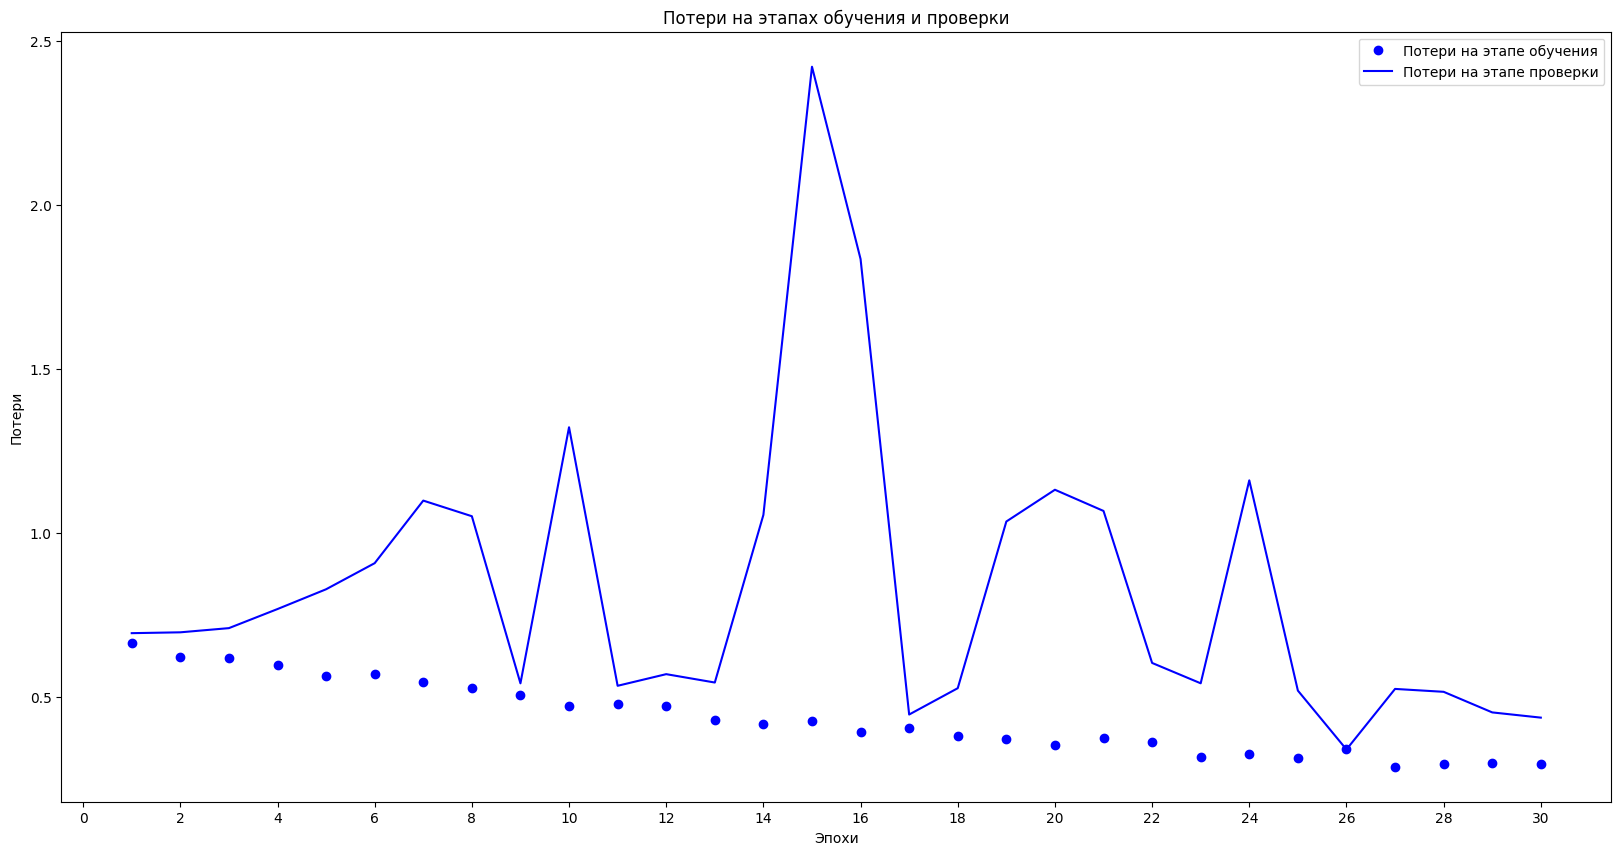

In [101]:
plt.figure(figsize=(20, 10))
plot_loss(history)

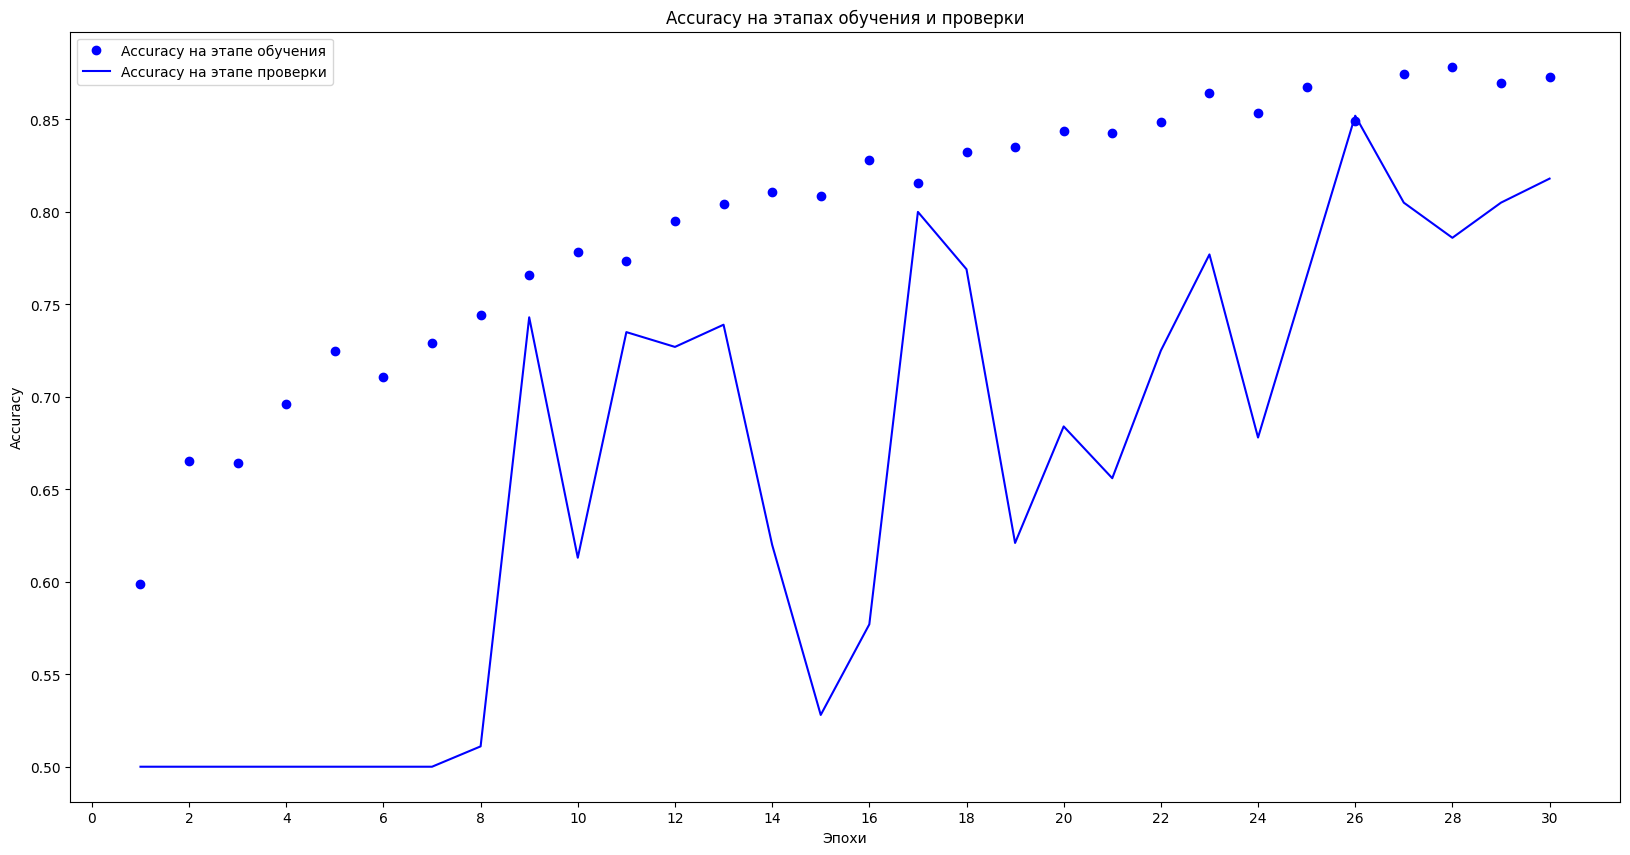

In [102]:
plt.figure(figsize=(20, 10))
plot_metric(history, "accuracy", "Accuracy")

In [103]:
model = keras.models.load_model("models/mini_xception.x")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 24ms/step - loss: 0.3788 - accuracy: 0.8395
Test accuracy: 0.840
